In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline

In [ ]:
### section 1: clustering already fitted filters

In [3]:
W_clumps = []
# F_clumps = []
# b_clumps = []

signs = ['exc','inh']
region = 'VISp'
layers = ['2','4','5']
for sign in signs:
    for layer in layers:
        D = np.load(sign+'_'+region+'_'+layer+'.npz')
        W_clumps.append(D['W_clump'])
        
W_clumps = np.concatenate(W_clumps)
print W_clumps.shape

(493, 40)


In [175]:
D = np.load('IVSCC_fits_cleaned.npz')
Ws = D['Ws']
Wses = D['Wses']
cell_idxs = D['cell_idxs']
cond = np.sum(Wses[:,15:],axis=1)<10

In [2]:
D = np.load('ivscc_data_half_tv.npz')
binned_spikes = D['binned_spikes']
stim = D['binned_stim']
bin_len = D['bin_len']

tv_split = 1.0/2
train_inds = np.arange(int(stim.shape[1]*tv_split))
val_inds = np.arange(int(stim.shape[1]*tv_split),int(stim.shape[1]))

# val_inds = np.arange(int(stim.shape[1]*tv_split))
# train_inds = np.arange(int(stim.shape[1]*tv_split),int(stim.shape[1]))
d = [50,50]

In [3]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add,add, Maximum, Layer, Dense, Lambda
from keras import Sequential
from keras.regularizers import Regularizer
from keras.initializers import RandomUniform
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from scipy.special import gamma
from scipy.stats import pearsonr
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [4]:

#helper functions for fitting GLM models
from scipy.stats import pearsonr
from scipy.misc import factorial
import statsmodels.api as sm

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    sh = flat_stimulus.shape # M is the size of a stimulus
    if len(sh)==1:
        M = 1
        T1 = sh[0]
        flat_stimulus = np.expand_dims(flat_stimulus,axis=0)
    else:
        (M,T1) = sh 
        
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T = binned_spikes.size
    X_dsn = np.ones((T-dmax,M*d1+d2+1))
    for t in range(T-dmax):
        X_dsn[t,:M*d1] = np.flip(flat_stimulus[:,t+dmax+1-d1:t+dmax+1],axis=1).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d,val_stim=None,val_spks=None,trial_inds=None,cond_inds=None,val_trial_inds=None,val_cond_inds=None,trial_len=None):
    d1,d2 = d
    dmax = max(d)
    y = spks.reshape([-1,1])
    model =  sm.GLM(y,construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    m_it = 200 #24
    model_results = model.fit(maxiter=m_it)
#     print model_results.fit_history['iteration']
    conved = m_it!=model_results.fit_history['iteration']
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d2].reshape([-1,d1])
    stim_se = se[:-1-d2]
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    if trial_len is not None:
        num_conds = np.unique(cond_inds).size
        mean_resps = np.empty((trial_len,num_conds))
        for i in range(num_conds):
            for t in range(trial_len):
                mean_resps[t,i] = np.mean(spks[trial_inds[cond_inds==i]+t])

        N_samps = 30
        exp_resps = np.zeros((trial_len,num_conds))
        for n in range(N_samps):
            sim_spks,_ = sim_GLM(stim, stim_filt, spk_filt, b)
            for i in range(num_conds):
                for t in range(trial_len):
                    exp_resps[t,i] += np.mean(sim_spks[trial_inds[cond_inds==i]+t])
        exp_resps /= N_samps
        train_corr = pearsonr(mean_resps.reshape([-1,1]),exp_resps.reshape([-1,1]))[0]
    else:
        smooth_train_spks = np.convolve(spks,filt,mode='same')
        train_corr = pearsonr(model.predict(p),smooth_train_spks)[0]

    train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
    dev = model_results.deviance
    
#     print dev, 2*(np.sum(-y+y*np.log(y+1e-20)-np.log(factorial(y)))-model_results.llf)
    if val_stim is not None:
        val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
        val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
        smooth_val_spks = np.convolve(val_spks,filt,mode='same')
        val_corr = pearsonr(val_model.predict(p),smooth_val_spks)[0]
        return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, dev, conved

def sim_GLM(stim, stim_filt, spk_filt, offset,noise_amp=None,noise_len=None,drop_rate = None, drop_len = None):
    d = (stim_filt.shape[-1], spk_filt.size)
    T = stim.shape[1]
    spks = np.zeros((T,)) # starts at time step d
    rate = np.zeros((T,))
    if noise_amp is not None:
        noise_sig = np.random.normal(loc=0.0,size=(T,))
        if noise_len>0:
            t_filt = np.arange(-2*noise_len,2*noise_len+1)
            filt = np.exp(-np.square(t_filt)/(noise_len**2*2))
            noise_sig = np.convolve(noise_sig,filt,mode='same')
        noise_sig = noise_amp*noise_sig/np.sqrt(np.mean(np.square(noise_sig)))
    for i in range(max(d),T):
        rate[i] = np.exp((np.flip(stim_filt,-1).reshape(1,-1)).dot((stim[:,i-d[0]+1:i+1].reshape(-1,1)))+np.flip(spk_filt,0).dot(spks[i-d[1]:i])+offset)
        rate[i] = min(10,rate[i])
        if noise_amp is not None:
            rate[i] = max(0,rate[i]+noise_sig[i])
        if drop_rate is None:
            spks[i] = np.random.poisson(rate[i])
        else:
            if drop_len is None:
                spks[i] = np.random.poisson(rate[i])*(np.random.uniform()>drop_rate)
            else:
                spks[i] = np.random.poisson(rate[i])
                if (np.random.uniform()<drop_rate/drop_len):
                    spks[max(0,i+1-drop_len):i+1] = 0
    return spks, rate



In [43]:
#individual fits
import gc

train_nnlls = []
val_nnlls = []
train_corrs = []
val_corrs = []
devs = []
conveds = []
Ws = []
Fs = []
bs = []
Wses = []
Fses = []
bses = []
for idx in range(stim.shape[0]):
    stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved = fit_GLM(stim[idx,train_inds],binned_spikes[idx,train_inds],d,val_stim = stim[idx,val_inds], val_spks = binned_spikes[idx,val_inds])
    Fs.append(stim_filt)
    Ws.append(spk_filt)
    bs.append(b)
    Fses.append(stim_se)
    Wses.append(spk_se)
    bses.append(bse)
    train_nnlls.append(train_nnll)
    val_nnlls.append(val_nnll)
    train_corrs.append(train_corr)
    val_corrs.append(val_corr)
    devs.append(dev)
    conveds.append(conved)
    gc.collect()
    print idx, train_nnll, val_nnll

0 0.05430333095696633 0.06336039902912714
1 0.04554252094276086 0.06618454710902046
2 0.04309422956933119 0.04866759123091774
3 0.08801223590387039 0.14847707801510784
4 0.05286167980492929 0.07869881726425455
5 0.040623840711498174 0.047749516980225754
6 0.07656171544421951 0.11450036642782324
7 0.07804364732325826 0.08735487923871123
8 0.03867915676666869 0.04550795043289834
9 0.042434324674609974 0.053662223591033974
10 0.039372846285833485 245.18041015833137
11 0.06731458353405961 0.07602476739213561
12 0.09470812045947859 0.1432472263312756
13 0.07565317076081883 0.10687544570281642
14 0.016757005994276767 200.13612470687028
15 0.11338279280481994 0.14849616241615965
16 0.07133424005960544 0.1054617764244724
17 0.03727149124603396 0.2008963025080085
18 0.15229480184063054 0.17067761821412963
19 0.1229338222810057 0.20180010087072597
20 0.06580623941449404 1.6648853091667777
21 0.10746009073207556 0.1443908028314178
22 0.12690414137175743 0.12093368013614908
23 0.07526007804494596 

191 0.05404261365572817 0.07036984879968351
192 0.16378832055343295 0.18436516665875843
193 0.04494880029710453 0.05855579607895904
194 0.10970998924180168 0.12383187299704265
195 0.055675045834030004 0.40646446115369433
196 0.07127810851396535 0.07186394350475554
197 0.049982017777192245 0.052407986557696414
198 0.044592236621265005 144.84176862531478
199 0.05135492323986532 0.05558457466874179
200 0.10834552654574638 0.1417681770788549
201 0.056525687648063934 0.14127007245733347
202 0.07885333144108406 0.071305453736149
203 0.03650141431165218 0.04976530531923364
204 0.0527582841520072 1.3706053570124521
205 0.062338780393838715 0.06492893626834459
206 0.07362548417479056 0.0717613721230805
207 0.061014771532322834 0.06097667137722504
208 0.011081089506210885 3716.2031307660536
209 0.1543334544785001 0.19880133737597233
210 0.13568691628621707 0.19293412343988214
211 0.044999190296617565 0.08750680030411688
212 0.15807726083216148 0.17083730915818474
213 0.0573810012456516 0.0704731

In [45]:
np.savez('ivscc_indiv_half_tv',train_losses = np.array(train_nnlls), val_losses = np.array(val_nnlls), train_corrs = np.array(train_corrs), val_corrs = np.array(val_corrs), devs = np.array(devs), conveds = np.array(conveds),Ws=np.array(Ws),Fs=np.array(Fs),bs=np.array(bs),Wses=np.array(Wses),Fses=np.array(Fses),bses=np.array(bses))


[[81  0  4  0  0  0  0  0]
 [ 1  6  6  0 33  1  1  0]
 [23  0 66  0  3  0  0  0]
 [ 0  4  0 12  2  0  1  2]
 [ 0 17  0  5  4  0  0  0]
 [ 0  0  0  1  0  2  0  2]
 [ 0  0  0  1  0  3  1  1]
 [ 0  0  0  1  0  2  3  1]]
0.5712320986474607


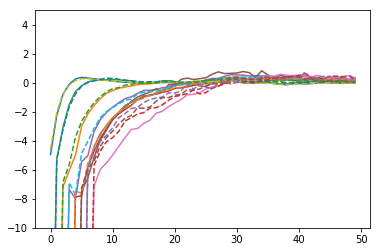

In [5]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
D1 = np.load('ivscc_indiv_half_tv.npz')
D2 = np.load('ivscc_indiv_other_half_tv.npz')

nc=8

X = D1['Ws']
kmeans = KMeans(n_clusters=nc).fit(X)
labels1 = kmeans.labels_
centers1 = kmeans.cluster_centers_.T
X = D2['Ws']
kmeans = KMeans(n_clusters=nc).fit(X)
labels2 = kmeans.labels_
centers2 = kmeans.cluster_centers_.T

plt.plot(centers1)
plt.plot(centers2,'--')
plt.ylim([-10,5])
print confusion_matrix(labels1,labels2)
print adjusted_rand_score(labels1,labels2)

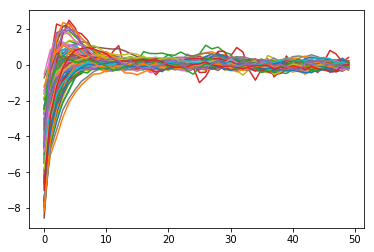

In [7]:
a=plt.plot(X[labels2==0,:].T)

In [8]:
# # X = Ws[cond,:]
# X = np.array(Ws)
# np.savez('used_inds',used_inds=cell_idxs[cond])
# # X = W_clumps[:,2:]
# # X = -X/np.min(X,axis=1,keepdims=True)
# kmeans = KMeans(n_clusters=3).fit(X)
# print X.shape

In [92]:
#parameter sets shared across predefined classes

import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


@threadsafe_generator
def batch_generator_shared(flat_stimulus, binned_spikes,inds, d,neuron=None, batch_size=5000,shared_stim=True):
    if len(flat_stimulus.shape)==1:
        flat_stimulus = np.expand_dims(flat_stimulus,0)
    (M,_) = flat_stimulus.shape # M is the size of a stimulus
    if not shared_stim:
        M=1
    if len(binned_spikes.shape)==1:
        binned_spikes = np.expand_dims(binned_spikes,0)
    (N,_) = binned_spikes.shape
    T = inds.size
    d1,d2 = d
    
    k=0
    if neuron is None:
        neur = 0
    else:
        neur = neuron
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[neur,inds[idxs]]
        X = np.empty((M*d1+d2+2,idxs.size))
        for i,idx in enumerate(idxs):
            if shared_stim:
                X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            else:
                X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[neur,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1,i] = 1
            X[M*d1+1:-1,i] = np.fliplr(np.reshape(binned_spikes[neur,inds[idx]-d2:inds[idx]],[1,-1]))
            X[-1,i] = neur
        k = k+batch_size
        if k>T:
            k=0
            if neuron is None:
                neur+=1
                if neur==N:
                    neur = 0
        yield X.T, y


class GatedDense(Layer):

    def __init__(self, neuron, output_dim, **kwargs):
        self.neuron = neuron
        self.output_dim = output_dim
        super(GatedDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.output_dim, 1), initializer=RandomUniform(minval=-0.01,maxval=0.01),
                                      trainable=True)
        super(GatedDense, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.expand_dims(K.switch(K.equal(float(self.neuron),x[:,-1]),K.squeeze(K.dot(x[:,:self.output_dim],self.kernel),1),K.zeros_like(x[:,-1])))


    def compute_output_shape(self, input_shape):
        return (input_shape[0],1)

def exp_decay(t):
    initial_lrate = 1e-2
    k = 0.99
    lrate = initial_lrate * k**t
    return lrate


# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_shared_fit(stimulus,spikes,d,bin_len,train_inds,val_inds,f='exp',shared_stim=True,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]

    bs = 1001
    
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.array(train_inds)+dmax
    val_inds = np.array(val_inds)+dmax
    
    if cell_types is None:
        cell_types = np.zeros((N,))
    classes = np.unique(cell_types)
    
    if not shared_stim:
        M=1
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = {}
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for cls in classes:
        
        # construct GLM model and return fit
        cls_idxs = np.squeeze(np.argwhere(cell_types==cls))
        cls_spikes = spikes[cls_idxs,:]
        if shared_stim:
            stim = stimulus
        else:
            stim = stimulus[cls_idxs,:]
        print cls, cls_idxs.size
        inp = Input(shape = (M*d[0]+d[1]+2,))
        x = []
        for idx in range(cls_idxs.size):
            x.append(GatedDense(idx,M*d[0]+1)(inp))
        a = Lambda(lambda val: val[:,M*d[0]+1:-1])(inp)
        x.append(Dense(1,use_bias=False)(a))
        x = Add()(x)
        out = Lambda(lambda val: fs[f](val)*bin_len)(x)
        model = Model(inputs=[inp],outputs=[out])
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=3e-2))
        train_gen = batch_generator_shared(stim,cls_spikes,train_inds, d,batch_size=bs,shared_stim=shared_stim)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = (train_inds.size/bs+1)*cls_idxs.size,
                            epochs=4000,verbose=2,
#                             callbacks=[LearningRateScheduler(exp_decay),EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])
                            callbacks=[ReduceLROnPlateau(monitor='loss',min_delta=0,patience=2,factor=0.8,verbose=1,min_lr=5e-5),
                                       ReduceLROnPlateau(monitor='loss',min_delta=1e-5,patience=15,factor=0.95,verbose=1,min_lr=1e-4),EarlyStopping(monitor='loss',min_delta=1e-6,patience=10)])

        p = model.get_weights()
        if cls_idxs.size==1:
            cls_idxs=[cls_idxs]
        for idx,i in enumerate(cls_idxs):
            smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
            F[i,:,:] = p[idx][:-1].reshape((M,d[0]))
            b[i] = p[idx][-1]
            train_gen = batch_generator_shared(stim,cls_spikes,train_inds, d, neuron = idx,batch_size=train_inds.size+1,shared_stim=shared_stim)
            train_losses[i] = model.evaluate_generator(train_gen,steps=1)
            train_corrs[i] = pearsonr(smoothed_spikes[train_inds],model.predict_generator(train_gen,steps=1).squeeze())[0]
            val_gen = batch_generator_shared(stim,cls_spikes,val_inds, d, neuron = idx, batch_size=val_inds.size+1,shared_stim=shared_stim)
            val_losses[i] = model.evaluate_generator(val_gen,steps=1)
            val_corrs[i] = pearsonr(smoothed_spikes[val_inds],model.predict_generator(val_gen,steps=1).squeeze())[0]
        W[cls] = p[-1]

        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [ ]:
tv_split = 1.0/2
train_inds = np.arange(int(stim.shape[1]*tv_split))
val_inds = np.arange(int(stim.shape[1]*tv_split),int(stim.shape[1]))

# val_inds = np.arange(int(stim.shape[1]*tv_split))
# train_inds = np.arange(int(stim.shape[1]*tv_split),int(stim.shape[1]))
d = [50,50]

# cell_types = np.random.permutation(labels1)
# cell_types = labels1
cell_types = np.arange(binned_spikes.shape[0])

(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_shared_fit(stim,binned_spikes,d, bin_len,train_inds,val_inds,cell_types=cell_types,shared_stim=False)


0 1
Epoch 1/4000
 - 4s - loss: 0.1369
Epoch 2/4000
 - 0s - loss: 0.1047
Epoch 3/4000
 - 0s - loss: 0.0989
Epoch 4/4000
 - 0s - loss: 0.0963
Epoch 5/4000
 - 0s - loss: 0.0951
Epoch 6/4000
 - 0s - loss: 0.0946
Epoch 7/4000
 - 0s - loss: 0.0946
Epoch 8/4000
 - 0s - loss: 0.0952
Epoch 9/4000
 - 0s - loss: 0.0972

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 10/4000
 - 0s - loss: 0.0980
Epoch 11/4000
 - 0s - loss: 0.0913
Epoch 12/4000
 - 0s - loss: 0.0906
Epoch 13/4000
 - 0s - loss: 0.0903
Epoch 14/4000
 - 0s - loss: 0.0901
Epoch 15/4000
 - 0s - loss: 0.0901
Epoch 16/4000
 - 0s - loss: 0.0904
Epoch 17/4000
 - 0s - loss: 0.0921

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 18/4000
 - 0s - loss: 0.0936
Epoch 19/4000
 - 0s - loss: 0.0897
Epoch 20/4000
 - 0s - loss: 0.0885
Epoch 21/4000
 - 0s - loss: 0.0881
Epoch 22/4000
 - 0s - loss: 0.0879
Epoch 23/4000
 - 0s - loss: 0.0877
Epoch 24/4000
 - 0s - loss: 0.0876
Epoch 25/4000
 

 - 0s - loss: 0.0709
Epoch 226/4000
 - 0s - loss: 0.0708
Epoch 227/4000
 - 0s - loss: 0.0708
Epoch 228/4000
 - 0s - loss: 0.0707
Epoch 229/4000
 - 0s - loss: 0.0707
Epoch 230/4000
 - 0s - loss: 0.0707
Epoch 231/4000
 - 0s - loss: 0.0706
Epoch 232/4000
 - 0s - loss: 0.0706
Epoch 233/4000
 - 0s - loss: 0.0705
Epoch 234/4000
 - 0s - loss: 0.0705
Epoch 235/4000
 - 0s - loss: 0.0704
Epoch 236/4000
 - 0s - loss: 0.0704
Epoch 237/4000
 - 0s - loss: 0.0704
Epoch 238/4000
 - 0s - loss: 0.0703
Epoch 239/4000
 - 0s - loss: 0.0703
Epoch 240/4000
 - 0s - loss: 0.0702
Epoch 241/4000
 - 0s - loss: 0.0702
Epoch 242/4000
 - 0s - loss: 0.0702
Epoch 243/4000
 - 0s - loss: 0.0701
Epoch 244/4000
 - 0s - loss: 0.0701
Epoch 245/4000
 - 0s - loss: 0.0700
Epoch 246/4000
 - 0s - loss: 0.0700
Epoch 247/4000
 - 0s - loss: 0.0700
Epoch 248/4000
 - 0s - loss: 0.0699
Epoch 249/4000
 - 0s - loss: 0.0699
Epoch 250/4000
 - 0s - loss: 0.0698
Epoch 251/4000
 - 0s - loss: 0.0698
Epoch 252/4000
 - 0s - loss: 0.0698
Epoch 2

Epoch 453/4000
 - 0s - loss: 0.0642
Epoch 454/4000
 - 0s - loss: 0.0642
Epoch 455/4000
 - 0s - loss: 0.0641
Epoch 456/4000
 - 0s - loss: 0.0640
Epoch 457/4000
 - 0s - loss: 0.0639
Epoch 458/4000
 - 0s - loss: 0.0639
Epoch 459/4000
 - 0s - loss: 0.0638
Epoch 460/4000
 - 0s - loss: 0.0637
Epoch 461/4000
 - 0s - loss: 0.0637
Epoch 462/4000
 - 0s - loss: 0.0636
Epoch 463/4000
 - 0s - loss: 0.0636
Epoch 464/4000
 - 0s - loss: 0.0635
Epoch 465/4000
 - 0s - loss: 0.0635
Epoch 466/4000
 - 0s - loss: 0.0634
Epoch 467/4000
 - 0s - loss: 0.0634
Epoch 468/4000
 - 0s - loss: 0.0634
Epoch 469/4000
 - 0s - loss: 0.0634
Epoch 470/4000
 - 0s - loss: 0.0633
Epoch 471/4000
 - 0s - loss: 0.0633
Epoch 472/4000
 - 0s - loss: 0.0633
Epoch 473/4000
 - 0s - loss: 0.0633
Epoch 474/4000
 - 0s - loss: 0.0633
Epoch 475/4000
 - 0s - loss: 0.0633
Epoch 476/4000
 - 0s - loss: 0.0633
Epoch 477/4000
 - 0s - loss: 0.0633

Epoch 00477: ReduceLROnPlateau reducing learning rate to 0.0122880004346.
Epoch 478/4000
 - 0s - lo

 - 0s - loss: 0.0608
Epoch 675/4000
 - 0s - loss: 0.0608
Epoch 676/4000
 - 0s - loss: 0.0608
Epoch 677/4000
 - 0s - loss: 0.0608
Epoch 678/4000
 - 0s - loss: 0.0608
Epoch 679/4000
 - 0s - loss: 0.0608
Epoch 680/4000
 - 0s - loss: 0.0608
Epoch 681/4000
 - 0s - loss: 0.0608
Epoch 682/4000
 - 0s - loss: 0.0607
Epoch 683/4000
 - 0s - loss: 0.0607
Epoch 684/4000
 - 0s - loss: 0.0607
Epoch 685/4000
 - 0s - loss: 0.0607
Epoch 686/4000
 - 0s - loss: 0.0607
Epoch 687/4000
 - 0s - loss: 0.0607
Epoch 688/4000
 - 0s - loss: 0.0607
Epoch 689/4000
 - 0s - loss: 0.0607
Epoch 690/4000
 - 0s - loss: 0.0607
Epoch 691/4000
 - 0s - loss: 0.0607
Epoch 692/4000
 - 0s - loss: 0.0607
Epoch 693/4000
 - 0s - loss: 0.0606
Epoch 694/4000
 - 0s - loss: 0.0606
Epoch 695/4000
 - 0s - loss: 0.0606
Epoch 696/4000
 - 0s - loss: 0.0606
Epoch 697/4000
 - 0s - loss: 0.0606
Epoch 698/4000
 - 0s - loss: 0.0606
Epoch 699/4000
 - 0s - loss: 0.0606
Epoch 700/4000
 - 0s - loss: 0.0606
Epoch 701/4000
 - 0s - loss: 0.0606
Epoch 7

Epoch 902/4000
 - 0s - loss: 0.0592
Epoch 903/4000
 - 0s - loss: 0.0592
Epoch 904/4000
 - 0s - loss: 0.0592
Epoch 905/4000
 - 0s - loss: 0.0592
Epoch 906/4000
 - 0s - loss: 0.0592
Epoch 907/4000
 - 0s - loss: 0.0592
Epoch 908/4000
 - 0s - loss: 0.0592
Epoch 909/4000
 - 0s - loss: 0.0592
Epoch 910/4000
 - 0s - loss: 0.0592
Epoch 911/4000
 - 0s - loss: 0.0592
Epoch 912/4000
 - 0s - loss: 0.0592
Epoch 913/4000
 - 0s - loss: 0.0592
Epoch 914/4000
 - 0s - loss: 0.0592
Epoch 915/4000
 - 0s - loss: 0.0591
Epoch 916/4000
 - 0s - loss: 0.0591
Epoch 917/4000
 - 0s - loss: 0.0591
Epoch 918/4000
 - 0s - loss: 0.0591
Epoch 919/4000
 - 0s - loss: 0.0591
Epoch 920/4000
 - 0s - loss: 0.0591
Epoch 921/4000
 - 0s - loss: 0.0591
Epoch 922/4000
 - 0s - loss: 0.0591
Epoch 923/4000
 - 0s - loss: 0.0591
Epoch 924/4000
 - 0s - loss: 0.0591
Epoch 925/4000
 - 0s - loss: 0.0591
Epoch 926/4000
 - 0s - loss: 0.0591
Epoch 927/4000
 - 0s - loss: 0.0591
Epoch 928/4000
 - 0s - loss: 0.0591
Epoch 929/4000
 - 0s - loss:

 - 0s - loss: 0.0582
Epoch 1127/4000
 - 0s - loss: 0.0582
Epoch 1128/4000
 - 0s - loss: 0.0582
Epoch 1129/4000
 - 0s - loss: 0.0582
Epoch 1130/4000
 - 0s - loss: 0.0582
Epoch 1131/4000
 - 0s - loss: 0.0582
Epoch 1132/4000
 - 0s - loss: 0.0582
Epoch 1133/4000
 - 0s - loss: 0.0582
Epoch 1134/4000
 - 0s - loss: 0.0582
Epoch 1135/4000
 - 0s - loss: 0.0582
Epoch 1136/4000
 - 0s - loss: 0.0582
Epoch 1137/4000
 - 0s - loss: 0.0582
Epoch 1138/4000
 - 0s - loss: 0.0582
Epoch 1139/4000
 - 0s - loss: 0.0582
Epoch 1140/4000
 - 0s - loss: 0.0581
Epoch 1141/4000
 - 0s - loss: 0.0581
Epoch 1142/4000
 - 0s - loss: 0.0581
Epoch 1143/4000
 - 0s - loss: 0.0581
Epoch 1144/4000
 - 0s - loss: 0.0581
Epoch 1145/4000
 - 0s - loss: 0.0581
Epoch 1146/4000
 - 0s - loss: 0.0581
Epoch 1147/4000
 - 0s - loss: 0.0581
Epoch 1148/4000
 - 0s - loss: 0.0581
Epoch 1149/4000
 - 0s - loss: 0.0581
Epoch 1150/4000
 - 0s - loss: 0.0581
Epoch 1151/4000
 - 0s - loss: 0.0581
Epoch 1152/4000
 - 0s - loss: 0.0581
Epoch 1153/4000
 

Epoch 1348/4000
 - 0s - loss: 0.0575
Epoch 1349/4000
 - 0s - loss: 0.0575
Epoch 1350/4000
 - 0s - loss: 0.0575
Epoch 1351/4000
 - 0s - loss: 0.0575
Epoch 1352/4000
 - 0s - loss: 0.0575
Epoch 1353/4000
 - 0s - loss: 0.0575
Epoch 1354/4000
 - 0s - loss: 0.0575
Epoch 1355/4000
 - 0s - loss: 0.0575
Epoch 1356/4000
 - 0s - loss: 0.0575
Epoch 1357/4000
 - 0s - loss: 0.0575
Epoch 1358/4000
 - 0s - loss: 0.0575
Epoch 1359/4000
 - 0s - loss: 0.0575
Epoch 1360/4000
 - 0s - loss: 0.0575
Epoch 1361/4000
 - 0s - loss: 0.0574
Epoch 1362/4000
 - 0s - loss: 0.0574
Epoch 1363/4000
 - 0s - loss: 0.0574
Epoch 1364/4000
 - 0s - loss: 0.0574
Epoch 1365/4000
 - 0s - loss: 0.0574
Epoch 1366/4000
 - 0s - loss: 0.0574
Epoch 1367/4000
 - 0s - loss: 0.0574
Epoch 1368/4000
 - 0s - loss: 0.0574
Epoch 1369/4000
 - 0s - loss: 0.0574
Epoch 1370/4000
 - 0s - loss: 0.0574
Epoch 1371/4000
 - 0s - loss: 0.0574
Epoch 1372/4000
 - 0s - loss: 0.0574
Epoch 1373/4000
 - 0s - loss: 0.0574
Epoch 1374/4000
 - 0s - loss: 0.0574
E

 - 0s - loss: 0.0569
Epoch 1570/4000
 - 0s - loss: 0.0569
Epoch 1571/4000
 - 0s - loss: 0.0569
Epoch 1572/4000
 - 0s - loss: 0.0569
Epoch 1573/4000
 - 0s - loss: 0.0569
Epoch 1574/4000
 - 0s - loss: 0.0569
Epoch 1575/4000
 - 0s - loss: 0.0569
Epoch 1576/4000
 - 0s - loss: 0.0569
Epoch 1577/4000
 - 0s - loss: 0.0569
Epoch 1578/4000
 - 0s - loss: 0.0569
Epoch 1579/4000
 - 0s - loss: 0.0569
Epoch 1580/4000
 - 0s - loss: 0.0569
Epoch 1581/4000
 - 0s - loss: 0.0569
Epoch 1582/4000
 - 0s - loss: 0.0569
Epoch 1583/4000
 - 0s - loss: 0.0569
Epoch 1584/4000
 - 0s - loss: 0.0569
Epoch 1585/4000
 - 0s - loss: 0.0569
Epoch 1586/4000
 - 0s - loss: 0.0569
Epoch 1587/4000
 - 0s - loss: 0.0569
Epoch 1588/4000
 - 0s - loss: 0.0569
Epoch 1589/4000
 - 0s - loss: 0.0569
Epoch 1590/4000
 - 0s - loss: 0.0569
Epoch 1591/4000
 - 0s - loss: 0.0569
Epoch 1592/4000
 - 0s - loss: 0.0569
Epoch 1593/4000
 - 0s - loss: 0.0569
Epoch 1594/4000
 - 0s - loss: 0.0569
Epoch 1595/4000
 - 0s - loss: 0.0569
Epoch 1596/4000
 

Epoch 1791/4000
 - 0s - loss: 0.0565
Epoch 1792/4000
 - 0s - loss: 0.0565
Epoch 1793/4000
 - 0s - loss: 0.0565
Epoch 1794/4000
 - 0s - loss: 0.0565
Epoch 1795/4000
 - 0s - loss: 0.0565
Epoch 1796/4000
 - 0s - loss: 0.0565
Epoch 1797/4000
 - 0s - loss: 0.0565
Epoch 1798/4000
 - 0s - loss: 0.0565
Epoch 1799/4000
 - 0s - loss: 0.0565
Epoch 1800/4000
 - 0s - loss: 0.0565
Epoch 1801/4000
 - 0s - loss: 0.0565
Epoch 1802/4000
 - 0s - loss: 0.0565
Epoch 1803/4000
 - 0s - loss: 0.0565
Epoch 1804/4000
 - 0s - loss: 0.0565
Epoch 1805/4000
 - 0s - loss: 0.0565
Epoch 1806/4000
 - 0s - loss: 0.0565
Epoch 1807/4000
 - 0s - loss: 0.0565
Epoch 1808/4000
 - 0s - loss: 0.0565
Epoch 1809/4000
 - 0s - loss: 0.0565
Epoch 1810/4000
 - 0s - loss: 0.0565
Epoch 1811/4000
 - 0s - loss: 0.0565
Epoch 1812/4000
 - 0s - loss: 0.0565
Epoch 1813/4000
 - 0s - loss: 0.0565
Epoch 1814/4000
 - 0s - loss: 0.0565
Epoch 1815/4000
 - 0s - loss: 0.0565
Epoch 1816/4000
 - 0s - loss: 0.0565
Epoch 1817/4000
 - 0s - loss: 0.0565
E

 - 0s - loss: 0.0562
Epoch 2013/4000
 - 0s - loss: 0.0562
Epoch 2014/4000
 - 0s - loss: 0.0562
Epoch 2015/4000
 - 0s - loss: 0.0562
Epoch 2016/4000
 - 0s - loss: 0.0562
Epoch 2017/4000
 - 0s - loss: 0.0562
Epoch 2018/4000
 - 0s - loss: 0.0562
Epoch 2019/4000
 - 0s - loss: 0.0562
Epoch 2020/4000
 - 0s - loss: 0.0562
Epoch 2021/4000
 - 0s - loss: 0.0562
Epoch 2022/4000
 - 0s - loss: 0.0562
Epoch 2023/4000
 - 0s - loss: 0.0562
Epoch 2024/4000
 - 0s - loss: 0.0562
Epoch 2025/4000
 - 0s - loss: 0.0562
Epoch 2026/4000
 - 0s - loss: 0.0562
Epoch 2027/4000
 - 0s - loss: 0.0562
Epoch 2028/4000
 - 0s - loss: 0.0562
Epoch 2029/4000
 - 0s - loss: 0.0562
Epoch 2030/4000
 - 0s - loss: 0.0562
Epoch 2031/4000
 - 0s - loss: 0.0562
Epoch 2032/4000
 - 0s - loss: 0.0562
Epoch 2033/4000
 - 0s - loss: 0.0562
Epoch 2034/4000
 - 0s - loss: 0.0562
Epoch 2035/4000
 - 0s - loss: 0.0562
Epoch 2036/4000
 - 0s - loss: 0.0561
Epoch 2037/4000
 - 0s - loss: 0.0561
Epoch 2038/4000
 - 0s - loss: 0.0561
Epoch 2039/4000
 

Epoch 2234/4000
 - 0s - loss: 0.0559
Epoch 2235/4000
 - 0s - loss: 0.0559
Epoch 2236/4000
 - 0s - loss: 0.0559
Epoch 2237/4000
 - 0s - loss: 0.0559
Epoch 2238/4000
 - 0s - loss: 0.0559
Epoch 2239/4000
 - 0s - loss: 0.0559
Epoch 2240/4000
 - 0s - loss: 0.0559
Epoch 2241/4000
 - 0s - loss: 0.0559
Epoch 2242/4000
 - 0s - loss: 0.0559
Epoch 2243/4000
 - 0s - loss: 0.0559
Epoch 2244/4000
 - 0s - loss: 0.0559
Epoch 2245/4000
 - 0s - loss: 0.0559
Epoch 2246/4000
 - 0s - loss: 0.0559
Epoch 2247/4000
 - 0s - loss: 0.0559
Epoch 2248/4000
 - 0s - loss: 0.0559
Epoch 2249/4000
 - 0s - loss: 0.0559
Epoch 2250/4000
 - 0s - loss: 0.0559
Epoch 2251/4000
 - 0s - loss: 0.0559
Epoch 2252/4000
 - 0s - loss: 0.0559
Epoch 2253/4000
 - 0s - loss: 0.0559
Epoch 2254/4000
 - 0s - loss: 0.0559
Epoch 2255/4000
 - 0s - loss: 0.0559
Epoch 2256/4000
 - 0s - loss: 0.0559
Epoch 2257/4000
 - 0s - loss: 0.0559
Epoch 2258/4000
 - 0s - loss: 0.0559
Epoch 2259/4000
 - 0s - loss: 0.0559
Epoch 2260/4000
 - 0s - loss: 0.0559
E

 - 0s - loss: 0.0557
Epoch 2456/4000
 - 0s - loss: 0.0557
Epoch 2457/4000
 - 0s - loss: 0.0557
Epoch 2458/4000
 - 0s - loss: 0.0557
Epoch 2459/4000
 - 0s - loss: 0.0557
Epoch 2460/4000
 - 0s - loss: 0.0557
Epoch 2461/4000
 - 0s - loss: 0.0557
Epoch 2462/4000
 - 0s - loss: 0.0557
Epoch 2463/4000
 - 0s - loss: 0.0557
Epoch 2464/4000
 - 0s - loss: 0.0557
Epoch 2465/4000
 - 0s - loss: 0.0557
Epoch 2466/4000
 - 0s - loss: 0.0556
Epoch 2467/4000
 - 0s - loss: 0.0556
Epoch 2468/4000
 - 0s - loss: 0.0556
Epoch 2469/4000
 - 0s - loss: 0.0556
Epoch 2470/4000
 - 0s - loss: 0.0556
Epoch 2471/4000
 - 0s - loss: 0.0556
Epoch 2472/4000
 - 0s - loss: 0.0556
Epoch 2473/4000
 - 0s - loss: 0.0556
Epoch 2474/4000
 - 0s - loss: 0.0556
Epoch 2475/4000
 - 0s - loss: 0.0556
Epoch 2476/4000
 - 0s - loss: 0.0556
Epoch 2477/4000
 - 0s - loss: 0.0556
Epoch 2478/4000
 - 0s - loss: 0.0556
Epoch 2479/4000
 - 0s - loss: 0.0556
Epoch 2480/4000
 - 0s - loss: 0.0556
Epoch 2481/4000
 - 0s - loss: 0.0556
Epoch 2482/4000
 

Epoch 2677/4000
 - 0s - loss: 0.0555
Epoch 2678/4000
 - 0s - loss: 0.0555
Epoch 2679/4000
 - 0s - loss: 0.0555
Epoch 2680/4000
 - 0s - loss: 0.0555
Epoch 2681/4000
 - 0s - loss: 0.0555
Epoch 2682/4000
 - 0s - loss: 0.0555
Epoch 2683/4000
 - 0s - loss: 0.0555
Epoch 2684/4000
 - 0s - loss: 0.0555
Epoch 2685/4000
 - 0s - loss: 0.0555
Epoch 2686/4000
 - 0s - loss: 0.0555
Epoch 2687/4000
 - 0s - loss: 0.0554
Epoch 2688/4000
 - 0s - loss: 0.0554
Epoch 2689/4000
 - 0s - loss: 0.0554
Epoch 2690/4000
 - 0s - loss: 0.0554
Epoch 2691/4000
 - 0s - loss: 0.0554
Epoch 2692/4000
 - 0s - loss: 0.0554
Epoch 2693/4000
 - 0s - loss: 0.0554
Epoch 2694/4000
 - 0s - loss: 0.0554
Epoch 2695/4000
 - 0s - loss: 0.0554
Epoch 2696/4000
 - 0s - loss: 0.0554
Epoch 2697/4000
 - 0s - loss: 0.0554
Epoch 2698/4000
 - 0s - loss: 0.0554
Epoch 2699/4000
 - 0s - loss: 0.0554
Epoch 2700/4000
 - 0s - loss: 0.0554
Epoch 2701/4000
 - 0s - loss: 0.0554
Epoch 2702/4000
 - 0s - loss: 0.0554
Epoch 2703/4000
 - 0s - loss: 0.0554
E

 - 0s - loss: 0.0553
Epoch 2899/4000
 - 0s - loss: 0.0553
Epoch 2900/4000
 - 0s - loss: 0.0553
Epoch 2901/4000
 - 0s - loss: 0.0553
Epoch 2902/4000
 - 0s - loss: 0.0553
Epoch 2903/4000
 - 0s - loss: 0.0553
Epoch 2904/4000
 - 0s - loss: 0.0553
Epoch 2905/4000
 - 0s - loss: 0.0553
Epoch 2906/4000
 - 0s - loss: 0.0553
Epoch 2907/4000
 - 0s - loss: 0.0553
Epoch 2908/4000
 - 0s - loss: 0.0553
Epoch 2909/4000
 - 0s - loss: 0.0553
Epoch 2910/4000
 - 0s - loss: 0.0553
Epoch 2911/4000
 - 0s - loss: 0.0553
Epoch 2912/4000
 - 0s - loss: 0.0553
Epoch 2913/4000
 - 0s - loss: 0.0553
Epoch 2914/4000
 - 0s - loss: 0.0553
Epoch 2915/4000
 - 0s - loss: 0.0553
Epoch 2916/4000
 - 0s - loss: 0.0553
Epoch 2917/4000
 - 0s - loss: 0.0553
Epoch 2918/4000
 - 0s - loss: 0.0553
Epoch 2919/4000
 - 0s - loss: 0.0553
Epoch 2920/4000
 - 0s - loss: 0.0553
Epoch 2921/4000
 - 0s - loss: 0.0553
Epoch 2922/4000
 - 0s - loss: 0.0553
Epoch 2923/4000
 - 0s - loss: 0.0553
Epoch 2924/4000
 - 0s - loss: 0.0553
Epoch 2925/4000
 

Epoch 3116/4000
 - 0s - loss: 0.0551

Epoch 03116: ReduceLROnPlateau reducing learning rate to 0.0056780395098.
Epoch 3117/4000
 - 0s - loss: 0.0551
Epoch 3118/4000
 - 0s - loss: 0.0551
Epoch 3119/4000
 - 0s - loss: 0.0551
Epoch 3120/4000
 - 0s - loss: 0.0551
Epoch 3121/4000
 - 0s - loss: 0.0551
Epoch 3122/4000
 - 0s - loss: 0.0551
Epoch 3123/4000
 - 0s - loss: 0.0551
Epoch 3124/4000
 - 0s - loss: 0.0551
Epoch 3125/4000
 - 0s - loss: 0.0551
Epoch 3126/4000
 - 0s - loss: 0.0551
Epoch 3127/4000
 - 0s - loss: 0.0551
Epoch 3128/4000
 - 0s - loss: 0.0551
Epoch 3129/4000
 - 0s - loss: 0.0551
Epoch 3130/4000
 - 0s - loss: 0.0551
Epoch 3131/4000
 - 0s - loss: 0.0551
Epoch 3132/4000
 - 0s - loss: 0.0551

Epoch 03132: ReduceLROnPlateau reducing learning rate to 0.00539413753431.
Epoch 3133/4000
 - 0s - loss: 0.0551
Epoch 3134/4000
 - 0s - loss: 0.0551
Epoch 3135/4000
 - 0s - loss: 0.0551
Epoch 3136/4000
 - 0s - loss: 0.0551
Epoch 3137/4000
 - 0s - loss: 0.0551
Epoch 3138/4000
 - 0s - loss: 0.055


Epoch 03312: ReduceLROnPlateau reducing learning rate to 0.00306818583049.
Epoch 3313/4000
 - 0s - loss: 0.0549
Epoch 3314/4000
 - 0s - loss: 0.0549
Epoch 3315/4000
 - 0s - loss: 0.0549
Epoch 3316/4000
 - 0s - loss: 0.0549
Epoch 3317/4000
 - 0s - loss: 0.0549
Epoch 3318/4000
 - 0s - loss: 0.0549
Epoch 3319/4000
 - 0s - loss: 0.0549
Epoch 3320/4000
 - 0s - loss: 0.0549
Epoch 3321/4000
 - 0s - loss: 0.0549
Epoch 3322/4000
 - 0s - loss: 0.0549
Epoch 3323/4000
 - 0s - loss: 0.0549
Epoch 3324/4000
 - 0s - loss: 0.0549
Epoch 3325/4000
 - 0s - loss: 0.0549
Epoch 3326/4000
 - 0s - loss: 0.0549
Epoch 3327/4000
 - 0s - loss: 0.0549
Epoch 3328/4000
 - 0s - loss: 0.0549
Epoch 3329/4000
 - 0s - loss: 0.0549
Epoch 3330/4000
 - 0s - loss: 0.0549
Epoch 3331/4000
 - 0s - loss: 0.0549
Epoch 3332/4000
 - 0s - loss: 0.0549
Epoch 3333/4000
 - 0s - loss: 0.0549

Epoch 03333: ReduceLROnPlateau reducing learning rate to 0.0029147765832.
Epoch 3334/4000
 - 0s - loss: 0.0549
Epoch 3335/4000
 - 0s - loss: 0.054


Epoch 03513: ReduceLROnPlateau reducing learning rate to 0.00183703628718.
Epoch 3514/4000
 - 0s - loss: 0.0549
Epoch 3515/4000
 - 0s - loss: 0.0549
Epoch 3516/4000
 - 0s - loss: 0.0549
Epoch 3517/4000
 - 0s - loss: 0.0549
Epoch 3518/4000
 - 0s - loss: 0.0549
Epoch 3519/4000
 - 0s - loss: 0.0549
Epoch 3520/4000
 - 0s - loss: 0.0549
Epoch 3521/4000
 - 0s - loss: 0.0549
Epoch 3522/4000
 - 0s - loss: 0.0549
Epoch 3523/4000
 - 0s - loss: 0.0549
Epoch 3524/4000
 - 0s - loss: 0.0549
Epoch 3525/4000
 - 0s - loss: 0.0549
Epoch 3526/4000
 - 0s - loss: 0.0548
Epoch 3527/4000
 - 0s - loss: 0.0548
Epoch 3528/4000
 - 0s - loss: 0.0548
Epoch 3529/4000
 - 0s - loss: 0.0548

Epoch 03529: ReduceLROnPlateau reducing learning rate to 0.00174518452259.
Epoch 3530/4000
 - 0s - loss: 0.0548
Epoch 3531/4000
 - 0s - loss: 0.0548
Epoch 3532/4000
 - 0s - loss: 0.0548
Epoch 3533/4000
 - 0s - loss: 0.0548
Epoch 3534/4000
 - 0s - loss: 0.0548
Epoch 3535/4000
 - 0s - loss: 0.0548
Epoch 3536/4000
 - 0s - loss: 0.05

Epoch 3711/4000
 - 0s - loss: 0.0548
Epoch 3712/4000
 - 0s - loss: 0.0548
Epoch 3713/4000
 - 0s - loss: 0.0548
Epoch 3714/4000
 - 0s - loss: 0.0548
1 1
Epoch 1/4000
 - 4s - loss: 0.1793
Epoch 2/4000
 - 0s - loss: 0.2386
Epoch 3/4000
 - 0s - loss: 0.2055

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 4/4000
 - 0s - loss: 0.2122
Epoch 5/4000
 - 0s - loss: 0.1912

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 6/4000
 - 0s - loss: 0.1681
Epoch 7/4000
 - 0s - loss: 0.1442
Epoch 8/4000
 - 0s - loss: 0.1195
Epoch 9/4000
 - 0s - loss: 0.0965
Epoch 10/4000
 - 0s - loss: 0.0814
Epoch 11/4000
 - 0s - loss: 0.0786
Epoch 12/4000
 - 0s - loss: 0.0780
Epoch 13/4000
 - 0s - loss: 0.0775
Epoch 14/4000
 - 0s - loss: 0.0771
Epoch 15/4000
 - 0s - loss: 0.0766
Epoch 16/4000
 - 0s - loss: 0.0762
Epoch 17/4000
 - 0s - loss: 0.0757
Epoch 18/4000
 - 0s - loss: 0.0753
Epoch 19/4000
 - 0s - loss: 0.0749
Epoch 20/4000
 - 0s - loss: 0.0744
Epoch 2

 - 0s - loss: 0.0619
Epoch 207/4000
 - 0s - loss: 0.0617
Epoch 208/4000
 - 0s - loss: 0.0617
Epoch 209/4000
 - 0s - loss: 0.0616
Epoch 210/4000
 - 0s - loss: 0.0616
Epoch 211/4000
 - 0s - loss: 0.0615
Epoch 212/4000
 - 0s - loss: 0.0616
Epoch 213/4000
 - 0s - loss: 0.0615
Epoch 214/4000
 - 0s - loss: 0.0615
Epoch 215/4000
 - 0s - loss: 0.0615
Epoch 216/4000
 - 0s - loss: 0.0615
Epoch 217/4000
 - 0s - loss: 0.0615
Epoch 218/4000
 - 0s - loss: 0.0615
Epoch 219/4000
 - 0s - loss: 0.0614
Epoch 220/4000
 - 0s - loss: 0.0614
Epoch 221/4000
 - 0s - loss: 0.0614
Epoch 222/4000
 - 0s - loss: 0.0614
Epoch 223/4000
 - 0s - loss: 0.0614
Epoch 224/4000
 - 0s - loss: 0.0614
Epoch 225/4000
 - 0s - loss: 0.0614
Epoch 226/4000
 - 0s - loss: 0.0614
Epoch 227/4000
 - 0s - loss: 0.0613
Epoch 228/4000
 - 0s - loss: 0.0614
Epoch 229/4000
 - 0s - loss: 0.0613
Epoch 230/4000
 - 0s - loss: 0.0614
Epoch 231/4000
 - 0s - loss: 0.0613
Epoch 232/4000
 - 0s - loss: 0.0614
Epoch 233/4000
 - 0s - loss: 0.0613
Epoch 2

Epoch 430/4000
 - 0s - loss: 0.0593
Epoch 431/4000
 - 0s - loss: 0.0593
Epoch 432/4000
 - 0s - loss: 0.0593
Epoch 433/4000
 - 0s - loss: 0.0593
Epoch 434/4000
 - 0s - loss: 0.0593
Epoch 435/4000
 - 0s - loss: 0.0593
Epoch 436/4000
 - 0s - loss: 0.0593
Epoch 437/4000
 - 0s - loss: 0.0593
Epoch 438/4000
 - 0s - loss: 0.0592
Epoch 439/4000
 - 0s - loss: 0.0592
Epoch 440/4000
 - 0s - loss: 0.0592
Epoch 441/4000
 - 0s - loss: 0.0592
Epoch 442/4000
 - 0s - loss: 0.0592
Epoch 443/4000
 - 0s - loss: 0.0592
Epoch 444/4000
 - 0s - loss: 0.0592
Epoch 445/4000
 - 0s - loss: 0.0592
Epoch 446/4000
 - 0s - loss: 0.0592
Epoch 447/4000
 - 0s - loss: 0.0592
Epoch 448/4000
 - 0s - loss: 0.0592
Epoch 449/4000
 - 0s - loss: 0.0592
Epoch 450/4000
 - 0s - loss: 0.0591
Epoch 451/4000
 - 0s - loss: 0.0591
Epoch 452/4000
 - 0s - loss: 0.0591
Epoch 453/4000
 - 0s - loss: 0.0591
Epoch 454/4000
 - 0s - loss: 0.0591
Epoch 455/4000
 - 0s - loss: 0.0591
Epoch 456/4000
 - 0s - loss: 0.0591
Epoch 457/4000
 - 0s - loss:

Epoch 658/4000
 - 0s - loss: 0.0576
Epoch 659/4000
 - 0s - loss: 0.0576
Epoch 660/4000
 - 0s - loss: 0.0576
Epoch 661/4000
 - 0s - loss: 0.0576
Epoch 662/4000
 - 0s - loss: 0.0576
Epoch 663/4000
 - 0s - loss: 0.0576
Epoch 664/4000
 - 0s - loss: 0.0576
Epoch 665/4000
 - 0s - loss: 0.0576
Epoch 666/4000
 - 0s - loss: 0.0576
Epoch 667/4000
 - 0s - loss: 0.0576
Epoch 668/4000
 - 0s - loss: 0.0576
Epoch 669/4000
 - 0s - loss: 0.0575
Epoch 670/4000
 - 0s - loss: 0.0575
Epoch 671/4000
 - 0s - loss: 0.0575
Epoch 672/4000
 - 0s - loss: 0.0575
Epoch 673/4000
 - 0s - loss: 0.0575
Epoch 674/4000
 - 0s - loss: 0.0575
Epoch 675/4000
 - 0s - loss: 0.0575
Epoch 676/4000
 - 0s - loss: 0.0575
Epoch 677/4000
 - 0s - loss: 0.0575
Epoch 678/4000
 - 0s - loss: 0.0575
Epoch 679/4000
 - 0s - loss: 0.0575
Epoch 680/4000
 - 0s - loss: 0.0575
Epoch 681/4000
 - 0s - loss: 0.0575
Epoch 682/4000
 - 0s - loss: 0.0575
Epoch 683/4000
 - 0s - loss: 0.0575
Epoch 684/4000
 - 0s - loss: 0.0575
Epoch 685/4000
 - 0s - loss:

Epoch 886/4000
 - 0s - loss: 0.0563
Epoch 887/4000
 - 0s - loss: 0.0563
Epoch 888/4000
 - 0s - loss: 0.0563
Epoch 889/4000
 - 0s - loss: 0.0563
Epoch 890/4000
 - 0s - loss: 0.0562
Epoch 891/4000
 - 0s - loss: 0.0562
Epoch 892/4000
 - 0s - loss: 0.0562
Epoch 893/4000
 - 0s - loss: 0.0562
Epoch 894/4000
 - 0s - loss: 0.0562
Epoch 895/4000
 - 0s - loss: 0.0562
Epoch 896/4000
 - 0s - loss: 0.0562
Epoch 897/4000
 - 0s - loss: 0.0562
Epoch 898/4000
 - 0s - loss: 0.0562
Epoch 899/4000
 - 0s - loss: 0.0562
Epoch 900/4000
 - 0s - loss: 0.0562
Epoch 901/4000
 - 0s - loss: 0.0562
Epoch 902/4000
 - 0s - loss: 0.0562
Epoch 903/4000
 - 0s - loss: 0.0562
Epoch 904/4000
 - 0s - loss: 0.0562
Epoch 905/4000
 - 0s - loss: 0.0562
Epoch 906/4000
 - 0s - loss: 0.0562
Epoch 907/4000
 - 0s - loss: 0.0562
Epoch 908/4000
 - 0s - loss: 0.0562
Epoch 909/4000
 - 0s - loss: 0.0561
Epoch 910/4000
 - 0s - loss: 0.0561
Epoch 911/4000
 - 0s - loss: 0.0561
Epoch 912/4000
 - 0s - loss: 0.0561
Epoch 913/4000
 - 0s - loss:

Epoch 1111/4000
 - 0s - loss: 0.0552
Epoch 1112/4000
 - 0s - loss: 0.0552
Epoch 1113/4000
 - 0s - loss: 0.0552
Epoch 1114/4000
 - 0s - loss: 0.0552
Epoch 1115/4000
 - 0s - loss: 0.0552
Epoch 1116/4000
 - 0s - loss: 0.0552
Epoch 1117/4000
 - 0s - loss: 0.0551
Epoch 1118/4000
 - 0s - loss: 0.0551
Epoch 1119/4000
 - 0s - loss: 0.0551
Epoch 1120/4000
 - 0s - loss: 0.0551
Epoch 1121/4000
 - 0s - loss: 0.0551
Epoch 1122/4000
 - 0s - loss: 0.0551
Epoch 1123/4000
 - 0s - loss: 0.0551
Epoch 1124/4000
 - 0s - loss: 0.0551
Epoch 1125/4000
 - 0s - loss: 0.0551
Epoch 1126/4000
 - 0s - loss: 0.0551
Epoch 1127/4000
 - 0s - loss: 0.0551
Epoch 1128/4000
 - 0s - loss: 0.0551
Epoch 1129/4000
 - 0s - loss: 0.0551
Epoch 1130/4000
 - 0s - loss: 0.0551
Epoch 1131/4000
 - 0s - loss: 0.0551
Epoch 1132/4000
 - 0s - loss: 0.0551
Epoch 1133/4000
 - 0s - loss: 0.0551
Epoch 1134/4000
 - 0s - loss: 0.0551
Epoch 1135/4000
 - 0s - loss: 0.0551
Epoch 1136/4000
 - 0s - loss: 0.0551
Epoch 1137/4000
 - 0s - loss: 0.0551
E

 - 0s - loss: 0.0543
Epoch 1333/4000
 - 0s - loss: 0.0543
Epoch 1334/4000
 - 0s - loss: 0.0543
Epoch 1335/4000
 - 0s - loss: 0.0543
Epoch 1336/4000
 - 0s - loss: 0.0543
Epoch 1337/4000
 - 0s - loss: 0.0543
Epoch 1338/4000
 - 0s - loss: 0.0543
Epoch 1339/4000
 - 0s - loss: 0.0542
Epoch 1340/4000
 - 0s - loss: 0.0542
Epoch 1341/4000
 - 0s - loss: 0.0542
Epoch 1342/4000
 - 0s - loss: 0.0542
Epoch 1343/4000
 - 0s - loss: 0.0542
Epoch 1344/4000
 - 0s - loss: 0.0542
Epoch 1345/4000
 - 0s - loss: 0.0542
Epoch 1346/4000
 - 0s - loss: 0.0542
Epoch 1347/4000
 - 0s - loss: 0.0542
Epoch 1348/4000
 - 0s - loss: 0.0542
Epoch 1349/4000
 - 0s - loss: 0.0542
Epoch 1350/4000
 - 0s - loss: 0.0542
Epoch 1351/4000
 - 0s - loss: 0.0542
Epoch 1352/4000
 - 0s - loss: 0.0542
Epoch 1353/4000
 - 0s - loss: 0.0542
Epoch 1354/4000
 - 0s - loss: 0.0542
Epoch 1355/4000
 - 0s - loss: 0.0542
Epoch 1356/4000
 - 0s - loss: 0.0542
Epoch 1357/4000
 - 0s - loss: 0.0542
Epoch 1358/4000
 - 0s - loss: 0.0542
Epoch 1359/4000
 

Epoch 1554/4000
 - 0s - loss: 0.0535
Epoch 1555/4000
 - 0s - loss: 0.0535
Epoch 1556/4000
 - 0s - loss: 0.0535
Epoch 1557/4000
 - 0s - loss: 0.0535
Epoch 1558/4000
 - 0s - loss: 0.0535
Epoch 1559/4000
 - 0s - loss: 0.0535
Epoch 1560/4000
 - 0s - loss: 0.0535
Epoch 1561/4000
 - 0s - loss: 0.0535
Epoch 1562/4000
 - 0s - loss: 0.0535
Epoch 1563/4000
 - 0s - loss: 0.0535
Epoch 1564/4000
 - 0s - loss: 0.0535
Epoch 1565/4000
 - 0s - loss: 0.0535
Epoch 1566/4000
 - 0s - loss: 0.0535
Epoch 1567/4000
 - 0s - loss: 0.0535
Epoch 1568/4000
 - 0s - loss: 0.0535
Epoch 1569/4000
 - 0s - loss: 0.0535
Epoch 1570/4000
 - 0s - loss: 0.0535
Epoch 1571/4000
 - 0s - loss: 0.0535
Epoch 1572/4000
 - 0s - loss: 0.0535
Epoch 1573/4000
 - 0s - loss: 0.0534
Epoch 1574/4000
 - 0s - loss: 0.0534
Epoch 1575/4000
 - 0s - loss: 0.0534
Epoch 1576/4000
 - 0s - loss: 0.0534
Epoch 1577/4000
 - 0s - loss: 0.0534
Epoch 1578/4000
 - 0s - loss: 0.0534
Epoch 1579/4000
 - 0s - loss: 0.0534
Epoch 1580/4000
 - 0s - loss: 0.0534
E

 - 0s - loss: 0.0529
Epoch 1776/4000
 - 0s - loss: 0.0529
Epoch 1777/4000
 - 0s - loss: 0.0529
Epoch 1778/4000
 - 0s - loss: 0.0529
Epoch 1779/4000
 - 0s - loss: 0.0528
Epoch 1780/4000
 - 0s - loss: 0.0528
Epoch 1781/4000
 - 0s - loss: 0.0528
Epoch 1782/4000
 - 0s - loss: 0.0528
Epoch 1783/4000
 - 0s - loss: 0.0528
Epoch 1784/4000
 - 0s - loss: 0.0528
Epoch 1785/4000
 - 0s - loss: 0.0528
Epoch 1786/4000
 - 0s - loss: 0.0528
Epoch 1787/4000
 - 0s - loss: 0.0528
Epoch 1788/4000
 - 0s - loss: 0.0528
Epoch 1789/4000
 - 0s - loss: 0.0528
Epoch 1790/4000
 - 0s - loss: 0.0528
Epoch 1791/4000
 - 0s - loss: 0.0528
Epoch 1792/4000
 - 0s - loss: 0.0528
Epoch 1793/4000
 - 0s - loss: 0.0528
Epoch 1794/4000
 - 0s - loss: 0.0528
Epoch 1795/4000
 - 0s - loss: 0.0528
Epoch 1796/4000
 - 0s - loss: 0.0528
Epoch 1797/4000
 - 0s - loss: 0.0528
Epoch 1798/4000
 - 0s - loss: 0.0528
Epoch 1799/4000
 - 0s - loss: 0.0528
Epoch 1800/4000
 - 0s - loss: 0.0528
Epoch 1801/4000
 - 0s - loss: 0.0528
Epoch 1802/4000
 

Epoch 1997/4000
 - 0s - loss: 0.0523
Epoch 1998/4000
 - 0s - loss: 0.0523
Epoch 1999/4000
 - 0s - loss: 0.0523
Epoch 2000/4000
 - 0s - loss: 0.0523
Epoch 2001/4000
 - 0s - loss: 0.0523
Epoch 2002/4000
 - 0s - loss: 0.0523
Epoch 2003/4000
 - 0s - loss: 0.0523
Epoch 2004/4000
 - 0s - loss: 0.0523
Epoch 2005/4000
 - 0s - loss: 0.0523
Epoch 2006/4000
 - 0s - loss: 0.0523
Epoch 2007/4000
 - 0s - loss: 0.0523
Epoch 2008/4000
 - 0s - loss: 0.0523
Epoch 2009/4000
 - 0s - loss: 0.0523
Epoch 2010/4000
 - 0s - loss: 0.0523
Epoch 2011/4000
 - 0s - loss: 0.0523
Epoch 2012/4000
 - 0s - loss: 0.0523
Epoch 2013/4000
 - 0s - loss: 0.0523
Epoch 2014/4000
 - 0s - loss: 0.0523
Epoch 2015/4000
 - 0s - loss: 0.0523
Epoch 2016/4000
 - 0s - loss: 0.0523
Epoch 2017/4000
 - 0s - loss: 0.0522
Epoch 2018/4000
 - 0s - loss: 0.0522
Epoch 2019/4000
 - 0s - loss: 0.0522
Epoch 2020/4000
 - 0s - loss: 0.0522
Epoch 2021/4000
 - 0s - loss: 0.0522
Epoch 2022/4000
 - 0s - loss: 0.0522
Epoch 2023/4000
 - 0s - loss: 0.0522
E

 - 0s - loss: 0.0518
Epoch 2219/4000
 - 0s - loss: 0.0518
Epoch 2220/4000
 - 0s - loss: 0.0518
Epoch 2221/4000
 - 0s - loss: 0.0518
Epoch 2222/4000
 - 0s - loss: 0.0518
Epoch 2223/4000
 - 0s - loss: 0.0518
Epoch 2224/4000
 - 0s - loss: 0.0518
Epoch 2225/4000
 - 0s - loss: 0.0518
Epoch 2226/4000
 - 0s - loss: 0.0518
Epoch 2227/4000
 - 0s - loss: 0.0518
Epoch 2228/4000
 - 0s - loss: 0.0518
Epoch 2229/4000
 - 0s - loss: 0.0518
Epoch 2230/4000
 - 0s - loss: 0.0518
Epoch 2231/4000
 - 0s - loss: 0.0518
Epoch 2232/4000
 - 0s - loss: 0.0518
Epoch 2233/4000
 - 0s - loss: 0.0518
Epoch 2234/4000
 - 0s - loss: 0.0518
Epoch 2235/4000
 - 0s - loss: 0.0518
Epoch 2236/4000
 - 0s - loss: 0.0518
Epoch 2237/4000
 - 0s - loss: 0.0518
Epoch 2238/4000
 - 0s - loss: 0.0518
Epoch 2239/4000
 - 0s - loss: 0.0518
Epoch 2240/4000
 - 0s - loss: 0.0518
Epoch 2241/4000
 - 0s - loss: 0.0518
Epoch 2242/4000
 - 0s - loss: 0.0518
Epoch 2243/4000
 - 0s - loss: 0.0518
Epoch 2244/4000
 - 0s - loss: 0.0518
Epoch 2245/4000
 

Epoch 2440/4000
 - 0s - loss: 0.0514
Epoch 2441/4000
 - 0s - loss: 0.0514
Epoch 2442/4000
 - 0s - loss: 0.0514
Epoch 2443/4000
 - 0s - loss: 0.0514
Epoch 2444/4000
 - 0s - loss: 0.0514
Epoch 2445/4000
 - 0s - loss: 0.0514
Epoch 2446/4000
 - 0s - loss: 0.0514
Epoch 2447/4000
 - 0s - loss: 0.0514
Epoch 2448/4000
 - 0s - loss: 0.0514
Epoch 2449/4000
 - 0s - loss: 0.0514
Epoch 2450/4000
 - 0s - loss: 0.0514
Epoch 2451/4000
 - 0s - loss: 0.0514
Epoch 2452/4000
 - 0s - loss: 0.0514
Epoch 2453/4000
 - 0s - loss: 0.0514
Epoch 2454/4000
 - 0s - loss: 0.0514
Epoch 2455/4000
 - 0s - loss: 0.0514
Epoch 2456/4000
 - 0s - loss: 0.0514
Epoch 2457/4000
 - 0s - loss: 0.0514
Epoch 2458/4000
 - 0s - loss: 0.0513
Epoch 2459/4000
 - 0s - loss: 0.0513
Epoch 2460/4000
 - 0s - loss: 0.0513
Epoch 2461/4000
 - 0s - loss: 0.0513
Epoch 2462/4000
 - 0s - loss: 0.0513
Epoch 2463/4000
 - 0s - loss: 0.0513
Epoch 2464/4000
 - 0s - loss: 0.0513
Epoch 2465/4000
 - 0s - loss: 0.0513
Epoch 2466/4000
 - 0s - loss: 0.0513
E

 - 0s - loss: 0.0510
Epoch 2662/4000
 - 0s - loss: 0.0510
Epoch 2663/4000
 - 0s - loss: 0.0510
Epoch 2664/4000
 - 0s - loss: 0.0510
Epoch 2665/4000
 - 0s - loss: 0.0510
Epoch 2666/4000
 - 0s - loss: 0.0510
Epoch 2667/4000
 - 0s - loss: 0.0510
Epoch 2668/4000
 - 0s - loss: 0.0510
Epoch 2669/4000
 - 0s - loss: 0.0510
Epoch 2670/4000
 - 0s - loss: 0.0510
Epoch 2671/4000
 - 0s - loss: 0.0510
Epoch 2672/4000
 - 0s - loss: 0.0510
Epoch 2673/4000
 - 0s - loss: 0.0510
Epoch 2674/4000
 - 0s - loss: 0.0510
Epoch 2675/4000
 - 0s - loss: 0.0510
Epoch 2676/4000
 - 0s - loss: 0.0510
Epoch 2677/4000
 - 0s - loss: 0.0510
Epoch 2678/4000
 - 0s - loss: 0.0510
Epoch 2679/4000
 - 0s - loss: 0.0510
Epoch 2680/4000
 - 0s - loss: 0.0510
Epoch 2681/4000
 - 0s - loss: 0.0510
Epoch 2682/4000
 - 0s - loss: 0.0510
Epoch 2683/4000
 - 0s - loss: 0.0510
Epoch 2684/4000
 - 0s - loss: 0.0510
Epoch 2685/4000
 - 0s - loss: 0.0510
Epoch 2686/4000
 - 0s - loss: 0.0510
Epoch 2687/4000
 - 0s - loss: 0.0510
Epoch 2688/4000
 

Epoch 2883/4000
 - 0s - loss: 0.0507
Epoch 2884/4000
 - 0s - loss: 0.0507
Epoch 2885/4000
 - 0s - loss: 0.0507
Epoch 2886/4000
 - 0s - loss: 0.0507
Epoch 2887/4000
 - 0s - loss: 0.0507
Epoch 2888/4000
 - 0s - loss: 0.0507
Epoch 2889/4000
 - 0s - loss: 0.0507
Epoch 2890/4000
 - 0s - loss: 0.0507
Epoch 2891/4000
 - 0s - loss: 0.0507
Epoch 2892/4000
 - 0s - loss: 0.0507
Epoch 2893/4000
 - 0s - loss: 0.0507
Epoch 2894/4000
 - 0s - loss: 0.0507
Epoch 2895/4000
 - 0s - loss: 0.0507
Epoch 2896/4000
 - 0s - loss: 0.0507
Epoch 2897/4000
 - 0s - loss: 0.0507
Epoch 2898/4000
 - 0s - loss: 0.0507
Epoch 2899/4000
 - 0s - loss: 0.0507
Epoch 2900/4000
 - 0s - loss: 0.0507
Epoch 2901/4000
 - 0s - loss: 0.0507
Epoch 2902/4000
 - 0s - loss: 0.0507
Epoch 2903/4000
 - 0s - loss: 0.0506
Epoch 2904/4000
 - 0s - loss: 0.0506
Epoch 2905/4000
 - 0s - loss: 0.0506
Epoch 2906/4000
 - 0s - loss: 0.0506
Epoch 2907/4000
 - 0s - loss: 0.0506
Epoch 2908/4000
 - 0s - loss: 0.0506
Epoch 2909/4000
 - 0s - loss: 0.0506
E

 - 0s - loss: 0.0504
Epoch 3105/4000
 - 0s - loss: 0.0504
Epoch 3106/4000
 - 0s - loss: 0.0504
Epoch 3107/4000
 - 0s - loss: 0.0504
Epoch 3108/4000
 - 0s - loss: 0.0504
Epoch 3109/4000
 - 0s - loss: 0.0504
Epoch 3110/4000
 - 0s - loss: 0.0504
Epoch 3111/4000
 - 0s - loss: 0.0504
Epoch 3112/4000
 - 0s - loss: 0.0504
Epoch 3113/4000
 - 0s - loss: 0.0504
Epoch 3114/4000
 - 0s - loss: 0.0504
Epoch 3115/4000
 - 0s - loss: 0.0504
Epoch 3116/4000
 - 0s - loss: 0.0504
Epoch 3117/4000
 - 0s - loss: 0.0504
Epoch 3118/4000
 - 0s - loss: 0.0504
Epoch 3119/4000
 - 0s - loss: 0.0504
Epoch 3120/4000
 - 0s - loss: 0.0504
Epoch 3121/4000
 - 0s - loss: 0.0504
Epoch 3122/4000
 - 0s - loss: 0.0504
Epoch 3123/4000
 - 0s - loss: 0.0504
Epoch 3124/4000
 - 0s - loss: 0.0504
Epoch 3125/4000
 - 0s - loss: 0.0504
Epoch 3126/4000
 - 0s - loss: 0.0504
Epoch 3127/4000
 - 0s - loss: 0.0504
Epoch 3128/4000
 - 0s - loss: 0.0504
Epoch 3129/4000
 - 0s - loss: 0.0504
Epoch 3130/4000
 - 0s - loss: 0.0504
Epoch 3131/4000
 

Epoch 3326/4000
 - 0s - loss: 0.0501
Epoch 3327/4000
 - 0s - loss: 0.0501
Epoch 3328/4000
 - 0s - loss: 0.0501
Epoch 3329/4000
 - 0s - loss: 0.0501
Epoch 3330/4000
 - 0s - loss: 0.0501
Epoch 3331/4000
 - 0s - loss: 0.0501
Epoch 3332/4000
 - 0s - loss: 0.0501
Epoch 3333/4000
 - 0s - loss: 0.0501
Epoch 3334/4000
 - 0s - loss: 0.0501
Epoch 3335/4000
 - 0s - loss: 0.0501
Epoch 3336/4000
 - 0s - loss: 0.0501
Epoch 3337/4000
 - 0s - loss: 0.0501
Epoch 3338/4000
 - 0s - loss: 0.0501
Epoch 3339/4000
 - 0s - loss: 0.0501
Epoch 3340/4000
 - 0s - loss: 0.0501
Epoch 3341/4000
 - 0s - loss: 0.0501
Epoch 3342/4000
 - 0s - loss: 0.0501
Epoch 3343/4000
 - 0s - loss: 0.0501
Epoch 3344/4000
 - 0s - loss: 0.0501
Epoch 3345/4000
 - 0s - loss: 0.0501
Epoch 3346/4000
 - 0s - loss: 0.0501
Epoch 3347/4000
 - 0s - loss: 0.0501
Epoch 3348/4000
 - 0s - loss: 0.0501
Epoch 3349/4000
 - 0s - loss: 0.0501
Epoch 3350/4000
 - 0s - loss: 0.0501
Epoch 3351/4000
 - 0s - loss: 0.0501
Epoch 3352/4000
 - 0s - loss: 0.0501
E

 - 0s - loss: 0.0499
Epoch 3548/4000
 - 0s - loss: 0.0499
Epoch 3549/4000
 - 0s - loss: 0.0499
Epoch 3550/4000
 - 0s - loss: 0.0499
Epoch 3551/4000
 - 0s - loss: 0.0499
Epoch 3552/4000
 - 0s - loss: 0.0499
Epoch 3553/4000
 - 0s - loss: 0.0499
Epoch 3554/4000
 - 0s - loss: 0.0499
Epoch 3555/4000
 - 0s - loss: 0.0499
Epoch 3556/4000
 - 0s - loss: 0.0499
Epoch 3557/4000
 - 0s - loss: 0.0499
Epoch 3558/4000
 - 0s - loss: 0.0499
Epoch 3559/4000
 - 0s - loss: 0.0499
Epoch 3560/4000
 - 0s - loss: 0.0499
Epoch 3561/4000
 - 0s - loss: 0.0499
Epoch 3562/4000
 - 0s - loss: 0.0499
Epoch 3563/4000
 - 0s - loss: 0.0499
Epoch 3564/4000
 - 0s - loss: 0.0499
Epoch 3565/4000
 - 0s - loss: 0.0499
Epoch 3566/4000
 - 0s - loss: 0.0499
Epoch 3567/4000
 - 0s - loss: 0.0499
Epoch 3568/4000
 - 0s - loss: 0.0499
Epoch 3569/4000
 - 0s - loss: 0.0499
Epoch 3570/4000
 - 0s - loss: 0.0499
Epoch 3571/4000
 - 0s - loss: 0.0499
Epoch 3572/4000
 - 0s - loss: 0.0499
Epoch 3573/4000
 - 0s - loss: 0.0499
Epoch 3574/4000
 

Epoch 3769/4000
 - 0s - loss: 0.0497
Epoch 3770/4000
 - 0s - loss: 0.0497
Epoch 3771/4000
 - 0s - loss: 0.0497
Epoch 3772/4000
 - 0s - loss: 0.0497
Epoch 3773/4000
 - 0s - loss: 0.0497
Epoch 3774/4000
 - 0s - loss: 0.0497
Epoch 3775/4000
 - 0s - loss: 0.0497
Epoch 3776/4000
 - 0s - loss: 0.0497
Epoch 3777/4000
 - 0s - loss: 0.0497
Epoch 3778/4000
 - 0s - loss: 0.0497
Epoch 3779/4000
 - 0s - loss: 0.0497
Epoch 3780/4000
 - 0s - loss: 0.0497
Epoch 3781/4000
 - 0s - loss: 0.0497
Epoch 3782/4000
 - 0s - loss: 0.0497
Epoch 3783/4000
 - 0s - loss: 0.0497
Epoch 3784/4000
 - 0s - loss: 0.0497
Epoch 3785/4000
 - 0s - loss: 0.0497
Epoch 3786/4000
 - 0s - loss: 0.0497
Epoch 3787/4000
 - 0s - loss: 0.0497
Epoch 3788/4000
 - 0s - loss: 0.0497
Epoch 3789/4000
 - 0s - loss: 0.0497
Epoch 3790/4000
 - 0s - loss: 0.0497
Epoch 3791/4000
 - 0s - loss: 0.0497
Epoch 3792/4000
 - 0s - loss: 0.0497
Epoch 3793/4000
 - 0s - loss: 0.0497
Epoch 3794/4000
 - 0s - loss: 0.0497
Epoch 3795/4000
 - 0s - loss: 0.0496
E

 - 0s - loss: 0.0495
Epoch 3991/4000
 - 0s - loss: 0.0495
Epoch 3992/4000
 - 0s - loss: 0.0495
Epoch 3993/4000
 - 0s - loss: 0.0495
Epoch 3994/4000
 - 0s - loss: 0.0495
Epoch 3995/4000
 - 0s - loss: 0.0495
Epoch 3996/4000
 - 0s - loss: 0.0495
Epoch 3997/4000
 - 0s - loss: 0.0495
Epoch 3998/4000
 - 0s - loss: 0.0495
Epoch 3999/4000
 - 0s - loss: 0.0495
Epoch 4000/4000
 - 0s - loss: 0.0495
2 1
Epoch 1/4000
 - 4s - loss: 0.1258
Epoch 2/4000
 - 0s - loss: 0.1292
Epoch 3/4000
 - 0s - loss: 0.0972
Epoch 4/4000
 - 0s - loss: 0.1062
Epoch 5/4000
 - 0s - loss: 0.0883
Epoch 6/4000
 - 0s - loss: 0.0906
Epoch 7/4000
 - 0s - loss: 0.0856
Epoch 8/4000
 - 0s - loss: 0.0846
Epoch 9/4000
 - 0s - loss: 0.0836
Epoch 10/4000
 - 0s - loss: 0.0827
Epoch 11/4000
 - 0s - loss: 0.0821
Epoch 12/4000
 - 0s - loss: 0.0817
Epoch 13/4000
 - 0s - loss: 0.0813
Epoch 14/4000
 - 0s - loss: 0.0810
Epoch 15/4000
 - 0s - loss: 0.0807
Epoch 16/4000
 - 0s - loss: 0.0804
Epoch 17/4000
 - 0s - loss: 0.0801
Epoch 18/4000
 - 0s

 - 0s - loss: 0.0609
Epoch 213/4000
 - 0s - loss: 0.0608
Epoch 214/4000
 - 0s - loss: 0.0608
Epoch 215/4000
 - 0s - loss: 0.0607
Epoch 216/4000
 - 0s - loss: 0.0607
Epoch 217/4000
 - 0s - loss: 0.0607
Epoch 218/4000
 - 0s - loss: 0.0606
Epoch 219/4000
 - 0s - loss: 0.0606
Epoch 220/4000
 - 0s - loss: 0.0606
Epoch 221/4000
 - 0s - loss: 0.0605
Epoch 222/4000
 - 0s - loss: 0.0605
Epoch 223/4000
 - 0s - loss: 0.0605
Epoch 224/4000
 - 0s - loss: 0.0604
Epoch 225/4000
 - 0s - loss: 0.0604
Epoch 226/4000
 - 0s - loss: 0.0603
Epoch 227/4000
 - 0s - loss: 0.0603
Epoch 228/4000
 - 0s - loss: 0.0603
Epoch 229/4000
 - 0s - loss: 0.0603
Epoch 230/4000
 - 0s - loss: 0.0603
Epoch 231/4000
 - 0s - loss: 0.0602
Epoch 232/4000
 - 0s - loss: 0.0601
Epoch 233/4000
 - 0s - loss: 0.0601
Epoch 234/4000
 - 0s - loss: 0.0601
Epoch 235/4000
 - 0s - loss: 0.0601
Epoch 236/4000
 - 0s - loss: 0.0601

Epoch 00236: ReduceLROnPlateau reducing learning rate to 0.00983040034771.
Epoch 237/4000
 - 0s - loss: 0.0599
Epo

Epoch 436/4000
 - 0s - loss: 0.0567
Epoch 437/4000
 - 0s - loss: 0.0567
Epoch 438/4000
 - 0s - loss: 0.0567
Epoch 439/4000
 - 0s - loss: 0.0567
Epoch 440/4000
 - 0s - loss: 0.0567
Epoch 441/4000
 - 0s - loss: 0.0567
Epoch 442/4000
 - 0s - loss: 0.0567
Epoch 443/4000
 - 0s - loss: 0.0567
Epoch 444/4000
 - 0s - loss: 0.0567
Epoch 445/4000
 - 0s - loss: 0.0566
Epoch 446/4000
 - 0s - loss: 0.0566
Epoch 447/4000
 - 0s - loss: 0.0566
Epoch 448/4000
 - 0s - loss: 0.0566
Epoch 449/4000
 - 0s - loss: 0.0566
Epoch 450/4000
 - 0s - loss: 0.0566
Epoch 451/4000
 - 0s - loss: 0.0566
Epoch 452/4000
 - 0s - loss: 0.0566
Epoch 453/4000
 - 0s - loss: 0.0566
Epoch 454/4000
 - 0s - loss: 0.0566
Epoch 455/4000
 - 0s - loss: 0.0565
Epoch 456/4000
 - 0s - loss: 0.0565
Epoch 457/4000
 - 0s - loss: 0.0565
Epoch 458/4000
 - 0s - loss: 0.0565
Epoch 459/4000
 - 0s - loss: 0.0565
Epoch 460/4000
 - 0s - loss: 0.0565
Epoch 461/4000
 - 0s - loss: 0.0565
Epoch 462/4000
 - 0s - loss: 0.0565
Epoch 463/4000
 - 0s - loss:

Epoch 664/4000
 - 0s - loss: 0.0550
Epoch 665/4000
 - 0s - loss: 0.0550
Epoch 666/4000
 - 0s - loss: 0.0550
Epoch 667/4000
 - 0s - loss: 0.0550
Epoch 668/4000
 - 0s - loss: 0.0550
Epoch 669/4000
 - 0s - loss: 0.0550
Epoch 670/4000
 - 0s - loss: 0.0550
Epoch 671/4000
 - 0s - loss: 0.0550
Epoch 672/4000
 - 0s - loss: 0.0550
Epoch 673/4000
 - 0s - loss: 0.0550
Epoch 674/4000
 - 0s - loss: 0.0550
Epoch 675/4000
 - 0s - loss: 0.0550
Epoch 676/4000
 - 0s - loss: 0.0550
Epoch 677/4000
 - 0s - loss: 0.0549
Epoch 678/4000
 - 0s - loss: 0.0549
Epoch 679/4000
 - 0s - loss: 0.0549
Epoch 680/4000
 - 0s - loss: 0.0549
Epoch 681/4000
 - 0s - loss: 0.0549
Epoch 682/4000
 - 0s - loss: 0.0549
Epoch 683/4000
 - 0s - loss: 0.0549
Epoch 684/4000
 - 0s - loss: 0.0549
Epoch 685/4000
 - 0s - loss: 0.0549
Epoch 686/4000
 - 0s - loss: 0.0549
Epoch 687/4000
 - 0s - loss: 0.0549
Epoch 688/4000
 - 0s - loss: 0.0549
Epoch 689/4000
 - 0s - loss: 0.0549
Epoch 690/4000
 - 0s - loss: 0.0549
Epoch 691/4000
 - 0s - loss:

Epoch 892/4000
 - 0s - loss: 0.0540
Epoch 893/4000
 - 0s - loss: 0.0540
Epoch 894/4000
 - 0s - loss: 0.0540
Epoch 895/4000
 - 0s - loss: 0.0540
Epoch 896/4000
 - 0s - loss: 0.0540
Epoch 897/4000
 - 0s - loss: 0.0540
Epoch 898/4000
 - 0s - loss: 0.0540
Epoch 899/4000
 - 0s - loss: 0.0540
Epoch 900/4000
 - 0s - loss: 0.0540
Epoch 901/4000
 - 0s - loss: 0.0540
Epoch 902/4000
 - 0s - loss: 0.0540
Epoch 903/4000
 - 0s - loss: 0.0540
Epoch 904/4000
 - 0s - loss: 0.0540
Epoch 905/4000
 - 0s - loss: 0.0540
Epoch 906/4000
 - 0s - loss: 0.0540
Epoch 907/4000
 - 0s - loss: 0.0540
Epoch 908/4000
 - 0s - loss: 0.0540
Epoch 909/4000
 - 0s - loss: 0.0540
Epoch 910/4000
 - 0s - loss: 0.0540
Epoch 911/4000
 - 0s - loss: 0.0540
Epoch 912/4000
 - 0s - loss: 0.0540
Epoch 913/4000
 - 0s - loss: 0.0540
Epoch 914/4000
 - 0s - loss: 0.0540
Epoch 915/4000
 - 0s - loss: 0.0540
Epoch 916/4000
 - 0s - loss: 0.0540
Epoch 917/4000
 - 0s - loss: 0.0540
Epoch 918/4000
 - 0s - loss: 0.0539
Epoch 919/4000
 - 0s - loss:

 - 0s - loss: 0.0534
Epoch 1117/4000
 - 0s - loss: 0.0534
Epoch 1118/4000
 - 0s - loss: 0.0534
Epoch 1119/4000
 - 0s - loss: 0.0534
Epoch 1120/4000
 - 0s - loss: 0.0534
Epoch 1121/4000
 - 0s - loss: 0.0534
Epoch 1122/4000
 - 0s - loss: 0.0534
Epoch 1123/4000
 - 0s - loss: 0.0534
Epoch 1124/4000
 - 0s - loss: 0.0534
Epoch 1125/4000
 - 0s - loss: 0.0534
Epoch 1126/4000
 - 0s - loss: 0.0534
Epoch 1127/4000
 - 0s - loss: 0.0534
Epoch 1128/4000
 - 0s - loss: 0.0534
Epoch 1129/4000
 - 0s - loss: 0.0534
Epoch 1130/4000
 - 0s - loss: 0.0534
Epoch 1131/4000
 - 0s - loss: 0.0534
Epoch 1132/4000
 - 0s - loss: 0.0534
Epoch 1133/4000
 - 0s - loss: 0.0534
Epoch 1134/4000
 - 0s - loss: 0.0534
Epoch 1135/4000
 - 0s - loss: 0.0534
Epoch 1136/4000
 - 0s - loss: 0.0534
Epoch 1137/4000
 - 0s - loss: 0.0534
Epoch 1138/4000
 - 0s - loss: 0.0534
Epoch 1139/4000
 - 0s - loss: 0.0534
Epoch 1140/4000
 - 0s - loss: 0.0533
Epoch 1141/4000
 - 0s - loss: 0.0533
Epoch 1142/4000
 - 0s - loss: 0.0533
Epoch 1143/4000
 

Epoch 1338/4000
 - 0s - loss: 0.0530
Epoch 1339/4000
 - 0s - loss: 0.0530
Epoch 1340/4000
 - 0s - loss: 0.0530
Epoch 1341/4000
 - 0s - loss: 0.0530
Epoch 1342/4000
 - 0s - loss: 0.0529
Epoch 1343/4000
 - 0s - loss: 0.0529
Epoch 1344/4000
 - 0s - loss: 0.0529
Epoch 1345/4000
 - 0s - loss: 0.0529
Epoch 1346/4000
 - 0s - loss: 0.0529
Epoch 1347/4000
 - 0s - loss: 0.0529
Epoch 1348/4000
 - 0s - loss: 0.0529
Epoch 1349/4000
 - 0s - loss: 0.0529
Epoch 1350/4000
 - 0s - loss: 0.0529
Epoch 1351/4000
 - 0s - loss: 0.0529
Epoch 1352/4000
 - 0s - loss: 0.0529
Epoch 1353/4000
 - 0s - loss: 0.0529
Epoch 1354/4000
 - 0s - loss: 0.0529
Epoch 1355/4000
 - 0s - loss: 0.0529
Epoch 1356/4000
 - 0s - loss: 0.0529
Epoch 1357/4000
 - 0s - loss: 0.0529
Epoch 1358/4000
 - 0s - loss: 0.0529
Epoch 1359/4000
 - 0s - loss: 0.0529
Epoch 1360/4000
 - 0s - loss: 0.0529
Epoch 1361/4000
 - 0s - loss: 0.0529
Epoch 1362/4000
 - 0s - loss: 0.0529
Epoch 1363/4000
 - 0s - loss: 0.0529
Epoch 1364/4000
 - 0s - loss: 0.0529
E

 - 0s - loss: 0.0526
Epoch 1560/4000
 - 0s - loss: 0.0526
Epoch 1561/4000
 - 0s - loss: 0.0526
Epoch 1562/4000
 - 0s - loss: 0.0526
Epoch 1563/4000
 - 0s - loss: 0.0526
Epoch 1564/4000
 - 0s - loss: 0.0526
Epoch 1565/4000
 - 0s - loss: 0.0526
Epoch 1566/4000
 - 0s - loss: 0.0526
Epoch 1567/4000
 - 0s - loss: 0.0526
Epoch 1568/4000
 - 0s - loss: 0.0526
Epoch 1569/4000
 - 0s - loss: 0.0526
Epoch 1570/4000
 - 0s - loss: 0.0526
Epoch 1571/4000
 - 0s - loss: 0.0526
Epoch 1572/4000
 - 0s - loss: 0.0526
Epoch 1573/4000
 - 0s - loss: 0.0526
Epoch 1574/4000
 - 0s - loss: 0.0526
Epoch 1575/4000
 - 0s - loss: 0.0526
Epoch 1576/4000
 - 0s - loss: 0.0526
Epoch 1577/4000
 - 0s - loss: 0.0526
Epoch 1578/4000
 - 0s - loss: 0.0526
Epoch 1579/4000
 - 0s - loss: 0.0526
Epoch 1580/4000
 - 0s - loss: 0.0526
Epoch 1581/4000
 - 0s - loss: 0.0526
Epoch 1582/4000
 - 0s - loss: 0.0526
Epoch 1583/4000
 - 0s - loss: 0.0526
Epoch 1584/4000
 - 0s - loss: 0.0526
Epoch 1585/4000
 - 0s - loss: 0.0526
Epoch 1586/4000
 

Epoch 1781/4000
 - 0s - loss: 0.0524
Epoch 1782/4000
 - 0s - loss: 0.0524
Epoch 1783/4000
 - 0s - loss: 0.0524
Epoch 1784/4000
 - 0s - loss: 0.0524
Epoch 1785/4000
 - 0s - loss: 0.0524
Epoch 1786/4000
 - 0s - loss: 0.0524
Epoch 1787/4000
 - 0s - loss: 0.0524
Epoch 1788/4000
 - 0s - loss: 0.0524
Epoch 1789/4000
 - 0s - loss: 0.0524
Epoch 1790/4000
 - 0s - loss: 0.0524
Epoch 1791/4000
 - 0s - loss: 0.0523
Epoch 1792/4000
 - 0s - loss: 0.0523
Epoch 1793/4000
 - 0s - loss: 0.0523
Epoch 1794/4000
 - 0s - loss: 0.0523
Epoch 1795/4000
 - 0s - loss: 0.0523
Epoch 1796/4000
 - 0s - loss: 0.0523
Epoch 1797/4000
 - 0s - loss: 0.0523
Epoch 1798/4000
 - 0s - loss: 0.0523
Epoch 1799/4000
 - 0s - loss: 0.0523
Epoch 1800/4000
 - 0s - loss: 0.0523
Epoch 1801/4000
 - 0s - loss: 0.0523
Epoch 1802/4000
 - 0s - loss: 0.0523
Epoch 1803/4000
 - 0s - loss: 0.0523
Epoch 1804/4000
 - 0s - loss: 0.0523
Epoch 1805/4000
 - 0s - loss: 0.0523
Epoch 1806/4000
 - 0s - loss: 0.0523
Epoch 1807/4000
 - 0s - loss: 0.0523
E

 - 0s - loss: 0.0521
Epoch 2003/4000
 - 0s - loss: 0.0521
Epoch 2004/4000
 - 0s - loss: 0.0521
Epoch 2005/4000
 - 0s - loss: 0.0521
Epoch 2006/4000
 - 0s - loss: 0.0521
Epoch 2007/4000
 - 0s - loss: 0.0521
Epoch 2008/4000
 - 0s - loss: 0.0521
Epoch 2009/4000
 - 0s - loss: 0.0521
Epoch 2010/4000
 - 0s - loss: 0.0521
Epoch 2011/4000
 - 0s - loss: 0.0521
Epoch 2012/4000
 - 0s - loss: 0.0521
Epoch 2013/4000
 - 0s - loss: 0.0521
Epoch 2014/4000
 - 0s - loss: 0.0521
Epoch 2015/4000
 - 0s - loss: 0.0521
Epoch 2016/4000
 - 0s - loss: 0.0521
Epoch 2017/4000
 - 0s - loss: 0.0521
Epoch 2018/4000
 - 0s - loss: 0.0521
Epoch 2019/4000
 - 0s - loss: 0.0521
Epoch 2020/4000
 - 0s - loss: 0.0521
Epoch 2021/4000
 - 0s - loss: 0.0521
Epoch 2022/4000
 - 0s - loss: 0.0521
Epoch 2023/4000
 - 0s - loss: 0.0521
Epoch 2024/4000
 - 0s - loss: 0.0521
Epoch 2025/4000
 - 0s - loss: 0.0521
Epoch 2026/4000
 - 0s - loss: 0.0521
Epoch 2027/4000
 - 0s - loss: 0.0521
Epoch 2028/4000
 - 0s - loss: 0.0521
Epoch 2029/4000
 

Epoch 2224/4000
 - 0s - loss: 0.0520
Epoch 2225/4000
 - 0s - loss: 0.0520
Epoch 2226/4000
 - 0s - loss: 0.0520
Epoch 2227/4000
 - 0s - loss: 0.0520
Epoch 2228/4000
 - 0s - loss: 0.0520
Epoch 2229/4000
 - 0s - loss: 0.0520
Epoch 2230/4000
 - 0s - loss: 0.0520
Epoch 2231/4000
 - 0s - loss: 0.0520
Epoch 2232/4000
 - 0s - loss: 0.0520
Epoch 2233/4000
 - 0s - loss: 0.0520
Epoch 2234/4000
 - 0s - loss: 0.0520
Epoch 2235/4000
 - 0s - loss: 0.0520
Epoch 2236/4000
 - 0s - loss: 0.0520
Epoch 2237/4000
 - 0s - loss: 0.0520
Epoch 2238/4000
 - 0s - loss: 0.0520
Epoch 2239/4000
 - 0s - loss: 0.0520
Epoch 2240/4000
 - 0s - loss: 0.0520
Epoch 2241/4000
 - 0s - loss: 0.0520
Epoch 2242/4000
 - 0s - loss: 0.0520
Epoch 2243/4000
 - 0s - loss: 0.0520
Epoch 2244/4000
 - 0s - loss: 0.0520
Epoch 2245/4000
 - 0s - loss: 0.0520
Epoch 2246/4000
 - 0s - loss: 0.0520
Epoch 2247/4000
 - 0s - loss: 0.0520
Epoch 2248/4000
 - 0s - loss: 0.0520
Epoch 2249/4000
 - 0s - loss: 0.0520
Epoch 2250/4000
 - 0s - loss: 0.0520
E

 - 0s - loss: 0.0517
Epoch 2434/4000
 - 0s - loss: 0.0517
Epoch 2435/4000
 - 0s - loss: 0.0517
Epoch 2436/4000
 - 0s - loss: 0.0517
Epoch 2437/4000
 - 0s - loss: 0.0517
Epoch 2438/4000
 - 0s - loss: 0.0517
Epoch 2439/4000
 - 0s - loss: 0.0517
Epoch 2440/4000
 - 0s - loss: 0.0517
Epoch 2441/4000
 - 0s - loss: 0.0517
Epoch 2442/4000
 - 0s - loss: 0.0517
Epoch 2443/4000
 - 0s - loss: 0.0517
Epoch 2444/4000
 - 0s - loss: 0.0517
Epoch 2445/4000
 - 0s - loss: 0.0517
Epoch 2446/4000
 - 0s - loss: 0.0517
Epoch 2447/4000
 - 0s - loss: 0.0517

Epoch 02447: ReduceLROnPlateau reducing learning rate to 0.00389456737321.
Epoch 2448/4000
 - 0s - loss: 0.0517
Epoch 2449/4000
 - 0s - loss: 0.0517
Epoch 2450/4000
 - 0s - loss: 0.0517
Epoch 2451/4000
 - 0s - loss: 0.0517
Epoch 2452/4000
 - 0s - loss: 0.0517
Epoch 2453/4000
 - 0s - loss: 0.0517
Epoch 2454/4000
 - 0s - loss: 0.0517
Epoch 2455/4000
 - 0s - loss: 0.0517
Epoch 2456/4000
 - 0s - loss: 0.0517
Epoch 2457/4000
 - 0s - loss: 0.0517
Epoch 2458/4000

 - 0s - loss: 0.0517
Epoch 2637/4000
 - 0s - loss: 0.0517
Epoch 2638/4000
 - 0s - loss: 0.0517
Epoch 2639/4000
 - 0s - loss: 0.0517
Epoch 2640/4000
 - 0s - loss: 0.0517
Epoch 2641/4000
 - 0s - loss: 0.0517
Epoch 2642/4000
 - 0s - loss: 0.0517
Epoch 2643/4000
 - 0s - loss: 0.0517

Epoch 02643: ReduceLROnPlateau reducing learning rate to 0.00245454884134.
Epoch 2644/4000
 - 0s - loss: 0.0517
Epoch 2645/4000
 - 0s - loss: 0.0517
Epoch 2646/4000
 - 0s - loss: 0.0517
Epoch 2647/4000
 - 0s - loss: 0.0517
Epoch 2648/4000
 - 0s - loss: 0.0517
Epoch 2649/4000
 - 0s - loss: 0.0517
Epoch 2650/4000
 - 0s - loss: 0.0517
Epoch 2651/4000
 - 0s - loss: 0.0517
Epoch 2652/4000
 - 0s - loss: 0.0517
Epoch 2653/4000
 - 0s - loss: 0.0517
Epoch 2654/4000
 - 0s - loss: 0.0517
Epoch 2655/4000
 - 0s - loss: 0.0517
Epoch 2656/4000
 - 0s - loss: 0.0517
Epoch 2657/4000
 - 0s - loss: 0.0517
Epoch 2658/4000
 - 0s - loss: 0.0517
Epoch 2659/4000
 - 0s - loss: 0.0517

Epoch 02659: ReduceLROnPlateau reducing learning ra

 - 0s - loss: 0.0516
Epoch 2834/4000
 - 0s - loss: 0.0516

Epoch 02834: ReduceLROnPlateau reducing learning rate to 0.00132634026813.
Epoch 2835/4000
 - 0s - loss: 0.0516
Epoch 2836/4000
 - 0s - loss: 0.0516
Epoch 2837/4000
 - 0s - loss: 0.0516
Epoch 2838/4000
 - 0s - loss: 0.0516
Epoch 2839/4000
 - 0s - loss: 0.0516
Epoch 2840/4000
 - 0s - loss: 0.0516
Epoch 2841/4000
 - 0s - loss: 0.0516
Epoch 2842/4000
 - 0s - loss: 0.0516
Epoch 2843/4000
 - 0s - loss: 0.0516
Epoch 2844/4000
 - 0s - loss: 0.0516
Epoch 2845/4000
 - 0s - loss: 0.0516
Epoch 2846/4000
 - 0s - loss: 0.0516
Epoch 2847/4000
 - 0s - loss: 0.0516
Epoch 2848/4000
 - 0s - loss: 0.0516
Epoch 2849/4000
 - 0s - loss: 0.0516
Epoch 2850/4000
 - 0s - loss: 0.0516

Epoch 02850: ReduceLROnPlateau reducing learning rate to 0.00126002323814.
Epoch 2851/4000
 - 0s - loss: 0.0516
Epoch 2852/4000
 - 0s - loss: 0.0516
Epoch 2853/4000
 - 0s - loss: 0.0516
Epoch 2854/4000
 - 0s - loss: 0.0516
Epoch 2855/4000
 - 0s - loss: 0.0516
Epoch 2856/40

Epoch 142/4000
 - 0s - loss: 0.0550
Epoch 143/4000
 - 0s - loss: 0.0549
Epoch 144/4000
 - 0s - loss: 0.0549
Epoch 145/4000
 - 0s - loss: 0.0549
Epoch 146/4000
 - 0s - loss: 0.0548
Epoch 147/4000
 - 0s - loss: 0.0548
Epoch 148/4000
 - 0s - loss: 0.0548
Epoch 149/4000
 - 0s - loss: 0.0548
Epoch 150/4000
 - 0s - loss: 0.0547
Epoch 151/4000
 - 0s - loss: 0.0547
Epoch 152/4000
 - 0s - loss: 0.0547
Epoch 153/4000
 - 0s - loss: 0.0547
Epoch 154/4000
 - 0s - loss: 0.0546
Epoch 155/4000
 - 0s - loss: 0.0546
Epoch 156/4000
 - 0s - loss: 0.0546
Epoch 157/4000
 - 0s - loss: 0.0546
Epoch 158/4000
 - 0s - loss: 0.0546
Epoch 159/4000
 - 0s - loss: 0.0545
Epoch 160/4000
 - 0s - loss: 0.0545
Epoch 161/4000
 - 0s - loss: 0.0545
Epoch 162/4000
 - 0s - loss: 0.0545
Epoch 163/4000
 - 0s - loss: 0.0544
Epoch 164/4000
 - 0s - loss: 0.0544
Epoch 165/4000
 - 0s - loss: 0.0544
Epoch 166/4000
 - 0s - loss: 0.0544
Epoch 167/4000
 - 0s - loss: 0.0544
Epoch 168/4000
 - 0s - loss: 0.0543
Epoch 169/4000
 - 0s - loss:

Epoch 370/4000
 - 0s - loss: 0.0526
Epoch 371/4000
 - 0s - loss: 0.0526
Epoch 372/4000
 - 0s - loss: 0.0526
Epoch 373/4000
 - 0s - loss: 0.0526
Epoch 374/4000
 - 0s - loss: 0.0526
Epoch 375/4000
 - 0s - loss: 0.0526
Epoch 376/4000
 - 0s - loss: 0.0526
Epoch 377/4000
 - 0s - loss: 0.0526
Epoch 378/4000
 - 0s - loss: 0.0526
Epoch 379/4000
 - 0s - loss: 0.0526
Epoch 380/4000
 - 0s - loss: 0.0526
Epoch 381/4000
 - 0s - loss: 0.0526
Epoch 382/4000
 - 0s - loss: 0.0525
Epoch 383/4000
 - 0s - loss: 0.0525
Epoch 384/4000
 - 0s - loss: 0.0525
Epoch 385/4000
 - 0s - loss: 0.0525
Epoch 386/4000
 - 0s - loss: 0.0525
Epoch 387/4000
 - 0s - loss: 0.0525
Epoch 388/4000
 - 0s - loss: 0.0525
Epoch 389/4000
 - 0s - loss: 0.0525
Epoch 390/4000
 - 0s - loss: 0.0525
Epoch 391/4000
 - 0s - loss: 0.0525
Epoch 392/4000
 - 0s - loss: 0.0525
Epoch 393/4000
 - 0s - loss: 0.0525
Epoch 394/4000
 - 0s - loss: 0.0525
Epoch 395/4000
 - 0s - loss: 0.0525
Epoch 396/4000
 - 0s - loss: 0.0525
Epoch 397/4000
 - 0s - loss:

Epoch 598/4000
 - 0s - loss: 0.0521
Epoch 599/4000
 - 0s - loss: 0.0521
Epoch 600/4000
 - 0s - loss: 0.0521
Epoch 601/4000
 - 0s - loss: 0.0521
Epoch 602/4000
 - 0s - loss: 0.0521
Epoch 603/4000
 - 0s - loss: 0.0521
Epoch 604/4000
 - 0s - loss: 0.0521
Epoch 605/4000
 - 0s - loss: 0.0521
Epoch 606/4000
 - 0s - loss: 0.0521
Epoch 607/4000
 - 0s - loss: 0.0521
Epoch 608/4000
 - 0s - loss: 0.0521
Epoch 609/4000
 - 0s - loss: 0.0521
Epoch 610/4000
 - 0s - loss: 0.0521
Epoch 611/4000
 - 0s - loss: 0.0521
Epoch 612/4000
 - 0s - loss: 0.0521
Epoch 613/4000
 - 0s - loss: 0.0521
Epoch 614/4000
 - 0s - loss: 0.0521
Epoch 615/4000
 - 0s - loss: 0.0521
Epoch 616/4000
 - 0s - loss: 0.0521
Epoch 617/4000
 - 0s - loss: 0.0521
Epoch 618/4000
 - 0s - loss: 0.0521
Epoch 619/4000
 - 0s - loss: 0.0520
Epoch 620/4000
 - 0s - loss: 0.0520
Epoch 621/4000
 - 0s - loss: 0.0520
Epoch 622/4000
 - 0s - loss: 0.0520
Epoch 623/4000
 - 0s - loss: 0.0520
Epoch 624/4000
 - 0s - loss: 0.0520
Epoch 625/4000
 - 0s - loss:

Epoch 826/4000
 - 0s - loss: 0.0519
Epoch 827/4000
 - 0s - loss: 0.0519
Epoch 828/4000
 - 0s - loss: 0.0519

Epoch 00828: ReduceLROnPlateau reducing learning rate to 0.028499999363.
Epoch 829/4000
 - 0s - loss: 0.0519
Epoch 830/4000
 - 0s - loss: 0.0519
Epoch 831/4000
 - 0s - loss: 0.0519
Epoch 832/4000
 - 0s - loss: 0.0519
Epoch 833/4000
 - 0s - loss: 0.0519
Epoch 834/4000
 - 0s - loss: 0.0519
Epoch 835/4000
 - 0s - loss: 0.0519
Epoch 836/4000
 - 0s - loss: 0.0519
Epoch 837/4000
 - 0s - loss: 0.0519
Epoch 838/4000
 - 0s - loss: 0.0519
Epoch 839/4000
 - 0s - loss: 0.0519
Epoch 840/4000
 - 0s - loss: 0.0519
Epoch 841/4000
 - 0s - loss: 0.0519
Epoch 842/4000
 - 0s - loss: 0.0519
Epoch 843/4000
 - 0s - loss: 0.0519
Epoch 844/4000
 - 0s - loss: 0.0519

Epoch 00844: ReduceLROnPlateau reducing learning rate to 0.0270750000142.
Epoch 845/4000
 - 0s - loss: 0.0518
Epoch 846/4000
 - 0s - loss: 0.0518
Epoch 847/4000
 - 0s - loss: 0.0518
Epoch 848/4000
 - 0s - loss: 0.0518
Epoch 849/4000
 - 0s - 

Epoch 1026/4000
 - 0s - loss: 0.0517
Epoch 1027/4000
 - 0s - loss: 0.0517
Epoch 1028/4000
 - 0s - loss: 0.0517
Epoch 1029/4000
 - 0s - loss: 0.0517
Epoch 1030/4000
 - 0s - loss: 0.0517
Epoch 1031/4000
 - 0s - loss: 0.0517
Epoch 1032/4000
 - 0s - loss: 0.0517
Epoch 1033/4000
 - 0s - loss: 0.0517
Epoch 1034/4000
 - 0s - loss: 0.0517
Epoch 1035/4000
 - 0s - loss: 0.0517
Epoch 1036/4000
 - 0s - loss: 0.0517
Epoch 1037/4000
 - 0s - loss: 0.0517

Epoch 01037: ReduceLROnPlateau reducing learning rate to 0.0146302485373.
Epoch 1038/4000
 - 0s - loss: 0.0517
Epoch 1039/4000
 - 0s - loss: 0.0517
Epoch 1040/4000
 - 0s - loss: 0.0517
Epoch 1041/4000
 - 0s - loss: 0.0517
Epoch 1042/4000
 - 0s - loss: 0.0517
Epoch 1043/4000
 - 0s - loss: 0.0517
Epoch 1044/4000
 - 0s - loss: 0.0517
Epoch 1045/4000
 - 0s - loss: 0.0517
Epoch 1046/4000
 - 0s - loss: 0.0517
Epoch 1047/4000
 - 0s - loss: 0.0517
Epoch 1048/4000
 - 0s - loss: 0.0517
Epoch 1049/4000
 - 0s - loss: 0.0517
Epoch 1050/4000
 - 0s - loss: 0.0517


 - 0s - loss: 0.0620
Epoch 16/4000
 - 0s - loss: 0.0590
Epoch 17/4000
 - 0s - loss: 0.0614
Epoch 18/4000
 - 0s - loss: 0.0585
Epoch 19/4000
 - 0s - loss: 0.0610
Epoch 20/4000
 - 0s - loss: 0.0581
Epoch 21/4000
 - 0s - loss: 0.0606
Epoch 22/4000
 - 0s - loss: 0.0578
Epoch 23/4000
 - 0s - loss: 0.0603
Epoch 24/4000
 - 0s - loss: 0.0575
Epoch 25/4000
 - 0s - loss: 0.0600
Epoch 26/4000
 - 0s - loss: 0.0572
Epoch 27/4000
 - 0s - loss: 0.0598
Epoch 28/4000
 - 0s - loss: 0.0569
Epoch 29/4000
 - 0s - loss: 0.0595
Epoch 30/4000
 - 0s - loss: 0.0567
Epoch 31/4000
 - 0s - loss: 0.0593
Epoch 32/4000
 - 0s - loss: 0.0564
Epoch 33/4000
 - 0s - loss: 0.0590
Epoch 34/4000
 - 0s - loss: 0.0561
Epoch 35/4000
 - 0s - loss: 0.0587
Epoch 36/4000
 - 0s - loss: 0.0559
Epoch 37/4000
 - 0s - loss: 0.0585
Epoch 38/4000
 - 0s - loss: 0.0556
Epoch 39/4000
 - 0s - loss: 0.0582
Epoch 40/4000
 - 0s - loss: 0.0554
Epoch 41/4000
 - 0s - loss: 0.0580
Epoch 42/4000
 - 0s - loss: 0.0552
Epoch 43/4000
 - 0s - loss: 0.0577

 - 0s - loss: 0.0487
Epoch 246/4000
 - 0s - loss: 0.0460
Epoch 247/4000
 - 0s - loss: 0.0487
Epoch 248/4000
 - 0s - loss: 0.0460
Epoch 249/4000
 - 0s - loss: 0.0487
Epoch 250/4000
 - 0s - loss: 0.0459
Epoch 251/4000
 - 0s - loss: 0.0486
Epoch 252/4000
 - 0s - loss: 0.0459
Epoch 253/4000
 - 0s - loss: 0.0486
Epoch 254/4000
 - 0s - loss: 0.0459
Epoch 255/4000
 - 0s - loss: 0.0486
Epoch 256/4000
 - 0s - loss: 0.0459
Epoch 257/4000
 - 0s - loss: 0.0486
Epoch 258/4000
 - 0s - loss: 0.0458
Epoch 259/4000
 - 0s - loss: 0.0485
Epoch 260/4000
 - 0s - loss: 0.0458
Epoch 261/4000
 - 0s - loss: 0.0485
Epoch 262/4000
 - 0s - loss: 0.0458
Epoch 263/4000
 - 0s - loss: 0.0485
Epoch 264/4000
 - 0s - loss: 0.0457
Epoch 265/4000
 - 0s - loss: 0.0484
Epoch 266/4000
 - 0s - loss: 0.0457
Epoch 267/4000
 - 0s - loss: 0.0484
Epoch 268/4000
 - 0s - loss: 0.0457
Epoch 269/4000
 - 0s - loss: 0.0484
Epoch 270/4000
 - 0s - loss: 0.0457
Epoch 271/4000
 - 0s - loss: 0.0484
Epoch 272/4000
 - 0s - loss: 0.0456
Epoch 2

Epoch 473/4000
 - 0s - loss: 0.0467
Epoch 474/4000
 - 0s - loss: 0.0440
Epoch 475/4000
 - 0s - loss: 0.0467
Epoch 476/4000
 - 0s - loss: 0.0440
Epoch 477/4000
 - 0s - loss: 0.0467
Epoch 478/4000
 - 0s - loss: 0.0440
Epoch 479/4000
 - 0s - loss: 0.0467
Epoch 480/4000
 - 0s - loss: 0.0440
Epoch 481/4000
 - 0s - loss: 0.0466
Epoch 482/4000
 - 0s - loss: 0.0440
Epoch 483/4000
 - 0s - loss: 0.0466
Epoch 484/4000
 - 0s - loss: 0.0440
Epoch 485/4000
 - 0s - loss: 0.0466
Epoch 486/4000
 - 0s - loss: 0.0439
Epoch 487/4000
 - 0s - loss: 0.0466
Epoch 488/4000
 - 0s - loss: 0.0439
Epoch 489/4000
 - 0s - loss: 0.0466
Epoch 490/4000
 - 0s - loss: 0.0439
Epoch 491/4000
 - 0s - loss: 0.0466
Epoch 492/4000
 - 0s - loss: 0.0439
Epoch 493/4000
 - 0s - loss: 0.0466
Epoch 494/4000
 - 0s - loss: 0.0439
Epoch 495/4000
 - 0s - loss: 0.0466
Epoch 496/4000
 - 0s - loss: 0.0439
Epoch 497/4000
 - 0s - loss: 0.0466
Epoch 498/4000
 - 0s - loss: 0.0439
Epoch 499/4000
 - 0s - loss: 0.0466
Epoch 500/4000
 - 0s - loss:

Epoch 701/4000
 - 0s - loss: 0.0458
Epoch 702/4000
 - 0s - loss: 0.0432
Epoch 703/4000
 - 0s - loss: 0.0458
Epoch 704/4000
 - 0s - loss: 0.0432
Epoch 705/4000
 - 0s - loss: 0.0458
Epoch 706/4000
 - 0s - loss: 0.0432
Epoch 707/4000
 - 0s - loss: 0.0458
Epoch 708/4000
 - 0s - loss: 0.0432
Epoch 709/4000
 - 0s - loss: 0.0458
Epoch 710/4000
 - 0s - loss: 0.0432
Epoch 711/4000
 - 0s - loss: 0.0458
Epoch 712/4000
 - 0s - loss: 0.0432
Epoch 713/4000
 - 0s - loss: 0.0458
Epoch 714/4000
 - 0s - loss: 0.0432
Epoch 715/4000
 - 0s - loss: 0.0457
Epoch 716/4000
 - 0s - loss: 0.0432
Epoch 717/4000
 - 0s - loss: 0.0457
Epoch 718/4000
 - 0s - loss: 0.0431
Epoch 719/4000
 - 0s - loss: 0.0457
Epoch 720/4000
 - 0s - loss: 0.0431
Epoch 721/4000
 - 0s - loss: 0.0457
Epoch 722/4000
 - 0s - loss: 0.0431
Epoch 723/4000
 - 0s - loss: 0.0457
Epoch 724/4000
 - 0s - loss: 0.0431
Epoch 725/4000
 - 0s - loss: 0.0457
Epoch 726/4000
 - 0s - loss: 0.0431
Epoch 727/4000
 - 0s - loss: 0.0457
Epoch 728/4000
 - 0s - loss:

Epoch 929/4000
 - 0s - loss: 0.0452
Epoch 930/4000
 - 0s - loss: 0.0427
Epoch 931/4000
 - 0s - loss: 0.0452
Epoch 932/4000
 - 0s - loss: 0.0427
Epoch 933/4000
 - 0s - loss: 0.0452
Epoch 934/4000
 - 0s - loss: 0.0427
Epoch 935/4000
 - 0s - loss: 0.0452
Epoch 936/4000
 - 0s - loss: 0.0427
Epoch 937/4000
 - 0s - loss: 0.0452
Epoch 938/4000
 - 0s - loss: 0.0427
Epoch 939/4000
 - 0s - loss: 0.0452
Epoch 940/4000
 - 0s - loss: 0.0427
Epoch 941/4000
 - 0s - loss: 0.0452
Epoch 942/4000
 - 0s - loss: 0.0427
Epoch 943/4000
 - 0s - loss: 0.0452
Epoch 944/4000
 - 0s - loss: 0.0427
Epoch 945/4000
 - 0s - loss: 0.0452
Epoch 946/4000
 - 0s - loss: 0.0427
Epoch 947/4000
 - 0s - loss: 0.0452
Epoch 948/4000
 - 0s - loss: 0.0427
Epoch 949/4000
 - 0s - loss: 0.0452
Epoch 950/4000
 - 0s - loss: 0.0427
Epoch 951/4000
 - 0s - loss: 0.0452
Epoch 952/4000
 - 0s - loss: 0.0427
Epoch 953/4000
 - 0s - loss: 0.0452
Epoch 954/4000
 - 0s - loss: 0.0427
Epoch 955/4000
 - 0s - loss: 0.0452
Epoch 956/4000
 - 0s - loss:

 - 0s - loss: 0.0424
Epoch 1153/4000
 - 0s - loss: 0.0449
Epoch 1154/4000
 - 0s - loss: 0.0424
Epoch 1155/4000
 - 0s - loss: 0.0449
Epoch 1156/4000
 - 0s - loss: 0.0424
Epoch 1157/4000
 - 0s - loss: 0.0449
Epoch 1158/4000
 - 0s - loss: 0.0424
Epoch 1159/4000
 - 0s - loss: 0.0449
Epoch 1160/4000
 - 0s - loss: 0.0424
Epoch 1161/4000
 - 0s - loss: 0.0449
Epoch 1162/4000
 - 0s - loss: 0.0424
Epoch 1163/4000
 - 0s - loss: 0.0449
Epoch 1164/4000
 - 0s - loss: 0.0424
Epoch 1165/4000
 - 0s - loss: 0.0449
Epoch 1166/4000
 - 0s - loss: 0.0424
Epoch 1167/4000
 - 0s - loss: 0.0449
Epoch 1168/4000
 - 0s - loss: 0.0424
Epoch 1169/4000
 - 0s - loss: 0.0449
Epoch 1170/4000
 - 0s - loss: 0.0424
Epoch 1171/4000
 - 0s - loss: 0.0448
Epoch 1172/4000
 - 0s - loss: 0.0424
Epoch 1173/4000
 - 0s - loss: 0.0448
Epoch 1174/4000
 - 0s - loss: 0.0424
Epoch 1175/4000
 - 0s - loss: 0.0448
Epoch 1176/4000
 - 0s - loss: 0.0424
Epoch 1177/4000
 - 0s - loss: 0.0448
Epoch 1178/4000
 - 0s - loss: 0.0424
Epoch 1179/4000
 

Epoch 1374/4000
 - 0s - loss: 0.0422
Epoch 1375/4000
 - 0s - loss: 0.0446
Epoch 1376/4000
 - 0s - loss: 0.0422
Epoch 1377/4000
 - 0s - loss: 0.0446
Epoch 1378/4000
 - 0s - loss: 0.0422
Epoch 1379/4000
 - 0s - loss: 0.0446
Epoch 1380/4000
 - 0s - loss: 0.0422
Epoch 1381/4000
 - 0s - loss: 0.0446
Epoch 1382/4000
 - 0s - loss: 0.0422
Epoch 1383/4000
 - 0s - loss: 0.0446
Epoch 1384/4000
 - 0s - loss: 0.0422
Epoch 1385/4000
 - 0s - loss: 0.0446
Epoch 1386/4000
 - 0s - loss: 0.0421
Epoch 1387/4000
 - 0s - loss: 0.0446
Epoch 1388/4000
 - 0s - loss: 0.0421
Epoch 1389/4000
 - 0s - loss: 0.0446
Epoch 1390/4000
 - 0s - loss: 0.0421
Epoch 1391/4000
 - 0s - loss: 0.0446
Epoch 1392/4000
 - 0s - loss: 0.0421
Epoch 1393/4000
 - 0s - loss: 0.0446
Epoch 1394/4000
 - 0s - loss: 0.0421
Epoch 1395/4000
 - 0s - loss: 0.0446
Epoch 1396/4000
 - 0s - loss: 0.0421
Epoch 1397/4000
 - 0s - loss: 0.0446
Epoch 1398/4000
 - 0s - loss: 0.0421
Epoch 1399/4000
 - 0s - loss: 0.0446
Epoch 1400/4000
 - 0s - loss: 0.0421
E

 - 0s - loss: 0.0444
Epoch 1596/4000
 - 0s - loss: 0.0420
Epoch 1597/4000
 - 0s - loss: 0.0444
Epoch 1598/4000
 - 0s - loss: 0.0420
Epoch 1599/4000
 - 0s - loss: 0.0444
Epoch 1600/4000
 - 0s - loss: 0.0420
Epoch 1601/4000
 - 0s - loss: 0.0444
Epoch 1602/4000
 - 0s - loss: 0.0420
Epoch 1603/4000
 - 0s - loss: 0.0444
Epoch 1604/4000
 - 0s - loss: 0.0420
Epoch 1605/4000
 - 0s - loss: 0.0444
Epoch 1606/4000
 - 0s - loss: 0.0420
Epoch 1607/4000
 - 0s - loss: 0.0444
Epoch 1608/4000
 - 0s - loss: 0.0420
Epoch 1609/4000
 - 0s - loss: 0.0444
Epoch 1610/4000
 - 0s - loss: 0.0420
Epoch 1611/4000
 - 0s - loss: 0.0444
Epoch 1612/4000
 - 0s - loss: 0.0420
Epoch 1613/4000
 - 0s - loss: 0.0444
Epoch 1614/4000
 - 0s - loss: 0.0420
Epoch 1615/4000
 - 0s - loss: 0.0444
Epoch 1616/4000
 - 0s - loss: 0.0420
Epoch 1617/4000
 - 0s - loss: 0.0444
Epoch 1618/4000
 - 0s - loss: 0.0420
Epoch 1619/4000
 - 0s - loss: 0.0444
Epoch 1620/4000
 - 0s - loss: 0.0420
Epoch 1621/4000
 - 0s - loss: 0.0444
Epoch 1622/4000
 

Epoch 41/4000
 - 0s - loss: 0.1160
Epoch 42/4000
 - 0s - loss: 0.1156
Epoch 43/4000
 - 0s - loss: 0.1152
Epoch 44/4000
 - 0s - loss: 0.1149
Epoch 45/4000
 - 0s - loss: 0.1145
Epoch 46/4000
 - 0s - loss: 0.1142
Epoch 47/4000
 - 0s - loss: 0.1138
Epoch 48/4000
 - 0s - loss: 0.1135
Epoch 49/4000
 - 0s - loss: 0.1132
Epoch 50/4000
 - 0s - loss: 0.1128
Epoch 51/4000
 - 0s - loss: 0.1125
Epoch 52/4000
 - 0s - loss: 0.1122
Epoch 53/4000
 - 0s - loss: 0.1119
Epoch 54/4000
 - 0s - loss: 0.1115
Epoch 55/4000
 - 0s - loss: 0.1112
Epoch 56/4000
 - 0s - loss: 0.1109
Epoch 57/4000
 - 0s - loss: 0.1106
Epoch 58/4000
 - 0s - loss: 0.1103
Epoch 59/4000
 - 0s - loss: 0.1100
Epoch 60/4000
 - 0s - loss: 0.1097
Epoch 61/4000
 - 0s - loss: 0.1095
Epoch 62/4000
 - 0s - loss: 0.1092
Epoch 63/4000
 - 0s - loss: 0.1089
Epoch 64/4000
 - 0s - loss: 0.1086
Epoch 65/4000
 - 0s - loss: 0.1084
Epoch 66/4000
 - 0s - loss: 0.1081
Epoch 67/4000
 - 0s - loss: 0.1078
Epoch 68/4000
 - 0s - loss: 0.1076
Epoch 69/4000
 - 0s 

 - 0s - loss: 0.0898
Epoch 271/4000
 - 0s - loss: 0.0898
Epoch 272/4000
 - 0s - loss: 0.0897
Epoch 273/4000
 - 0s - loss: 0.0897
Epoch 274/4000
 - 0s - loss: 0.0897
Epoch 275/4000
 - 0s - loss: 0.0897
Epoch 276/4000
 - 0s - loss: 0.0896
Epoch 277/4000
 - 0s - loss: 0.0896
Epoch 278/4000
 - 0s - loss: 0.0896
Epoch 279/4000
 - 0s - loss: 0.0896
Epoch 280/4000
 - 0s - loss: 0.0896
Epoch 281/4000
 - 0s - loss: 0.0895
Epoch 282/4000
 - 0s - loss: 0.0895
Epoch 283/4000
 - 0s - loss: 0.0895
Epoch 284/4000
 - 0s - loss: 0.0895
Epoch 285/4000
 - 0s - loss: 0.0894
Epoch 286/4000
 - 0s - loss: 0.0894
Epoch 287/4000
 - 0s - loss: 0.0894
Epoch 288/4000
 - 0s - loss: 0.0894
Epoch 289/4000
 - 0s - loss: 0.0894
Epoch 290/4000
 - 0s - loss: 0.0893
Epoch 291/4000
 - 0s - loss: 0.0893
Epoch 292/4000
 - 0s - loss: 0.0893
Epoch 293/4000
 - 0s - loss: 0.0893
Epoch 294/4000
 - 0s - loss: 0.0893
Epoch 295/4000
 - 0s - loss: 0.0893
Epoch 296/4000
 - 0s - loss: 0.0892
Epoch 297/4000
 - 0s - loss: 0.0892
Epoch 2

Epoch 498/4000
 - 0s - loss: 0.0871
Epoch 499/4000
 - 0s - loss: 0.0871
Epoch 500/4000
 - 0s - loss: 0.0871
Epoch 501/4000
 - 0s - loss: 0.0871
Epoch 502/4000
 - 0s - loss: 0.0871
Epoch 503/4000
 - 0s - loss: 0.0871
Epoch 504/4000
 - 0s - loss: 0.0871
Epoch 505/4000
 - 0s - loss: 0.0870
Epoch 506/4000
 - 0s - loss: 0.0870
Epoch 507/4000
 - 0s - loss: 0.0870
Epoch 508/4000
 - 0s - loss: 0.0870
Epoch 509/4000
 - 0s - loss: 0.0870
Epoch 510/4000
 - 0s - loss: 0.0870
Epoch 511/4000
 - 0s - loss: 0.0870
Epoch 512/4000
 - 0s - loss: 0.0870
Epoch 513/4000
 - 0s - loss: 0.0870
Epoch 514/4000
 - 0s - loss: 0.0870
Epoch 515/4000
 - 0s - loss: 0.0870
Epoch 516/4000
 - 0s - loss: 0.0870
Epoch 517/4000
 - 0s - loss: 0.0870
Epoch 518/4000
 - 0s - loss: 0.0870
Epoch 519/4000
 - 0s - loss: 0.0870
Epoch 520/4000
 - 0s - loss: 0.0870
Epoch 521/4000
 - 0s - loss: 0.0870
Epoch 522/4000
 - 0s - loss: 0.0869
Epoch 523/4000
 - 0s - loss: 0.0869
Epoch 524/4000
 - 0s - loss: 0.0869
Epoch 525/4000
 - 0s - loss:

Epoch 726/4000
 - 0s - loss: 0.0862
Epoch 727/4000
 - 0s - loss: 0.0861
Epoch 728/4000
 - 0s - loss: 0.0862
Epoch 729/4000
 - 0s - loss: 0.0861
Epoch 730/4000
 - 0s - loss: 0.0862
Epoch 731/4000
 - 0s - loss: 0.0861
Epoch 732/4000
 - 0s - loss: 0.0862
Epoch 733/4000
 - 0s - loss: 0.0861
Epoch 734/4000
 - 0s - loss: 0.0862
Epoch 735/4000
 - 0s - loss: 0.0861
Epoch 736/4000
 - 0s - loss: 0.0862
Epoch 737/4000
 - 0s - loss: 0.0861
Epoch 738/4000
 - 0s - loss: 0.0862
Epoch 739/4000
 - 0s - loss: 0.0861
Epoch 740/4000
 - 0s - loss: 0.0862
Epoch 741/4000
 - 0s - loss: 0.0861
Epoch 742/4000
 - 0s - loss: 0.0863
Epoch 743/4000
 - 0s - loss: 0.0861
Epoch 744/4000
 - 0s - loss: 0.0863
Epoch 745/4000
 - 0s - loss: 0.0861
Epoch 746/4000
 - 0s - loss: 0.0863
Epoch 747/4000
 - 0s - loss: 0.0861
Epoch 748/4000
 - 0s - loss: 0.0863
Epoch 749/4000
 - 0s - loss: 0.0861
Epoch 750/4000
 - 0s - loss: 0.0862
Epoch 751/4000
 - 0s - loss: 0.0861

Epoch 00751: ReduceLROnPlateau reducing learning rate to 0.0239

 - 0s - loss: 0.0856
Epoch 946/4000
 - 0s - loss: 0.0856
Epoch 947/4000
 - 0s - loss: 0.0856
Epoch 948/4000
 - 0s - loss: 0.0856
Epoch 949/4000
 - 0s - loss: 0.0856
Epoch 950/4000
 - 0s - loss: 0.0856
Epoch 951/4000
 - 0s - loss: 0.0856
Epoch 952/4000
 - 0s - loss: 0.0856
Epoch 953/4000
 - 0s - loss: 0.0856
Epoch 954/4000
 - 0s - loss: 0.0856
Epoch 955/4000
 - 0s - loss: 0.0856
Epoch 956/4000
 - 0s - loss: 0.0856
Epoch 957/4000
 - 0s - loss: 0.0856
Epoch 958/4000
 - 0s - loss: 0.0856
Epoch 959/4000
 - 0s - loss: 0.0856
Epoch 960/4000
 - 0s - loss: 0.0856
Epoch 961/4000
 - 0s - loss: 0.0856
Epoch 962/4000
 - 0s - loss: 0.0856
Epoch 963/4000
 - 0s - loss: 0.0856
Epoch 964/4000
 - 0s - loss: 0.0855
Epoch 965/4000
 - 0s - loss: 0.0855
Epoch 966/4000
 - 0s - loss: 0.0855
Epoch 967/4000
 - 0s - loss: 0.0855
Epoch 968/4000
 - 0s - loss: 0.0855
Epoch 969/4000
 - 0s - loss: 0.0855
Epoch 970/4000
 - 0s - loss: 0.0855
Epoch 971/4000
 - 0s - loss: 0.0855
Epoch 972/4000
 - 0s - loss: 0.0855
Epoch 9

 - 0s - loss: 0.0854
Epoch 1169/4000
 - 0s - loss: 0.0854
Epoch 1170/4000
 - 0s - loss: 0.0854
Epoch 1171/4000
 - 0s - loss: 0.0854
Epoch 1172/4000
 - 0s - loss: 0.0854
Epoch 1173/4000
 - 0s - loss: 0.0854
Epoch 1174/4000
 - 0s - loss: 0.0854
Epoch 1175/4000
 - 0s - loss: 0.0854
Epoch 1176/4000
 - 0s - loss: 0.0854
Epoch 1177/4000
 - 0s - loss: 0.0854
Epoch 1178/4000
 - 0s - loss: 0.0854
Epoch 1179/4000
 - 0s - loss: 0.0854
Epoch 1180/4000
 - 0s - loss: 0.0854
Epoch 1181/4000
 - 0s - loss: 0.0854
Epoch 1182/4000
 - 0s - loss: 0.0854
Epoch 1183/4000
 - 0s - loss: 0.0854
Epoch 1184/4000
 - 0s - loss: 0.0854
Epoch 1185/4000
 - 0s - loss: 0.0854
Epoch 1186/4000
 - 0s - loss: 0.0854
Epoch 1187/4000
 - 0s - loss: 0.0854
Epoch 1188/4000
 - 0s - loss: 0.0854
Epoch 1189/4000
 - 0s - loss: 0.0854
Epoch 1190/4000
 - 0s - loss: 0.0854
Epoch 1191/4000
 - 0s - loss: 0.0854
Epoch 1192/4000
 - 0s - loss: 0.0854
Epoch 1193/4000
 - 0s - loss: 0.0854
Epoch 1194/4000
 - 0s - loss: 0.0854
Epoch 1195/4000
 

Epoch 1374/4000
 - 0s - loss: 0.0852

Epoch 01374: ReduceLROnPlateau reducing learning rate to 0.00774450497702.
Epoch 1375/4000
 - 0s - loss: 0.0852
Epoch 1376/4000
 - 0s - loss: 0.0852
Epoch 1377/4000
 - 0s - loss: 0.0852
Epoch 1378/4000
 - 0s - loss: 0.0852
Epoch 1379/4000
 - 0s - loss: 0.0852
Epoch 1380/4000
 - 0s - loss: 0.0852
Epoch 1381/4000
 - 0s - loss: 0.0852
Epoch 1382/4000
 - 0s - loss: 0.0852
Epoch 1383/4000
 - 0s - loss: 0.0852
Epoch 1384/4000
 - 0s - loss: 0.0852
Epoch 1385/4000
 - 0s - loss: 0.0852
Epoch 1386/4000
 - 0s - loss: 0.0852
Epoch 1387/4000
 - 0s - loss: 0.0852
Epoch 1388/4000
 - 0s - loss: 0.0852
Epoch 1389/4000
 - 0s - loss: 0.0852
Epoch 1390/4000
 - 0s - loss: 0.0852

Epoch 01390: ReduceLROnPlateau reducing learning rate to 0.00735727981664.
Epoch 1391/4000
 - 0s - loss: 0.0852
Epoch 1392/4000
 - 0s - loss: 0.0852
Epoch 1393/4000
 - 0s - loss: 0.0852
Epoch 1394/4000
 - 0s - loss: 0.0852
Epoch 1395/4000
 - 0s - loss: 0.0852
Epoch 1396/4000
 - 0s - loss: 0.08

Epoch 1573/4000
 - 0s - loss: 0.0851
Epoch 1574/4000
 - 0s - loss: 0.0851
Epoch 1575/4000
 - 0s - loss: 0.0851
Epoch 1576/4000
 - 0s - loss: 0.0851
Epoch 1577/4000
 - 0s - loss: 0.0851
Epoch 1578/4000
 - 0s - loss: 0.0851
Epoch 1579/4000
 - 0s - loss: 0.0851
Epoch 1580/4000
 - 0s - loss: 0.0851
Epoch 1581/4000
 - 0s - loss: 0.0851
Epoch 1582/4000
 - 0s - loss: 0.0851
Epoch 1583/4000
 - 0s - loss: 0.0851
Epoch 1584/4000
 - 0s - loss: 0.0851
Epoch 1585/4000
 - 0s - loss: 0.0851
Epoch 1586/4000
 - 0s - loss: 0.0851
Epoch 1587/4000
 - 0s - loss: 0.0851
Epoch 1588/4000
 - 0s - loss: 0.0851
Epoch 1589/4000
 - 0s - loss: 0.0851
Epoch 1590/4000
 - 0s - loss: 0.0851
Epoch 1591/4000
 - 0s - loss: 0.0851

Epoch 01591: ReduceLROnPlateau reducing learning rate to 0.00440507493913.
Epoch 1592/4000
 - 0s - loss: 0.0851
Epoch 1593/4000
 - 0s - loss: 0.0851
Epoch 1594/4000
 - 0s - loss: 0.0851
Epoch 1595/4000
 - 0s - loss: 0.0851
Epoch 1596/4000
 - 0s - loss: 0.0851
Epoch 1597/4000
 - 0s - loss: 0.0851

Epoch 1772/4000
 - 0s - loss: 0.0851
Epoch 1773/4000
 - 0s - loss: 0.0851
Epoch 1774/4000
 - 0s - loss: 0.0851

Epoch 01774: ReduceLROnPlateau reducing learning rate to 0.00250560702989.
Epoch 1775/4000
 - 0s - loss: 0.0850
Epoch 1776/4000
 - 0s - loss: 0.0850
Epoch 1777/4000
 - 0s - loss: 0.0850
Epoch 1778/4000
 - 0s - loss: 0.0850
Epoch 1779/4000
 - 0s - loss: 0.0850
Epoch 1780/4000
 - 0s - loss: 0.0850
Epoch 1781/4000
 - 0s - loss: 0.0850
Epoch 1782/4000
 - 0s - loss: 0.0850
Epoch 1783/4000
 - 0s - loss: 0.0850
Epoch 1784/4000
 - 0s - loss: 0.0850
Epoch 1785/4000
 - 0s - loss: 0.0850
Epoch 1786/4000
 - 0s - loss: 0.0850
Epoch 1787/4000
 - 0s - loss: 0.0850
Epoch 1788/4000
 - 0s - loss: 0.0850
Epoch 1789/4000
 - 0s - loss: 0.0850

Epoch 01789: ReduceLROnPlateau reducing learning rate to 0.0023803266231.
Epoch 1790/4000
 - 0s - loss: 0.0850
Epoch 1791/4000
 - 0s - loss: 0.0850
Epoch 1792/4000
 - 0s - loss: 0.0850
Epoch 1793/4000
 - 0s - loss: 0.0850
Epoch 1794/4000
 - 0s - loss: 0.085

 - 0s - loss: 0.0548
Epoch 165/4000
 - 0s - loss: 0.0548
Epoch 166/4000
 - 0s - loss: 0.0547
Epoch 167/4000
 - 0s - loss: 0.0547
Epoch 168/4000
 - 0s - loss: 0.0547
Epoch 169/4000
 - 0s - loss: 0.0547
Epoch 170/4000
 - 0s - loss: 0.0547
Epoch 171/4000
 - 0s - loss: 0.0547
Epoch 172/4000
 - 0s - loss: 0.0546
Epoch 173/4000
 - 0s - loss: 0.0546
Epoch 174/4000
 - 0s - loss: 0.0546
Epoch 175/4000
 - 0s - loss: 0.0546
Epoch 176/4000
 - 0s - loss: 0.0546
Epoch 177/4000
 - 0s - loss: 0.0546
Epoch 178/4000
 - 0s - loss: 0.0545
Epoch 179/4000
 - 0s - loss: 0.0545
Epoch 180/4000
 - 0s - loss: 0.0545
Epoch 181/4000
 - 0s - loss: 0.0545
Epoch 182/4000
 - 0s - loss: 0.0545
Epoch 183/4000
 - 0s - loss: 0.0545
Epoch 184/4000
 - 0s - loss: 0.0544
Epoch 185/4000
 - 0s - loss: 0.0545
Epoch 186/4000
 - 0s - loss: 0.0544
Epoch 187/4000
 - 0s - loss: 0.0545
Epoch 188/4000
 - 0s - loss: 0.0544
Epoch 189/4000
 - 0s - loss: 0.0544
Epoch 190/4000
 - 0s - loss: 0.0544
Epoch 191/4000
 - 0s - loss: 0.0544
Epoch 1

Epoch 392/4000
 - 0s - loss: 0.0517
Epoch 393/4000
 - 0s - loss: 0.0517
Epoch 394/4000
 - 0s - loss: 0.0517
Epoch 395/4000
 - 0s - loss: 0.0517
Epoch 396/4000
 - 0s - loss: 0.0517
Epoch 397/4000
 - 0s - loss: 0.0517
Epoch 398/4000
 - 0s - loss: 0.0516
Epoch 399/4000
 - 0s - loss: 0.0517
Epoch 400/4000
 - 0s - loss: 0.0516
Epoch 401/4000
 - 0s - loss: 0.0516
Epoch 402/4000
 - 0s - loss: 0.0516
Epoch 403/4000
 - 0s - loss: 0.0516
Epoch 404/4000
 - 0s - loss: 0.0516
Epoch 405/4000
 - 0s - loss: 0.0516
Epoch 406/4000
 - 0s - loss: 0.0516
Epoch 407/4000
 - 0s - loss: 0.0516
Epoch 408/4000
 - 0s - loss: 0.0515
Epoch 409/4000
 - 0s - loss: 0.0516
Epoch 410/4000
 - 0s - loss: 0.0515
Epoch 411/4000
 - 0s - loss: 0.0515
Epoch 412/4000
 - 0s - loss: 0.0515
Epoch 413/4000
 - 0s - loss: 0.0515
Epoch 414/4000
 - 0s - loss: 0.0515
Epoch 415/4000
 - 0s - loss: 0.0515
Epoch 416/4000
 - 0s - loss: 0.0515
Epoch 417/4000
 - 0s - loss: 0.0515
Epoch 418/4000
 - 0s - loss: 0.0514
Epoch 419/4000
 - 0s - loss:

Epoch 620/4000
 - 0s - loss: 0.0496
Epoch 621/4000
 - 0s - loss: 0.0496
Epoch 622/4000
 - 0s - loss: 0.0496
Epoch 623/4000
 - 0s - loss: 0.0496
Epoch 624/4000
 - 0s - loss: 0.0495
Epoch 625/4000
 - 0s - loss: 0.0495
Epoch 626/4000
 - 0s - loss: 0.0495
Epoch 627/4000
 - 0s - loss: 0.0495
Epoch 628/4000
 - 0s - loss: 0.0495
Epoch 629/4000
 - 0s - loss: 0.0495
Epoch 630/4000
 - 0s - loss: 0.0495
Epoch 631/4000
 - 0s - loss: 0.0495
Epoch 632/4000
 - 0s - loss: 0.0495
Epoch 633/4000
 - 0s - loss: 0.0495
Epoch 634/4000
 - 0s - loss: 0.0495
Epoch 635/4000
 - 0s - loss: 0.0495
Epoch 636/4000
 - 0s - loss: 0.0494
Epoch 637/4000
 - 0s - loss: 0.0494
Epoch 638/4000
 - 0s - loss: 0.0494
Epoch 639/4000
 - 0s - loss: 0.0494
Epoch 640/4000
 - 0s - loss: 0.0494
Epoch 641/4000
 - 0s - loss: 0.0494
Epoch 642/4000
 - 0s - loss: 0.0494
Epoch 643/4000
 - 0s - loss: 0.0494
Epoch 644/4000
 - 0s - loss: 0.0494
Epoch 645/4000
 - 0s - loss: 0.0494
Epoch 646/4000
 - 0s - loss: 0.0494
Epoch 647/4000
 - 0s - loss:

Epoch 848/4000
 - 0s - loss: 0.0480
Epoch 849/4000
 - 0s - loss: 0.0480
Epoch 850/4000
 - 0s - loss: 0.0480
Epoch 851/4000
 - 0s - loss: 0.0479
Epoch 852/4000
 - 0s - loss: 0.0479
Epoch 853/4000
 - 0s - loss: 0.0479
Epoch 854/4000
 - 0s - loss: 0.0479
Epoch 855/4000
 - 0s - loss: 0.0479
Epoch 856/4000
 - 0s - loss: 0.0479
Epoch 857/4000
 - 0s - loss: 0.0479
Epoch 858/4000
 - 0s - loss: 0.0479
Epoch 859/4000
 - 0s - loss: 0.0479
Epoch 860/4000
 - 0s - loss: 0.0479
Epoch 861/4000
 - 0s - loss: 0.0479
Epoch 862/4000
 - 0s - loss: 0.0479
Epoch 863/4000
 - 0s - loss: 0.0479
Epoch 864/4000
 - 0s - loss: 0.0479
Epoch 865/4000
 - 0s - loss: 0.0479
Epoch 866/4000
 - 0s - loss: 0.0479
Epoch 867/4000
 - 0s - loss: 0.0479
Epoch 868/4000
 - 0s - loss: 0.0478
Epoch 869/4000
 - 0s - loss: 0.0478
Epoch 870/4000
 - 0s - loss: 0.0478
Epoch 871/4000
 - 0s - loss: 0.0478
Epoch 872/4000
 - 0s - loss: 0.0478
Epoch 873/4000
 - 0s - loss: 0.0478
Epoch 874/4000
 - 0s - loss: 0.0478
Epoch 875/4000
 - 0s - loss:

Epoch 1074/4000
 - 0s - loss: 0.0467
Epoch 1075/4000
 - 0s - loss: 0.0467
Epoch 1076/4000
 - 0s - loss: 0.0467
Epoch 1077/4000
 - 0s - loss: 0.0467
Epoch 1078/4000
 - 0s - loss: 0.0467
Epoch 1079/4000
 - 0s - loss: 0.0467
Epoch 1080/4000
 - 0s - loss: 0.0467
Epoch 1081/4000
 - 0s - loss: 0.0467
Epoch 1082/4000
 - 0s - loss: 0.0467
Epoch 1083/4000
 - 0s - loss: 0.0467
Epoch 1084/4000
 - 0s - loss: 0.0467
Epoch 1085/4000
 - 0s - loss: 0.0467
Epoch 1086/4000
 - 0s - loss: 0.0467
Epoch 1087/4000
 - 0s - loss: 0.0467
Epoch 1088/4000
 - 0s - loss: 0.0467
Epoch 1089/4000
 - 0s - loss: 0.0466
Epoch 1090/4000
 - 0s - loss: 0.0466
Epoch 1091/4000
 - 0s - loss: 0.0466
Epoch 1092/4000
 - 0s - loss: 0.0466
Epoch 1093/4000
 - 0s - loss: 0.0466
Epoch 1094/4000
 - 0s - loss: 0.0466
Epoch 1095/4000
 - 0s - loss: 0.0466
Epoch 1096/4000
 - 0s - loss: 0.0466
Epoch 1097/4000
 - 0s - loss: 0.0466
Epoch 1098/4000
 - 0s - loss: 0.0466
Epoch 1099/4000
 - 0s - loss: 0.0466
Epoch 1100/4000
 - 0s - loss: 0.0466
E

 - 0s - loss: 0.0457
Epoch 1296/4000
 - 0s - loss: 0.0457
Epoch 1297/4000
 - 0s - loss: 0.0457
Epoch 1298/4000
 - 0s - loss: 0.0457
Epoch 1299/4000
 - 0s - loss: 0.0457
Epoch 1300/4000
 - 0s - loss: 0.0457
Epoch 1301/4000
 - 0s - loss: 0.0457
Epoch 1302/4000
 - 0s - loss: 0.0457
Epoch 1303/4000
 - 0s - loss: 0.0457
Epoch 1304/4000
 - 0s - loss: 0.0457
Epoch 1305/4000
 - 0s - loss: 0.0457
Epoch 1306/4000
 - 0s - loss: 0.0457
Epoch 1307/4000
 - 0s - loss: 0.0457
Epoch 1308/4000
 - 0s - loss: 0.0457
Epoch 1309/4000
 - 0s - loss: 0.0457
Epoch 1310/4000
 - 0s - loss: 0.0457
Epoch 1311/4000
 - 0s - loss: 0.0457
Epoch 1312/4000
 - 0s - loss: 0.0457
Epoch 1313/4000
 - 0s - loss: 0.0457
Epoch 1314/4000
 - 0s - loss: 0.0457
Epoch 1315/4000
 - 0s - loss: 0.0457
Epoch 1316/4000
 - 0s - loss: 0.0457
Epoch 1317/4000
 - 0s - loss: 0.0457
Epoch 1318/4000
 - 0s - loss: 0.0456
Epoch 1319/4000
 - 0s - loss: 0.0456
Epoch 1320/4000
 - 0s - loss: 0.0456
Epoch 1321/4000
 - 0s - loss: 0.0456
Epoch 1322/4000
 

Epoch 1517/4000
 - 0s - loss: 0.0449
Epoch 1518/4000
 - 0s - loss: 0.0449
Epoch 1519/4000
 - 0s - loss: 0.0449
Epoch 1520/4000
 - 0s - loss: 0.0449
Epoch 1521/4000
 - 0s - loss: 0.0449
Epoch 1522/4000
 - 0s - loss: 0.0449
Epoch 1523/4000
 - 0s - loss: 0.0449
Epoch 1524/4000
 - 0s - loss: 0.0449
Epoch 1525/4000
 - 0s - loss: 0.0449
Epoch 1526/4000
 - 0s - loss: 0.0449
Epoch 1527/4000
 - 0s - loss: 0.0449
Epoch 1528/4000
 - 0s - loss: 0.0449
Epoch 1529/4000
 - 0s - loss: 0.0449
Epoch 1530/4000
 - 0s - loss: 0.0449
Epoch 1531/4000
 - 0s - loss: 0.0449
Epoch 1532/4000
 - 0s - loss: 0.0449
Epoch 1533/4000
 - 0s - loss: 0.0449
Epoch 1534/4000
 - 0s - loss: 0.0449
Epoch 1535/4000
 - 0s - loss: 0.0449
Epoch 1536/4000
 - 0s - loss: 0.0449
Epoch 1537/4000
 - 0s - loss: 0.0449
Epoch 1538/4000
 - 0s - loss: 0.0449
Epoch 1539/4000
 - 0s - loss: 0.0449
Epoch 1540/4000
 - 0s - loss: 0.0449
Epoch 1541/4000
 - 0s - loss: 0.0449
Epoch 1542/4000
 - 0s - loss: 0.0448
Epoch 1543/4000
 - 0s - loss: 0.0448
E

 - 0s - loss: 0.0443
Epoch 1739/4000
 - 0s - loss: 0.0443
Epoch 1740/4000
 - 0s - loss: 0.0443
Epoch 1741/4000
 - 0s - loss: 0.0443
Epoch 1742/4000
 - 0s - loss: 0.0443
Epoch 1743/4000
 - 0s - loss: 0.0442
Epoch 1744/4000
 - 0s - loss: 0.0442
Epoch 1745/4000
 - 0s - loss: 0.0442
Epoch 1746/4000
 - 0s - loss: 0.0442
Epoch 1747/4000
 - 0s - loss: 0.0442
Epoch 1748/4000
 - 0s - loss: 0.0442
Epoch 1749/4000
 - 0s - loss: 0.0442
Epoch 1750/4000
 - 0s - loss: 0.0442
Epoch 1751/4000
 - 0s - loss: 0.0442
Epoch 1752/4000
 - 0s - loss: 0.0442
Epoch 1753/4000
 - 0s - loss: 0.0442
Epoch 1754/4000
 - 0s - loss: 0.0442
Epoch 1755/4000
 - 0s - loss: 0.0442
Epoch 1756/4000
 - 0s - loss: 0.0442
Epoch 1757/4000
 - 0s - loss: 0.0442
Epoch 1758/4000
 - 0s - loss: 0.0442
Epoch 1759/4000
 - 0s - loss: 0.0442
Epoch 1760/4000
 - 0s - loss: 0.0442
Epoch 1761/4000
 - 0s - loss: 0.0442
Epoch 1762/4000
 - 0s - loss: 0.0442
Epoch 1763/4000
 - 0s - loss: 0.0442
Epoch 1764/4000
 - 0s - loss: 0.0442
Epoch 1765/4000
 

Epoch 1960/4000
 - 0s - loss: 0.0437
Epoch 1961/4000
 - 0s - loss: 0.0437
Epoch 1962/4000
 - 0s - loss: 0.0437
Epoch 1963/4000
 - 0s - loss: 0.0437
Epoch 1964/4000
 - 0s - loss: 0.0437
Epoch 1965/4000
 - 0s - loss: 0.0437
Epoch 1966/4000
 - 0s - loss: 0.0437
Epoch 1967/4000
 - 0s - loss: 0.0437
Epoch 1968/4000
 - 0s - loss: 0.0437
Epoch 1969/4000
 - 0s - loss: 0.0437
Epoch 1970/4000
 - 0s - loss: 0.0437
Epoch 1971/4000
 - 0s - loss: 0.0437
Epoch 1972/4000
 - 0s - loss: 0.0437
Epoch 1973/4000
 - 0s - loss: 0.0437
Epoch 1974/4000
 - 0s - loss: 0.0437
Epoch 1975/4000
 - 0s - loss: 0.0437
Epoch 1976/4000
 - 0s - loss: 0.0437
Epoch 1977/4000
 - 0s - loss: 0.0437
Epoch 1978/4000
 - 0s - loss: 0.0437
Epoch 1979/4000
 - 0s - loss: 0.0437
Epoch 1980/4000
 - 0s - loss: 0.0437
Epoch 1981/4000
 - 0s - loss: 0.0437
Epoch 1982/4000
 - 0s - loss: 0.0437
Epoch 1983/4000
 - 0s - loss: 0.0437
Epoch 1984/4000
 - 0s - loss: 0.0437
Epoch 1985/4000
 - 0s - loss: 0.0437
Epoch 1986/4000
 - 0s - loss: 0.0437
E

 - 0s - loss: 0.0433
Epoch 2182/4000
 - 0s - loss: 0.0433
Epoch 2183/4000
 - 0s - loss: 0.0433
Epoch 2184/4000
 - 0s - loss: 0.0433
Epoch 2185/4000
 - 0s - loss: 0.0433
Epoch 2186/4000
 - 0s - loss: 0.0432
Epoch 2187/4000
 - 0s - loss: 0.0433
Epoch 2188/4000
 - 0s - loss: 0.0432
Epoch 2189/4000
 - 0s - loss: 0.0433
Epoch 2190/4000
 - 0s - loss: 0.0432
Epoch 2191/4000
 - 0s - loss: 0.0433
Epoch 2192/4000
 - 0s - loss: 0.0432
Epoch 2193/4000
 - 0s - loss: 0.0433
Epoch 2194/4000
 - 0s - loss: 0.0432
Epoch 2195/4000
 - 0s - loss: 0.0433
Epoch 2196/4000
 - 0s - loss: 0.0432
Epoch 2197/4000
 - 0s - loss: 0.0433
Epoch 2198/4000
 - 0s - loss: 0.0432
Epoch 2199/4000
 - 0s - loss: 0.0433
Epoch 2200/4000
 - 0s - loss: 0.0432
Epoch 2201/4000
 - 0s - loss: 0.0433
Epoch 2202/4000
 - 0s - loss: 0.0432
Epoch 2203/4000
 - 0s - loss: 0.0433
Epoch 2204/4000
 - 0s - loss: 0.0432
Epoch 2205/4000
 - 0s - loss: 0.0433
Epoch 2206/4000
 - 0s - loss: 0.0432
Epoch 2207/4000
 - 0s - loss: 0.0433
Epoch 2208/4000
 

Epoch 2403/4000
 - 0s - loss: 0.0429
Epoch 2404/4000
 - 0s - loss: 0.0429
Epoch 2405/4000
 - 0s - loss: 0.0429
Epoch 2406/4000
 - 0s - loss: 0.0429
Epoch 2407/4000
 - 0s - loss: 0.0429
Epoch 2408/4000
 - 0s - loss: 0.0429
Epoch 2409/4000
 - 0s - loss: 0.0429
Epoch 2410/4000
 - 0s - loss: 0.0429
Epoch 2411/4000
 - 0s - loss: 0.0429
Epoch 2412/4000
 - 0s - loss: 0.0429
Epoch 2413/4000
 - 0s - loss: 0.0429
Epoch 2414/4000
 - 0s - loss: 0.0429
Epoch 2415/4000
 - 0s - loss: 0.0429
Epoch 2416/4000
 - 0s - loss: 0.0429
Epoch 2417/4000
 - 0s - loss: 0.0429
Epoch 2418/4000
 - 0s - loss: 0.0428
Epoch 2419/4000
 - 0s - loss: 0.0429
Epoch 2420/4000
 - 0s - loss: 0.0428
Epoch 2421/4000
 - 0s - loss: 0.0429
Epoch 2422/4000
 - 0s - loss: 0.0428
Epoch 2423/4000
 - 0s - loss: 0.0429
Epoch 2424/4000
 - 0s - loss: 0.0428
Epoch 2425/4000
 - 0s - loss: 0.0429
Epoch 2426/4000
 - 0s - loss: 0.0428
Epoch 2427/4000
 - 0s - loss: 0.0429
Epoch 2428/4000
 - 0s - loss: 0.0428
Epoch 2429/4000
 - 0s - loss: 0.0429
E

 - 0s - loss: 0.0425
Epoch 2625/4000
 - 0s - loss: 0.0426
Epoch 2626/4000
 - 0s - loss: 0.0425
Epoch 2627/4000
 - 0s - loss: 0.0426
Epoch 2628/4000
 - 0s - loss: 0.0425
Epoch 2629/4000
 - 0s - loss: 0.0426
Epoch 2630/4000
 - 0s - loss: 0.0425
Epoch 2631/4000
 - 0s - loss: 0.0426
Epoch 2632/4000
 - 0s - loss: 0.0425
Epoch 2633/4000
 - 0s - loss: 0.0426
Epoch 2634/4000
 - 0s - loss: 0.0425
Epoch 2635/4000
 - 0s - loss: 0.0426
Epoch 2636/4000
 - 0s - loss: 0.0425
Epoch 2637/4000
 - 0s - loss: 0.0426
Epoch 2638/4000
 - 0s - loss: 0.0425
Epoch 2639/4000
 - 0s - loss: 0.0426
Epoch 2640/4000
 - 0s - loss: 0.0425
Epoch 2641/4000
 - 0s - loss: 0.0426
Epoch 2642/4000
 - 0s - loss: 0.0425
Epoch 2643/4000
 - 0s - loss: 0.0426
Epoch 2644/4000
 - 0s - loss: 0.0425
Epoch 2645/4000
 - 0s - loss: 0.0426
Epoch 2646/4000
 - 0s - loss: 0.0425
Epoch 2647/4000
 - 0s - loss: 0.0426
Epoch 2648/4000
 - 0s - loss: 0.0425
Epoch 2649/4000
 - 0s - loss: 0.0426
Epoch 2650/4000
 - 0s - loss: 0.0425
Epoch 2651/4000
 

Epoch 2846/4000
 - 0s - loss: 0.0423
Epoch 2847/4000
 - 0s - loss: 0.0423
Epoch 2848/4000
 - 0s - loss: 0.0423
Epoch 2849/4000
 - 0s - loss: 0.0423
Epoch 2850/4000
 - 0s - loss: 0.0423
Epoch 2851/4000
 - 0s - loss: 0.0423
Epoch 2852/4000
 - 0s - loss: 0.0423
Epoch 2853/4000
 - 0s - loss: 0.0423
Epoch 2854/4000
 - 0s - loss: 0.0423
Epoch 2855/4000
 - 0s - loss: 0.0423
Epoch 2856/4000
 - 0s - loss: 0.0423
Epoch 2857/4000
 - 0s - loss: 0.0423
Epoch 2858/4000
 - 0s - loss: 0.0423
Epoch 2859/4000
 - 0s - loss: 0.0423
Epoch 2860/4000
 - 0s - loss: 0.0423
Epoch 2861/4000
 - 0s - loss: 0.0423
Epoch 2862/4000
 - 0s - loss: 0.0422
Epoch 2863/4000
 - 0s - loss: 0.0423
Epoch 2864/4000
 - 0s - loss: 0.0422
Epoch 2865/4000
 - 0s - loss: 0.0423
Epoch 2866/4000
 - 0s - loss: 0.0422
Epoch 2867/4000
 - 0s - loss: 0.0423
Epoch 2868/4000
 - 0s - loss: 0.0422
Epoch 2869/4000
 - 0s - loss: 0.0423
Epoch 2870/4000
 - 0s - loss: 0.0422
Epoch 2871/4000
 - 0s - loss: 0.0423
Epoch 2872/4000
 - 0s - loss: 0.0422
E

 - 0s - loss: 0.0421
Epoch 3068/4000
 - 0s - loss: 0.0420
Epoch 3069/4000
 - 0s - loss: 0.0421
Epoch 3070/4000
 - 0s - loss: 0.0420
Epoch 3071/4000
 - 0s - loss: 0.0421
Epoch 3072/4000
 - 0s - loss: 0.0420
Epoch 3073/4000
 - 0s - loss: 0.0421
Epoch 3074/4000
 - 0s - loss: 0.0420
Epoch 3075/4000
 - 0s - loss: 0.0421
Epoch 3076/4000
 - 0s - loss: 0.0420
Epoch 3077/4000
 - 0s - loss: 0.0421
Epoch 3078/4000
 - 0s - loss: 0.0420
Epoch 3079/4000
 - 0s - loss: 0.0421
Epoch 3080/4000
 - 0s - loss: 0.0420
Epoch 3081/4000
 - 0s - loss: 0.0421
Epoch 3082/4000
 - 0s - loss: 0.0420
Epoch 3083/4000
 - 0s - loss: 0.0421
Epoch 3084/4000
 - 0s - loss: 0.0420
Epoch 3085/4000
 - 0s - loss: 0.0421
Epoch 3086/4000
 - 0s - loss: 0.0420
Epoch 3087/4000
 - 0s - loss: 0.0421
Epoch 3088/4000
 - 0s - loss: 0.0420
Epoch 3089/4000
 - 0s - loss: 0.0421
Epoch 3090/4000
 - 0s - loss: 0.0420
Epoch 3091/4000
 - 0s - loss: 0.0421
Epoch 3092/4000
 - 0s - loss: 0.0420
Epoch 3093/4000
 - 0s - loss: 0.0421
Epoch 3094/4000
 

Epoch 3289/4000
 - 0s - loss: 0.0419
Epoch 3290/4000
 - 0s - loss: 0.0418
Epoch 3291/4000
 - 0s - loss: 0.0419
Epoch 3292/4000
 - 0s - loss: 0.0418
Epoch 3293/4000
 - 0s - loss: 0.0419
Epoch 3294/4000
 - 0s - loss: 0.0418
Epoch 3295/4000
 - 0s - loss: 0.0419
Epoch 3296/4000
 - 0s - loss: 0.0418
Epoch 3297/4000
 - 0s - loss: 0.0419
Epoch 3298/4000
 - 0s - loss: 0.0418
Epoch 3299/4000
 - 0s - loss: 0.0419
Epoch 3300/4000
 - 0s - loss: 0.0418
Epoch 3301/4000
 - 0s - loss: 0.0419
Epoch 3302/4000
 - 0s - loss: 0.0418
Epoch 3303/4000
 - 0s - loss: 0.0419
Epoch 3304/4000
 - 0s - loss: 0.0418
Epoch 3305/4000
 - 0s - loss: 0.0419
Epoch 3306/4000
 - 0s - loss: 0.0418
Epoch 3307/4000
 - 0s - loss: 0.0419
Epoch 3308/4000
 - 0s - loss: 0.0418
Epoch 3309/4000
 - 0s - loss: 0.0419
Epoch 3310/4000
 - 0s - loss: 0.0418
Epoch 3311/4000
 - 0s - loss: 0.0419
Epoch 3312/4000
 - 0s - loss: 0.0418
Epoch 3313/4000
 - 0s - loss: 0.0419
Epoch 3314/4000
 - 0s - loss: 0.0418
Epoch 3315/4000
 - 0s - loss: 0.0419
E

 - 0s - loss: 0.0416
Epoch 3511/4000
 - 0s - loss: 0.0417
Epoch 3512/4000
 - 0s - loss: 0.0416
Epoch 3513/4000
 - 0s - loss: 0.0417
Epoch 3514/4000
 - 0s - loss: 0.0416
Epoch 3515/4000
 - 0s - loss: 0.0417
Epoch 3516/4000
 - 0s - loss: 0.0416
Epoch 3517/4000
 - 0s - loss: 0.0417
Epoch 3518/4000
 - 0s - loss: 0.0416
Epoch 3519/4000
 - 0s - loss: 0.0417
Epoch 3520/4000
 - 0s - loss: 0.0416
Epoch 3521/4000
 - 0s - loss: 0.0417
Epoch 3522/4000
 - 0s - loss: 0.0416
Epoch 3523/4000
 - 0s - loss: 0.0417
Epoch 3524/4000
 - 0s - loss: 0.0416
Epoch 3525/4000
 - 0s - loss: 0.0417
Epoch 3526/4000
 - 0s - loss: 0.0416
Epoch 3527/4000
 - 0s - loss: 0.0417
Epoch 3528/4000
 - 0s - loss: 0.0416
Epoch 3529/4000
 - 0s - loss: 0.0417
Epoch 3530/4000
 - 0s - loss: 0.0416
Epoch 3531/4000
 - 0s - loss: 0.0417
Epoch 3532/4000
 - 0s - loss: 0.0416
Epoch 3533/4000
 - 0s - loss: 0.0417
Epoch 3534/4000
 - 0s - loss: 0.0416
Epoch 3535/4000
 - 0s - loss: 0.0417
Epoch 3536/4000
 - 0s - loss: 0.0416
Epoch 3537/4000
 

Epoch 3724/4000
 - 0s - loss: 0.0414

Epoch 03724: ReduceLROnPlateau reducing learning rate to 0.00244813151658.
Epoch 3725/4000
 - 0s - loss: 0.0413
Epoch 3726/4000
 - 0s - loss: 0.0413
Epoch 3727/4000
 - 0s - loss: 0.0413

Epoch 03727: ReduceLROnPlateau reducing learning rate to 0.00195850525051.
Epoch 3728/4000
 - 0s - loss: 0.0413
Epoch 3729/4000
 - 0s - loss: 0.0413
Epoch 3730/4000
 - 0s - loss: 0.0413

Epoch 03730: ReduceLROnPlateau reducing learning rate to 0.00156680420041.
Epoch 3731/4000
 - 0s - loss: 0.0413
Epoch 3732/4000
 - 0s - loss: 0.0413
Epoch 3733/4000
 - 0s - loss: 0.0413

Epoch 03733: ReduceLROnPlateau reducing learning rate to 0.00125344339758.
Epoch 3734/4000
 - 0s - loss: 0.0413
Epoch 3735/4000
 - 0s - loss: 0.0413
Epoch 3736/4000
 - 0s - loss: 0.0413

Epoch 03736: ReduceLROnPlateau reducing learning rate to 0.00100275473669.
Epoch 3737/4000
 - 0s - loss: 0.0413
Epoch 3738/4000
 - 0s - loss: 0.0413
Epoch 3739/4000
 - 0s - loss: 0.0413

Epoch 03739: ReduceLROnPlat

Epoch 179/4000
 - 0s - loss: 0.0505
Epoch 180/4000
 - 0s - loss: 0.0504
Epoch 181/4000
 - 0s - loss: 0.0504
Epoch 182/4000
 - 0s - loss: 0.0504
Epoch 183/4000
 - 0s - loss: 0.0503
Epoch 184/4000
 - 0s - loss: 0.0503
Epoch 185/4000
 - 0s - loss: 0.0503
Epoch 186/4000
 - 0s - loss: 0.0502
Epoch 187/4000
 - 0s - loss: 0.0502
Epoch 188/4000
 - 0s - loss: 0.0502
Epoch 189/4000
 - 0s - loss: 0.0501
Epoch 190/4000
 - 0s - loss: 0.0501
Epoch 191/4000
 - 0s - loss: 0.0501
Epoch 192/4000
 - 0s - loss: 0.0500
Epoch 193/4000
 - 0s - loss: 0.0500
Epoch 194/4000
 - 0s - loss: 0.0500
Epoch 195/4000
 - 0s - loss: 0.0499
Epoch 196/4000
 - 0s - loss: 0.0499
Epoch 197/4000
 - 0s - loss: 0.0499
Epoch 198/4000
 - 0s - loss: 0.0498
Epoch 199/4000
 - 0s - loss: 0.0498
Epoch 200/4000
 - 0s - loss: 0.0498
Epoch 201/4000
 - 0s - loss: 0.0498
Epoch 202/4000
 - 0s - loss: 0.0497
Epoch 203/4000
 - 0s - loss: 0.0497
Epoch 204/4000
 - 0s - loss: 0.0497
Epoch 205/4000
 - 0s - loss: 0.0496
Epoch 206/4000
 - 0s - loss:

Epoch 407/4000
 - 0s - loss: 0.0465
Epoch 408/4000
 - 0s - loss: 0.0465
Epoch 409/4000
 - 0s - loss: 0.0465
Epoch 410/4000
 - 0s - loss: 0.0464
Epoch 411/4000
 - 0s - loss: 0.0464
Epoch 412/4000
 - 0s - loss: 0.0464
Epoch 413/4000
 - 0s - loss: 0.0464
Epoch 414/4000
 - 0s - loss: 0.0464
Epoch 415/4000
 - 0s - loss: 0.0464
Epoch 416/4000
 - 0s - loss: 0.0464
Epoch 417/4000
 - 0s - loss: 0.0464
Epoch 418/4000
 - 0s - loss: 0.0464
Epoch 419/4000
 - 0s - loss: 0.0464
Epoch 420/4000
 - 0s - loss: 0.0464
Epoch 421/4000
 - 0s - loss: 0.0463
Epoch 422/4000
 - 0s - loss: 0.0463
Epoch 423/4000
 - 0s - loss: 0.0463
Epoch 424/4000
 - 0s - loss: 0.0463
Epoch 425/4000
 - 0s - loss: 0.0463
Epoch 426/4000
 - 0s - loss: 0.0463
Epoch 427/4000
 - 0s - loss: 0.0463
Epoch 428/4000
 - 0s - loss: 0.0463
Epoch 429/4000
 - 0s - loss: 0.0463
Epoch 430/4000
 - 0s - loss: 0.0463
Epoch 431/4000
 - 0s - loss: 0.0463
Epoch 432/4000
 - 0s - loss: 0.0463
Epoch 433/4000
 - 0s - loss: 0.0463
Epoch 434/4000
 - 0s - loss:

Epoch 635/4000
 - 0s - loss: 0.0451
Epoch 636/4000
 - 0s - loss: 0.0451
Epoch 637/4000
 - 0s - loss: 0.0451
Epoch 638/4000
 - 0s - loss: 0.0451
Epoch 639/4000
 - 0s - loss: 0.0451
Epoch 640/4000
 - 0s - loss: 0.0451
Epoch 641/4000
 - 0s - loss: 0.0451
Epoch 642/4000
 - 0s - loss: 0.0451
Epoch 643/4000
 - 0s - loss: 0.0451
Epoch 644/4000
 - 0s - loss: 0.0451
Epoch 645/4000
 - 0s - loss: 0.0451
Epoch 646/4000
 - 0s - loss: 0.0451
Epoch 647/4000
 - 0s - loss: 0.0451
Epoch 648/4000
 - 0s - loss: 0.0451
Epoch 649/4000
 - 0s - loss: 0.0451
Epoch 650/4000
 - 0s - loss: 0.0451
Epoch 651/4000
 - 0s - loss: 0.0451
Epoch 652/4000
 - 0s - loss: 0.0451
Epoch 653/4000
 - 0s - loss: 0.0451
Epoch 654/4000
 - 0s - loss: 0.0451
Epoch 655/4000
 - 0s - loss: 0.0451
Epoch 656/4000
 - 0s - loss: 0.0450
Epoch 657/4000
 - 0s - loss: 0.0450
Epoch 658/4000
 - 0s - loss: 0.0450
Epoch 659/4000
 - 0s - loss: 0.0450
Epoch 660/4000
 - 0s - loss: 0.0450
Epoch 661/4000
 - 0s - loss: 0.0450
Epoch 662/4000
 - 0s - loss:

Epoch 863/4000
 - 0s - loss: 0.0444
Epoch 864/4000
 - 0s - loss: 0.0444
Epoch 865/4000
 - 0s - loss: 0.0444
Epoch 866/4000
 - 0s - loss: 0.0444
Epoch 867/4000
 - 0s - loss: 0.0444
Epoch 868/4000
 - 0s - loss: 0.0444
Epoch 869/4000
 - 0s - loss: 0.0444
Epoch 870/4000
 - 0s - loss: 0.0444
Epoch 871/4000
 - 0s - loss: 0.0444
Epoch 872/4000
 - 0s - loss: 0.0444
Epoch 873/4000
 - 0s - loss: 0.0444
Epoch 874/4000
 - 0s - loss: 0.0444
Epoch 875/4000
 - 0s - loss: 0.0444
Epoch 876/4000
 - 0s - loss: 0.0444
Epoch 877/4000
 - 0s - loss: 0.0444
Epoch 878/4000
 - 0s - loss: 0.0444
Epoch 879/4000
 - 0s - loss: 0.0444
Epoch 880/4000
 - 0s - loss: 0.0444
Epoch 881/4000
 - 0s - loss: 0.0444
Epoch 882/4000
 - 0s - loss: 0.0444
Epoch 883/4000
 - 0s - loss: 0.0444
Epoch 884/4000
 - 0s - loss: 0.0444
Epoch 885/4000
 - 0s - loss: 0.0444
Epoch 886/4000
 - 0s - loss: 0.0444
Epoch 887/4000
 - 0s - loss: 0.0444
Epoch 888/4000
 - 0s - loss: 0.0444
Epoch 889/4000
 - 0s - loss: 0.0444
Epoch 890/4000
 - 0s - loss:

 - 0s - loss: 0.0440
Epoch 1089/4000
 - 0s - loss: 0.0440
Epoch 1090/4000
 - 0s - loss: 0.0440
Epoch 1091/4000
 - 0s - loss: 0.0440
Epoch 1092/4000
 - 0s - loss: 0.0440
Epoch 1093/4000
 - 0s - loss: 0.0440
Epoch 1094/4000
 - 0s - loss: 0.0440
Epoch 1095/4000
 - 0s - loss: 0.0440
Epoch 1096/4000
 - 0s - loss: 0.0440
Epoch 1097/4000
 - 0s - loss: 0.0440
Epoch 1098/4000
 - 0s - loss: 0.0440
Epoch 1099/4000
 - 0s - loss: 0.0440
Epoch 1100/4000
 - 0s - loss: 0.0440
Epoch 1101/4000
 - 0s - loss: 0.0440
Epoch 1102/4000
 - 0s - loss: 0.0440
Epoch 1103/4000
 - 0s - loss: 0.0440
Epoch 1104/4000
 - 0s - loss: 0.0440
Epoch 1105/4000
 - 0s - loss: 0.0440
Epoch 1106/4000
 - 0s - loss: 0.0440
Epoch 1107/4000
 - 0s - loss: 0.0440
Epoch 1108/4000
 - 0s - loss: 0.0440
Epoch 1109/4000
 - 0s - loss: 0.0440
Epoch 1110/4000
 - 0s - loss: 0.0440
Epoch 1111/4000
 - 0s - loss: 0.0440
Epoch 1112/4000
 - 0s - loss: 0.0440
Epoch 1113/4000
 - 0s - loss: 0.0440
Epoch 1114/4000
 - 0s - loss: 0.0440
Epoch 1115/4000
 

Epoch 1310/4000
 - 0s - loss: 0.0438
Epoch 1311/4000
 - 0s - loss: 0.0438
Epoch 1312/4000
 - 0s - loss: 0.0438
Epoch 1313/4000
 - 0s - loss: 0.0438
Epoch 1314/4000
 - 0s - loss: 0.0438
Epoch 1315/4000
 - 0s - loss: 0.0438
Epoch 1316/4000
 - 0s - loss: 0.0438
Epoch 1317/4000
 - 0s - loss: 0.0437
Epoch 1318/4000
 - 0s - loss: 0.0437
Epoch 1319/4000
 - 0s - loss: 0.0437
Epoch 1320/4000
 - 0s - loss: 0.0437
Epoch 1321/4000
 - 0s - loss: 0.0437
Epoch 1322/4000
 - 0s - loss: 0.0437
Epoch 1323/4000
 - 0s - loss: 0.0437
Epoch 1324/4000
 - 0s - loss: 0.0437
Epoch 1325/4000
 - 0s - loss: 0.0437
Epoch 1326/4000
 - 0s - loss: 0.0437
Epoch 1327/4000
 - 0s - loss: 0.0437
Epoch 1328/4000
 - 0s - loss: 0.0437
Epoch 1329/4000
 - 0s - loss: 0.0437
Epoch 1330/4000
 - 0s - loss: 0.0437
Epoch 1331/4000
 - 0s - loss: 0.0437
Epoch 1332/4000
 - 0s - loss: 0.0437
Epoch 1333/4000
 - 0s - loss: 0.0437
Epoch 1334/4000
 - 0s - loss: 0.0437
Epoch 1335/4000
 - 0s - loss: 0.0437
Epoch 1336/4000
 - 0s - loss: 0.0437
E

 - 0s - loss: 0.0436
Epoch 1532/4000
 - 0s - loss: 0.0436
Epoch 1533/4000
 - 0s - loss: 0.0436
Epoch 1534/4000
 - 0s - loss: 0.0436
Epoch 1535/4000
 - 0s - loss: 0.0436
Epoch 1536/4000
 - 0s - loss: 0.0436
Epoch 1537/4000
 - 0s - loss: 0.0436
Epoch 1538/4000
 - 0s - loss: 0.0436
Epoch 1539/4000
 - 0s - loss: 0.0436
Epoch 1540/4000
 - 0s - loss: 0.0436
Epoch 1541/4000
 - 0s - loss: 0.0436
Epoch 1542/4000
 - 0s - loss: 0.0436
Epoch 1543/4000
 - 0s - loss: 0.0435
Epoch 1544/4000
 - 0s - loss: 0.0435
Epoch 1545/4000
 - 0s - loss: 0.0435
Epoch 1546/4000
 - 0s - loss: 0.0435
Epoch 1547/4000
 - 0s - loss: 0.0435
Epoch 1548/4000
 - 0s - loss: 0.0435
Epoch 1549/4000
 - 0s - loss: 0.0435
Epoch 1550/4000
 - 0s - loss: 0.0435
Epoch 1551/4000
 - 0s - loss: 0.0435
Epoch 1552/4000
 - 0s - loss: 0.0435
Epoch 1553/4000
 - 0s - loss: 0.0435
Epoch 1554/4000
 - 0s - loss: 0.0435
Epoch 1555/4000
 - 0s - loss: 0.0435
Epoch 1556/4000
 - 0s - loss: 0.0435
Epoch 1557/4000
 - 0s - loss: 0.0435
Epoch 1558/4000
 

Epoch 1737/4000
 - 0s - loss: 0.0423
Epoch 1738/4000
 - 0s - loss: 0.0423
Epoch 1739/4000
 - 0s - loss: 0.0423
Epoch 1740/4000
 - 0s - loss: 0.0423

Epoch 01740: ReduceLROnPlateau reducing learning rate to 0.00478150695562.
Epoch 1741/4000
 - 0s - loss: 0.0423
Epoch 1742/4000
 - 0s - loss: 0.0423
Epoch 1743/4000
 - 0s - loss: 0.0422
Epoch 1744/4000
 - 0s - loss: 0.0422
Epoch 1745/4000
 - 0s - loss: 0.0422
Epoch 1746/4000
 - 0s - loss: 0.0422

Epoch 01746: ReduceLROnPlateau reducing learning rate to 0.0038252055645.
Epoch 1747/4000
 - 0s - loss: 0.0422
Epoch 1748/4000
 - 0s - loss: 0.0422
Epoch 1749/4000
 - 0s - loss: 0.0422
Epoch 1750/4000
 - 0s - loss: 0.0422
Epoch 1751/4000
 - 0s - loss: 0.0422
Epoch 1752/4000
 - 0s - loss: 0.0422

Epoch 01752: ReduceLROnPlateau reducing learning rate to 0.00306016448885.
Epoch 1753/4000
 - 0s - loss: 0.0422
Epoch 1754/4000
 - 0s - loss: 0.0422
Epoch 1755/4000
 - 0s - loss: 0.0422
Epoch 1756/4000
 - 0s - loss: 0.0422
Epoch 1757/4000
 - 0s - loss: 0.0

 - 0s - loss: 0.1422
Epoch 99/4000
 - 0s - loss: 0.1420
Epoch 100/4000
 - 0s - loss: 0.1418
Epoch 101/4000
 - 0s - loss: 0.1417
Epoch 102/4000
 - 0s - loss: 0.1415
Epoch 103/4000
 - 0s - loss: 0.1413
Epoch 104/4000
 - 0s - loss: 0.1411
Epoch 105/4000
 - 0s - loss: 0.1410
Epoch 106/4000
 - 0s - loss: 0.1408
Epoch 107/4000
 - 0s - loss: 0.1406
Epoch 108/4000
 - 0s - loss: 0.1405
Epoch 109/4000
 - 0s - loss: 0.1403
Epoch 110/4000
 - 0s - loss: 0.1402
Epoch 111/4000
 - 0s - loss: 0.1400
Epoch 112/4000
 - 0s - loss: 0.1398
Epoch 113/4000
 - 0s - loss: 0.1397
Epoch 114/4000
 - 0s - loss: 0.1395
Epoch 115/4000
 - 0s - loss: 0.1394
Epoch 116/4000
 - 0s - loss: 0.1392
Epoch 117/4000
 - 0s - loss: 0.1391
Epoch 118/4000
 - 0s - loss: 0.1389
Epoch 119/4000
 - 0s - loss: 0.1388
Epoch 120/4000
 - 0s - loss: 0.1387
Epoch 121/4000
 - 0s - loss: 0.1385
Epoch 122/4000
 - 0s - loss: 0.1384
Epoch 123/4000
 - 0s - loss: 0.1382
Epoch 124/4000
 - 0s - loss: 0.1381
Epoch 125/4000
 - 0s - loss: 0.1380
Epoch 12

 - 0s - loss: 0.1245
Epoch 327/4000
 - 0s - loss: 0.1245
Epoch 328/4000
 - 0s - loss: 0.1244
Epoch 329/4000
 - 0s - loss: 0.1243
Epoch 330/4000
 - 0s - loss: 0.1243
Epoch 331/4000
 - 0s - loss: 0.1242
Epoch 332/4000
 - 0s - loss: 0.1241
Epoch 333/4000
 - 0s - loss: 0.1241
Epoch 334/4000
 - 0s - loss: 0.1240
Epoch 335/4000
 - 0s - loss: 0.1239
Epoch 336/4000
 - 0s - loss: 0.1239
Epoch 337/4000
 - 0s - loss: 0.1238
Epoch 338/4000
 - 0s - loss: 0.1237
Epoch 339/4000
 - 0s - loss: 0.1237
Epoch 340/4000
 - 0s - loss: 0.1236
Epoch 341/4000
 - 0s - loss: 0.1235
Epoch 342/4000
 - 0s - loss: 0.1234
Epoch 343/4000
 - 0s - loss: 0.1234
Epoch 344/4000
 - 0s - loss: 0.1233
Epoch 345/4000
 - 0s - loss: 0.1232
Epoch 346/4000
 - 0s - loss: 0.1232
Epoch 347/4000
 - 0s - loss: 0.1231
Epoch 348/4000
 - 0s - loss: 0.1230
Epoch 349/4000
 - 0s - loss: 0.1229
Epoch 350/4000
 - 0s - loss: 0.1229
Epoch 351/4000
 - 0s - loss: 0.1228
Epoch 352/4000
 - 0s - loss: 0.1227
Epoch 353/4000
 - 0s - loss: 0.1226
Epoch 3

Epoch 554/4000
 - 0s - loss: 0.1093
Epoch 555/4000
 - 0s - loss: 0.1092
Epoch 556/4000
 - 0s - loss: 0.1092
Epoch 557/4000
 - 0s - loss: 0.1091
Epoch 558/4000
 - 0s - loss: 0.1091
Epoch 559/4000
 - 0s - loss: 0.1090
Epoch 560/4000
 - 0s - loss: 0.1090
Epoch 561/4000
 - 0s - loss: 0.1089
Epoch 562/4000
 - 0s - loss: 0.1089
Epoch 563/4000
 - 0s - loss: 0.1088
Epoch 564/4000
 - 0s - loss: 0.1088
Epoch 565/4000
 - 0s - loss: 0.1088
Epoch 566/4000
 - 0s - loss: 0.1087
Epoch 567/4000
 - 0s - loss: 0.1087
Epoch 568/4000
 - 0s - loss: 0.1086
Epoch 569/4000
 - 0s - loss: 0.1086
Epoch 570/4000
 - 0s - loss: 0.1085
Epoch 571/4000
 - 0s - loss: 0.1085
Epoch 572/4000
 - 0s - loss: 0.1084
Epoch 573/4000
 - 0s - loss: 0.1084
Epoch 574/4000
 - 0s - loss: 0.1084
Epoch 575/4000
 - 0s - loss: 0.1083
Epoch 576/4000
 - 0s - loss: 0.1083
Epoch 577/4000
 - 0s - loss: 0.1082
Epoch 578/4000
 - 0s - loss: 0.1082
Epoch 579/4000
 - 0s - loss: 0.1081
Epoch 580/4000
 - 0s - loss: 0.1081
Epoch 581/4000
 - 0s - loss:

Epoch 782/4000
 - 0s - loss: 0.1024
Epoch 783/4000
 - 0s - loss: 0.1024
Epoch 784/4000
 - 0s - loss: 0.1024
Epoch 785/4000
 - 0s - loss: 0.1024
Epoch 786/4000
 - 0s - loss: 0.1024
Epoch 787/4000
 - 0s - loss: 0.1024
Epoch 788/4000
 - 0s - loss: 0.1023
Epoch 789/4000
 - 0s - loss: 0.1023
Epoch 790/4000
 - 0s - loss: 0.1023
Epoch 791/4000
 - 0s - loss: 0.1023
Epoch 792/4000
 - 0s - loss: 0.1023
Epoch 793/4000
 - 0s - loss: 0.1023
Epoch 794/4000
 - 0s - loss: 0.1022
Epoch 795/4000
 - 0s - loss: 0.1022
Epoch 796/4000
 - 0s - loss: 0.1022
Epoch 797/4000
 - 0s - loss: 0.1022
Epoch 798/4000
 - 0s - loss: 0.1022
Epoch 799/4000
 - 0s - loss: 0.1021
Epoch 800/4000
 - 0s - loss: 0.1021
Epoch 801/4000
 - 0s - loss: 0.1021
Epoch 802/4000
 - 0s - loss: 0.1021
Epoch 803/4000
 - 0s - loss: 0.1021
Epoch 804/4000
 - 0s - loss: 0.1021
Epoch 805/4000
 - 0s - loss: 0.1021
Epoch 806/4000
 - 0s - loss: 0.1020
Epoch 807/4000
 - 0s - loss: 0.1020
Epoch 808/4000
 - 0s - loss: 0.1020
Epoch 809/4000
 - 0s - loss:

 - 0s - loss: 0.0990
Epoch 1006/4000
 - 0s - loss: 0.0990
Epoch 1007/4000
 - 0s - loss: 0.0990
Epoch 1008/4000
 - 0s - loss: 0.0990
Epoch 1009/4000
 - 0s - loss: 0.0989
Epoch 1010/4000
 - 0s - loss: 0.0989
Epoch 1011/4000
 - 0s - loss: 0.0989
Epoch 1012/4000
 - 0s - loss: 0.0989
Epoch 1013/4000
 - 0s - loss: 0.0989
Epoch 1014/4000
 - 0s - loss: 0.0989
Epoch 1015/4000
 - 0s - loss: 0.0989
Epoch 1016/4000
 - 0s - loss: 0.0989
Epoch 1017/4000
 - 0s - loss: 0.0989
Epoch 1018/4000
 - 0s - loss: 0.0989
Epoch 1019/4000
 - 0s - loss: 0.0989
Epoch 1020/4000
 - 0s - loss: 0.0989
Epoch 1021/4000
 - 0s - loss: 0.0989
Epoch 1022/4000
 - 0s - loss: 0.0989
Epoch 1023/4000
 - 0s - loss: 0.0989
Epoch 1024/4000
 - 0s - loss: 0.0988
Epoch 1025/4000
 - 0s - loss: 0.0988
Epoch 1026/4000
 - 0s - loss: 0.0988
Epoch 1027/4000
 - 0s - loss: 0.0988
Epoch 1028/4000
 - 0s - loss: 0.0988
Epoch 1029/4000
 - 0s - loss: 0.0988
Epoch 1030/4000
 - 0s - loss: 0.0988
Epoch 1031/4000
 - 0s - loss: 0.0988
Epoch 1032/4000
 

Epoch 1227/4000
 - 0s - loss: 0.0977
Epoch 1228/4000
 - 0s - loss: 0.0977
Epoch 1229/4000
 - 0s - loss: 0.0977
Epoch 1230/4000
 - 0s - loss: 0.0977
Epoch 1231/4000
 - 0s - loss: 0.0977
Epoch 1232/4000
 - 0s - loss: 0.0977
Epoch 1233/4000
 - 0s - loss: 0.0977
Epoch 1234/4000
 - 0s - loss: 0.0977
Epoch 1235/4000
 - 0s - loss: 0.0977
Epoch 1236/4000
 - 0s - loss: 0.0977
Epoch 1237/4000
 - 0s - loss: 0.0977
Epoch 1238/4000
 - 0s - loss: 0.0977
Epoch 1239/4000
 - 0s - loss: 0.0977
Epoch 1240/4000
 - 0s - loss: 0.0977
Epoch 1241/4000
 - 0s - loss: 0.0977
Epoch 1242/4000
 - 0s - loss: 0.0977
Epoch 1243/4000
 - 0s - loss: 0.0977
Epoch 1244/4000
 - 0s - loss: 0.0977
Epoch 1245/4000
 - 0s - loss: 0.0977
Epoch 1246/4000
 - 0s - loss: 0.0977
Epoch 1247/4000
 - 0s - loss: 0.0977
Epoch 1248/4000
 - 0s - loss: 0.0977
Epoch 1249/4000
 - 0s - loss: 0.0977
Epoch 1250/4000
 - 0s - loss: 0.0977
Epoch 1251/4000
 - 0s - loss: 0.0976
Epoch 1252/4000
 - 0s - loss: 0.0976
Epoch 1253/4000
 - 0s - loss: 0.0976
E

 - 0s - loss: 0.0970
Epoch 1449/4000
 - 0s - loss: 0.0970
Epoch 1450/4000
 - 0s - loss: 0.0970
Epoch 1451/4000
 - 0s - loss: 0.0970
Epoch 1452/4000
 - 0s - loss: 0.0970
Epoch 1453/4000
 - 0s - loss: 0.0970
Epoch 1454/4000
 - 0s - loss: 0.0970
Epoch 1455/4000
 - 0s - loss: 0.0970
Epoch 1456/4000
 - 0s - loss: 0.0970
Epoch 1457/4000
 - 0s - loss: 0.0970
Epoch 1458/4000
 - 0s - loss: 0.0970
Epoch 1459/4000
 - 0s - loss: 0.0970
Epoch 1460/4000
 - 0s - loss: 0.0970
Epoch 1461/4000
 - 0s - loss: 0.0969
Epoch 1462/4000
 - 0s - loss: 0.0969
Epoch 1463/4000
 - 0s - loss: 0.0969
Epoch 1464/4000
 - 0s - loss: 0.0969
Epoch 1465/4000
 - 0s - loss: 0.0969
Epoch 1466/4000
 - 0s - loss: 0.0969
Epoch 1467/4000
 - 0s - loss: 0.0969
Epoch 1468/4000
 - 0s - loss: 0.0969
Epoch 1469/4000
 - 0s - loss: 0.0969
Epoch 1470/4000
 - 0s - loss: 0.0969
Epoch 1471/4000
 - 0s - loss: 0.0969
Epoch 1472/4000
 - 0s - loss: 0.0969
Epoch 1473/4000
 - 0s - loss: 0.0969
Epoch 1474/4000
 - 0s - loss: 0.0969
Epoch 1475/4000
 

Epoch 1670/4000
 - 0s - loss: 0.0965
Epoch 1671/4000
 - 0s - loss: 0.0965
Epoch 1672/4000
 - 0s - loss: 0.0965
Epoch 1673/4000
 - 0s - loss: 0.0965
Epoch 1674/4000
 - 0s - loss: 0.0965
Epoch 1675/4000
 - 0s - loss: 0.0965
Epoch 1676/4000
 - 0s - loss: 0.0965
Epoch 1677/4000
 - 0s - loss: 0.0965
Epoch 1678/4000
 - 0s - loss: 0.0965
Epoch 1679/4000
 - 0s - loss: 0.0965
Epoch 1680/4000
 - 0s - loss: 0.0965
Epoch 1681/4000
 - 0s - loss: 0.0965
Epoch 1682/4000
 - 0s - loss: 0.0964
Epoch 1683/4000
 - 0s - loss: 0.0964
Epoch 1684/4000
 - 0s - loss: 0.0964
Epoch 1685/4000
 - 0s - loss: 0.0964
Epoch 1686/4000
 - 0s - loss: 0.0964
Epoch 1687/4000
 - 0s - loss: 0.0964
Epoch 1688/4000
 - 0s - loss: 0.0964
Epoch 1689/4000
 - 0s - loss: 0.0964
Epoch 1690/4000
 - 0s - loss: 0.0964
Epoch 1691/4000
 - 0s - loss: 0.0964
Epoch 1692/4000
 - 0s - loss: 0.0964
Epoch 1693/4000
 - 0s - loss: 0.0964
Epoch 1694/4000
 - 0s - loss: 0.0964
Epoch 1695/4000
 - 0s - loss: 0.0964
Epoch 1696/4000
 - 0s - loss: 0.0964
E

 - 0s - loss: 0.0961
Epoch 1892/4000
 - 0s - loss: 0.0961
Epoch 1893/4000
 - 0s - loss: 0.0961
Epoch 1894/4000
 - 0s - loss: 0.0961
Epoch 1895/4000
 - 0s - loss: 0.0961
Epoch 1896/4000
 - 0s - loss: 0.0961
Epoch 1897/4000
 - 0s - loss: 0.0961
Epoch 1898/4000
 - 0s - loss: 0.0961
Epoch 1899/4000
 - 0s - loss: 0.0961
Epoch 1900/4000
 - 0s - loss: 0.0961
Epoch 1901/4000
 - 0s - loss: 0.0961
Epoch 1902/4000
 - 0s - loss: 0.0961
Epoch 1903/4000
 - 0s - loss: 0.0961
Epoch 1904/4000
 - 0s - loss: 0.0961
Epoch 1905/4000
 - 0s - loss: 0.0961
Epoch 1906/4000
 - 0s - loss: 0.0961
Epoch 1907/4000
 - 0s - loss: 0.0961
Epoch 1908/4000
 - 0s - loss: 0.0961
Epoch 1909/4000
 - 0s - loss: 0.0961
Epoch 1910/4000
 - 0s - loss: 0.0961
Epoch 1911/4000
 - 0s - loss: 0.0961
Epoch 1912/4000
 - 0s - loss: 0.0961
Epoch 1913/4000
 - 0s - loss: 0.0961
Epoch 1914/4000
 - 0s - loss: 0.0961
Epoch 1915/4000
 - 0s - loss: 0.0961
Epoch 1916/4000
 - 0s - loss: 0.0961
Epoch 1917/4000
 - 0s - loss: 0.0961
Epoch 1918/4000
 

Epoch 2113/4000
 - 0s - loss: 0.0958
Epoch 2114/4000
 - 0s - loss: 0.0958
Epoch 2115/4000
 - 0s - loss: 0.0958
Epoch 2116/4000
 - 0s - loss: 0.0958
Epoch 2117/4000
 - 0s - loss: 0.0958
Epoch 2118/4000
 - 0s - loss: 0.0958
Epoch 2119/4000
 - 0s - loss: 0.0958
Epoch 2120/4000
 - 0s - loss: 0.0958
Epoch 2121/4000
 - 0s - loss: 0.0958
Epoch 2122/4000
 - 0s - loss: 0.0958
Epoch 2123/4000
 - 0s - loss: 0.0958
Epoch 2124/4000
 - 0s - loss: 0.0958
Epoch 2125/4000
 - 0s - loss: 0.0958
Epoch 2126/4000
 - 0s - loss: 0.0958
Epoch 2127/4000
 - 0s - loss: 0.0958
Epoch 2128/4000
 - 0s - loss: 0.0958
Epoch 2129/4000
 - 0s - loss: 0.0958
Epoch 2130/4000
 - 0s - loss: 0.0958
Epoch 2131/4000
 - 0s - loss: 0.0958
Epoch 2132/4000
 - 0s - loss: 0.0958
Epoch 2133/4000
 - 0s - loss: 0.0958
Epoch 2134/4000
 - 0s - loss: 0.0958
Epoch 2135/4000
 - 0s - loss: 0.0958
Epoch 2136/4000
 - 0s - loss: 0.0958
Epoch 2137/4000
 - 0s - loss: 0.0958
Epoch 2138/4000
 - 0s - loss: 0.0958
Epoch 2139/4000
 - 0s - loss: 0.0958
E

 - 0s - loss: 0.0956
Epoch 2335/4000
 - 0s - loss: 0.0956
Epoch 2336/4000
 - 0s - loss: 0.0956
Epoch 2337/4000
 - 0s - loss: 0.0956
Epoch 2338/4000
 - 0s - loss: 0.0956
Epoch 2339/4000
 - 0s - loss: 0.0956
Epoch 2340/4000
 - 0s - loss: 0.0956
Epoch 2341/4000
 - 0s - loss: 0.0956
Epoch 2342/4000
 - 0s - loss: 0.0956
Epoch 2343/4000
 - 0s - loss: 0.0956
Epoch 2344/4000
 - 0s - loss: 0.0956
Epoch 2345/4000
 - 0s - loss: 0.0956
Epoch 2346/4000
 - 0s - loss: 0.0956
Epoch 2347/4000
 - 0s - loss: 0.0956
Epoch 2348/4000
 - 0s - loss: 0.0956
Epoch 2349/4000
 - 0s - loss: 0.0956
Epoch 2350/4000
 - 0s - loss: 0.0956
Epoch 2351/4000
 - 0s - loss: 0.0956
Epoch 2352/4000
 - 0s - loss: 0.0956
Epoch 2353/4000
 - 0s - loss: 0.0956
Epoch 2354/4000
 - 0s - loss: 0.0956
Epoch 2355/4000
 - 0s - loss: 0.0956
Epoch 2356/4000
 - 0s - loss: 0.0956
Epoch 2357/4000
 - 0s - loss: 0.0956
Epoch 2358/4000
 - 0s - loss: 0.0956
Epoch 2359/4000
 - 0s - loss: 0.0956
Epoch 2360/4000
 - 0s - loss: 0.0956
Epoch 2361/4000
 

Epoch 2556/4000
 - 0s - loss: 0.0954
Epoch 2557/4000
 - 0s - loss: 0.0954
Epoch 2558/4000
 - 0s - loss: 0.0954
Epoch 2559/4000
 - 0s - loss: 0.0954
Epoch 2560/4000
 - 0s - loss: 0.0954
Epoch 2561/4000
 - 0s - loss: 0.0954
Epoch 2562/4000
 - 0s - loss: 0.0954
Epoch 2563/4000
 - 0s - loss: 0.0954
Epoch 2564/4000
 - 0s - loss: 0.0954
Epoch 2565/4000
 - 0s - loss: 0.0954
Epoch 2566/4000
 - 0s - loss: 0.0954
Epoch 2567/4000
 - 0s - loss: 0.0954
Epoch 2568/4000
 - 0s - loss: 0.0954
Epoch 2569/4000
 - 0s - loss: 0.0954
Epoch 2570/4000
 - 0s - loss: 0.0954
Epoch 2571/4000
 - 0s - loss: 0.0954
Epoch 2572/4000
 - 0s - loss: 0.0954
Epoch 2573/4000
 - 0s - loss: 0.0954
Epoch 2574/4000
 - 0s - loss: 0.0954
Epoch 2575/4000
 - 0s - loss: 0.0954
Epoch 2576/4000
 - 0s - loss: 0.0954
Epoch 2577/4000
 - 0s - loss: 0.0954
Epoch 2578/4000
 - 0s - loss: 0.0954
Epoch 2579/4000
 - 0s - loss: 0.0954
Epoch 2580/4000
 - 0s - loss: 0.0954
Epoch 2581/4000
 - 0s - loss: 0.0954
Epoch 2582/4000
 - 0s - loss: 0.0954
E

 - 0s - loss: 0.0951
Epoch 2764/4000
 - 0s - loss: 0.0951
Epoch 2765/4000
 - 0s - loss: 0.0951
Epoch 2766/4000
 - 0s - loss: 0.0951
Epoch 2767/4000
 - 0s - loss: 0.0951
Epoch 2768/4000
 - 0s - loss: 0.0951
Epoch 2769/4000
 - 0s - loss: 0.0951
Epoch 2770/4000
 - 0s - loss: 0.0951
Epoch 2771/4000
 - 0s - loss: 0.0951
Epoch 2772/4000
 - 0s - loss: 0.0951

Epoch 02772: ReduceLROnPlateau reducing learning rate to 0.00327963532181.
Epoch 2773/4000
 - 0s - loss: 0.0950
Epoch 2774/4000
 - 0s - loss: 0.0950
Epoch 2775/4000
 - 0s - loss: 0.0950
Epoch 2776/4000
 - 0s - loss: 0.0950
Epoch 2777/4000
 - 0s - loss: 0.0950
Epoch 2778/4000
 - 0s - loss: 0.0950
Epoch 2779/4000
 - 0s - loss: 0.0950
Epoch 2780/4000
 - 0s - loss: 0.0950
Epoch 2781/4000
 - 0s - loss: 0.0950
Epoch 2782/4000
 - 0s - loss: 0.0950
Epoch 2783/4000
 - 0s - loss: 0.0950
Epoch 2784/4000
 - 0s - loss: 0.0950
Epoch 2785/4000
 - 0s - loss: 0.0950
Epoch 2786/4000
 - 0s - loss: 0.0950
Epoch 2787/4000
 - 0s - loss: 0.0950
Epoch 2788/4000

 - 0s - loss: 0.0950
Epoch 2965/4000
 - 0s - loss: 0.0950
Epoch 2966/4000
 - 0s - loss: 0.0950
Epoch 2967/4000
 - 0s - loss: 0.0950
Epoch 2968/4000
 - 0s - loss: 0.0950
Epoch 2969/4000
 - 0s - loss: 0.0950
Epoch 2970/4000
 - 0s - loss: 0.0950
Epoch 2971/4000
 - 0s - loss: 0.0950
Epoch 2972/4000
 - 0s - loss: 0.0950
Epoch 2973/4000
 - 0s - loss: 0.0950
Epoch 2974/4000
 - 0s - loss: 0.0950
Epoch 2975/4000
 - 0s - loss: 0.0950
Epoch 2976/4000
 - 0s - loss: 0.0950
Epoch 2977/4000
 - 0s - loss: 0.0950
Epoch 2978/4000
 - 0s - loss: 0.0950

Epoch 02978: ReduceLROnPlateau reducing learning rate to 0.00196363885188.
Epoch 2979/4000
 - 0s - loss: 0.0950
Epoch 2980/4000
 - 0s - loss: 0.0950
Epoch 2981/4000
 - 0s - loss: 0.0950
Epoch 2982/4000
 - 0s - loss: 0.0950
Epoch 2983/4000
 - 0s - loss: 0.0950
Epoch 2984/4000
 - 0s - loss: 0.0950
Epoch 2985/4000
 - 0s - loss: 0.0950
Epoch 2986/4000
 - 0s - loss: 0.0950
Epoch 2987/4000
 - 0s - loss: 0.0950
Epoch 2988/4000
 - 0s - loss: 0.0950
Epoch 2989/4000

Epoch 131/4000
 - 0s - loss: 0.0832
Epoch 132/4000
 - 0s - loss: 0.0831
Epoch 133/4000
 - 0s - loss: 0.0830
Epoch 134/4000
 - 0s - loss: 0.0829
Epoch 135/4000
 - 0s - loss: 0.0828
Epoch 136/4000
 - 0s - loss: 0.0827
Epoch 137/4000
 - 0s - loss: 0.0826
Epoch 138/4000
 - 0s - loss: 0.0825
Epoch 139/4000
 - 0s - loss: 0.0824
Epoch 140/4000
 - 0s - loss: 0.0823
Epoch 141/4000
 - 0s - loss: 0.0822
Epoch 142/4000
 - 0s - loss: 0.0821
Epoch 143/4000
 - 0s - loss: 0.0820
Epoch 144/4000
 - 0s - loss: 0.0819
Epoch 145/4000
 - 0s - loss: 0.0819
Epoch 146/4000
 - 0s - loss: 0.0818
Epoch 147/4000
 - 0s - loss: 0.0817
Epoch 148/4000
 - 0s - loss: 0.0816
Epoch 149/4000
 - 0s - loss: 0.0815
Epoch 150/4000
 - 0s - loss: 0.0814
Epoch 151/4000
 - 0s - loss: 0.0813
Epoch 152/4000
 - 0s - loss: 0.0813
Epoch 153/4000
 - 0s - loss: 0.0812
Epoch 154/4000
 - 0s - loss: 0.0811
Epoch 155/4000
 - 0s - loss: 0.0810
Epoch 156/4000
 - 0s - loss: 0.0809
Epoch 157/4000
 - 0s - loss: 0.0809
Epoch 158/4000
 - 0s - loss:

 - 0s - loss: 0.0750
Epoch 351/4000
 - 0s - loss: 0.0750
Epoch 352/4000
 - 0s - loss: 0.0750
Epoch 353/4000
 - 0s - loss: 0.0750
Epoch 354/4000
 - 0s - loss: 0.0750
Epoch 355/4000
 - 0s - loss: 0.0750
Epoch 356/4000
 - 0s - loss: 0.0749
Epoch 357/4000
 - 0s - loss: 0.0749
Epoch 358/4000
 - 0s - loss: 0.0749
Epoch 359/4000
 - 0s - loss: 0.0749
Epoch 360/4000
 - 0s - loss: 0.0749
Epoch 361/4000
 - 0s - loss: 0.0749
Epoch 362/4000
 - 0s - loss: 0.0749
Epoch 363/4000
 - 0s - loss: 0.0749
Epoch 364/4000
 - 0s - loss: 0.0749
Epoch 365/4000
 - 0s - loss: 0.0749
Epoch 366/4000
 - 0s - loss: 0.0749
Epoch 367/4000
 - 0s - loss: 0.0749
Epoch 368/4000
 - 0s - loss: 0.0749
Epoch 369/4000
 - 0s - loss: 0.0749
Epoch 370/4000
 - 0s - loss: 0.0749
Epoch 371/4000
 - 0s - loss: 0.0748
Epoch 372/4000
 - 0s - loss: 0.0748
Epoch 373/4000
 - 0s - loss: 0.0748
Epoch 374/4000
 - 0s - loss: 0.0748
Epoch 375/4000
 - 0s - loss: 0.0748
Epoch 376/4000
 - 0s - loss: 0.0748
Epoch 377/4000
 - 0s - loss: 0.0748
Epoch 3

Epoch 578/4000
 - 0s - loss: 0.0740
Epoch 579/4000
 - 0s - loss: 0.0740
Epoch 580/4000
 - 0s - loss: 0.0740
Epoch 581/4000
 - 0s - loss: 0.0740
Epoch 582/4000
 - 0s - loss: 0.0740
Epoch 583/4000
 - 0s - loss: 0.0740
Epoch 584/4000
 - 0s - loss: 0.0740
Epoch 585/4000
 - 0s - loss: 0.0740
Epoch 586/4000
 - 0s - loss: 0.0740
Epoch 587/4000
 - 0s - loss: 0.0740
Epoch 588/4000
 - 0s - loss: 0.0740
Epoch 589/4000
 - 0s - loss: 0.0740
Epoch 590/4000
 - 0s - loss: 0.0740
Epoch 591/4000
 - 0s - loss: 0.0740
Epoch 592/4000
 - 0s - loss: 0.0740
Epoch 593/4000
 - 0s - loss: 0.0740
Epoch 594/4000
 - 0s - loss: 0.0740
Epoch 595/4000
 - 0s - loss: 0.0740
Epoch 596/4000
 - 0s - loss: 0.0739
Epoch 597/4000
 - 0s - loss: 0.0739
Epoch 598/4000
 - 0s - loss: 0.0739
Epoch 599/4000
 - 0s - loss: 0.0739
Epoch 600/4000
 - 0s - loss: 0.0739
Epoch 601/4000
 - 0s - loss: 0.0739
Epoch 602/4000
 - 0s - loss: 0.0739
Epoch 603/4000
 - 0s - loss: 0.0739
Epoch 604/4000
 - 0s - loss: 0.0739
Epoch 605/4000
 - 0s - loss:

Epoch 806/4000
 - 0s - loss: 0.0736
Epoch 807/4000
 - 0s - loss: 0.0736
Epoch 808/4000
 - 0s - loss: 0.0736
Epoch 809/4000
 - 0s - loss: 0.0736
Epoch 810/4000
 - 0s - loss: 0.0736
Epoch 811/4000
 - 0s - loss: 0.0736
Epoch 812/4000
 - 0s - loss: 0.0736
Epoch 813/4000
 - 0s - loss: 0.0736
Epoch 814/4000
 - 0s - loss: 0.0736
Epoch 815/4000
 - 0s - loss: 0.0736
Epoch 816/4000
 - 0s - loss: 0.0736
Epoch 817/4000
 - 0s - loss: 0.0736
Epoch 818/4000
 - 0s - loss: 0.0736
Epoch 819/4000
 - 0s - loss: 0.0735
Epoch 820/4000
 - 0s - loss: 0.0735
Epoch 821/4000
 - 0s - loss: 0.0735
Epoch 822/4000
 - 0s - loss: 0.0735
Epoch 823/4000
 - 0s - loss: 0.0735
Epoch 824/4000
 - 0s - loss: 0.0735
Epoch 825/4000
 - 0s - loss: 0.0735
Epoch 826/4000
 - 0s - loss: 0.0735
Epoch 827/4000
 - 0s - loss: 0.0735
Epoch 828/4000
 - 0s - loss: 0.0735
Epoch 829/4000
 - 0s - loss: 0.0735
Epoch 830/4000
 - 0s - loss: 0.0735
Epoch 831/4000
 - 0s - loss: 0.0735
Epoch 832/4000
 - 0s - loss: 0.0735
Epoch 833/4000
 - 0s - loss:

Epoch 1033/4000
 - 0s - loss: 0.0733
Epoch 1034/4000
 - 0s - loss: 0.0733
Epoch 1035/4000
 - 0s - loss: 0.0733
Epoch 1036/4000
 - 0s - loss: 0.0733
Epoch 1037/4000
 - 0s - loss: 0.0733
Epoch 1038/4000
 - 0s - loss: 0.0733
Epoch 1039/4000
 - 0s - loss: 0.0733
Epoch 1040/4000
 - 0s - loss: 0.0733
Epoch 1041/4000
 - 0s - loss: 0.0733
Epoch 1042/4000
 - 0s - loss: 0.0733
Epoch 1043/4000
 - 0s - loss: 0.0733
Epoch 1044/4000
 - 0s - loss: 0.0733
Epoch 1045/4000
 - 0s - loss: 0.0733
Epoch 1046/4000
 - 0s - loss: 0.0733
Epoch 1047/4000
 - 0s - loss: 0.0733
Epoch 1048/4000
 - 0s - loss: 0.0733
Epoch 1049/4000
 - 0s - loss: 0.0733
Epoch 1050/4000
 - 0s - loss: 0.0733
Epoch 1051/4000
 - 0s - loss: 0.0733
Epoch 1052/4000
 - 0s - loss: 0.0733
Epoch 1053/4000
 - 0s - loss: 0.0733
Epoch 1054/4000
 - 0s - loss: 0.0733
Epoch 1055/4000
 - 0s - loss: 0.0733
Epoch 1056/4000
 - 0s - loss: 0.0733
Epoch 1057/4000
 - 0s - loss: 0.0733
Epoch 1058/4000
 - 0s - loss: 0.0733
Epoch 1059/4000
 - 0s - loss: 0.0733
E

 - 0s - loss: 0.0731
Epoch 1237/4000
 - 0s - loss: 0.0731
Epoch 1238/4000
 - 0s - loss: 0.0731
Epoch 1239/4000
 - 0s - loss: 0.0731
Epoch 1240/4000
 - 0s - loss: 0.0731
Epoch 1241/4000
 - 0s - loss: 0.0731
Epoch 1242/4000
 - 0s - loss: 0.0731

Epoch 01242: ReduceLROnPlateau reducing learning rate to 0.00369983867276.
Epoch 1243/4000
 - 0s - loss: 0.0731
Epoch 1244/4000
 - 0s - loss: 0.0731
Epoch 1245/4000
 - 0s - loss: 0.0731
Epoch 1246/4000
 - 0s - loss: 0.0731
Epoch 1247/4000
 - 0s - loss: 0.0731
Epoch 1248/4000
 - 0s - loss: 0.0731
Epoch 1249/4000
 - 0s - loss: 0.0731
Epoch 1250/4000
 - 0s - loss: 0.0731
Epoch 1251/4000
 - 0s - loss: 0.0731
Epoch 1252/4000
 - 0s - loss: 0.0731
Epoch 1253/4000
 - 0s - loss: 0.0731
Epoch 1254/4000
 - 0s - loss: 0.0731
Epoch 1255/4000
 - 0s - loss: 0.0731
Epoch 1256/4000
 - 0s - loss: 0.0731
Epoch 1257/4000
 - 0s - loss: 0.0731
Epoch 1258/4000
 - 0s - loss: 0.0731

Epoch 01258: ReduceLROnPlateau reducing learning rate to 0.00351484671701.
Epoch 1259/40

 - 0s - loss: 0.0730

Epoch 01433: ReduceLROnPlateau reducing learning rate to 0.00199924499029.
Epoch 1434/4000
 - 0s - loss: 0.0730
Epoch 1435/4000
 - 0s - loss: 0.0730
Epoch 1436/4000
 - 0s - loss: 0.0730
Epoch 1437/4000
 - 0s - loss: 0.0730
Epoch 1438/4000
 - 0s - loss: 0.0730
Epoch 1439/4000
 - 0s - loss: 0.0730
Epoch 1440/4000
 - 0s - loss: 0.0730
Epoch 1441/4000
 - 0s - loss: 0.0730
Epoch 1442/4000
 - 0s - loss: 0.0730
Epoch 1443/4000
 - 0s - loss: 0.0730
Epoch 1444/4000
 - 0s - loss: 0.0730
14 1
Epoch 1/4000
 - 5s - loss: 0.0750
Epoch 2/4000
 - 0s - loss: 0.0388
Epoch 3/4000
 - 0s - loss: 0.0348
Epoch 4/4000
 - 0s - loss: 0.0349
Epoch 5/4000
 - 0s - loss: 0.0378

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 6/4000
 - 0s - loss: 0.0715
Epoch 7/4000
 - 0s - loss: 0.0500

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 8/4000
 - 0s - loss: 0.0307
Epoch 9/4000
 - 0s - loss: 0.0313
Epoch 10/4000
 - 0s - loss: 0.0364


 - 0s - loss: 0.0249
Epoch 193/4000
 - 0s - loss: 0.0249
Epoch 194/4000
 - 0s - loss: 0.0249
Epoch 195/4000
 - 0s - loss: 0.0249
Epoch 196/4000
 - 0s - loss: 0.0249
Epoch 197/4000
 - 0s - loss: 0.0249
Epoch 198/4000
 - 0s - loss: 0.0249
Epoch 199/4000
 - 0s - loss: 0.0249
Epoch 200/4000
 - 0s - loss: 0.0249
Epoch 201/4000
 - 0s - loss: 0.0249
Epoch 202/4000
 - 0s - loss: 0.0249
Epoch 203/4000
 - 0s - loss: 0.0249
Epoch 204/4000
 - 0s - loss: 0.0249
Epoch 205/4000
 - 0s - loss: 0.0249
Epoch 206/4000
 - 0s - loss: 0.0249
Epoch 207/4000
 - 0s - loss: 0.0249
Epoch 208/4000
 - 0s - loss: 0.0248
Epoch 209/4000
 - 0s - loss: 0.0248
Epoch 210/4000
 - 0s - loss: 0.0248
Epoch 211/4000
 - 0s - loss: 0.0248
Epoch 212/4000
 - 0s - loss: 0.0248
Epoch 213/4000
 - 0s - loss: 0.0248
Epoch 214/4000
 - 0s - loss: 0.0248
Epoch 215/4000
 - 0s - loss: 0.0248
Epoch 216/4000
 - 0s - loss: 0.0248
Epoch 217/4000
 - 0s - loss: 0.0248
Epoch 218/4000
 - 0s - loss: 0.0248
Epoch 219/4000
 - 0s - loss: 0.0248
Epoch 2

Epoch 420/4000
 - 0s - loss: 0.0242
Epoch 421/4000
 - 0s - loss: 0.0242
Epoch 422/4000
 - 0s - loss: 0.0242
Epoch 423/4000
 - 0s - loss: 0.0242
Epoch 424/4000
 - 0s - loss: 0.0242
Epoch 425/4000
 - 0s - loss: 0.0242
Epoch 426/4000
 - 0s - loss: 0.0242
Epoch 427/4000
 - 0s - loss: 0.0242
Epoch 428/4000
 - 0s - loss: 0.0242
Epoch 429/4000
 - 0s - loss: 0.0242
Epoch 430/4000
 - 0s - loss: 0.0242
Epoch 431/4000
 - 0s - loss: 0.0242
Epoch 432/4000
 - 0s - loss: 0.0242
Epoch 433/4000
 - 0s - loss: 0.0242
Epoch 434/4000
 - 0s - loss: 0.0242
Epoch 435/4000
 - 0s - loss: 0.0242
Epoch 436/4000
 - 0s - loss: 0.0242
Epoch 437/4000
 - 0s - loss: 0.0242
Epoch 438/4000
 - 0s - loss: 0.0242
Epoch 439/4000
 - 0s - loss: 0.0242
Epoch 440/4000
 - 0s - loss: 0.0242
Epoch 441/4000
 - 0s - loss: 0.0242
Epoch 442/4000
 - 0s - loss: 0.0242
Epoch 443/4000
 - 0s - loss: 0.0242
Epoch 444/4000
 - 0s - loss: 0.0242
Epoch 445/4000
 - 0s - loss: 0.0242
Epoch 446/4000
 - 0s - loss: 0.0242
Epoch 447/4000
 - 0s - loss:

Epoch 648/4000
 - 0s - loss: 0.0238
Epoch 649/4000
 - 0s - loss: 0.0238
Epoch 650/4000
 - 0s - loss: 0.0238
Epoch 651/4000
 - 0s - loss: 0.0238
Epoch 652/4000
 - 0s - loss: 0.0238
Epoch 653/4000
 - 0s - loss: 0.0238
Epoch 654/4000
 - 0s - loss: 0.0238
Epoch 655/4000
 - 0s - loss: 0.0238
Epoch 656/4000
 - 0s - loss: 0.0238
Epoch 657/4000
 - 0s - loss: 0.0238
Epoch 658/4000
 - 0s - loss: 0.0238
Epoch 659/4000
 - 0s - loss: 0.0238
Epoch 660/4000
 - 0s - loss: 0.0238
Epoch 661/4000
 - 0s - loss: 0.0238
Epoch 662/4000
 - 0s - loss: 0.0238
Epoch 663/4000
 - 0s - loss: 0.0238
Epoch 664/4000
 - 0s - loss: 0.0238
Epoch 665/4000
 - 0s - loss: 0.0238
Epoch 666/4000
 - 0s - loss: 0.0238
Epoch 667/4000
 - 0s - loss: 0.0238
Epoch 668/4000
 - 0s - loss: 0.0238
Epoch 669/4000
 - 0s - loss: 0.0238
Epoch 670/4000
 - 0s - loss: 0.0238
Epoch 671/4000
 - 0s - loss: 0.0238
Epoch 672/4000
 - 0s - loss: 0.0237
Epoch 673/4000
 - 0s - loss: 0.0237
Epoch 674/4000
 - 0s - loss: 0.0237
Epoch 675/4000
 - 0s - loss:

Epoch 876/4000
 - 0s - loss: 0.0234
Epoch 877/4000
 - 0s - loss: 0.0234
Epoch 878/4000
 - 0s - loss: 0.0234
Epoch 879/4000
 - 0s - loss: 0.0234
Epoch 880/4000
 - 0s - loss: 0.0234
Epoch 881/4000
 - 0s - loss: 0.0234
Epoch 882/4000
 - 0s - loss: 0.0234
Epoch 883/4000
 - 0s - loss: 0.0234
Epoch 884/4000
 - 0s - loss: 0.0234
Epoch 885/4000
 - 0s - loss: 0.0234
Epoch 886/4000
 - 0s - loss: 0.0234
Epoch 887/4000
 - 0s - loss: 0.0234
Epoch 888/4000
 - 0s - loss: 0.0234
Epoch 889/4000
 - 0s - loss: 0.0234
Epoch 890/4000
 - 0s - loss: 0.0234
Epoch 891/4000
 - 0s - loss: 0.0234
Epoch 892/4000
 - 0s - loss: 0.0234
Epoch 893/4000
 - 0s - loss: 0.0234
Epoch 894/4000
 - 0s - loss: 0.0234
Epoch 895/4000
 - 0s - loss: 0.0234
Epoch 896/4000
 - 0s - loss: 0.0234
Epoch 897/4000
 - 0s - loss: 0.0234
Epoch 898/4000
 - 0s - loss: 0.0234
Epoch 899/4000
 - 0s - loss: 0.0234
Epoch 900/4000
 - 0s - loss: 0.0234
Epoch 901/4000
 - 0s - loss: 0.0234
Epoch 902/4000
 - 0s - loss: 0.0234
Epoch 903/4000
 - 0s - loss:

Epoch 1101/4000
 - 0s - loss: 0.0231
Epoch 1102/4000
 - 0s - loss: 0.0231
Epoch 1103/4000
 - 0s - loss: 0.0231
Epoch 1104/4000
 - 0s - loss: 0.0231
Epoch 1105/4000
 - 0s - loss: 0.0231
Epoch 1106/4000
 - 0s - loss: 0.0231
Epoch 1107/4000
 - 0s - loss: 0.0231
Epoch 1108/4000
 - 0s - loss: 0.0231
Epoch 1109/4000
 - 0s - loss: 0.0231
Epoch 1110/4000
 - 0s - loss: 0.0231
Epoch 1111/4000
 - 0s - loss: 0.0231
Epoch 1112/4000
 - 0s - loss: 0.0231
Epoch 1113/4000
 - 0s - loss: 0.0231
Epoch 1114/4000
 - 0s - loss: 0.0231
Epoch 1115/4000
 - 0s - loss: 0.0231
Epoch 1116/4000
 - 0s - loss: 0.0231
Epoch 1117/4000
 - 0s - loss: 0.0231
Epoch 1118/4000
 - 0s - loss: 0.0231
Epoch 1119/4000
 - 0s - loss: 0.0231
Epoch 1120/4000
 - 0s - loss: 0.0231
Epoch 1121/4000
 - 0s - loss: 0.0231
Epoch 1122/4000
 - 0s - loss: 0.0231
Epoch 1123/4000
 - 0s - loss: 0.0231
Epoch 1124/4000
 - 0s - loss: 0.0231
Epoch 1125/4000
 - 0s - loss: 0.0231
Epoch 1126/4000
 - 0s - loss: 0.0231
Epoch 1127/4000
 - 0s - loss: 0.0231
E

 - 0s - loss: 0.0229
Epoch 1323/4000
 - 0s - loss: 0.0229
Epoch 1324/4000
 - 0s - loss: 0.0229
Epoch 1325/4000
 - 0s - loss: 0.0229
Epoch 1326/4000
 - 0s - loss: 0.0229
Epoch 1327/4000
 - 0s - loss: 0.0229
Epoch 1328/4000
 - 0s - loss: 0.0229
Epoch 1329/4000
 - 0s - loss: 0.0229
Epoch 1330/4000
 - 0s - loss: 0.0228
Epoch 1331/4000
 - 0s - loss: 0.0229
Epoch 1332/4000
 - 0s - loss: 0.0228
Epoch 1333/4000
 - 0s - loss: 0.0228
Epoch 1334/4000
 - 0s - loss: 0.0228
Epoch 1335/4000
 - 0s - loss: 0.0228
Epoch 1336/4000
 - 0s - loss: 0.0228
Epoch 1337/4000
 - 0s - loss: 0.0228
Epoch 1338/4000
 - 0s - loss: 0.0228
Epoch 1339/4000
 - 0s - loss: 0.0228
Epoch 1340/4000
 - 0s - loss: 0.0228
Epoch 1341/4000
 - 0s - loss: 0.0228
Epoch 1342/4000
 - 0s - loss: 0.0228
Epoch 1343/4000
 - 0s - loss: 0.0228
Epoch 1344/4000
 - 0s - loss: 0.0228
Epoch 1345/4000
 - 0s - loss: 0.0228
Epoch 1346/4000
 - 0s - loss: 0.0228
Epoch 1347/4000
 - 0s - loss: 0.0228
Epoch 1348/4000
 - 0s - loss: 0.0228
Epoch 1349/4000
 

Epoch 1544/4000
 - 0s - loss: 0.0226
Epoch 1545/4000
 - 0s - loss: 0.0226
Epoch 1546/4000
 - 0s - loss: 0.0226
Epoch 1547/4000
 - 0s - loss: 0.0226
Epoch 1548/4000
 - 0s - loss: 0.0226
Epoch 1549/4000
 - 0s - loss: 0.0226
Epoch 1550/4000
 - 0s - loss: 0.0226
Epoch 1551/4000
 - 0s - loss: 0.0226
Epoch 1552/4000
 - 0s - loss: 0.0226
Epoch 1553/4000
 - 0s - loss: 0.0226
Epoch 1554/4000
 - 0s - loss: 0.0226
Epoch 1555/4000
 - 0s - loss: 0.0226
Epoch 1556/4000
 - 0s - loss: 0.0226
Epoch 1557/4000
 - 0s - loss: 0.0226
Epoch 1558/4000
 - 0s - loss: 0.0226
Epoch 1559/4000
 - 0s - loss: 0.0226
Epoch 1560/4000
 - 0s - loss: 0.0226
Epoch 1561/4000
 - 0s - loss: 0.0226
Epoch 1562/4000
 - 0s - loss: 0.0226
Epoch 1563/4000
 - 0s - loss: 0.0226
Epoch 1564/4000
 - 0s - loss: 0.0226
Epoch 1565/4000
 - 0s - loss: 0.0226
Epoch 1566/4000
 - 0s - loss: 0.0226
Epoch 1567/4000
 - 0s - loss: 0.0226
Epoch 1568/4000
 - 0s - loss: 0.0226
Epoch 1569/4000
 - 0s - loss: 0.0226
Epoch 1570/4000
 - 0s - loss: 0.0226
E

 - 0s - loss: 0.0224
Epoch 1766/4000
 - 0s - loss: 0.0224
Epoch 1767/4000
 - 0s - loss: 0.0224
Epoch 1768/4000
 - 0s - loss: 0.0224
Epoch 1769/4000
 - 0s - loss: 0.0224
Epoch 1770/4000
 - 0s - loss: 0.0224
Epoch 1771/4000
 - 0s - loss: 0.0224
Epoch 1772/4000
 - 0s - loss: 0.0224
Epoch 1773/4000
 - 0s - loss: 0.0224
Epoch 1774/4000
 - 0s - loss: 0.0224
Epoch 1775/4000
 - 0s - loss: 0.0224
Epoch 1776/4000
 - 0s - loss: 0.0224
Epoch 1777/4000
 - 0s - loss: 0.0224
Epoch 1778/4000
 - 0s - loss: 0.0224
Epoch 1779/4000
 - 0s - loss: 0.0224
Epoch 1780/4000
 - 0s - loss: 0.0224
Epoch 1781/4000
 - 0s - loss: 0.0224
Epoch 1782/4000
 - 0s - loss: 0.0224
Epoch 1783/4000
 - 0s - loss: 0.0224
Epoch 1784/4000
 - 0s - loss: 0.0224
Epoch 1785/4000
 - 0s - loss: 0.0224
Epoch 1786/4000
 - 0s - loss: 0.0224
Epoch 1787/4000
 - 0s - loss: 0.0224
Epoch 1788/4000
 - 0s - loss: 0.0224
Epoch 1789/4000
 - 0s - loss: 0.0224
Epoch 1790/4000
 - 0s - loss: 0.0224
Epoch 1791/4000
 - 0s - loss: 0.0224
Epoch 1792/4000
 

Epoch 1987/4000
 - 0s - loss: 0.0222
Epoch 1988/4000
 - 0s - loss: 0.0222
Epoch 1989/4000
 - 0s - loss: 0.0222
Epoch 1990/4000
 - 0s - loss: 0.0222
Epoch 1991/4000
 - 0s - loss: 0.0222
Epoch 1992/4000
 - 0s - loss: 0.0222
Epoch 1993/4000
 - 0s - loss: 0.0222
Epoch 1994/4000
 - 0s - loss: 0.0222
Epoch 1995/4000
 - 0s - loss: 0.0222
Epoch 1996/4000
 - 0s - loss: 0.0222
Epoch 1997/4000
 - 0s - loss: 0.0222
Epoch 1998/4000
 - 0s - loss: 0.0222
Epoch 1999/4000
 - 0s - loss: 0.0222
Epoch 2000/4000
 - 0s - loss: 0.0222
Epoch 2001/4000
 - 0s - loss: 0.0222
Epoch 2002/4000
 - 0s - loss: 0.0222
Epoch 2003/4000
 - 0s - loss: 0.0222
Epoch 2004/4000
 - 0s - loss: 0.0222
Epoch 2005/4000
 - 0s - loss: 0.0222
Epoch 2006/4000
 - 0s - loss: 0.0222
Epoch 2007/4000
 - 0s - loss: 0.0222
Epoch 2008/4000
 - 0s - loss: 0.0222
Epoch 2009/4000
 - 0s - loss: 0.0222
Epoch 2010/4000
 - 0s - loss: 0.0222
Epoch 2011/4000
 - 0s - loss: 0.0222
Epoch 2012/4000
 - 0s - loss: 0.0222
Epoch 2013/4000
 - 0s - loss: 0.0222
E

 - 0s - loss: 0.0220
Epoch 2209/4000
 - 0s - loss: 0.0220
Epoch 2210/4000
 - 0s - loss: 0.0220
Epoch 2211/4000
 - 0s - loss: 0.0220
Epoch 2212/4000
 - 0s - loss: 0.0220
Epoch 2213/4000
 - 0s - loss: 0.0220
Epoch 2214/4000
 - 0s - loss: 0.0220
Epoch 2215/4000
 - 0s - loss: 0.0220
Epoch 2216/4000
 - 0s - loss: 0.0220
Epoch 2217/4000
 - 0s - loss: 0.0220
Epoch 2218/4000
 - 0s - loss: 0.0220
Epoch 2219/4000
 - 0s - loss: 0.0220
Epoch 2220/4000
 - 0s - loss: 0.0220
Epoch 2221/4000
 - 0s - loss: 0.0220
Epoch 2222/4000
 - 0s - loss: 0.0220
Epoch 2223/4000
 - 0s - loss: 0.0220
Epoch 2224/4000
 - 0s - loss: 0.0220
Epoch 2225/4000
 - 0s - loss: 0.0220
Epoch 2226/4000
 - 0s - loss: 0.0220
Epoch 2227/4000
 - 0s - loss: 0.0220
Epoch 2228/4000
 - 0s - loss: 0.0220
Epoch 2229/4000
 - 0s - loss: 0.0220
Epoch 2230/4000
 - 0s - loss: 0.0220
Epoch 2231/4000
 - 0s - loss: 0.0220
Epoch 2232/4000
 - 0s - loss: 0.0220
Epoch 2233/4000
 - 0s - loss: 0.0220
Epoch 2234/4000
 - 0s - loss: 0.0220
Epoch 2235/4000
 

Epoch 2430/4000
 - 0s - loss: 0.0218
Epoch 2431/4000
 - 0s - loss: 0.0219
Epoch 2432/4000
 - 0s - loss: 0.0218
Epoch 2433/4000
 - 0s - loss: 0.0219
Epoch 2434/4000
 - 0s - loss: 0.0218
Epoch 2435/4000
 - 0s - loss: 0.0218
Epoch 2436/4000
 - 0s - loss: 0.0218
Epoch 2437/4000
 - 0s - loss: 0.0218
Epoch 2438/4000
 - 0s - loss: 0.0218
Epoch 2439/4000
 - 0s - loss: 0.0218
Epoch 2440/4000
 - 0s - loss: 0.0218
Epoch 2441/4000
 - 0s - loss: 0.0218
Epoch 2442/4000
 - 0s - loss: 0.0218
Epoch 2443/4000
 - 0s - loss: 0.0218
Epoch 2444/4000
 - 0s - loss: 0.0218
Epoch 2445/4000
 - 0s - loss: 0.0218
Epoch 2446/4000
 - 0s - loss: 0.0218
Epoch 2447/4000
 - 0s - loss: 0.0218
Epoch 2448/4000
 - 0s - loss: 0.0218
Epoch 2449/4000
 - 0s - loss: 0.0218
Epoch 2450/4000
 - 0s - loss: 0.0218
Epoch 2451/4000
 - 0s - loss: 0.0218
Epoch 2452/4000
 - 0s - loss: 0.0218
Epoch 2453/4000
 - 0s - loss: 0.0218
Epoch 2454/4000
 - 0s - loss: 0.0218
Epoch 2455/4000
 - 0s - loss: 0.0218
Epoch 2456/4000
 - 0s - loss: 0.0218
E

 - 0s - loss: 0.0217
Epoch 2635/4000
 - 0s - loss: 0.0217
Epoch 2636/4000
 - 0s - loss: 0.0217
Epoch 2637/4000
 - 0s - loss: 0.0217
Epoch 2638/4000
 - 0s - loss: 0.0217
Epoch 2639/4000
 - 0s - loss: 0.0217
Epoch 2640/4000
 - 0s - loss: 0.0217
Epoch 2641/4000
 - 0s - loss: 0.0217
Epoch 2642/4000
 - 0s - loss: 0.0217
Epoch 2643/4000
 - 0s - loss: 0.0217
Epoch 2644/4000
 - 0s - loss: 0.0217
Epoch 2645/4000
 - 0s - loss: 0.0217
Epoch 2646/4000
 - 0s - loss: 0.0217
Epoch 2647/4000
 - 0s - loss: 0.0217
Epoch 2648/4000
 - 0s - loss: 0.0217
Epoch 2649/4000
 - 0s - loss: 0.0217
Epoch 2650/4000
 - 0s - loss: 0.0217
Epoch 2651/4000
 - 0s - loss: 0.0217
Epoch 2652/4000
 - 0s - loss: 0.0217
Epoch 2653/4000
 - 0s - loss: 0.0217
Epoch 2654/4000
 - 0s - loss: 0.0217
Epoch 2655/4000
 - 0s - loss: 0.0217
Epoch 2656/4000
 - 0s - loss: 0.0217
Epoch 2657/4000
 - 0s - loss: 0.0217

Epoch 02657: ReduceLROnPlateau reducing learning rate to 0.00123434672132.
Epoch 2658/4000
 - 0s - loss: 0.0217
Epoch 2659/4000

 - 0s - loss: 0.0216
Epoch 2839/4000
 - 0s - loss: 0.0216
Epoch 2840/4000
 - 0s - loss: 0.0216
Epoch 2841/4000
 - 0s - loss: 0.0216
Epoch 2842/4000
 - 0s - loss: 0.0216
Epoch 2843/4000
 - 0s - loss: 0.0216
Epoch 2844/4000
 - 0s - loss: 0.0216
Epoch 2845/4000
 - 0s - loss: 0.0216
Epoch 2846/4000
 - 0s - loss: 0.0216
Epoch 2847/4000
 - 0s - loss: 0.0216
Epoch 2848/4000
 - 0s - loss: 0.0216
Epoch 2849/4000
 - 0s - loss: 0.0216
Epoch 2850/4000
 - 0s - loss: 0.0216
Epoch 2851/4000
 - 0s - loss: 0.0216
Epoch 2852/4000
 - 0s - loss: 0.0216
Epoch 2853/4000
 - 0s - loss: 0.0216
Epoch 2854/4000
 - 0s - loss: 0.0216
Epoch 2855/4000
 - 0s - loss: 0.0216
Epoch 2856/4000
 - 0s - loss: 0.0216

Epoch 02856: ReduceLROnPlateau reducing learning rate to 0.000777946325252.
Epoch 2857/4000
 - 0s - loss: 0.0216
Epoch 2858/4000
 - 0s - loss: 0.0216
Epoch 2859/4000
 - 0s - loss: 0.0216
Epoch 2860/4000
 - 0s - loss: 0.0216
Epoch 2861/4000
 - 0s - loss: 0.0216
Epoch 2862/4000
 - 0s - loss: 0.0216
Epoch 2863/400

 - 0s - loss: 0.0216
Epoch 3040/4000
 - 0s - loss: 0.0216
Epoch 3041/4000
 - 0s - loss: 0.0216

Epoch 03041: ReduceLROnPlateau reducing learning rate to 0.00046578522888.
Epoch 3042/4000
 - 0s - loss: 0.0216
Epoch 3043/4000
 - 0s - loss: 0.0216
Epoch 3044/4000
 - 0s - loss: 0.0216
Epoch 3045/4000
 - 0s - loss: 0.0216
Epoch 3046/4000
 - 0s - loss: 0.0216
Epoch 3047/4000
 - 0s - loss: 0.0216
Epoch 3048/4000
 - 0s - loss: 0.0216
Epoch 3049/4000
 - 0s - loss: 0.0216
Epoch 3050/4000
 - 0s - loss: 0.0216
Epoch 3051/4000
 - 0s - loss: 0.0216
Epoch 3052/4000
 - 0s - loss: 0.0216
Epoch 3053/4000
 - 0s - loss: 0.0216
Epoch 3054/4000
 - 0s - loss: 0.0216
Epoch 3055/4000
 - 0s - loss: 0.0216
Epoch 3056/4000
 - 0s - loss: 0.0216

Epoch 03056: ReduceLROnPlateau reducing learning rate to 0.000442495978496.
Epoch 3057/4000
 - 0s - loss: 0.0216
Epoch 3058/4000
 - 0s - loss: 0.0216
Epoch 3059/4000
 - 0s - loss: 0.0216
Epoch 3060/4000
 - 0s - loss: 0.0216
Epoch 3061/4000
 - 0s - loss: 0.0216
Epoch 3062/4

 - 0s - loss: 0.1079
Epoch 62/4000
 - 0s - loss: 0.1076
Epoch 63/4000
 - 0s - loss: 0.1074
Epoch 64/4000
 - 0s - loss: 0.1071
Epoch 65/4000
 - 0s - loss: 0.1069
Epoch 66/4000
 - 0s - loss: 0.1066
Epoch 67/4000
 - 0s - loss: 0.1063
Epoch 68/4000
 - 0s - loss: 0.1061
Epoch 69/4000
 - 0s - loss: 0.1058
Epoch 70/4000
 - 0s - loss: 0.1056
Epoch 71/4000
 - 0s - loss: 0.1053
Epoch 72/4000
 - 0s - loss: 0.1051
Epoch 73/4000
 - 0s - loss: 0.1048
Epoch 74/4000
 - 0s - loss: 0.1046
Epoch 75/4000
 - 0s - loss: 0.1044
Epoch 76/4000
 - 0s - loss: 0.1041
Epoch 77/4000
 - 0s - loss: 0.1039
Epoch 78/4000
 - 0s - loss: 0.1036
Epoch 79/4000
 - 0s - loss: 0.1034
Epoch 80/4000
 - 0s - loss: 0.1032
Epoch 81/4000
 - 0s - loss: 0.1030
Epoch 82/4000
 - 0s - loss: 0.1027
Epoch 83/4000
 - 0s - loss: 0.1025
Epoch 84/4000
 - 0s - loss: 0.1023
Epoch 85/4000
 - 0s - loss: 0.1021
Epoch 86/4000
 - 0s - loss: 0.1019
Epoch 87/4000
 - 0s - loss: 0.1017
Epoch 88/4000
 - 0s - loss: 0.1015
Epoch 89/4000
 - 0s - loss: 0.1013

 - 0s - loss: 0.0851
Epoch 291/4000
 - 0s - loss: 0.0851
Epoch 292/4000
 - 0s - loss: 0.0851
Epoch 293/4000
 - 0s - loss: 0.0850
Epoch 294/4000
 - 0s - loss: 0.0850
Epoch 295/4000
 - 0s - loss: 0.0850
Epoch 296/4000
 - 0s - loss: 0.0850
Epoch 297/4000
 - 0s - loss: 0.0850
Epoch 298/4000
 - 0s - loss: 0.0849
Epoch 299/4000
 - 0s - loss: 0.0849
Epoch 300/4000
 - 0s - loss: 0.0849
Epoch 301/4000
 - 0s - loss: 0.0849
Epoch 302/4000
 - 0s - loss: 0.0848
Epoch 303/4000
 - 0s - loss: 0.0848
Epoch 304/4000
 - 0s - loss: 0.0848
Epoch 305/4000
 - 0s - loss: 0.0848
Epoch 306/4000
 - 0s - loss: 0.0848
Epoch 307/4000
 - 0s - loss: 0.0847
Epoch 308/4000
 - 0s - loss: 0.0847
Epoch 309/4000
 - 0s - loss: 0.0847
Epoch 310/4000
 - 0s - loss: 0.0847
Epoch 311/4000
 - 0s - loss: 0.0846
Epoch 312/4000
 - 0s - loss: 0.0846
Epoch 313/4000
 - 0s - loss: 0.0846
Epoch 314/4000
 - 0s - loss: 0.0846
Epoch 315/4000
 - 0s - loss: 0.0846
Epoch 316/4000
 - 0s - loss: 0.0845
Epoch 317/4000
 - 0s - loss: 0.0845
Epoch 3

Epoch 518/4000
 - 0s - loss: 0.0823
Epoch 519/4000
 - 0s - loss: 0.0823
Epoch 520/4000
 - 0s - loss: 0.0822
Epoch 521/4000
 - 0s - loss: 0.0822
Epoch 522/4000
 - 0s - loss: 0.0822
Epoch 523/4000
 - 0s - loss: 0.0822
Epoch 524/4000
 - 0s - loss: 0.0822
Epoch 525/4000
 - 0s - loss: 0.0822
Epoch 526/4000
 - 0s - loss: 0.0822
Epoch 527/4000
 - 0s - loss: 0.0822
Epoch 528/4000
 - 0s - loss: 0.0822
Epoch 529/4000
 - 0s - loss: 0.0822
Epoch 530/4000
 - 0s - loss: 0.0822
Epoch 531/4000
 - 0s - loss: 0.0822
Epoch 532/4000
 - 0s - loss: 0.0822
Epoch 533/4000
 - 0s - loss: 0.0822
Epoch 534/4000
 - 0s - loss: 0.0822
Epoch 535/4000
 - 0s - loss: 0.0822
Epoch 536/4000
 - 0s - loss: 0.0821
Epoch 537/4000
 - 0s - loss: 0.0821
Epoch 538/4000
 - 0s - loss: 0.0821
Epoch 539/4000
 - 0s - loss: 0.0821
Epoch 540/4000
 - 0s - loss: 0.0821
Epoch 541/4000
 - 0s - loss: 0.0821
Epoch 542/4000
 - 0s - loss: 0.0821
Epoch 543/4000
 - 0s - loss: 0.0821
Epoch 544/4000
 - 0s - loss: 0.0821
Epoch 545/4000
 - 0s - loss:

Epoch 746/4000
 - 0s - loss: 0.0813
Epoch 747/4000
 - 0s - loss: 0.0813
Epoch 748/4000
 - 0s - loss: 0.0813
Epoch 749/4000
 - 0s - loss: 0.0813
Epoch 750/4000
 - 0s - loss: 0.0813
Epoch 751/4000
 - 0s - loss: 0.0813
Epoch 752/4000
 - 0s - loss: 0.0813
Epoch 753/4000
 - 0s - loss: 0.0813
Epoch 754/4000
 - 0s - loss: 0.0813
Epoch 755/4000
 - 0s - loss: 0.0813
Epoch 756/4000
 - 0s - loss: 0.0813
Epoch 757/4000
 - 0s - loss: 0.0813
Epoch 758/4000
 - 0s - loss: 0.0813
Epoch 759/4000
 - 0s - loss: 0.0813
Epoch 760/4000
 - 0s - loss: 0.0813
Epoch 761/4000
 - 0s - loss: 0.0813
Epoch 762/4000
 - 0s - loss: 0.0813
Epoch 763/4000
 - 0s - loss: 0.0813
Epoch 764/4000
 - 0s - loss: 0.0813
Epoch 765/4000
 - 0s - loss: 0.0813
Epoch 766/4000
 - 0s - loss: 0.0813
Epoch 767/4000
 - 0s - loss: 0.0813
Epoch 768/4000
 - 0s - loss: 0.0813
Epoch 769/4000
 - 0s - loss: 0.0813
Epoch 770/4000
 - 0s - loss: 0.0813
Epoch 771/4000
 - 0s - loss: 0.0812
Epoch 772/4000
 - 0s - loss: 0.0812
Epoch 773/4000
 - 0s - loss:

Epoch 974/4000
 - 0s - loss: 0.0808
Epoch 975/4000
 - 0s - loss: 0.0808
Epoch 976/4000
 - 0s - loss: 0.0808
Epoch 977/4000
 - 0s - loss: 0.0808
Epoch 978/4000
 - 0s - loss: 0.0808
Epoch 979/4000
 - 0s - loss: 0.0808
Epoch 980/4000
 - 0s - loss: 0.0808
Epoch 981/4000
 - 0s - loss: 0.0808
Epoch 982/4000
 - 0s - loss: 0.0808
Epoch 983/4000
 - 0s - loss: 0.0808
Epoch 984/4000
 - 0s - loss: 0.0808
Epoch 985/4000
 - 0s - loss: 0.0808
Epoch 986/4000
 - 0s - loss: 0.0808
Epoch 987/4000
 - 0s - loss: 0.0808
Epoch 988/4000
 - 0s - loss: 0.0808
Epoch 989/4000
 - 0s - loss: 0.0808
Epoch 990/4000
 - 0s - loss: 0.0808
Epoch 991/4000
 - 0s - loss: 0.0808
Epoch 992/4000
 - 0s - loss: 0.0808
Epoch 993/4000
 - 0s - loss: 0.0808
Epoch 994/4000
 - 0s - loss: 0.0808
Epoch 995/4000
 - 0s - loss: 0.0808
Epoch 996/4000
 - 0s - loss: 0.0808
Epoch 997/4000
 - 0s - loss: 0.0808
Epoch 998/4000
 - 0s - loss: 0.0808
Epoch 999/4000
 - 0s - loss: 0.0808
Epoch 1000/4000
 - 0s - loss: 0.0808
Epoch 1001/4000
 - 0s - los

 - 0s - loss: 0.0806
Epoch 1197/4000
 - 0s - loss: 0.0806
Epoch 1198/4000
 - 0s - loss: 0.0806
Epoch 1199/4000
 - 0s - loss: 0.0805
Epoch 1200/4000
 - 0s - loss: 0.0805
Epoch 1201/4000
 - 0s - loss: 0.0805
Epoch 1202/4000
 - 0s - loss: 0.0805
Epoch 1203/4000
 - 0s - loss: 0.0805
Epoch 1204/4000
 - 0s - loss: 0.0805
Epoch 1205/4000
 - 0s - loss: 0.0805
Epoch 1206/4000
 - 0s - loss: 0.0805
Epoch 1207/4000
 - 0s - loss: 0.0805
Epoch 1208/4000
 - 0s - loss: 0.0805
Epoch 1209/4000
 - 0s - loss: 0.0805
Epoch 1210/4000
 - 0s - loss: 0.0805
Epoch 1211/4000
 - 0s - loss: 0.0805
Epoch 1212/4000
 - 0s - loss: 0.0805
Epoch 1213/4000
 - 0s - loss: 0.0805
Epoch 1214/4000
 - 0s - loss: 0.0805
Epoch 1215/4000
 - 0s - loss: 0.0805
Epoch 1216/4000
 - 0s - loss: 0.0805
Epoch 1217/4000
 - 0s - loss: 0.0805
Epoch 1218/4000
 - 0s - loss: 0.0805
Epoch 1219/4000
 - 0s - loss: 0.0805
Epoch 1220/4000
 - 0s - loss: 0.0805
Epoch 1221/4000
 - 0s - loss: 0.0805
Epoch 1222/4000
 - 0s - loss: 0.0805
Epoch 1223/4000
 

Epoch 1418/4000
 - 0s - loss: 0.0803
Epoch 1419/4000
 - 0s - loss: 0.0803
Epoch 1420/4000
 - 0s - loss: 0.0803
Epoch 1421/4000
 - 0s - loss: 0.0803
Epoch 1422/4000
 - 0s - loss: 0.0803
Epoch 1423/4000
 - 0s - loss: 0.0803
Epoch 1424/4000
 - 0s - loss: 0.0803
Epoch 1425/4000
 - 0s - loss: 0.0803
Epoch 1426/4000
 - 0s - loss: 0.0803
Epoch 1427/4000
 - 0s - loss: 0.0803
Epoch 1428/4000
 - 0s - loss: 0.0803
Epoch 1429/4000
 - 0s - loss: 0.0803
Epoch 1430/4000
 - 0s - loss: 0.0803
Epoch 1431/4000
 - 0s - loss: 0.0803
Epoch 1432/4000
 - 0s - loss: 0.0803
Epoch 1433/4000
 - 0s - loss: 0.0803
Epoch 1434/4000
 - 0s - loss: 0.0803
Epoch 1435/4000
 - 0s - loss: 0.0803
Epoch 1436/4000
 - 0s - loss: 0.0803
Epoch 1437/4000
 - 0s - loss: 0.0803
Epoch 1438/4000
 - 0s - loss: 0.0803
Epoch 1439/4000
 - 0s - loss: 0.0803
Epoch 1440/4000
 - 0s - loss: 0.0803
Epoch 1441/4000
 - 0s - loss: 0.0803
Epoch 1442/4000
 - 0s - loss: 0.0803
Epoch 1443/4000
 - 0s - loss: 0.0803
Epoch 1444/4000
 - 0s - loss: 0.0803
E

 - 0s - loss: 0.0790
Epoch 1632/4000
 - 0s - loss: 0.0790

Epoch 01632: ReduceLROnPlateau reducing learning rate to 0.0116736009717.
Epoch 1633/4000
 - 0s - loss: 0.0789
Epoch 1634/4000
 - 0s - loss: 0.0789
Epoch 1635/4000
 - 0s - loss: 0.0789
Epoch 1636/4000
 - 0s - loss: 0.0789

Epoch 01636: ReduceLROnPlateau reducing learning rate to 0.00933888107538.
Epoch 1637/4000
 - 0s - loss: 0.0788
Epoch 1638/4000
 - 0s - loss: 0.0788
Epoch 1639/4000
 - 0s - loss: 0.0788
Epoch 1640/4000
 - 0s - loss: 0.0788

Epoch 01640: ReduceLROnPlateau reducing learning rate to 0.00747110471129.
Epoch 1641/4000
 - 0s - loss: 0.0788
Epoch 1642/4000
 - 0s - loss: 0.0788
Epoch 1643/4000
 - 0s - loss: 0.0788
Epoch 1644/4000
 - 0s - loss: 0.0788
Epoch 1645/4000
 - 0s - loss: 0.0788

Epoch 01645: ReduceLROnPlateau reducing learning rate to 0.00597688369453.
Epoch 1646/4000
 - 0s - loss: 0.0787
Epoch 1647/4000
 - 0s - loss: 0.0787
Epoch 1648/4000
 - 0s - loss: 0.0787
Epoch 1649/4000
 - 0s - loss: 0.0787
Epoch 1650

Epoch 124/4000
 - 0s - loss: 0.0508
Epoch 125/4000
 - 0s - loss: 0.0508
Epoch 126/4000
 - 0s - loss: 0.0507
Epoch 127/4000
 - 0s - loss: 0.0507
Epoch 128/4000
 - 0s - loss: 0.0507
Epoch 129/4000
 - 0s - loss: 0.0506
Epoch 130/4000
 - 0s - loss: 0.0506
Epoch 131/4000
 - 0s - loss: 0.0505
Epoch 132/4000
 - 0s - loss: 0.0505
Epoch 133/4000
 - 0s - loss: 0.0505
Epoch 134/4000
 - 0s - loss: 0.0504
Epoch 135/4000
 - 0s - loss: 0.0504
Epoch 136/4000
 - 0s - loss: 0.0503
Epoch 137/4000
 - 0s - loss: 0.0503
Epoch 138/4000
 - 0s - loss: 0.0502
Epoch 139/4000
 - 0s - loss: 0.0502
Epoch 140/4000
 - 0s - loss: 0.0501
Epoch 141/4000
 - 0s - loss: 0.0501
Epoch 142/4000
 - 0s - loss: 0.0501
Epoch 143/4000
 - 0s - loss: 0.0501
Epoch 144/4000
 - 0s - loss: 0.0500
Epoch 145/4000
 - 0s - loss: 0.0500
Epoch 146/4000
 - 0s - loss: 0.0499
Epoch 147/4000
 - 0s - loss: 0.0499
Epoch 148/4000
 - 0s - loss: 0.0498
Epoch 149/4000
 - 0s - loss: 0.0498
Epoch 150/4000
 - 0s - loss: 0.0497
Epoch 151/4000
 - 0s - loss:

Epoch 352/4000
 - 0s - loss: 0.0449
Epoch 353/4000
 - 0s - loss: 0.0449
Epoch 354/4000
 - 0s - loss: 0.0448
Epoch 355/4000
 - 0s - loss: 0.0449
Epoch 356/4000
 - 0s - loss: 0.0448
Epoch 357/4000
 - 0s - loss: 0.0449
Epoch 358/4000
 - 0s - loss: 0.0448
Epoch 359/4000
 - 0s - loss: 0.0448
Epoch 360/4000
 - 0s - loss: 0.0448
Epoch 361/4000
 - 0s - loss: 0.0448
Epoch 362/4000
 - 0s - loss: 0.0447
Epoch 363/4000
 - 0s - loss: 0.0448
Epoch 364/4000
 - 0s - loss: 0.0447
Epoch 365/4000
 - 0s - loss: 0.0447
Epoch 366/4000
 - 0s - loss: 0.0447
Epoch 367/4000
 - 0s - loss: 0.0447
Epoch 368/4000
 - 0s - loss: 0.0446
Epoch 369/4000
 - 0s - loss: 0.0447
Epoch 370/4000
 - 0s - loss: 0.0446
Epoch 371/4000
 - 0s - loss: 0.0446
Epoch 372/4000
 - 0s - loss: 0.0446
Epoch 373/4000
 - 0s - loss: 0.0446
Epoch 374/4000
 - 0s - loss: 0.0446
Epoch 375/4000
 - 0s - loss: 0.0446
Epoch 376/4000
 - 0s - loss: 0.0445
Epoch 377/4000
 - 0s - loss: 0.0445
Epoch 378/4000
 - 0s - loss: 0.0445
Epoch 379/4000
 - 0s - loss:

Epoch 580/4000
 - 0s - loss: 0.0424
Epoch 581/4000
 - 0s - loss: 0.0424
Epoch 582/4000
 - 0s - loss: 0.0424
Epoch 583/4000
 - 0s - loss: 0.0424
Epoch 584/4000
 - 0s - loss: 0.0424
Epoch 585/4000
 - 0s - loss: 0.0424
Epoch 586/4000
 - 0s - loss: 0.0424
Epoch 587/4000
 - 0s - loss: 0.0424
Epoch 588/4000
 - 0s - loss: 0.0424
Epoch 589/4000
 - 0s - loss: 0.0424
Epoch 590/4000
 - 0s - loss: 0.0423
Epoch 591/4000
 - 0s - loss: 0.0423
Epoch 592/4000
 - 0s - loss: 0.0423
Epoch 593/4000
 - 0s - loss: 0.0423
Epoch 594/4000
 - 0s - loss: 0.0423
Epoch 595/4000
 - 0s - loss: 0.0423
Epoch 596/4000
 - 0s - loss: 0.0423
Epoch 597/4000
 - 0s - loss: 0.0423
Epoch 598/4000
 - 0s - loss: 0.0423
Epoch 599/4000
 - 0s - loss: 0.0423
Epoch 600/4000
 - 0s - loss: 0.0423
Epoch 601/4000
 - 0s - loss: 0.0423
Epoch 602/4000
 - 0s - loss: 0.0423
Epoch 603/4000
 - 0s - loss: 0.0422
Epoch 604/4000
 - 0s - loss: 0.0422
Epoch 605/4000
 - 0s - loss: 0.0422
Epoch 606/4000
 - 0s - loss: 0.0422
Epoch 607/4000
 - 0s - loss:

Epoch 808/4000
 - 0s - loss: 0.0411
Epoch 809/4000
 - 0s - loss: 0.0411
Epoch 810/4000
 - 0s - loss: 0.0411
Epoch 811/4000
 - 0s - loss: 0.0411
Epoch 812/4000
 - 0s - loss: 0.0411
Epoch 813/4000
 - 0s - loss: 0.0411
Epoch 814/4000
 - 0s - loss: 0.0411
Epoch 815/4000
 - 0s - loss: 0.0411
Epoch 816/4000
 - 0s - loss: 0.0411
Epoch 817/4000
 - 0s - loss: 0.0411
Epoch 818/4000
 - 0s - loss: 0.0410
Epoch 819/4000
 - 0s - loss: 0.0410
Epoch 820/4000
 - 0s - loss: 0.0410
Epoch 821/4000
 - 0s - loss: 0.0410
Epoch 822/4000
 - 0s - loss: 0.0410
Epoch 823/4000
 - 0s - loss: 0.0410
Epoch 824/4000
 - 0s - loss: 0.0410
Epoch 825/4000
 - 0s - loss: 0.0410
Epoch 826/4000
 - 0s - loss: 0.0410
Epoch 827/4000
 - 0s - loss: 0.0410
Epoch 828/4000
 - 0s - loss: 0.0410
Epoch 829/4000
 - 0s - loss: 0.0410
Epoch 830/4000
 - 0s - loss: 0.0410
Epoch 831/4000
 - 0s - loss: 0.0410
Epoch 832/4000
 - 0s - loss: 0.0410
Epoch 833/4000
 - 0s - loss: 0.0410
Epoch 834/4000
 - 0s - loss: 0.0410
Epoch 835/4000
 - 0s - loss:

Epoch 1035/4000
 - 0s - loss: 0.0403
Epoch 1036/4000
 - 0s - loss: 0.0403
Epoch 1037/4000
 - 0s - loss: 0.0403
Epoch 1038/4000
 - 0s - loss: 0.0403
Epoch 1039/4000
 - 0s - loss: 0.0403
Epoch 1040/4000
 - 0s - loss: 0.0403
Epoch 1041/4000
 - 0s - loss: 0.0403
Epoch 1042/4000
 - 0s - loss: 0.0403
Epoch 1043/4000
 - 0s - loss: 0.0403
Epoch 1044/4000
 - 0s - loss: 0.0403
Epoch 1045/4000
 - 0s - loss: 0.0403
Epoch 1046/4000
 - 0s - loss: 0.0403
Epoch 1047/4000
 - 0s - loss: 0.0403
Epoch 1048/4000
 - 0s - loss: 0.0403
Epoch 1049/4000
 - 0s - loss: 0.0403
Epoch 1050/4000
 - 0s - loss: 0.0403
Epoch 1051/4000
 - 0s - loss: 0.0402
Epoch 1052/4000
 - 0s - loss: 0.0402
Epoch 1053/4000
 - 0s - loss: 0.0402
Epoch 1054/4000
 - 0s - loss: 0.0402
Epoch 1055/4000
 - 0s - loss: 0.0402
Epoch 1056/4000
 - 0s - loss: 0.0402
Epoch 1057/4000
 - 0s - loss: 0.0402
Epoch 1058/4000
 - 0s - loss: 0.0402
Epoch 1059/4000
 - 0s - loss: 0.0402
Epoch 1060/4000
 - 0s - loss: 0.0402
Epoch 1061/4000
 - 0s - loss: 0.0402
E

 - 0s - loss: 0.0398
Epoch 1257/4000
 - 0s - loss: 0.0398
Epoch 1258/4000
 - 0s - loss: 0.0398
Epoch 1259/4000
 - 0s - loss: 0.0398
Epoch 1260/4000
 - 0s - loss: 0.0398
Epoch 1261/4000
 - 0s - loss: 0.0398
Epoch 1262/4000
 - 0s - loss: 0.0398
Epoch 1263/4000
 - 0s - loss: 0.0398
Epoch 1264/4000
 - 0s - loss: 0.0398
Epoch 1265/4000
 - 0s - loss: 0.0398
Epoch 1266/4000
 - 0s - loss: 0.0398
Epoch 1267/4000
 - 0s - loss: 0.0398
Epoch 1268/4000
 - 0s - loss: 0.0398
Epoch 1269/4000
 - 0s - loss: 0.0398
Epoch 1270/4000
 - 0s - loss: 0.0398
Epoch 1271/4000
 - 0s - loss: 0.0398
Epoch 1272/4000
 - 0s - loss: 0.0397
Epoch 1273/4000
 - 0s - loss: 0.0397
Epoch 1274/4000
 - 0s - loss: 0.0397
Epoch 1275/4000
 - 0s - loss: 0.0397
Epoch 1276/4000
 - 0s - loss: 0.0397
Epoch 1277/4000
 - 0s - loss: 0.0397
Epoch 1278/4000
 - 0s - loss: 0.0397
Epoch 1279/4000
 - 0s - loss: 0.0397
Epoch 1280/4000
 - 0s - loss: 0.0397
Epoch 1281/4000
 - 0s - loss: 0.0397
Epoch 1282/4000
 - 0s - loss: 0.0397
Epoch 1283/4000
 

Epoch 1478/4000
 - 0s - loss: 0.0394
Epoch 1479/4000
 - 0s - loss: 0.0394
Epoch 1480/4000
 - 0s - loss: 0.0394
Epoch 1481/4000
 - 0s - loss: 0.0394
Epoch 1482/4000
 - 0s - loss: 0.0394
Epoch 1483/4000
 - 0s - loss: 0.0394
Epoch 1484/4000
 - 0s - loss: 0.0394
Epoch 1485/4000
 - 0s - loss: 0.0394
Epoch 1486/4000
 - 0s - loss: 0.0394
Epoch 1487/4000
 - 0s - loss: 0.0394
Epoch 1488/4000
 - 0s - loss: 0.0394
Epoch 1489/4000
 - 0s - loss: 0.0394
Epoch 1490/4000
 - 0s - loss: 0.0394
Epoch 1491/4000
 - 0s - loss: 0.0394
Epoch 1492/4000
 - 0s - loss: 0.0394
Epoch 1493/4000
 - 0s - loss: 0.0394
Epoch 1494/4000
 - 0s - loss: 0.0394
Epoch 1495/4000
 - 0s - loss: 0.0394
Epoch 1496/4000
 - 0s - loss: 0.0394
Epoch 1497/4000
 - 0s - loss: 0.0394
Epoch 1498/4000
 - 0s - loss: 0.0394
Epoch 1499/4000
 - 0s - loss: 0.0394
Epoch 1500/4000
 - 0s - loss: 0.0394
Epoch 1501/4000
 - 0s - loss: 0.0394
Epoch 1502/4000
 - 0s - loss: 0.0394
Epoch 1503/4000
 - 0s - loss: 0.0394
Epoch 1504/4000
 - 0s - loss: 0.0394
E

 - 0s - loss: 0.0391
Epoch 1700/4000
 - 0s - loss: 0.0391
Epoch 1701/4000
 - 0s - loss: 0.0391
Epoch 1702/4000
 - 0s - loss: 0.0391
Epoch 1703/4000
 - 0s - loss: 0.0391
Epoch 1704/4000
 - 0s - loss: 0.0391
Epoch 1705/4000
 - 0s - loss: 0.0391
Epoch 1706/4000
 - 0s - loss: 0.0391
Epoch 1707/4000
 - 0s - loss: 0.0391
Epoch 1708/4000
 - 0s - loss: 0.0391
Epoch 1709/4000
 - 0s - loss: 0.0391
Epoch 1710/4000
 - 0s - loss: 0.0391
Epoch 1711/4000
 - 0s - loss: 0.0391
Epoch 1712/4000
 - 0s - loss: 0.0391
Epoch 1713/4000
 - 0s - loss: 0.0391
Epoch 1714/4000
 - 0s - loss: 0.0391
Epoch 1715/4000
 - 0s - loss: 0.0391
Epoch 1716/4000
 - 0s - loss: 0.0391
Epoch 1717/4000
 - 0s - loss: 0.0391
Epoch 1718/4000
 - 0s - loss: 0.0391
Epoch 1719/4000
 - 0s - loss: 0.0391
Epoch 1720/4000
 - 0s - loss: 0.0391
Epoch 1721/4000
 - 0s - loss: 0.0391
Epoch 1722/4000
 - 0s - loss: 0.0391
Epoch 1723/4000
 - 0s - loss: 0.0391
Epoch 1724/4000
 - 0s - loss: 0.0391
Epoch 1725/4000
 - 0s - loss: 0.0391
Epoch 1726/4000
 

Epoch 1921/4000
 - 0s - loss: 0.0389
Epoch 1922/4000
 - 0s - loss: 0.0389
Epoch 1923/4000
 - 0s - loss: 0.0389
Epoch 1924/4000
 - 0s - loss: 0.0389
Epoch 1925/4000
 - 0s - loss: 0.0389
Epoch 1926/4000
 - 0s - loss: 0.0389
Epoch 1927/4000
 - 0s - loss: 0.0389
Epoch 1928/4000
 - 0s - loss: 0.0389
Epoch 1929/4000
 - 0s - loss: 0.0389
Epoch 1930/4000
 - 0s - loss: 0.0389
Epoch 1931/4000
 - 0s - loss: 0.0389
Epoch 1932/4000
 - 0s - loss: 0.0389
Epoch 1933/4000
 - 0s - loss: 0.0389
Epoch 1934/4000
 - 0s - loss: 0.0389
Epoch 1935/4000
 - 0s - loss: 0.0389
Epoch 1936/4000
 - 0s - loss: 0.0389
Epoch 1937/4000
 - 0s - loss: 0.0389
Epoch 1938/4000
 - 0s - loss: 0.0389
Epoch 1939/4000
 - 0s - loss: 0.0389
Epoch 1940/4000
 - 0s - loss: 0.0389
Epoch 1941/4000
 - 0s - loss: 0.0389
Epoch 1942/4000
 - 0s - loss: 0.0389
Epoch 1943/4000
 - 0s - loss: 0.0389
Epoch 1944/4000
 - 0s - loss: 0.0389
Epoch 1945/4000
 - 0s - loss: 0.0389
Epoch 1946/4000
 - 0s - loss: 0.0389
Epoch 1947/4000
 - 0s - loss: 0.0389
E

 - 0s - loss: 0.0388
Epoch 2143/4000
 - 0s - loss: 0.0388
Epoch 2144/4000
 - 0s - loss: 0.0388
Epoch 2145/4000
 - 0s - loss: 0.0388
Epoch 2146/4000
 - 0s - loss: 0.0388
Epoch 2147/4000
 - 0s - loss: 0.0388
Epoch 2148/4000
 - 0s - loss: 0.0388
Epoch 2149/4000
 - 0s - loss: 0.0388
Epoch 2150/4000
 - 0s - loss: 0.0388
Epoch 2151/4000
 - 0s - loss: 0.0388
Epoch 2152/4000
 - 0s - loss: 0.0388
Epoch 2153/4000
 - 0s - loss: 0.0388
Epoch 2154/4000
 - 0s - loss: 0.0388
Epoch 2155/4000
 - 0s - loss: 0.0388
Epoch 2156/4000
 - 0s - loss: 0.0388
Epoch 2157/4000
 - 0s - loss: 0.0388
Epoch 2158/4000
 - 0s - loss: 0.0388
Epoch 2159/4000
 - 0s - loss: 0.0388
Epoch 2160/4000
 - 0s - loss: 0.0388
Epoch 2161/4000
 - 0s - loss: 0.0388
Epoch 2162/4000
 - 0s - loss: 0.0387
Epoch 2163/4000
 - 0s - loss: 0.0387
Epoch 2164/4000
 - 0s - loss: 0.0387
Epoch 2165/4000
 - 0s - loss: 0.0387
Epoch 2166/4000
 - 0s - loss: 0.0387
Epoch 2167/4000
 - 0s - loss: 0.0387
Epoch 2168/4000
 - 0s - loss: 0.0387
Epoch 2169/4000
 

 - 0s - loss: 0.2749
Epoch 5/4000
 - 0s - loss: 0.2673
Epoch 6/4000
 - 0s - loss: 0.2620
Epoch 7/4000
 - 0s - loss: 0.2583
Epoch 8/4000
 - 0s - loss: 0.2556
Epoch 9/4000
 - 0s - loss: 0.2537
Epoch 10/4000
 - 0s - loss: 0.2522
Epoch 11/4000
 - 0s - loss: 0.2509
Epoch 12/4000
 - 0s - loss: 0.2499
Epoch 13/4000
 - 0s - loss: 0.2489
Epoch 14/4000
 - 0s - loss: 0.2480
Epoch 15/4000
 - 0s - loss: 0.2471
Epoch 16/4000
 - 0s - loss: 0.2463
Epoch 17/4000
 - 0s - loss: 0.2455
Epoch 18/4000
 - 0s - loss: 0.2446
Epoch 19/4000
 - 0s - loss: 0.2438
Epoch 20/4000
 - 0s - loss: 0.2431
Epoch 21/4000
 - 0s - loss: 0.2423
Epoch 22/4000
 - 0s - loss: 0.2415
Epoch 23/4000
 - 0s - loss: 0.2408
Epoch 24/4000
 - 0s - loss: 0.2400
Epoch 25/4000
 - 0s - loss: 0.2393
Epoch 26/4000
 - 0s - loss: 0.2386
Epoch 27/4000
 - 0s - loss: 0.2379
Epoch 28/4000
 - 0s - loss: 0.2372
Epoch 29/4000
 - 0s - loss: 0.2366
Epoch 30/4000
 - 0s - loss: 0.2359
Epoch 31/4000
 - 0s - loss: 0.2353
Epoch 32/4000
 - 0s - loss: 0.2346
Epoc

 - 0s - loss: 0.1975
Epoch 223/4000
 - 0s - loss: 0.1975
Epoch 224/4000
 - 0s - loss: 0.1974
Epoch 225/4000
 - 0s - loss: 0.1973
Epoch 226/4000
 - 0s - loss: 0.1973
Epoch 227/4000
 - 0s - loss: 0.1972
Epoch 228/4000
 - 0s - loss: 0.1972
Epoch 229/4000
 - 0s - loss: 0.1971
Epoch 230/4000
 - 0s - loss: 0.1970
Epoch 231/4000
 - 0s - loss: 0.1970
Epoch 232/4000
 - 0s - loss: 0.1969
Epoch 233/4000
 - 0s - loss: 0.1968
Epoch 234/4000
 - 0s - loss: 0.1968
Epoch 235/4000
 - 0s - loss: 0.1967
Epoch 236/4000
 - 0s - loss: 0.1967
Epoch 237/4000
 - 0s - loss: 0.1966
Epoch 238/4000
 - 0s - loss: 0.1965
Epoch 239/4000
 - 0s - loss: 0.1965
Epoch 240/4000
 - 0s - loss: 0.1964
Epoch 241/4000
 - 0s - loss: 0.1964
Epoch 242/4000
 - 0s - loss: 0.1963
Epoch 243/4000
 - 0s - loss: 0.1962
Epoch 244/4000
 - 0s - loss: 0.1962
Epoch 245/4000
 - 0s - loss: 0.1961
Epoch 246/4000
 - 0s - loss: 0.1961
Epoch 247/4000
 - 0s - loss: 0.1960
Epoch 248/4000
 - 0s - loss: 0.1960
Epoch 249/4000
 - 0s - loss: 0.1959
Epoch 2

Epoch 450/4000
 - 0s - loss: 0.1876
Epoch 451/4000
 - 0s - loss: 0.1876
Epoch 452/4000
 - 0s - loss: 0.1875
Epoch 453/4000
 - 0s - loss: 0.1875
Epoch 454/4000
 - 0s - loss: 0.1875
Epoch 455/4000
 - 0s - loss: 0.1874
Epoch 456/4000
 - 0s - loss: 0.1874
Epoch 457/4000
 - 0s - loss: 0.1874
Epoch 458/4000
 - 0s - loss: 0.1873
Epoch 459/4000
 - 0s - loss: 0.1873
Epoch 460/4000
 - 0s - loss: 0.1873
Epoch 461/4000
 - 0s - loss: 0.1873
Epoch 462/4000
 - 0s - loss: 0.1872
Epoch 463/4000
 - 0s - loss: 0.1872
Epoch 464/4000
 - 0s - loss: 0.1872
Epoch 465/4000
 - 0s - loss: 0.1871
Epoch 466/4000
 - 0s - loss: 0.1871
Epoch 467/4000
 - 0s - loss: 0.1871
Epoch 468/4000
 - 0s - loss: 0.1871
Epoch 469/4000
 - 0s - loss: 0.1870
Epoch 470/4000
 - 0s - loss: 0.1870
Epoch 471/4000
 - 0s - loss: 0.1870
Epoch 472/4000
 - 0s - loss: 0.1870
Epoch 473/4000
 - 0s - loss: 0.1869
Epoch 474/4000
 - 0s - loss: 0.1869
Epoch 475/4000
 - 0s - loss: 0.1869
Epoch 476/4000
 - 0s - loss: 0.1868
Epoch 477/4000
 - 0s - loss:

Epoch 678/4000
 - 0s - loss: 0.1826
Epoch 679/4000
 - 0s - loss: 0.1825
Epoch 680/4000
 - 0s - loss: 0.1825
Epoch 681/4000
 - 0s - loss: 0.1825
Epoch 682/4000
 - 0s - loss: 0.1825
Epoch 683/4000
 - 0s - loss: 0.1825
Epoch 684/4000
 - 0s - loss: 0.1825
Epoch 685/4000
 - 0s - loss: 0.1824
Epoch 686/4000
 - 0s - loss: 0.1824
Epoch 687/4000
 - 0s - loss: 0.1824
Epoch 688/4000
 - 0s - loss: 0.1824
Epoch 689/4000
 - 0s - loss: 0.1824
Epoch 690/4000
 - 0s - loss: 0.1824
Epoch 691/4000
 - 0s - loss: 0.1824
Epoch 692/4000
 - 0s - loss: 0.1823
Epoch 693/4000
 - 0s - loss: 0.1823
Epoch 694/4000
 - 0s - loss: 0.1823
Epoch 695/4000
 - 0s - loss: 0.1823
Epoch 696/4000
 - 0s - loss: 0.1823
Epoch 697/4000
 - 0s - loss: 0.1823
Epoch 698/4000
 - 0s - loss: 0.1822
Epoch 699/4000
 - 0s - loss: 0.1822
Epoch 700/4000
 - 0s - loss: 0.1822
Epoch 701/4000
 - 0s - loss: 0.1822
Epoch 702/4000
 - 0s - loss: 0.1822
Epoch 703/4000
 - 0s - loss: 0.1822
Epoch 704/4000
 - 0s - loss: 0.1821
Epoch 705/4000
 - 0s - loss:

Epoch 906/4000
 - 0s - loss: 0.1796
Epoch 907/4000
 - 0s - loss: 0.1796
Epoch 908/4000
 - 0s - loss: 0.1796
Epoch 909/4000
 - 0s - loss: 0.1796
Epoch 910/4000
 - 0s - loss: 0.1796
Epoch 911/4000
 - 0s - loss: 0.1796
Epoch 912/4000
 - 0s - loss: 0.1795
Epoch 913/4000
 - 0s - loss: 0.1795
Epoch 914/4000
 - 0s - loss: 0.1795
Epoch 915/4000
 - 0s - loss: 0.1795
Epoch 916/4000
 - 0s - loss: 0.1795
Epoch 917/4000
 - 0s - loss: 0.1795
Epoch 918/4000
 - 0s - loss: 0.1795
Epoch 919/4000
 - 0s - loss: 0.1795
Epoch 920/4000
 - 0s - loss: 0.1795
Epoch 921/4000
 - 0s - loss: 0.1795
Epoch 922/4000
 - 0s - loss: 0.1794
Epoch 923/4000
 - 0s - loss: 0.1794
Epoch 924/4000
 - 0s - loss: 0.1794
Epoch 925/4000
 - 0s - loss: 0.1794
Epoch 926/4000
 - 0s - loss: 0.1794
Epoch 927/4000
 - 0s - loss: 0.1794
Epoch 928/4000
 - 0s - loss: 0.1794
Epoch 929/4000
 - 0s - loss: 0.1794
Epoch 930/4000
 - 0s - loss: 0.1794
Epoch 931/4000
 - 0s - loss: 0.1794
Epoch 932/4000
 - 0s - loss: 0.1793
Epoch 933/4000
 - 0s - loss:

Epoch 1130/4000
 - 0s - loss: 0.1777
Epoch 1131/4000
 - 0s - loss: 0.1777
Epoch 1132/4000
 - 0s - loss: 0.1777
Epoch 1133/4000
 - 0s - loss: 0.1777
Epoch 1134/4000
 - 0s - loss: 0.1777
Epoch 1135/4000
 - 0s - loss: 0.1777
Epoch 1136/4000
 - 0s - loss: 0.1777
Epoch 1137/4000
 - 0s - loss: 0.1777
Epoch 1138/4000
 - 0s - loss: 0.1776
Epoch 1139/4000
 - 0s - loss: 0.1776
Epoch 1140/4000
 - 0s - loss: 0.1776
Epoch 1141/4000
 - 0s - loss: 0.1776
Epoch 1142/4000
 - 0s - loss: 0.1776
Epoch 1143/4000
 - 0s - loss: 0.1776
Epoch 1144/4000
 - 0s - loss: 0.1776
Epoch 1145/4000
 - 0s - loss: 0.1776
Epoch 1146/4000
 - 0s - loss: 0.1776
Epoch 1147/4000
 - 0s - loss: 0.1776
Epoch 1148/4000
 - 0s - loss: 0.1776
Epoch 1149/4000
 - 0s - loss: 0.1776
Epoch 1150/4000
 - 0s - loss: 0.1776
Epoch 1151/4000
 - 0s - loss: 0.1776
Epoch 1152/4000
 - 0s - loss: 0.1775
Epoch 1153/4000
 - 0s - loss: 0.1775
Epoch 1154/4000
 - 0s - loss: 0.1775
Epoch 1155/4000
 - 0s - loss: 0.1775
Epoch 1156/4000
 - 0s - loss: 0.1775
E

 - 0s - loss: 0.1764
Epoch 1352/4000
 - 0s - loss: 0.1764
Epoch 1353/4000
 - 0s - loss: 0.1764
Epoch 1354/4000
 - 0s - loss: 0.1764
Epoch 1355/4000
 - 0s - loss: 0.1763
Epoch 1356/4000
 - 0s - loss: 0.1763
Epoch 1357/4000
 - 0s - loss: 0.1763
Epoch 1358/4000
 - 0s - loss: 0.1763
Epoch 1359/4000
 - 0s - loss: 0.1763
Epoch 1360/4000
 - 0s - loss: 0.1763
Epoch 1361/4000
 - 0s - loss: 0.1763
Epoch 1362/4000
 - 0s - loss: 0.1763
Epoch 1363/4000
 - 0s - loss: 0.1763
Epoch 1364/4000
 - 0s - loss: 0.1763
Epoch 1365/4000
 - 0s - loss: 0.1763
Epoch 1366/4000
 - 0s - loss: 0.1763
Epoch 1367/4000
 - 0s - loss: 0.1763
Epoch 1368/4000
 - 0s - loss: 0.1763
Epoch 1369/4000
 - 0s - loss: 0.1763
Epoch 1370/4000
 - 0s - loss: 0.1763
Epoch 1371/4000
 - 0s - loss: 0.1763
Epoch 1372/4000
 - 0s - loss: 0.1763
Epoch 1373/4000
 - 0s - loss: 0.1763
Epoch 1374/4000
 - 0s - loss: 0.1763
Epoch 1375/4000
 - 0s - loss: 0.1762
Epoch 1376/4000
 - 0s - loss: 0.1762
Epoch 1377/4000
 - 0s - loss: 0.1762
Epoch 1378/4000
 

Epoch 1573/4000
 - 0s - loss: 0.1754
Epoch 1574/4000
 - 0s - loss: 0.1754
Epoch 1575/4000
 - 0s - loss: 0.1754
Epoch 1576/4000
 - 0s - loss: 0.1754
Epoch 1577/4000
 - 0s - loss: 0.1753
Epoch 1578/4000
 - 0s - loss: 0.1753
Epoch 1579/4000
 - 0s - loss: 0.1753
Epoch 1580/4000
 - 0s - loss: 0.1753
Epoch 1581/4000
 - 0s - loss: 0.1753
Epoch 1582/4000
 - 0s - loss: 0.1753
Epoch 1583/4000
 - 0s - loss: 0.1753
Epoch 1584/4000
 - 0s - loss: 0.1753
Epoch 1585/4000
 - 0s - loss: 0.1753
Epoch 1586/4000
 - 0s - loss: 0.1753
Epoch 1587/4000
 - 0s - loss: 0.1753
Epoch 1588/4000
 - 0s - loss: 0.1753
Epoch 1589/4000
 - 0s - loss: 0.1753
Epoch 1590/4000
 - 0s - loss: 0.1753
Epoch 1591/4000
 - 0s - loss: 0.1753
Epoch 1592/4000
 - 0s - loss: 0.1753
Epoch 1593/4000
 - 0s - loss: 0.1753
Epoch 1594/4000
 - 0s - loss: 0.1753
Epoch 1595/4000
 - 0s - loss: 0.1753
Epoch 1596/4000
 - 0s - loss: 0.1753
Epoch 1597/4000
 - 0s - loss: 0.1753
Epoch 1598/4000
 - 0s - loss: 0.1753
Epoch 1599/4000
 - 0s - loss: 0.1753
E

 - 0s - loss: 0.1746
Epoch 1795/4000
 - 0s - loss: 0.1746
Epoch 1796/4000
 - 0s - loss: 0.1746
Epoch 1797/4000
 - 0s - loss: 0.1746
Epoch 1798/4000
 - 0s - loss: 0.1746
Epoch 1799/4000
 - 0s - loss: 0.1746
Epoch 1800/4000
 - 0s - loss: 0.1746
Epoch 1801/4000
 - 0s - loss: 0.1746
Epoch 1802/4000
 - 0s - loss: 0.1746
Epoch 1803/4000
 - 0s - loss: 0.1746
Epoch 1804/4000
 - 0s - loss: 0.1746
Epoch 1805/4000
 - 0s - loss: 0.1745
Epoch 1806/4000
 - 0s - loss: 0.1745
Epoch 1807/4000
 - 0s - loss: 0.1745
Epoch 1808/4000
 - 0s - loss: 0.1745
Epoch 1809/4000
 - 0s - loss: 0.1745
Epoch 1810/4000
 - 0s - loss: 0.1745
Epoch 1811/4000
 - 0s - loss: 0.1745
Epoch 1812/4000
 - 0s - loss: 0.1745
Epoch 1813/4000
 - 0s - loss: 0.1745
Epoch 1814/4000
 - 0s - loss: 0.1745
Epoch 1815/4000
 - 0s - loss: 0.1745
Epoch 1816/4000
 - 0s - loss: 0.1745
Epoch 1817/4000
 - 0s - loss: 0.1745
Epoch 1818/4000
 - 0s - loss: 0.1745
Epoch 1819/4000
 - 0s - loss: 0.1745
Epoch 1820/4000
 - 0s - loss: 0.1745
Epoch 1821/4000
 

Epoch 2016/4000
 - 0s - loss: 0.1740
Epoch 2017/4000
 - 0s - loss: 0.1739
Epoch 2018/4000
 - 0s - loss: 0.1739
Epoch 2019/4000
 - 0s - loss: 0.1739
Epoch 2020/4000
 - 0s - loss: 0.1739
Epoch 2021/4000
 - 0s - loss: 0.1739
Epoch 2022/4000
 - 0s - loss: 0.1739
Epoch 2023/4000
 - 0s - loss: 0.1739
Epoch 2024/4000
 - 0s - loss: 0.1739
Epoch 2025/4000
 - 0s - loss: 0.1739
Epoch 2026/4000
 - 0s - loss: 0.1739
Epoch 2027/4000
 - 0s - loss: 0.1739
Epoch 2028/4000
 - 0s - loss: 0.1739
Epoch 2029/4000
 - 0s - loss: 0.1739
Epoch 2030/4000
 - 0s - loss: 0.1739
Epoch 2031/4000
 - 0s - loss: 0.1739
Epoch 2032/4000
 - 0s - loss: 0.1739
Epoch 2033/4000
 - 0s - loss: 0.1739
Epoch 2034/4000
 - 0s - loss: 0.1739
Epoch 2035/4000
 - 0s - loss: 0.1739
Epoch 2036/4000
 - 0s - loss: 0.1739
Epoch 2037/4000
 - 0s - loss: 0.1739
Epoch 2038/4000
 - 0s - loss: 0.1739
Epoch 2039/4000
 - 0s - loss: 0.1739
Epoch 2040/4000
 - 0s - loss: 0.1739
Epoch 2041/4000
 - 0s - loss: 0.1739
Epoch 2042/4000
 - 0s - loss: 0.1739
E

 - 0s - loss: 0.1734
Epoch 2238/4000
 - 0s - loss: 0.1734
Epoch 2239/4000
 - 0s - loss: 0.1734
Epoch 2240/4000
 - 0s - loss: 0.1734
Epoch 2241/4000
 - 0s - loss: 0.1734
Epoch 2242/4000
 - 0s - loss: 0.1734
Epoch 2243/4000
 - 0s - loss: 0.1734
Epoch 2244/4000
 - 0s - loss: 0.1734
Epoch 2245/4000
 - 0s - loss: 0.1734
Epoch 2246/4000
 - 0s - loss: 0.1734
Epoch 2247/4000
 - 0s - loss: 0.1734
Epoch 2248/4000
 - 0s - loss: 0.1734
Epoch 2249/4000
 - 0s - loss: 0.1734
Epoch 2250/4000
 - 0s - loss: 0.1734
Epoch 2251/4000
 - 0s - loss: 0.1734
Epoch 2252/4000
 - 0s - loss: 0.1734
Epoch 2253/4000
 - 0s - loss: 0.1734
Epoch 2254/4000
 - 0s - loss: 0.1734
Epoch 2255/4000
 - 0s - loss: 0.1734
Epoch 2256/4000
 - 0s - loss: 0.1734
Epoch 2257/4000
 - 0s - loss: 0.1734
Epoch 2258/4000
 - 0s - loss: 0.1734
Epoch 2259/4000
 - 0s - loss: 0.1734
Epoch 2260/4000
 - 0s - loss: 0.1734
Epoch 2261/4000
 - 0s - loss: 0.1734
Epoch 2262/4000
 - 0s - loss: 0.1734
Epoch 2263/4000
 - 0s - loss: 0.1734
Epoch 2264/4000
 

Epoch 2459/4000
 - 0s - loss: 0.1730
Epoch 2460/4000
 - 0s - loss: 0.1730
Epoch 2461/4000
 - 0s - loss: 0.1730
Epoch 2462/4000
 - 0s - loss: 0.1730
Epoch 2463/4000
 - 0s - loss: 0.1730
Epoch 2464/4000
 - 0s - loss: 0.1730
Epoch 2465/4000
 - 0s - loss: 0.1730
Epoch 2466/4000
 - 0s - loss: 0.1730
Epoch 2467/4000
 - 0s - loss: 0.1730
Epoch 2468/4000
 - 0s - loss: 0.1730
Epoch 2469/4000
 - 0s - loss: 0.1730
Epoch 2470/4000
 - 0s - loss: 0.1730
Epoch 2471/4000
 - 0s - loss: 0.1730
Epoch 2472/4000
 - 0s - loss: 0.1730
Epoch 2473/4000
 - 0s - loss: 0.1730
Epoch 2474/4000
 - 0s - loss: 0.1730
Epoch 2475/4000
 - 0s - loss: 0.1730
Epoch 2476/4000
 - 0s - loss: 0.1730
Epoch 2477/4000
 - 0s - loss: 0.1730
Epoch 2478/4000
 - 0s - loss: 0.1730
Epoch 2479/4000
 - 0s - loss: 0.1730
Epoch 2480/4000
 - 0s - loss: 0.1730
Epoch 2481/4000
 - 0s - loss: 0.1730
Epoch 2482/4000
 - 0s - loss: 0.1729
Epoch 2483/4000
 - 0s - loss: 0.1729
Epoch 2484/4000
 - 0s - loss: 0.1729
Epoch 2485/4000
 - 0s - loss: 0.1729
E

 - 0s - loss: 0.1726
Epoch 2681/4000
 - 0s - loss: 0.1726
Epoch 2682/4000
 - 0s - loss: 0.1726
Epoch 2683/4000
 - 0s - loss: 0.1726
Epoch 2684/4000
 - 0s - loss: 0.1726
Epoch 2685/4000
 - 0s - loss: 0.1726
Epoch 2686/4000
 - 0s - loss: 0.1726
Epoch 2687/4000
 - 0s - loss: 0.1726
Epoch 2688/4000
 - 0s - loss: 0.1726
Epoch 2689/4000
 - 0s - loss: 0.1726
Epoch 2690/4000
 - 0s - loss: 0.1726
Epoch 2691/4000
 - 0s - loss: 0.1726
Epoch 2692/4000
 - 0s - loss: 0.1726
Epoch 2693/4000
 - 0s - loss: 0.1726
Epoch 2694/4000
 - 0s - loss: 0.1726
Epoch 2695/4000
 - 0s - loss: 0.1726
Epoch 2696/4000
 - 0s - loss: 0.1726
Epoch 2697/4000
 - 0s - loss: 0.1726
Epoch 2698/4000
 - 0s - loss: 0.1726
Epoch 2699/4000
 - 0s - loss: 0.1726
Epoch 2700/4000
 - 0s - loss: 0.1726
Epoch 2701/4000
 - 0s - loss: 0.1726
Epoch 2702/4000
 - 0s - loss: 0.1726
Epoch 2703/4000
 - 0s - loss: 0.1726
Epoch 2704/4000
 - 0s - loss: 0.1726
Epoch 2705/4000
 - 0s - loss: 0.1726
Epoch 2706/4000
 - 0s - loss: 0.1726
Epoch 2707/4000
 

Epoch 2902/4000
 - 0s - loss: 0.1723
Epoch 2903/4000
 - 0s - loss: 0.1723
Epoch 2904/4000
 - 0s - loss: 0.1723
Epoch 2905/4000
 - 0s - loss: 0.1723
Epoch 2906/4000
 - 0s - loss: 0.1723
Epoch 2907/4000
 - 0s - loss: 0.1723
Epoch 2908/4000
 - 0s - loss: 0.1723
Epoch 2909/4000
 - 0s - loss: 0.1723
Epoch 2910/4000
 - 0s - loss: 0.1723
Epoch 2911/4000
 - 0s - loss: 0.1723
Epoch 2912/4000
 - 0s - loss: 0.1723
Epoch 2913/4000
 - 0s - loss: 0.1723
Epoch 2914/4000
 - 0s - loss: 0.1723
Epoch 2915/4000
 - 0s - loss: 0.1723
Epoch 2916/4000
 - 0s - loss: 0.1723
Epoch 2917/4000
 - 0s - loss: 0.1723
Epoch 2918/4000
 - 0s - loss: 0.1723
Epoch 2919/4000
 - 0s - loss: 0.1723
Epoch 2920/4000
 - 0s - loss: 0.1723
Epoch 2921/4000
 - 0s - loss: 0.1723
Epoch 2922/4000
 - 0s - loss: 0.1723
Epoch 2923/4000
 - 0s - loss: 0.1723
Epoch 2924/4000
 - 0s - loss: 0.1723
Epoch 2925/4000
 - 0s - loss: 0.1723
Epoch 2926/4000
 - 0s - loss: 0.1723
Epoch 2927/4000
 - 0s - loss: 0.1723
Epoch 2928/4000
 - 0s - loss: 0.1723
E

 - 0s - loss: 0.1720
Epoch 3124/4000
 - 0s - loss: 0.1720
Epoch 3125/4000
 - 0s - loss: 0.1720
Epoch 3126/4000
 - 0s - loss: 0.1720
Epoch 3127/4000
 - 0s - loss: 0.1720
Epoch 3128/4000
 - 0s - loss: 0.1720
Epoch 3129/4000
 - 0s - loss: 0.1720
Epoch 3130/4000
 - 0s - loss: 0.1720
Epoch 3131/4000
 - 0s - loss: 0.1720
Epoch 3132/4000
 - 0s - loss: 0.1720
Epoch 3133/4000
 - 0s - loss: 0.1720
Epoch 3134/4000
 - 0s - loss: 0.1720
Epoch 3135/4000
 - 0s - loss: 0.1720
Epoch 3136/4000
 - 0s - loss: 0.1720
Epoch 3137/4000
 - 0s - loss: 0.1720
Epoch 3138/4000
 - 0s - loss: 0.1720
Epoch 3139/4000
 - 0s - loss: 0.1720
Epoch 3140/4000
 - 0s - loss: 0.1720
Epoch 3141/4000
 - 0s - loss: 0.1720
Epoch 3142/4000
 - 0s - loss: 0.1720
Epoch 3143/4000
 - 0s - loss: 0.1720
Epoch 3144/4000
 - 0s - loss: 0.1720
Epoch 3145/4000
 - 0s - loss: 0.1720
Epoch 3146/4000
 - 0s - loss: 0.1720
Epoch 3147/4000
 - 0s - loss: 0.1720
Epoch 3148/4000
 - 0s - loss: 0.1720
Epoch 3149/4000
 - 0s - loss: 0.1720
Epoch 3150/4000
 

Epoch 3345/4000
 - 0s - loss: 0.1717
Epoch 3346/4000
 - 0s - loss: 0.1717
Epoch 3347/4000
 - 0s - loss: 0.1717
Epoch 3348/4000
 - 0s - loss: 0.1717
Epoch 3349/4000
 - 0s - loss: 0.1717
Epoch 3350/4000
 - 0s - loss: 0.1717
Epoch 3351/4000
 - 0s - loss: 0.1717
Epoch 3352/4000
 - 0s - loss: 0.1717
Epoch 3353/4000
 - 0s - loss: 0.1717
Epoch 3354/4000
 - 0s - loss: 0.1717
Epoch 3355/4000
 - 0s - loss: 0.1717
Epoch 3356/4000
 - 0s - loss: 0.1717
Epoch 3357/4000
 - 0s - loss: 0.1717
Epoch 3358/4000
 - 0s - loss: 0.1717
Epoch 3359/4000
 - 0s - loss: 0.1717
Epoch 3360/4000
 - 0s - loss: 0.1717
Epoch 3361/4000
 - 0s - loss: 0.1717
Epoch 3362/4000
 - 0s - loss: 0.1717
Epoch 3363/4000
 - 0s - loss: 0.1717
Epoch 3364/4000
 - 0s - loss: 0.1717
Epoch 3365/4000
 - 0s - loss: 0.1717
Epoch 3366/4000
 - 0s - loss: 0.1717
Epoch 3367/4000
 - 0s - loss: 0.1717
Epoch 3368/4000
 - 0s - loss: 0.1717
Epoch 3369/4000
 - 0s - loss: 0.1717
Epoch 3370/4000
 - 0s - loss: 0.1717
Epoch 3371/4000
 - 0s - loss: 0.1717
E

 - 0s - loss: 0.1715
Epoch 3567/4000
 - 0s - loss: 0.1715
Epoch 3568/4000
 - 0s - loss: 0.1715
Epoch 3569/4000
 - 0s - loss: 0.1715
Epoch 3570/4000
 - 0s - loss: 0.1715
Epoch 3571/4000
 - 0s - loss: 0.1715
Epoch 3572/4000
 - 0s - loss: 0.1715
Epoch 3573/4000
 - 0s - loss: 0.1715
Epoch 3574/4000
 - 0s - loss: 0.1715
Epoch 3575/4000
 - 0s - loss: 0.1715
Epoch 3576/4000
 - 0s - loss: 0.1715
Epoch 3577/4000
 - 0s - loss: 0.1715
Epoch 3578/4000
 - 0s - loss: 0.1715
Epoch 3579/4000
 - 0s - loss: 0.1715
Epoch 3580/4000
 - 0s - loss: 0.1715
Epoch 3581/4000
 - 0s - loss: 0.1715
Epoch 3582/4000
 - 0s - loss: 0.1715
Epoch 3583/4000
 - 0s - loss: 0.1715
Epoch 3584/4000
 - 0s - loss: 0.1715
Epoch 3585/4000
 - 0s - loss: 0.1715
Epoch 3586/4000
 - 0s - loss: 0.1715
Epoch 3587/4000
 - 0s - loss: 0.1715
Epoch 3588/4000
 - 0s - loss: 0.1715
Epoch 3589/4000
 - 0s - loss: 0.1715
Epoch 3590/4000
 - 0s - loss: 0.1715
Epoch 3591/4000
 - 0s - loss: 0.1715
Epoch 3592/4000
 - 0s - loss: 0.1715
Epoch 3593/4000
 

Epoch 3788/4000
 - 0s - loss: 0.1713
Epoch 3789/4000
 - 0s - loss: 0.1713
Epoch 3790/4000
 - 0s - loss: 0.1713
Epoch 3791/4000
 - 0s - loss: 0.1713
Epoch 3792/4000
 - 0s - loss: 0.1713
Epoch 3793/4000
 - 0s - loss: 0.1713
Epoch 3794/4000
 - 0s - loss: 0.1713
Epoch 3795/4000
 - 0s - loss: 0.1713
Epoch 3796/4000
 - 0s - loss: 0.1713
Epoch 3797/4000
 - 0s - loss: 0.1713
Epoch 3798/4000
 - 0s - loss: 0.1713
Epoch 3799/4000
 - 0s - loss: 0.1713
Epoch 3800/4000
 - 0s - loss: 0.1713
Epoch 3801/4000
 - 0s - loss: 0.1713
Epoch 3802/4000
 - 0s - loss: 0.1713
Epoch 3803/4000
 - 0s - loss: 0.1713
Epoch 3804/4000
 - 0s - loss: 0.1713
Epoch 3805/4000
 - 0s - loss: 0.1713
Epoch 3806/4000
 - 0s - loss: 0.1713
Epoch 3807/4000
 - 0s - loss: 0.1713
Epoch 3808/4000
 - 0s - loss: 0.1713
Epoch 3809/4000
 - 0s - loss: 0.1713
Epoch 3810/4000
 - 0s - loss: 0.1713
Epoch 3811/4000
 - 0s - loss: 0.1713
Epoch 3812/4000
 - 0s - loss: 0.1713
Epoch 3813/4000
 - 0s - loss: 0.1713
Epoch 3814/4000
 - 0s - loss: 0.1713
E

 - 0s - loss: 0.1897
Epoch 11/4000
 - 0s - loss: 0.1871
Epoch 12/4000
 - 0s - loss: 0.1852
Epoch 13/4000
 - 0s - loss: 0.1837
Epoch 14/4000
 - 0s - loss: 0.1827
Epoch 15/4000
 - 0s - loss: 0.1818
Epoch 16/4000
 - 0s - loss: 0.1812
Epoch 17/4000
 - 0s - loss: 0.1808
Epoch 18/4000
 - 0s - loss: 0.1805
Epoch 19/4000
 - 0s - loss: 0.1804
Epoch 20/4000
 - 0s - loss: 0.1804

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 21/4000
 - 0s - loss: 0.1780
Epoch 22/4000
 - 0s - loss: 0.1759
Epoch 23/4000
 - 0s - loss: 0.1757
Epoch 24/4000
 - 0s - loss: 0.1758
Epoch 25/4000
 - 0s - loss: 0.1758

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 26/4000
 - 0s - loss: 0.1747
Epoch 27/4000
 - 0s - loss: 0.1738
Epoch 28/4000
 - 0s - loss: 0.1738
Epoch 29/4000
 - 0s - loss: 0.1737
Epoch 30/4000
 - 0s - loss: 0.1735
Epoch 31/4000
 - 0s - loss: 0.1734
Epoch 32/4000
 - 0s - loss: 0.1733
Epoch 33/4000
 - 0s - loss: 0.1732
Epoch 34/4000
 - 0s - lo

Epoch 226/4000
 - 0s - loss: 0.1653
Epoch 227/4000
 - 0s - loss: 0.1653
Epoch 228/4000
 - 0s - loss: 0.1653
Epoch 229/4000
 - 0s - loss: 0.1652
Epoch 230/4000
 - 0s - loss: 0.1652
Epoch 231/4000
 - 0s - loss: 0.1652
Epoch 232/4000
 - 0s - loss: 0.1652
Epoch 233/4000
 - 0s - loss: 0.1652
Epoch 234/4000
 - 0s - loss: 0.1651
Epoch 235/4000
 - 0s - loss: 0.1651
Epoch 236/4000
 - 0s - loss: 0.1651
Epoch 237/4000
 - 0s - loss: 0.1651
Epoch 238/4000
 - 0s - loss: 0.1651
Epoch 239/4000
 - 0s - loss: 0.1650
Epoch 240/4000
 - 0s - loss: 0.1650
Epoch 241/4000
 - 0s - loss: 0.1650
Epoch 242/4000
 - 0s - loss: 0.1650
Epoch 243/4000
 - 0s - loss: 0.1650
Epoch 244/4000
 - 0s - loss: 0.1649
Epoch 245/4000
 - 0s - loss: 0.1649
Epoch 246/4000
 - 0s - loss: 0.1649
Epoch 247/4000
 - 0s - loss: 0.1649
Epoch 248/4000
 - 0s - loss: 0.1649
Epoch 249/4000
 - 0s - loss: 0.1648
Epoch 250/4000
 - 0s - loss: 0.1648
Epoch 251/4000
 - 0s - loss: 0.1648
Epoch 252/4000
 - 0s - loss: 0.1648
Epoch 253/4000
 - 0s - loss:

Epoch 569/4000
 - 0s - loss: 0.1275
Epoch 570/4000
 - 0s - loss: 0.1275
Epoch 571/4000
 - 0s - loss: 0.1275
Epoch 572/4000
 - 0s - loss: 0.1275
Epoch 573/4000
 - 0s - loss: 0.1274
Epoch 574/4000
 - 0s - loss: 0.1274
Epoch 575/4000
 - 0s - loss: 0.1274
Epoch 576/4000
 - 0s - loss: 0.1274
Epoch 577/4000
 - 0s - loss: 0.1274
Epoch 578/4000
 - 0s - loss: 0.1274
Epoch 579/4000
 - 0s - loss: 0.1274
Epoch 580/4000
 - 0s - loss: 0.1273
Epoch 581/4000
 - 0s - loss: 0.1273
Epoch 582/4000
 - 0s - loss: 0.1273
Epoch 583/4000
 - 0s - loss: 0.1273
Epoch 584/4000
 - 0s - loss: 0.1273
Epoch 585/4000
 - 0s - loss: 0.1273
Epoch 586/4000
 - 0s - loss: 0.1272
Epoch 587/4000
 - 0s - loss: 0.1272
Epoch 588/4000
 - 0s - loss: 0.1272
Epoch 589/4000
 - 0s - loss: 0.1272
Epoch 590/4000
 - 0s - loss: 0.1272
Epoch 591/4000
 - 0s - loss: 0.1272
Epoch 592/4000
 - 0s - loss: 0.1272
Epoch 593/4000
 - 0s - loss: 0.1271
Epoch 594/4000
 - 0s - loss: 0.1271
Epoch 595/4000
 - 0s - loss: 0.1271
Epoch 596/4000
 - 0s - loss:

Epoch 797/4000
 - 0s - loss: 0.1249
Epoch 798/4000
 - 0s - loss: 0.1249
Epoch 799/4000
 - 0s - loss: 0.1249
Epoch 800/4000
 - 0s - loss: 0.1249
Epoch 801/4000
 - 0s - loss: 0.1249
Epoch 802/4000
 - 0s - loss: 0.1249
Epoch 803/4000
 - 0s - loss: 0.1248
Epoch 804/4000
 - 0s - loss: 0.1248
Epoch 805/4000
 - 0s - loss: 0.1248
Epoch 806/4000
 - 0s - loss: 0.1248
Epoch 807/4000
 - 0s - loss: 0.1248
Epoch 808/4000
 - 0s - loss: 0.1248
Epoch 809/4000
 - 0s - loss: 0.1248
Epoch 810/4000
 - 0s - loss: 0.1248
Epoch 811/4000
 - 0s - loss: 0.1248
Epoch 812/4000
 - 0s - loss: 0.1248
Epoch 813/4000
 - 0s - loss: 0.1248
Epoch 814/4000
 - 0s - loss: 0.1248
Epoch 815/4000
 - 0s - loss: 0.1247
Epoch 816/4000
 - 0s - loss: 0.1247
Epoch 817/4000
 - 0s - loss: 0.1247
Epoch 818/4000
 - 0s - loss: 0.1247
Epoch 819/4000
 - 0s - loss: 0.1247
Epoch 820/4000
 - 0s - loss: 0.1247
Epoch 821/4000
 - 0s - loss: 0.1247
Epoch 822/4000
 - 0s - loss: 0.1247
Epoch 823/4000
 - 0s - loss: 0.1247
Epoch 824/4000
 - 0s - loss:

Epoch 1024/4000
 - 0s - loss: 0.1234
Epoch 1025/4000
 - 0s - loss: 0.1234
Epoch 1026/4000
 - 0s - loss: 0.1234
Epoch 1027/4000
 - 0s - loss: 0.1234
Epoch 1028/4000
 - 0s - loss: 0.1234
Epoch 1029/4000
 - 0s - loss: 0.1234
Epoch 1030/4000
 - 0s - loss: 0.1234
Epoch 1031/4000
 - 0s - loss: 0.1234
Epoch 1032/4000
 - 0s - loss: 0.1234
Epoch 1033/4000
 - 0s - loss: 0.1234
Epoch 1034/4000
 - 0s - loss: 0.1234
Epoch 1035/4000
 - 0s - loss: 0.1234
Epoch 1036/4000
 - 0s - loss: 0.1234
Epoch 1037/4000
 - 0s - loss: 0.1234
Epoch 1038/4000
 - 0s - loss: 0.1234
Epoch 1039/4000
 - 0s - loss: 0.1234
Epoch 1040/4000
 - 0s - loss: 0.1234
Epoch 1041/4000
 - 0s - loss: 0.1234
Epoch 1042/4000
 - 0s - loss: 0.1233
Epoch 1043/4000
 - 0s - loss: 0.1233
Epoch 1044/4000
 - 0s - loss: 0.1233
Epoch 1045/4000
 - 0s - loss: 0.1233
Epoch 1046/4000
 - 0s - loss: 0.1233
Epoch 1047/4000
 - 0s - loss: 0.1233
Epoch 1048/4000
 - 0s - loss: 0.1233
Epoch 1049/4000
 - 0s - loss: 0.1233
Epoch 1050/4000
 - 0s - loss: 0.1233
E

 - 0s - loss: 0.1225
Epoch 1246/4000
 - 0s - loss: 0.1225
Epoch 1247/4000
 - 0s - loss: 0.1225
Epoch 1248/4000
 - 0s - loss: 0.1225
Epoch 1249/4000
 - 0s - loss: 0.1225
Epoch 1250/4000
 - 0s - loss: 0.1225
Epoch 1251/4000
 - 0s - loss: 0.1225
Epoch 1252/4000
 - 0s - loss: 0.1225
Epoch 1253/4000
 - 0s - loss: 0.1225
Epoch 1254/4000
 - 0s - loss: 0.1225
Epoch 1255/4000
 - 0s - loss: 0.1225
Epoch 1256/4000
 - 0s - loss: 0.1225
Epoch 1257/4000
 - 0s - loss: 0.1225
Epoch 1258/4000
 - 0s - loss: 0.1225
Epoch 1259/4000
 - 0s - loss: 0.1225
Epoch 1260/4000
 - 0s - loss: 0.1225
Epoch 1261/4000
 - 0s - loss: 0.1225
Epoch 1262/4000
 - 0s - loss: 0.1225
Epoch 1263/4000
 - 0s - loss: 0.1225
Epoch 1264/4000
 - 0s - loss: 0.1224
Epoch 1265/4000
 - 0s - loss: 0.1224
Epoch 1266/4000
 - 0s - loss: 0.1224
Epoch 1267/4000
 - 0s - loss: 0.1224
Epoch 1268/4000
 - 0s - loss: 0.1224
Epoch 1269/4000
 - 0s - loss: 0.1224
Epoch 1270/4000
 - 0s - loss: 0.1224
Epoch 1271/4000
 - 0s - loss: 0.1224
Epoch 1272/4000
 

Epoch 1467/4000
 - 0s - loss: 0.1219
Epoch 1468/4000
 - 0s - loss: 0.1218
Epoch 1469/4000
 - 0s - loss: 0.1218
Epoch 1470/4000
 - 0s - loss: 0.1218
Epoch 1471/4000
 - 0s - loss: 0.1218
Epoch 1472/4000
 - 0s - loss: 0.1218
Epoch 1473/4000
 - 0s - loss: 0.1218
Epoch 1474/4000
 - 0s - loss: 0.1218
Epoch 1475/4000
 - 0s - loss: 0.1218
Epoch 1476/4000
 - 0s - loss: 0.1218
Epoch 1477/4000
 - 0s - loss: 0.1218
Epoch 1478/4000
 - 0s - loss: 0.1218
Epoch 1479/4000
 - 0s - loss: 0.1218
Epoch 1480/4000
 - 0s - loss: 0.1218
Epoch 1481/4000
 - 0s - loss: 0.1218
Epoch 1482/4000
 - 0s - loss: 0.1218
Epoch 1483/4000
 - 0s - loss: 0.1218
Epoch 1484/4000
 - 0s - loss: 0.1218
Epoch 1485/4000
 - 0s - loss: 0.1218
Epoch 1486/4000
 - 0s - loss: 0.1218
Epoch 1487/4000
 - 0s - loss: 0.1218
Epoch 1488/4000
 - 0s - loss: 0.1218
Epoch 1489/4000
 - 0s - loss: 0.1218
Epoch 1490/4000
 - 0s - loss: 0.1218
Epoch 1491/4000
 - 0s - loss: 0.1218
Epoch 1492/4000
 - 0s - loss: 0.1218
Epoch 1493/4000
 - 0s - loss: 0.1218
E

 - 0s - loss: 0.1214
Epoch 1689/4000
 - 0s - loss: 0.1214
Epoch 1690/4000
 - 0s - loss: 0.1214
Epoch 1691/4000
 - 0s - loss: 0.1213
Epoch 1692/4000
 - 0s - loss: 0.1213
Epoch 1693/4000
 - 0s - loss: 0.1213
Epoch 1694/4000
 - 0s - loss: 0.1213
Epoch 1695/4000
 - 0s - loss: 0.1213
Epoch 1696/4000
 - 0s - loss: 0.1213
Epoch 1697/4000
 - 0s - loss: 0.1213
Epoch 1698/4000
 - 0s - loss: 0.1213
Epoch 1699/4000
 - 0s - loss: 0.1213
Epoch 1700/4000
 - 0s - loss: 0.1213
Epoch 1701/4000
 - 0s - loss: 0.1213
Epoch 1702/4000
 - 0s - loss: 0.1213
Epoch 1703/4000
 - 0s - loss: 0.1213
Epoch 1704/4000
 - 0s - loss: 0.1213
Epoch 1705/4000
 - 0s - loss: 0.1213
Epoch 1706/4000
 - 0s - loss: 0.1213
Epoch 1707/4000
 - 0s - loss: 0.1213
Epoch 1708/4000
 - 0s - loss: 0.1213
Epoch 1709/4000
 - 0s - loss: 0.1213
Epoch 1710/4000
 - 0s - loss: 0.1213
Epoch 1711/4000
 - 0s - loss: 0.1213
Epoch 1712/4000
 - 0s - loss: 0.1213
Epoch 1713/4000
 - 0s - loss: 0.1213
Epoch 1714/4000
 - 0s - loss: 0.1213
Epoch 1715/4000
 

Epoch 1910/4000
 - 0s - loss: 0.1210
Epoch 1911/4000
 - 0s - loss: 0.1210
Epoch 1912/4000
 - 0s - loss: 0.1210
Epoch 1913/4000
 - 0s - loss: 0.1210
Epoch 1914/4000
 - 0s - loss: 0.1210
Epoch 1915/4000
 - 0s - loss: 0.1210
Epoch 1916/4000
 - 0s - loss: 0.1210
Epoch 1917/4000
 - 0s - loss: 0.1209
Epoch 1918/4000
 - 0s - loss: 0.1209
Epoch 1919/4000
 - 0s - loss: 0.1209
Epoch 1920/4000
 - 0s - loss: 0.1209
Epoch 1921/4000
 - 0s - loss: 0.1209
Epoch 1922/4000
 - 0s - loss: 0.1209
Epoch 1923/4000
 - 0s - loss: 0.1209
Epoch 1924/4000
 - 0s - loss: 0.1209
Epoch 1925/4000
 - 0s - loss: 0.1209
Epoch 1926/4000
 - 0s - loss: 0.1209
Epoch 1927/4000
 - 0s - loss: 0.1209
Epoch 1928/4000
 - 0s - loss: 0.1209
Epoch 1929/4000
 - 0s - loss: 0.1209
Epoch 1930/4000
 - 0s - loss: 0.1209
Epoch 1931/4000
 - 0s - loss: 0.1209
Epoch 1932/4000
 - 0s - loss: 0.1209
Epoch 1933/4000
 - 0s - loss: 0.1209
Epoch 1934/4000
 - 0s - loss: 0.1209
Epoch 1935/4000
 - 0s - loss: 0.1209
Epoch 1936/4000
 - 0s - loss: 0.1209
E

 - 0s - loss: 0.1206
Epoch 2132/4000
 - 0s - loss: 0.1206
Epoch 2133/4000
 - 0s - loss: 0.1206
Epoch 2134/4000
 - 0s - loss: 0.1206
Epoch 2135/4000
 - 0s - loss: 0.1206
Epoch 2136/4000
 - 0s - loss: 0.1206
Epoch 2137/4000
 - 0s - loss: 0.1206
Epoch 2138/4000
 - 0s - loss: 0.1206
Epoch 2139/4000
 - 0s - loss: 0.1206
Epoch 2140/4000
 - 0s - loss: 0.1206
Epoch 2141/4000
 - 0s - loss: 0.1206
Epoch 2142/4000
 - 0s - loss: 0.1206
Epoch 2143/4000
 - 0s - loss: 0.1206
Epoch 2144/4000
 - 0s - loss: 0.1206
Epoch 2145/4000
 - 0s - loss: 0.1206
Epoch 2146/4000
 - 0s - loss: 0.1206
Epoch 2147/4000
 - 0s - loss: 0.1206
Epoch 2148/4000
 - 0s - loss: 0.1206
Epoch 2149/4000
 - 0s - loss: 0.1206
Epoch 2150/4000
 - 0s - loss: 0.1206
Epoch 2151/4000
 - 0s - loss: 0.1206
Epoch 2152/4000
 - 0s - loss: 0.1206
Epoch 2153/4000
 - 0s - loss: 0.1206
Epoch 2154/4000
 - 0s - loss: 0.1206
Epoch 2155/4000
 - 0s - loss: 0.1206
Epoch 2156/4000
 - 0s - loss: 0.1206
Epoch 2157/4000
 - 0s - loss: 0.1206
Epoch 2158/4000
 

Epoch 2353/4000
 - 0s - loss: 0.1204
Epoch 2354/4000
 - 0s - loss: 0.1204
Epoch 2355/4000
 - 0s - loss: 0.1204
Epoch 2356/4000
 - 0s - loss: 0.1204
Epoch 2357/4000
 - 0s - loss: 0.1204
Epoch 2358/4000
 - 0s - loss: 0.1204
Epoch 2359/4000
 - 0s - loss: 0.1204
Epoch 2360/4000
 - 0s - loss: 0.1204
Epoch 2361/4000
 - 0s - loss: 0.1204
Epoch 2362/4000
 - 0s - loss: 0.1204
Epoch 2363/4000
 - 0s - loss: 0.1204
Epoch 2364/4000
 - 0s - loss: 0.1204
Epoch 2365/4000
 - 0s - loss: 0.1204
Epoch 2366/4000
 - 0s - loss: 0.1204
Epoch 2367/4000
 - 0s - loss: 0.1204
Epoch 2368/4000
 - 0s - loss: 0.1204
Epoch 2369/4000
 - 0s - loss: 0.1204
Epoch 2370/4000
 - 0s - loss: 0.1204
Epoch 2371/4000
 - 0s - loss: 0.1204
Epoch 2372/4000
 - 0s - loss: 0.1204
Epoch 2373/4000
 - 0s - loss: 0.1204
Epoch 2374/4000
 - 0s - loss: 0.1204
Epoch 2375/4000
 - 0s - loss: 0.1204
Epoch 2376/4000
 - 0s - loss: 0.1204
Epoch 2377/4000
 - 0s - loss: 0.1204
Epoch 2378/4000
 - 0s - loss: 0.1204
Epoch 2379/4000
 - 0s - loss: 0.1204
E

 - 0s - loss: 0.1202
Epoch 2575/4000
 - 0s - loss: 0.1202
Epoch 2576/4000
 - 0s - loss: 0.1202
Epoch 2577/4000
 - 0s - loss: 0.1202
Epoch 2578/4000
 - 0s - loss: 0.1202
Epoch 2579/4000
 - 0s - loss: 0.1202
Epoch 2580/4000
 - 0s - loss: 0.1202
Epoch 2581/4000
 - 0s - loss: 0.1201
Epoch 2582/4000
 - 0s - loss: 0.1201
Epoch 2583/4000
 - 0s - loss: 0.1201
Epoch 2584/4000
 - 0s - loss: 0.1201
Epoch 2585/4000
 - 0s - loss: 0.1201
Epoch 2586/4000
 - 0s - loss: 0.1201
Epoch 2587/4000
 - 0s - loss: 0.1201
Epoch 2588/4000
 - 0s - loss: 0.1201
Epoch 2589/4000
 - 0s - loss: 0.1201
Epoch 2590/4000
 - 0s - loss: 0.1201
Epoch 2591/4000
 - 0s - loss: 0.1201
Epoch 2592/4000
 - 0s - loss: 0.1201
Epoch 2593/4000
 - 0s - loss: 0.1201
Epoch 2594/4000
 - 0s - loss: 0.1201
Epoch 2595/4000
 - 0s - loss: 0.1201
Epoch 2596/4000
 - 0s - loss: 0.1201
Epoch 2597/4000
 - 0s - loss: 0.1201
Epoch 2598/4000
 - 0s - loss: 0.1201
Epoch 2599/4000
 - 0s - loss: 0.1201
Epoch 2600/4000
 - 0s - loss: 0.1201
Epoch 2601/4000
 

Epoch 2796/4000
 - 0s - loss: 0.1200
Epoch 2797/4000
 - 0s - loss: 0.1200
Epoch 2798/4000
 - 0s - loss: 0.1200
Epoch 2799/4000
 - 0s - loss: 0.1200
Epoch 2800/4000
 - 0s - loss: 0.1200
Epoch 2801/4000
 - 0s - loss: 0.1200
Epoch 2802/4000
 - 0s - loss: 0.1200
Epoch 2803/4000
 - 0s - loss: 0.1200
Epoch 2804/4000
 - 0s - loss: 0.1200
Epoch 2805/4000
 - 0s - loss: 0.1200
Epoch 2806/4000
 - 0s - loss: 0.1200
Epoch 2807/4000
 - 0s - loss: 0.1200
Epoch 2808/4000
 - 0s - loss: 0.1200
Epoch 2809/4000
 - 0s - loss: 0.1200
Epoch 2810/4000
 - 0s - loss: 0.1200
Epoch 2811/4000
 - 0s - loss: 0.1200
Epoch 2812/4000
 - 0s - loss: 0.1200
Epoch 2813/4000
 - 0s - loss: 0.1199
Epoch 2814/4000
 - 0s - loss: 0.1199
Epoch 2815/4000
 - 0s - loss: 0.1199
Epoch 2816/4000
 - 0s - loss: 0.1199
Epoch 2817/4000
 - 0s - loss: 0.1199
Epoch 2818/4000
 - 0s - loss: 0.1199
Epoch 2819/4000
 - 0s - loss: 0.1199
Epoch 2820/4000
 - 0s - loss: 0.1199
Epoch 2821/4000
 - 0s - loss: 0.1199
Epoch 2822/4000
 - 0s - loss: 0.1199
E

 - 0s - loss: 0.1198
Epoch 3018/4000
 - 0s - loss: 0.1198
Epoch 3019/4000
 - 0s - loss: 0.1198
Epoch 3020/4000
 - 0s - loss: 0.1198
Epoch 3021/4000
 - 0s - loss: 0.1198
Epoch 3022/4000
 - 0s - loss: 0.1198
Epoch 3023/4000
 - 0s - loss: 0.1198
Epoch 3024/4000
 - 0s - loss: 0.1198
Epoch 3025/4000
 - 0s - loss: 0.1198
Epoch 3026/4000
 - 0s - loss: 0.1198
Epoch 3027/4000
 - 0s - loss: 0.1198
Epoch 3028/4000
 - 0s - loss: 0.1198
Epoch 3029/4000
 - 0s - loss: 0.1198
Epoch 3030/4000
 - 0s - loss: 0.1198
Epoch 3031/4000
 - 0s - loss: 0.1198
Epoch 3032/4000
 - 0s - loss: 0.1198
Epoch 3033/4000
 - 0s - loss: 0.1198
Epoch 3034/4000
 - 0s - loss: 0.1198
Epoch 3035/4000
 - 0s - loss: 0.1198
Epoch 3036/4000
 - 0s - loss: 0.1198
Epoch 3037/4000
 - 0s - loss: 0.1198
Epoch 3038/4000
 - 0s - loss: 0.1198
Epoch 3039/4000
 - 0s - loss: 0.1198
Epoch 3040/4000
 - 0s - loss: 0.1198
Epoch 3041/4000
 - 0s - loss: 0.1198
Epoch 3042/4000
 - 0s - loss: 0.1198
Epoch 3043/4000
 - 0s - loss: 0.1198
Epoch 3044/4000
 

 - 0s - loss: 0.1166
Epoch 3219/4000
 - 0s - loss: 0.1166

Epoch 03219: ReduceLROnPlateau reducing learning rate to 0.00195850525051.
Epoch 3220/4000
 - 0s - loss: 0.1166
Epoch 3221/4000
 - 0s - loss: 0.1166
Epoch 3222/4000
 - 0s - loss: 0.1166

Epoch 03222: ReduceLROnPlateau reducing learning rate to 0.00156680420041.
Epoch 3223/4000
 - 0s - loss: 0.1166
Epoch 3224/4000
 - 0s - loss: 0.1166
Epoch 3225/4000
 - 0s - loss: 0.1166

Epoch 03225: ReduceLROnPlateau reducing learning rate to 0.00125344339758.
Epoch 3226/4000
 - 0s - loss: 0.1165
Epoch 3227/4000
 - 0s - loss: 0.1165
Epoch 3228/4000
 - 0s - loss: 0.1165

Epoch 03228: ReduceLROnPlateau reducing learning rate to 0.00100275473669.
Epoch 3229/4000
 - 0s - loss: 0.1165
Epoch 3230/4000
 - 0s - loss: 0.1165
Epoch 3231/4000
 - 0s - loss: 0.1165

Epoch 03231: ReduceLROnPlateau reducing learning rate to 0.000802203826606.
Epoch 3232/4000
 - 0s - loss: 0.1165
Epoch 3233/4000
 - 0s - loss: 0.1165
Epoch 3234/4000
 - 0s - loss: 0.1165

Epoch

 - 0s - loss: 0.1528
Epoch 137/4000
 - 0s - loss: 0.1533
Epoch 138/4000
 - 0s - loss: 0.1525
Epoch 139/4000
 - 0s - loss: 0.1530
Epoch 140/4000
 - 0s - loss: 0.1522
Epoch 141/4000
 - 0s - loss: 0.1527
Epoch 142/4000
 - 0s - loss: 0.1520
Epoch 143/4000
 - 0s - loss: 0.1524
Epoch 144/4000
 - 0s - loss: 0.1517
Epoch 145/4000
 - 0s - loss: 0.1521
Epoch 146/4000
 - 0s - loss: 0.1515
Epoch 147/4000
 - 0s - loss: 0.1519
Epoch 148/4000
 - 0s - loss: 0.1513
Epoch 149/4000
 - 0s - loss: 0.1517
Epoch 150/4000
 - 0s - loss: 0.1510
Epoch 151/4000
 - 0s - loss: 0.1515
Epoch 152/4000
 - 0s - loss: 0.1508
Epoch 153/4000
 - 0s - loss: 0.1513
Epoch 154/4000
 - 0s - loss: 0.1506
Epoch 155/4000
 - 0s - loss: 0.1511
Epoch 156/4000
 - 0s - loss: 0.1503
Epoch 157/4000
 - 0s - loss: 0.1509
Epoch 158/4000
 - 0s - loss: 0.1501
Epoch 159/4000
 - 0s - loss: 0.1508
Epoch 160/4000
 - 0s - loss: 0.1499
Epoch 161/4000
 - 0s - loss: 0.1506
Epoch 162/4000
 - 0s - loss: 0.1497
Epoch 163/4000
 - 0s - loss: 0.1505
Epoch 1

Epoch 364/4000
 - 0s - loss: 0.1401
Epoch 365/4000
 - 0s - loss: 0.1411
Epoch 366/4000
 - 0s - loss: 0.1401
Epoch 367/4000
 - 0s - loss: 0.1411
Epoch 368/4000
 - 0s - loss: 0.1400
Epoch 369/4000
 - 0s - loss: 0.1410
Epoch 370/4000
 - 0s - loss: 0.1400
Epoch 371/4000
 - 0s - loss: 0.1410
Epoch 372/4000
 - 0s - loss: 0.1400
Epoch 373/4000
 - 0s - loss: 0.1410
Epoch 374/4000
 - 0s - loss: 0.1399
Epoch 375/4000
 - 0s - loss: 0.1409
Epoch 376/4000
 - 0s - loss: 0.1399
Epoch 377/4000
 - 0s - loss: 0.1409
Epoch 378/4000
 - 0s - loss: 0.1398
Epoch 379/4000
 - 0s - loss: 0.1409
Epoch 380/4000
 - 0s - loss: 0.1398
Epoch 381/4000
 - 0s - loss: 0.1408
Epoch 382/4000
 - 0s - loss: 0.1398
Epoch 383/4000
 - 0s - loss: 0.1408
Epoch 384/4000
 - 0s - loss: 0.1397
Epoch 385/4000
 - 0s - loss: 0.1407
Epoch 386/4000
 - 0s - loss: 0.1397
Epoch 387/4000
 - 0s - loss: 0.1407
Epoch 388/4000
 - 0s - loss: 0.1397
Epoch 389/4000
 - 0s - loss: 0.1407
Epoch 390/4000
 - 0s - loss: 0.1396
Epoch 391/4000
 - 0s - loss:

Epoch 592/4000
 - 0s - loss: 0.1373
Epoch 593/4000
 - 0s - loss: 0.1384
Epoch 594/4000
 - 0s - loss: 0.1373
Epoch 595/4000
 - 0s - loss: 0.1384
Epoch 596/4000
 - 0s - loss: 0.1373
Epoch 597/4000
 - 0s - loss: 0.1384
Epoch 598/4000
 - 0s - loss: 0.1373
Epoch 599/4000
 - 0s - loss: 0.1384
Epoch 600/4000
 - 0s - loss: 0.1373
Epoch 601/4000
 - 0s - loss: 0.1384
Epoch 602/4000
 - 0s - loss: 0.1372
Epoch 603/4000
 - 0s - loss: 0.1384
Epoch 604/4000
 - 0s - loss: 0.1372
Epoch 605/4000
 - 0s - loss: 0.1383
Epoch 606/4000
 - 0s - loss: 0.1372
Epoch 607/4000
 - 0s - loss: 0.1383
Epoch 608/4000
 - 0s - loss: 0.1372
Epoch 609/4000
 - 0s - loss: 0.1383
Epoch 610/4000
 - 0s - loss: 0.1372
Epoch 611/4000
 - 0s - loss: 0.1383
Epoch 612/4000
 - 0s - loss: 0.1372
Epoch 613/4000
 - 0s - loss: 0.1383
Epoch 614/4000
 - 0s - loss: 0.1372
Epoch 615/4000
 - 0s - loss: 0.1383
Epoch 616/4000
 - 0s - loss: 0.1371
Epoch 617/4000
 - 0s - loss: 0.1383
Epoch 618/4000
 - 0s - loss: 0.1371
Epoch 619/4000
 - 0s - loss:

Epoch 820/4000
 - 0s - loss: 0.1361
Epoch 821/4000
 - 0s - loss: 0.1373
Epoch 822/4000
 - 0s - loss: 0.1361
Epoch 823/4000
 - 0s - loss: 0.1373
Epoch 824/4000
 - 0s - loss: 0.1361
Epoch 825/4000
 - 0s - loss: 0.1373
Epoch 826/4000
 - 0s - loss: 0.1361
Epoch 827/4000
 - 0s - loss: 0.1373
Epoch 828/4000
 - 0s - loss: 0.1361
Epoch 829/4000
 - 0s - loss: 0.1372
Epoch 830/4000
 - 0s - loss: 0.1361
Epoch 831/4000
 - 0s - loss: 0.1372
Epoch 832/4000
 - 0s - loss: 0.1360
Epoch 833/4000
 - 0s - loss: 0.1372
Epoch 834/4000
 - 0s - loss: 0.1360
Epoch 835/4000
 - 0s - loss: 0.1372
Epoch 836/4000
 - 0s - loss: 0.1360
Epoch 837/4000
 - 0s - loss: 0.1372
Epoch 838/4000
 - 0s - loss: 0.1360
Epoch 839/4000
 - 0s - loss: 0.1372
Epoch 840/4000
 - 0s - loss: 0.1360
Epoch 841/4000
 - 0s - loss: 0.1372
Epoch 842/4000
 - 0s - loss: 0.1360
Epoch 843/4000
 - 0s - loss: 0.1372
Epoch 844/4000
 - 0s - loss: 0.1360
Epoch 845/4000
 - 0s - loss: 0.1372
Epoch 846/4000
 - 0s - loss: 0.1360
Epoch 847/4000
 - 0s - loss:

 - 0s - loss: 0.1354
Epoch 1047/4000
 - 0s - loss: 0.1366
Epoch 1048/4000
 - 0s - loss: 0.1354
Epoch 1049/4000
 - 0s - loss: 0.1366
Epoch 1050/4000
 - 0s - loss: 0.1354
Epoch 1051/4000
 - 0s - loss: 0.1366
Epoch 1052/4000
 - 0s - loss: 0.1354
Epoch 1053/4000
 - 0s - loss: 0.1366
Epoch 1054/4000
 - 0s - loss: 0.1354
Epoch 1055/4000
 - 0s - loss: 0.1366
Epoch 1056/4000
 - 0s - loss: 0.1354
Epoch 1057/4000
 - 0s - loss: 0.1366
Epoch 1058/4000
 - 0s - loss: 0.1354
Epoch 1059/4000
 - 0s - loss: 0.1366
Epoch 1060/4000
 - 0s - loss: 0.1354
Epoch 1061/4000
 - 0s - loss: 0.1366
Epoch 1062/4000
 - 0s - loss: 0.1354
Epoch 1063/4000
 - 0s - loss: 0.1366
Epoch 1064/4000
 - 0s - loss: 0.1354
Epoch 1065/4000
 - 0s - loss: 0.1366
Epoch 1066/4000
 - 0s - loss: 0.1353
Epoch 1067/4000
 - 0s - loss: 0.1366
Epoch 1068/4000
 - 0s - loss: 0.1353
Epoch 1069/4000
 - 0s - loss: 0.1366
Epoch 1070/4000
 - 0s - loss: 0.1353
Epoch 1071/4000
 - 0s - loss: 0.1366
Epoch 1072/4000
 - 0s - loss: 0.1353
Epoch 1073/4000
 

Epoch 1268/4000
 - 0s - loss: 0.1349
Epoch 1269/4000
 - 0s - loss: 0.1362
Epoch 1270/4000
 - 0s - loss: 0.1349
Epoch 1271/4000
 - 0s - loss: 0.1362
Epoch 1272/4000
 - 0s - loss: 0.1349
Epoch 1273/4000
 - 0s - loss: 0.1362
Epoch 1274/4000
 - 0s - loss: 0.1349
Epoch 1275/4000
 - 0s - loss: 0.1362
Epoch 1276/4000
 - 0s - loss: 0.1349
Epoch 1277/4000
 - 0s - loss: 0.1362
Epoch 1278/4000
 - 0s - loss: 0.1349
Epoch 1279/4000
 - 0s - loss: 0.1362
Epoch 1280/4000
 - 0s - loss: 0.1349
Epoch 1281/4000
 - 0s - loss: 0.1362
Epoch 1282/4000
 - 0s - loss: 0.1349
Epoch 1283/4000
 - 0s - loss: 0.1362
Epoch 1284/4000
 - 0s - loss: 0.1349
Epoch 1285/4000
 - 0s - loss: 0.1362
Epoch 1286/4000
 - 0s - loss: 0.1349
Epoch 1287/4000
 - 0s - loss: 0.1362
Epoch 1288/4000
 - 0s - loss: 0.1349
Epoch 1289/4000
 - 0s - loss: 0.1362
Epoch 1290/4000
 - 0s - loss: 0.1349
Epoch 1291/4000
 - 0s - loss: 0.1362
Epoch 1292/4000
 - 0s - loss: 0.1349
Epoch 1293/4000
 - 0s - loss: 0.1362
Epoch 1294/4000
 - 0s - loss: 0.1349
E

 - 0s - loss: 0.1359
Epoch 1490/4000
 - 0s - loss: 0.1346
Epoch 1491/4000
 - 0s - loss: 0.1359
Epoch 1492/4000
 - 0s - loss: 0.1346
Epoch 1493/4000
 - 0s - loss: 0.1359
Epoch 1494/4000
 - 0s - loss: 0.1346
Epoch 1495/4000
 - 0s - loss: 0.1359
Epoch 1496/4000
 - 0s - loss: 0.1346
Epoch 1497/4000
 - 0s - loss: 0.1359
Epoch 1498/4000
 - 0s - loss: 0.1346
Epoch 1499/4000
 - 0s - loss: 0.1359
Epoch 1500/4000
 - 0s - loss: 0.1346
Epoch 1501/4000
 - 0s - loss: 0.1359
Epoch 1502/4000
 - 0s - loss: 0.1346
Epoch 1503/4000
 - 0s - loss: 0.1359
Epoch 1504/4000
 - 0s - loss: 0.1346
Epoch 1505/4000
 - 0s - loss: 0.1359
Epoch 1506/4000
 - 0s - loss: 0.1346
Epoch 1507/4000
 - 0s - loss: 0.1359
Epoch 1508/4000
 - 0s - loss: 0.1346
Epoch 1509/4000
 - 0s - loss: 0.1359
Epoch 1510/4000
 - 0s - loss: 0.1346
Epoch 1511/4000
 - 0s - loss: 0.1359
Epoch 1512/4000
 - 0s - loss: 0.1346
Epoch 1513/4000
 - 0s - loss: 0.1359
Epoch 1514/4000
 - 0s - loss: 0.1346
Epoch 1515/4000
 - 0s - loss: 0.1359
Epoch 1516/4000
 

Epoch 1711/4000
 - 0s - loss: 0.1357
Epoch 1712/4000
 - 0s - loss: 0.1344
Epoch 1713/4000
 - 0s - loss: 0.1357
Epoch 1714/4000
 - 0s - loss: 0.1344
Epoch 1715/4000
 - 0s - loss: 0.1357
Epoch 1716/4000
 - 0s - loss: 0.1344
Epoch 1717/4000
 - 0s - loss: 0.1357
Epoch 1718/4000
 - 0s - loss: 0.1344
Epoch 1719/4000
 - 0s - loss: 0.1357
Epoch 1720/4000
 - 0s - loss: 0.1343
Epoch 1721/4000
 - 0s - loss: 0.1357
Epoch 1722/4000
 - 0s - loss: 0.1343
Epoch 1723/4000
 - 0s - loss: 0.1356
Epoch 1724/4000
 - 0s - loss: 0.1343
Epoch 1725/4000
 - 0s - loss: 0.1356
Epoch 1726/4000
 - 0s - loss: 0.1343
Epoch 1727/4000
 - 0s - loss: 0.1356
Epoch 1728/4000
 - 0s - loss: 0.1343
Epoch 1729/4000
 - 0s - loss: 0.1356
Epoch 1730/4000
 - 0s - loss: 0.1343
Epoch 1731/4000
 - 0s - loss: 0.1356
Epoch 1732/4000
 - 0s - loss: 0.1343
Epoch 1733/4000
 - 0s - loss: 0.1356
Epoch 1734/4000
 - 0s - loss: 0.1343
Epoch 1735/4000
 - 0s - loss: 0.1356
Epoch 1736/4000
 - 0s - loss: 0.1343
Epoch 1737/4000
 - 0s - loss: 0.1356
E

 - 0s - loss: 0.1342
Epoch 1933/4000
 - 0s - loss: 0.1355
Epoch 1934/4000
 - 0s - loss: 0.1342
Epoch 1935/4000
 - 0s - loss: 0.1355
Epoch 1936/4000
 - 0s - loss: 0.1342
Epoch 1937/4000
 - 0s - loss: 0.1355
Epoch 1938/4000
 - 0s - loss: 0.1342
Epoch 1939/4000
 - 0s - loss: 0.1355
Epoch 1940/4000
 - 0s - loss: 0.1342
Epoch 1941/4000
 - 0s - loss: 0.1355
Epoch 1942/4000
 - 0s - loss: 0.1342
Epoch 1943/4000
 - 0s - loss: 0.1355
Epoch 1944/4000
 - 0s - loss: 0.1342
Epoch 1945/4000
 - 0s - loss: 0.1355
Epoch 1946/4000
 - 0s - loss: 0.1342
Epoch 1947/4000
 - 0s - loss: 0.1355
Epoch 1948/4000
 - 0s - loss: 0.1342
Epoch 1949/4000
 - 0s - loss: 0.1355
Epoch 1950/4000
 - 0s - loss: 0.1341
Epoch 1951/4000
 - 0s - loss: 0.1355
Epoch 1952/4000
 - 0s - loss: 0.1341
Epoch 1953/4000
 - 0s - loss: 0.1355
Epoch 1954/4000
 - 0s - loss: 0.1341
Epoch 1955/4000
 - 0s - loss: 0.1355
Epoch 1956/4000
 - 0s - loss: 0.1341
Epoch 1957/4000
 - 0s - loss: 0.1355
Epoch 1958/4000
 - 0s - loss: 0.1341
Epoch 1959/4000
 

 - 0s - loss: 0.1328
Epoch 2102/4000
 - 0s - loss: 0.1328
Epoch 2103/4000
 - 0s - loss: 0.1328

Epoch 02103: ReduceLROnPlateau reducing learning rate to 0.000102286483161.
Epoch 2104/4000
 - 0s - loss: 0.1328
Epoch 2105/4000
 - 0s - loss: 0.1328
Epoch 2106/4000
 - 0s - loss: 0.1328

Epoch 02106: ReduceLROnPlateau reducing learning rate to 8.18291853648e-05.
Epoch 2107/4000
 - 0s - loss: 0.1328
Epoch 2108/4000
 - 0s - loss: 0.1328
Epoch 2109/4000
 - 0s - loss: 0.1328

Epoch 02109: ReduceLROnPlateau reducing learning rate to 6.54633506201e-05.
Epoch 2110/4000
 - 0s - loss: 0.1328
Epoch 2111/4000
 - 0s - loss: 0.1328
Epoch 2112/4000
 - 0s - loss: 0.1328

Epoch 02112: ReduceLROnPlateau reducing learning rate to 5.23706781678e-05.
Epoch 2113/4000
 - 0s - loss: 0.1328
Epoch 2114/4000
 - 0s - loss: 0.1328
Epoch 2115/4000
 - 0s - loss: 0.1328

Epoch 02115: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 2116/4000
 - 0s - loss: 0.1328
Epoch 2117/4000
 - 0s - loss: 0.1328
23 1
Epoch 1/4

 - 0s - loss: 0.0915
Epoch 205/4000
 - 0s - loss: 0.0914
Epoch 206/4000
 - 0s - loss: 0.0913
Epoch 207/4000
 - 0s - loss: 0.0913
Epoch 208/4000
 - 0s - loss: 0.0912
Epoch 209/4000
 - 0s - loss: 0.0911
Epoch 210/4000
 - 0s - loss: 0.0910
Epoch 211/4000
 - 0s - loss: 0.0909
Epoch 212/4000
 - 0s - loss: 0.0909
Epoch 213/4000
 - 0s - loss: 0.0908
Epoch 214/4000
 - 0s - loss: 0.0907
Epoch 215/4000
 - 0s - loss: 0.0906
Epoch 216/4000
 - 0s - loss: 0.0906
Epoch 217/4000
 - 0s - loss: 0.0905
Epoch 218/4000
 - 0s - loss: 0.0904
Epoch 219/4000
 - 0s - loss: 0.0903
Epoch 220/4000
 - 0s - loss: 0.0903
Epoch 221/4000
 - 0s - loss: 0.0902
Epoch 222/4000
 - 0s - loss: 0.0901
Epoch 223/4000
 - 0s - loss: 0.0901
Epoch 224/4000
 - 0s - loss: 0.0900
Epoch 225/4000
 - 0s - loss: 0.0899
Epoch 226/4000
 - 0s - loss: 0.0898
Epoch 227/4000
 - 0s - loss: 0.0898
Epoch 228/4000
 - 0s - loss: 0.0897
Epoch 229/4000
 - 0s - loss: 0.0896
Epoch 230/4000
 - 0s - loss: 0.0896
Epoch 231/4000
 - 0s - loss: 0.0895
Epoch 2

Epoch 432/4000
 - 0s - loss: 0.0823
Epoch 433/4000
 - 0s - loss: 0.0823
Epoch 434/4000
 - 0s - loss: 0.0823
Epoch 435/4000
 - 0s - loss: 0.0823
Epoch 436/4000
 - 0s - loss: 0.0822
Epoch 437/4000
 - 0s - loss: 0.0822
Epoch 438/4000
 - 0s - loss: 0.0822
Epoch 439/4000
 - 0s - loss: 0.0822
Epoch 440/4000
 - 0s - loss: 0.0822
Epoch 441/4000
 - 0s - loss: 0.0821
Epoch 442/4000
 - 0s - loss: 0.0821
Epoch 443/4000
 - 0s - loss: 0.0821
Epoch 444/4000
 - 0s - loss: 0.0821
Epoch 445/4000
 - 0s - loss: 0.0821
Epoch 446/4000
 - 0s - loss: 0.0821
Epoch 447/4000
 - 0s - loss: 0.0820
Epoch 448/4000
 - 0s - loss: 0.0820
Epoch 449/4000
 - 0s - loss: 0.0820
Epoch 450/4000
 - 0s - loss: 0.0820
Epoch 451/4000
 - 0s - loss: 0.0820
Epoch 452/4000
 - 0s - loss: 0.0820
Epoch 453/4000
 - 0s - loss: 0.0819
Epoch 454/4000
 - 0s - loss: 0.0819
Epoch 455/4000
 - 0s - loss: 0.0819
Epoch 456/4000
 - 0s - loss: 0.0819
Epoch 457/4000
 - 0s - loss: 0.0819
Epoch 458/4000
 - 0s - loss: 0.0819
Epoch 459/4000
 - 0s - loss:

Epoch 660/4000
 - 0s - loss: 0.0797
Epoch 661/4000
 - 0s - loss: 0.0797
Epoch 662/4000
 - 0s - loss: 0.0797
Epoch 663/4000
 - 0s - loss: 0.0797
Epoch 664/4000
 - 0s - loss: 0.0797
Epoch 665/4000
 - 0s - loss: 0.0797
Epoch 666/4000
 - 0s - loss: 0.0797
Epoch 667/4000
 - 0s - loss: 0.0797
Epoch 668/4000
 - 0s - loss: 0.0797
Epoch 669/4000
 - 0s - loss: 0.0797
Epoch 670/4000
 - 0s - loss: 0.0797
Epoch 671/4000
 - 0s - loss: 0.0796
Epoch 672/4000
 - 0s - loss: 0.0796
Epoch 673/4000
 - 0s - loss: 0.0796
Epoch 674/4000
 - 0s - loss: 0.0796
Epoch 675/4000
 - 0s - loss: 0.0796
Epoch 676/4000
 - 0s - loss: 0.0796
Epoch 677/4000
 - 0s - loss: 0.0796
Epoch 678/4000
 - 0s - loss: 0.0796
Epoch 679/4000
 - 0s - loss: 0.0796
Epoch 680/4000
 - 0s - loss: 0.0796
Epoch 681/4000
 - 0s - loss: 0.0796
Epoch 682/4000
 - 0s - loss: 0.0796
Epoch 683/4000
 - 0s - loss: 0.0796
Epoch 684/4000
 - 0s - loss: 0.0796
Epoch 685/4000
 - 0s - loss: 0.0796
Epoch 686/4000
 - 0s - loss: 0.0796
Epoch 687/4000
 - 0s - loss:

Epoch 888/4000
 - 0s - loss: 0.0786
Epoch 889/4000
 - 0s - loss: 0.0786
Epoch 890/4000
 - 0s - loss: 0.0786
Epoch 891/4000
 - 0s - loss: 0.0786
Epoch 892/4000
 - 0s - loss: 0.0786
Epoch 893/4000
 - 0s - loss: 0.0786
Epoch 894/4000
 - 0s - loss: 0.0786
Epoch 895/4000
 - 0s - loss: 0.0786
Epoch 896/4000
 - 0s - loss: 0.0786
Epoch 897/4000
 - 0s - loss: 0.0786
Epoch 898/4000
 - 0s - loss: 0.0786
Epoch 899/4000
 - 0s - loss: 0.0786
Epoch 900/4000
 - 0s - loss: 0.0786
Epoch 901/4000
 - 0s - loss: 0.0786
Epoch 902/4000
 - 0s - loss: 0.0785
Epoch 903/4000
 - 0s - loss: 0.0785
Epoch 904/4000
 - 0s - loss: 0.0785
Epoch 905/4000
 - 0s - loss: 0.0785
Epoch 906/4000
 - 0s - loss: 0.0785
Epoch 907/4000
 - 0s - loss: 0.0785
Epoch 908/4000
 - 0s - loss: 0.0785
Epoch 909/4000
 - 0s - loss: 0.0785
Epoch 910/4000
 - 0s - loss: 0.0785
Epoch 911/4000
 - 0s - loss: 0.0785
Epoch 912/4000
 - 0s - loss: 0.0785
Epoch 913/4000
 - 0s - loss: 0.0785
Epoch 914/4000
 - 0s - loss: 0.0785
Epoch 915/4000
 - 0s - loss:

Epoch 1113/4000
 - 0s - loss: 0.0780
Epoch 1114/4000
 - 0s - loss: 0.0780
Epoch 1115/4000
 - 0s - loss: 0.0780
Epoch 1116/4000
 - 0s - loss: 0.0780
Epoch 1117/4000
 - 0s - loss: 0.0780
Epoch 1118/4000
 - 0s - loss: 0.0780
Epoch 1119/4000
 - 0s - loss: 0.0780
Epoch 1120/4000
 - 0s - loss: 0.0780
Epoch 1121/4000
 - 0s - loss: 0.0780
Epoch 1122/4000
 - 0s - loss: 0.0780
Epoch 1123/4000
 - 0s - loss: 0.0780
Epoch 1124/4000
 - 0s - loss: 0.0780
Epoch 1125/4000
 - 0s - loss: 0.0780
Epoch 1126/4000
 - 0s - loss: 0.0780
Epoch 1127/4000
 - 0s - loss: 0.0780
Epoch 1128/4000
 - 0s - loss: 0.0780
Epoch 1129/4000
 - 0s - loss: 0.0780
Epoch 1130/4000
 - 0s - loss: 0.0779
Epoch 1131/4000
 - 0s - loss: 0.0779
Epoch 1132/4000
 - 0s - loss: 0.0779
Epoch 1133/4000
 - 0s - loss: 0.0779
Epoch 1134/4000
 - 0s - loss: 0.0779
Epoch 1135/4000
 - 0s - loss: 0.0779
Epoch 1136/4000
 - 0s - loss: 0.0779
Epoch 1137/4000
 - 0s - loss: 0.0779
Epoch 1138/4000
 - 0s - loss: 0.0779
Epoch 1139/4000
 - 0s - loss: 0.0779
E

 - 0s - loss: 0.0776
Epoch 1335/4000
 - 0s - loss: 0.0776
Epoch 1336/4000
 - 0s - loss: 0.0776
Epoch 1337/4000
 - 0s - loss: 0.0776
Epoch 1338/4000
 - 0s - loss: 0.0776
Epoch 1339/4000
 - 0s - loss: 0.0776
Epoch 1340/4000
 - 0s - loss: 0.0776
Epoch 1341/4000
 - 0s - loss: 0.0776
Epoch 1342/4000
 - 0s - loss: 0.0776
Epoch 1343/4000
 - 0s - loss: 0.0776
Epoch 1344/4000
 - 0s - loss: 0.0776
Epoch 1345/4000
 - 0s - loss: 0.0776
Epoch 1346/4000
 - 0s - loss: 0.0776
Epoch 1347/4000
 - 0s - loss: 0.0776
Epoch 1348/4000
 - 0s - loss: 0.0776
Epoch 1349/4000
 - 0s - loss: 0.0776
Epoch 1350/4000
 - 0s - loss: 0.0776
Epoch 1351/4000
 - 0s - loss: 0.0776
Epoch 1352/4000
 - 0s - loss: 0.0776
Epoch 1353/4000
 - 0s - loss: 0.0776
Epoch 1354/4000
 - 0s - loss: 0.0776
Epoch 1355/4000
 - 0s - loss: 0.0776
Epoch 1356/4000
 - 0s - loss: 0.0776
Epoch 1357/4000
 - 0s - loss: 0.0776
Epoch 1358/4000
 - 0s - loss: 0.0776
Epoch 1359/4000
 - 0s - loss: 0.0776
Epoch 1360/4000
 - 0s - loss: 0.0776
Epoch 1361/4000
 

Epoch 1556/4000
 - 0s - loss: 0.0773
Epoch 1557/4000
 - 0s - loss: 0.0773
Epoch 1558/4000
 - 0s - loss: 0.0773
Epoch 1559/4000
 - 0s - loss: 0.0773
Epoch 1560/4000
 - 0s - loss: 0.0773
Epoch 1561/4000
 - 0s - loss: 0.0773
Epoch 1562/4000
 - 0s - loss: 0.0773
Epoch 1563/4000
 - 0s - loss: 0.0773
Epoch 1564/4000
 - 0s - loss: 0.0773
Epoch 1565/4000
 - 0s - loss: 0.0773
Epoch 1566/4000
 - 0s - loss: 0.0773
Epoch 1567/4000
 - 0s - loss: 0.0773
Epoch 1568/4000
 - 0s - loss: 0.0773
Epoch 1569/4000
 - 0s - loss: 0.0773
Epoch 1570/4000
 - 0s - loss: 0.0773
Epoch 1571/4000
 - 0s - loss: 0.0773
Epoch 1572/4000
 - 0s - loss: 0.0773
Epoch 1573/4000
 - 0s - loss: 0.0773
Epoch 1574/4000
 - 0s - loss: 0.0773
Epoch 1575/4000
 - 0s - loss: 0.0773
Epoch 1576/4000
 - 0s - loss: 0.0773
Epoch 1577/4000
 - 0s - loss: 0.0773
Epoch 1578/4000
 - 0s - loss: 0.0773
Epoch 1579/4000
 - 0s - loss: 0.0773
Epoch 1580/4000
 - 0s - loss: 0.0773
Epoch 1581/4000
 - 0s - loss: 0.0773
Epoch 1582/4000
 - 0s - loss: 0.0773
E

 - 0s - loss: 0.0771
Epoch 1778/4000
 - 0s - loss: 0.0771
Epoch 1779/4000
 - 0s - loss: 0.0771
Epoch 1780/4000
 - 0s - loss: 0.0771
Epoch 1781/4000
 - 0s - loss: 0.0771
Epoch 1782/4000
 - 0s - loss: 0.0771
Epoch 1783/4000
 - 0s - loss: 0.0771
Epoch 1784/4000
 - 0s - loss: 0.0771
Epoch 1785/4000
 - 0s - loss: 0.0771
Epoch 1786/4000
 - 0s - loss: 0.0771
Epoch 1787/4000
 - 0s - loss: 0.0771
Epoch 1788/4000
 - 0s - loss: 0.0771
Epoch 1789/4000
 - 0s - loss: 0.0771
Epoch 1790/4000
 - 0s - loss: 0.0771
Epoch 1791/4000
 - 0s - loss: 0.0771
Epoch 1792/4000
 - 0s - loss: 0.0771
Epoch 1793/4000
 - 0s - loss: 0.0771
Epoch 1794/4000
 - 0s - loss: 0.0771
Epoch 1795/4000
 - 0s - loss: 0.0771
Epoch 1796/4000
 - 0s - loss: 0.0771
Epoch 1797/4000
 - 0s - loss: 0.0771
Epoch 1798/4000
 - 0s - loss: 0.0771
Epoch 1799/4000
 - 0s - loss: 0.0771
Epoch 1800/4000
 - 0s - loss: 0.0771
Epoch 1801/4000
 - 0s - loss: 0.0771
Epoch 1802/4000
 - 0s - loss: 0.0771
Epoch 1803/4000
 - 0s - loss: 0.0771
Epoch 1804/4000
 

 - 0s - loss: 0.0746
Epoch 1963/4000
 - 0s - loss: 0.0746
Epoch 1964/4000
 - 0s - loss: 0.0746

Epoch 01964: ReduceLROnPlateau reducing learning rate to 0.000513410475105.
Epoch 1965/4000
 - 0s - loss: 0.0746
Epoch 1966/4000
 - 0s - loss: 0.0746
Epoch 1967/4000
 - 0s - loss: 0.0746

Epoch 01967: ReduceLROnPlateau reducing learning rate to 0.000410728389397.
Epoch 1968/4000
 - 0s - loss: 0.0746
Epoch 1969/4000
 - 0s - loss: 0.0746
Epoch 1970/4000
 - 0s - loss: 0.0746

Epoch 01970: ReduceLROnPlateau reducing learning rate to 0.000328582711518.
Epoch 1971/4000
 - 0s - loss: 0.0746
Epoch 1972/4000
 - 0s - loss: 0.0746
Epoch 1973/4000
 - 0s - loss: 0.0746

Epoch 01973: ReduceLROnPlateau reducing learning rate to 0.000262866169214.
Epoch 1974/4000
 - 0s - loss: 0.0746
Epoch 1975/4000
 - 0s - loss: 0.0746
Epoch 1976/4000
 - 0s - loss: 0.0746

Epoch 01976: ReduceLROnPlateau reducing learning rate to 0.000210292940028.
Epoch 1977/4000
 - 0s - loss: 0.0746
Epoch 1978/4000
 - 0s - loss: 0.0746
Ep

 - 0s - loss: 0.1844
Epoch 189/4000
 - 0s - loss: 0.1843
Epoch 190/4000
 - 0s - loss: 0.1842
Epoch 191/4000
 - 0s - loss: 0.1842
Epoch 192/4000
 - 0s - loss: 0.1841
Epoch 193/4000
 - 0s - loss: 0.1840
Epoch 194/4000
 - 0s - loss: 0.1839
Epoch 195/4000
 - 0s - loss: 0.1839
Epoch 196/4000
 - 0s - loss: 0.1838
Epoch 197/4000
 - 0s - loss: 0.1837
Epoch 198/4000
 - 0s - loss: 0.1836
Epoch 199/4000
 - 0s - loss: 0.1836
Epoch 200/4000
 - 0s - loss: 0.1835
Epoch 201/4000
 - 0s - loss: 0.1834
Epoch 202/4000
 - 0s - loss: 0.1834
Epoch 203/4000
 - 0s - loss: 0.1833
Epoch 204/4000
 - 0s - loss: 0.1832
Epoch 205/4000
 - 0s - loss: 0.1832
Epoch 206/4000
 - 0s - loss: 0.1831
Epoch 207/4000
 - 0s - loss: 0.1830
Epoch 208/4000
 - 0s - loss: 0.1830
Epoch 209/4000
 - 0s - loss: 0.1829
Epoch 210/4000
 - 0s - loss: 0.1828
Epoch 211/4000
 - 0s - loss: 0.1828
Epoch 212/4000
 - 0s - loss: 0.1827
Epoch 213/4000
 - 0s - loss: 0.1827
Epoch 214/4000
 - 0s - loss: 0.1826
Epoch 215/4000
 - 0s - loss: 0.1825
Epoch 2

 - 0s - loss: 0.1742
Epoch 393/4000
 - 0s - loss: 0.1742
Epoch 394/4000
 - 0s - loss: 0.1742
Epoch 395/4000
 - 0s - loss: 0.1742
Epoch 396/4000
 - 0s - loss: 0.1742

Epoch 00396: ReduceLROnPlateau reducing learning rate to 0.00164926759899.
Epoch 397/4000
 - 0s - loss: 0.1742
Epoch 398/4000
 - 0s - loss: 0.1742
Epoch 399/4000
 - 0s - loss: 0.1742
Epoch 400/4000
 - 0s - loss: 0.1742
Epoch 401/4000
 - 0s - loss: 0.1742

Epoch 00401: ReduceLROnPlateau reducing learning rate to 0.00131941409782.
Epoch 402/4000
 - 0s - loss: 0.1741
Epoch 403/4000
 - 0s - loss: 0.1741
Epoch 404/4000
 - 0s - loss: 0.1741
Epoch 405/4000
 - 0s - loss: 0.1741
Epoch 406/4000
 - 0s - loss: 0.1741

Epoch 00406: ReduceLROnPlateau reducing learning rate to 0.00105553129688.
Epoch 407/4000
 - 0s - loss: 0.1741
Epoch 408/4000
 - 0s - loss: 0.1741
Epoch 409/4000
 - 0s - loss: 0.1741
Epoch 410/4000
 - 0s - loss: 0.1741
Epoch 411/4000
 - 0s - loss: 0.1741
Epoch 412/4000
 - 0s - loss: 0.1741
Epoch 413/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1739
Epoch 604/4000
 - 0s - loss: 0.1739
Epoch 605/4000
 - 0s - loss: 0.1739
Epoch 606/4000
 - 0s - loss: 0.1739
Epoch 607/4000
 - 0s - loss: 0.1739
Epoch 608/4000
 - 0s - loss: 0.1739
Epoch 609/4000
 - 0s - loss: 0.1739
Epoch 610/4000
 - 0s - loss: 0.1739
Epoch 611/4000
 - 0s - loss: 0.1739
Epoch 612/4000
 - 0s - loss: 0.1739
Epoch 613/4000
 - 0s - loss: 0.1739
Epoch 614/4000
 - 0s - loss: 0.1739
Epoch 615/4000
 - 0s - loss: 0.1739
Epoch 616/4000
 - 0s - loss: 0.1739
Epoch 617/4000
 - 0s - loss: 0.1739
Epoch 618/4000
 - 0s - loss: 0.1739
Epoch 619/4000
 - 0s - loss: 0.1739
Epoch 620/4000
 - 0s - loss: 0.1739
Epoch 621/4000
 - 0s - loss: 0.1739
Epoch 622/4000
 - 0s - loss: 0.1739
Epoch 623/4000
 - 0s - loss: 0.1739
Epoch 624/4000
 - 0s - loss: 0.1739
Epoch 625/4000
 - 0s - loss: 0.1739
Epoch 626/4000
 - 0s - loss: 0.1739
Epoch 627/4000
 - 0s - loss: 0.1739
Epoch 628/4000
 - 0s - loss: 0.1739
Epoch 629/4000
 - 0s - loss: 0.1739
Epoch 630/4000
 - 0s - loss: 0.1739
Epoch 6

Epoch 831/4000
 - 0s - loss: 0.1737
Epoch 832/4000
 - 0s - loss: 0.1737
Epoch 833/4000
 - 0s - loss: 0.1737
Epoch 834/4000
 - 0s - loss: 0.1737
Epoch 835/4000
 - 0s - loss: 0.1737
Epoch 836/4000
 - 0s - loss: 0.1737
Epoch 837/4000
 - 0s - loss: 0.1737
Epoch 838/4000
 - 0s - loss: 0.1737
Epoch 839/4000
 - 0s - loss: 0.1737
Epoch 840/4000
 - 0s - loss: 0.1737
Epoch 841/4000
 - 0s - loss: 0.1737
Epoch 842/4000
 - 0s - loss: 0.1737
Epoch 843/4000
 - 0s - loss: 0.1737
Epoch 844/4000
 - 0s - loss: 0.1737
Epoch 845/4000
 - 0s - loss: 0.1737
Epoch 846/4000
 - 0s - loss: 0.1737
Epoch 847/4000
 - 0s - loss: 0.1737
Epoch 848/4000
 - 0s - loss: 0.1737
Epoch 849/4000
 - 0s - loss: 0.1737
Epoch 850/4000
 - 0s - loss: 0.1737
Epoch 851/4000
 - 0s - loss: 0.1737
Epoch 852/4000
 - 0s - loss: 0.1737
Epoch 853/4000
 - 0s - loss: 0.1737
Epoch 854/4000
 - 0s - loss: 0.1737
Epoch 855/4000
 - 0s - loss: 0.1737
Epoch 856/4000
 - 0s - loss: 0.1737
Epoch 857/4000
 - 0s - loss: 0.1737
Epoch 858/4000
 - 0s - loss:

Epoch 1057/4000
 - 0s - loss: 0.1735
Epoch 1058/4000
 - 0s - loss: 0.1735
Epoch 1059/4000
 - 0s - loss: 0.1735
Epoch 1060/4000
 - 0s - loss: 0.1735
Epoch 1061/4000
 - 0s - loss: 0.1735
Epoch 1062/4000
 - 0s - loss: 0.1735
Epoch 1063/4000
 - 0s - loss: 0.1735
Epoch 1064/4000
 - 0s - loss: 0.1735
Epoch 1065/4000
 - 0s - loss: 0.1735
Epoch 1066/4000
 - 0s - loss: 0.1735
Epoch 1067/4000
 - 0s - loss: 0.1735
Epoch 1068/4000
 - 0s - loss: 0.1735
Epoch 1069/4000
 - 0s - loss: 0.1735
Epoch 1070/4000
 - 0s - loss: 0.1735
Epoch 1071/4000
 - 0s - loss: 0.1735
Epoch 1072/4000
 - 0s - loss: 0.1735
Epoch 1073/4000
 - 0s - loss: 0.1735
Epoch 1074/4000
 - 0s - loss: 0.1735
Epoch 1075/4000
 - 0s - loss: 0.1735
Epoch 1076/4000
 - 0s - loss: 0.1735
Epoch 1077/4000
 - 0s - loss: 0.1735
Epoch 1078/4000
 - 0s - loss: 0.1735
Epoch 1079/4000
 - 0s - loss: 0.1735
Epoch 1080/4000
 - 0s - loss: 0.1735
Epoch 1081/4000
 - 0s - loss: 0.1735
Epoch 1082/4000
 - 0s - loss: 0.1735
Epoch 1083/4000
 - 0s - loss: 0.1735
E

 - 0s - loss: 0.1733
Epoch 1279/4000
 - 0s - loss: 0.1733
Epoch 1280/4000
 - 0s - loss: 0.1733
Epoch 1281/4000
 - 0s - loss: 0.1733
Epoch 1282/4000
 - 0s - loss: 0.1733
Epoch 1283/4000
 - 0s - loss: 0.1733
Epoch 1284/4000
 - 0s - loss: 0.1733
Epoch 1285/4000
 - 0s - loss: 0.1733
Epoch 1286/4000
 - 0s - loss: 0.1733
Epoch 1287/4000
 - 0s - loss: 0.1733
Epoch 1288/4000
 - 0s - loss: 0.1733
Epoch 1289/4000
 - 0s - loss: 0.1733
Epoch 1290/4000
 - 0s - loss: 0.1733
Epoch 1291/4000
 - 0s - loss: 0.1733
Epoch 1292/4000
 - 0s - loss: 0.1733
Epoch 1293/4000
 - 0s - loss: 0.1733
Epoch 1294/4000
 - 0s - loss: 0.1733
Epoch 1295/4000
 - 0s - loss: 0.1733
Epoch 1296/4000
 - 0s - loss: 0.1733
Epoch 1297/4000
 - 0s - loss: 0.1733
Epoch 1298/4000
 - 0s - loss: 0.1733
Epoch 1299/4000
 - 0s - loss: 0.1733
Epoch 1300/4000
 - 0s - loss: 0.1733
Epoch 1301/4000
 - 0s - loss: 0.1733
Epoch 1302/4000
 - 0s - loss: 0.1733
Epoch 1303/4000
 - 0s - loss: 0.1733
Epoch 1304/4000
 - 0s - loss: 0.1733
Epoch 1305/4000
 

Epoch 1500/4000
 - 0s - loss: 0.1732
Epoch 1501/4000
 - 0s - loss: 0.1732
Epoch 1502/4000
 - 0s - loss: 0.1732
Epoch 1503/4000
 - 0s - loss: 0.1732
Epoch 1504/4000
 - 0s - loss: 0.1732
Epoch 1505/4000
 - 0s - loss: 0.1732
Epoch 1506/4000
 - 0s - loss: 0.1732
Epoch 1507/4000
 - 0s - loss: 0.1732
Epoch 1508/4000
 - 0s - loss: 0.1732
Epoch 1509/4000
 - 0s - loss: 0.1732
Epoch 1510/4000
 - 0s - loss: 0.1731
Epoch 1511/4000
 - 0s - loss: 0.1731
Epoch 1512/4000
 - 0s - loss: 0.1731
Epoch 1513/4000
 - 0s - loss: 0.1731
Epoch 1514/4000
 - 0s - loss: 0.1731
Epoch 1515/4000
 - 0s - loss: 0.1731
Epoch 1516/4000
 - 0s - loss: 0.1731
Epoch 1517/4000
 - 0s - loss: 0.1731
Epoch 1518/4000
 - 0s - loss: 0.1731
Epoch 1519/4000
 - 0s - loss: 0.1731
Epoch 1520/4000
 - 0s - loss: 0.1731
Epoch 1521/4000
 - 0s - loss: 0.1731
Epoch 1522/4000
 - 0s - loss: 0.1731
Epoch 1523/4000
 - 0s - loss: 0.1731
Epoch 1524/4000
 - 0s - loss: 0.1731
Epoch 1525/4000
 - 0s - loss: 0.1731
Epoch 1526/4000
 - 0s - loss: 0.1731
E

 - 0s - loss: 0.1730
Epoch 1722/4000
 - 0s - loss: 0.1730
Epoch 1723/4000
 - 0s - loss: 0.1730
Epoch 1724/4000
 - 0s - loss: 0.1730
Epoch 1725/4000
 - 0s - loss: 0.1730
Epoch 1726/4000
 - 0s - loss: 0.1730
Epoch 1727/4000
 - 0s - loss: 0.1730
Epoch 1728/4000
 - 0s - loss: 0.1730
Epoch 1729/4000
 - 0s - loss: 0.1730
Epoch 1730/4000
 - 0s - loss: 0.1730
Epoch 1731/4000
 - 0s - loss: 0.1730
Epoch 1732/4000
 - 0s - loss: 0.1730
Epoch 1733/4000
 - 0s - loss: 0.1730
Epoch 1734/4000
 - 0s - loss: 0.1730
Epoch 1735/4000
 - 0s - loss: 0.1730
Epoch 1736/4000
 - 0s - loss: 0.1730
Epoch 1737/4000
 - 0s - loss: 0.1730
Epoch 1738/4000
 - 0s - loss: 0.1730
Epoch 1739/4000
 - 0s - loss: 0.1730
Epoch 1740/4000
 - 0s - loss: 0.1730
Epoch 1741/4000
 - 0s - loss: 0.1730
Epoch 1742/4000
 - 0s - loss: 0.1730
Epoch 1743/4000
 - 0s - loss: 0.1730
Epoch 1744/4000
 - 0s - loss: 0.1730
Epoch 1745/4000
 - 0s - loss: 0.1730
Epoch 1746/4000
 - 0s - loss: 0.1730
Epoch 1747/4000
 - 0s - loss: 0.1730
Epoch 1748/4000
 


Epoch 01934: ReduceLROnPlateau reducing learning rate to 0.000631985565997.
Epoch 1935/4000
 - 0s - loss: 0.1728
Epoch 1936/4000
 - 0s - loss: 0.1728
Epoch 1937/4000
 - 0s - loss: 0.1728
Epoch 1938/4000
 - 0s - loss: 0.1728
Epoch 1939/4000
 - 0s - loss: 0.1728
Epoch 1940/4000
 - 0s - loss: 0.1728
Epoch 1941/4000
 - 0s - loss: 0.1728
Epoch 1942/4000
 - 0s - loss: 0.1728
Epoch 1943/4000
 - 0s - loss: 0.1728
Epoch 1944/4000
 - 0s - loss: 0.1728
Epoch 1945/4000
 - 0s - loss: 0.1728
Epoch 1946/4000
 - 0s - loss: 0.1728
Epoch 1947/4000
 - 0s - loss: 0.1728
Epoch 1948/4000
 - 0s - loss: 0.1728
Epoch 1949/4000
 - 0s - loss: 0.1728
Epoch 1950/4000
 - 0s - loss: 0.1728

Epoch 01950: ReduceLROnPlateau reducing learning rate to 0.000600386268343.
Epoch 1951/4000
 - 0s - loss: 0.1728
Epoch 1952/4000
 - 0s - loss: 0.1728
Epoch 1953/4000
 - 0s - loss: 0.1728
Epoch 1954/4000
 - 0s - loss: 0.1728
Epoch 1955/4000
 - 0s - loss: 0.1728
Epoch 1956/4000
 - 0s - loss: 0.1728
Epoch 1957/4000
 - 0s - loss: 0.

Epoch 2134/4000
 - 0s - loss: 0.1727
Epoch 2135/4000
 - 0s - loss: 0.1727
Epoch 2136/4000
 - 0s - loss: 0.1727
Epoch 2137/4000
 - 0s - loss: 0.1727
Epoch 2138/4000
 - 0s - loss: 0.1727

Epoch 02138: ReduceLROnPlateau reducing learning rate to 0.000359473447315.
Epoch 2139/4000
 - 0s - loss: 0.1727
Epoch 2140/4000
 - 0s - loss: 0.1727
Epoch 2141/4000
 - 0s - loss: 0.1727
Epoch 2142/4000
 - 0s - loss: 0.1727
Epoch 2143/4000
 - 0s - loss: 0.1727
Epoch 2144/4000
 - 0s - loss: 0.1727
Epoch 2145/4000
 - 0s - loss: 0.1727
Epoch 2146/4000
 - 0s - loss: 0.1727
Epoch 2147/4000
 - 0s - loss: 0.1727
Epoch 2148/4000
 - 0s - loss: 0.1727
Epoch 2149/4000
 - 0s - loss: 0.1727
Epoch 2150/4000
 - 0s - loss: 0.1727
Epoch 2151/4000
 - 0s - loss: 0.1727
Epoch 2152/4000
 - 0s - loss: 0.1727
Epoch 2153/4000
 - 0s - loss: 0.1727
Epoch 2154/4000
 - 0s - loss: 0.1727
Epoch 2155/4000
 - 0s - loss: 0.1727
Epoch 2156/4000
 - 0s - loss: 0.1727
Epoch 2157/4000
 - 0s - loss: 0.1727
Epoch 2158/4000
 - 0s - loss: 0.172

Epoch 2335/4000
 - 0s - loss: 0.1727
Epoch 2336/4000
 - 0s - loss: 0.1727

Epoch 02336: ReduceLROnPlateau reducing learning rate to 0.000215230041795.
Epoch 2337/4000
 - 0s - loss: 0.1727
Epoch 2338/4000
 - 0s - loss: 0.1727
Epoch 2339/4000
 - 0s - loss: 0.1727
Epoch 2340/4000
 - 0s - loss: 0.1727
Epoch 2341/4000
 - 0s - loss: 0.1727
Epoch 2342/4000
 - 0s - loss: 0.1727
Epoch 2343/4000
 - 0s - loss: 0.1727
Epoch 2344/4000
 - 0s - loss: 0.1727
Epoch 2345/4000
 - 0s - loss: 0.1727
Epoch 2346/4000
 - 0s - loss: 0.1727
Epoch 2347/4000
 - 0s - loss: 0.1727
Epoch 2348/4000
 - 0s - loss: 0.1727
Epoch 2349/4000
 - 0s - loss: 0.1727
Epoch 2350/4000
 - 0s - loss: 0.1727
Epoch 2351/4000
 - 0s - loss: 0.1727
Epoch 2352/4000
 - 0s - loss: 0.1727
Epoch 2353/4000
 - 0s - loss: 0.1727
Epoch 2354/4000
 - 0s - loss: 0.1727
Epoch 2355/4000
 - 0s - loss: 0.1727
Epoch 2356/4000
 - 0s - loss: 0.1727
Epoch 2357/4000
 - 0s - loss: 0.1727
Epoch 2358/4000
 - 0s - loss: 0.1727
Epoch 2359/4000
 - 0s - loss: 0.172

Epoch 20/4000
 - 0s - loss: 0.0593
Epoch 21/4000
 - 0s - loss: 0.0627
Epoch 22/4000
 - 0s - loss: 0.0591
Epoch 23/4000
 - 0s - loss: 0.0625
Epoch 24/4000
 - 0s - loss: 0.0588
Epoch 25/4000
 - 0s - loss: 0.0623
Epoch 26/4000
 - 0s - loss: 0.0586
Epoch 27/4000
 - 0s - loss: 0.0621
Epoch 28/4000
 - 0s - loss: 0.0583
Epoch 29/4000
 - 0s - loss: 0.0619
Epoch 30/4000
 - 0s - loss: 0.0581
Epoch 31/4000
 - 0s - loss: 0.0617
Epoch 32/4000
 - 0s - loss: 0.0579
Epoch 33/4000
 - 0s - loss: 0.0615
Epoch 34/4000
 - 0s - loss: 0.0576
Epoch 35/4000
 - 0s - loss: 0.0613
Epoch 36/4000
 - 0s - loss: 0.0574
Epoch 37/4000
 - 0s - loss: 0.0612
Epoch 38/4000
 - 0s - loss: 0.0572
Epoch 39/4000
 - 0s - loss: 0.0610
Epoch 40/4000
 - 0s - loss: 0.0570
Epoch 41/4000
 - 0s - loss: 0.0608
Epoch 42/4000
 - 0s - loss: 0.0568
Epoch 43/4000
 - 0s - loss: 0.0606
Epoch 44/4000
 - 0s - loss: 0.0567
Epoch 45/4000
 - 0s - loss: 0.0605
Epoch 46/4000
 - 0s - loss: 0.0565
Epoch 47/4000
 - 0s - loss: 0.0603
Epoch 48/4000
 - 0s 

Epoch 250/4000
 - 0s - loss: 0.0483
Epoch 251/4000
 - 0s - loss: 0.0531
Epoch 252/4000
 - 0s - loss: 0.0483
Epoch 253/4000
 - 0s - loss: 0.0531
Epoch 254/4000
 - 0s - loss: 0.0482
Epoch 255/4000
 - 0s - loss: 0.0531
Epoch 256/4000
 - 0s - loss: 0.0482
Epoch 257/4000
 - 0s - loss: 0.0530
Epoch 258/4000
 - 0s - loss: 0.0481
Epoch 259/4000
 - 0s - loss: 0.0530
Epoch 260/4000
 - 0s - loss: 0.0481
Epoch 261/4000
 - 0s - loss: 0.0530
Epoch 262/4000
 - 0s - loss: 0.0481
Epoch 263/4000
 - 0s - loss: 0.0529
Epoch 264/4000
 - 0s - loss: 0.0480
Epoch 265/4000
 - 0s - loss: 0.0529
Epoch 266/4000
 - 0s - loss: 0.0480
Epoch 267/4000
 - 0s - loss: 0.0529
Epoch 268/4000
 - 0s - loss: 0.0480
Epoch 269/4000
 - 0s - loss: 0.0528
Epoch 270/4000
 - 0s - loss: 0.0479
Epoch 271/4000
 - 0s - loss: 0.0528
Epoch 272/4000
 - 0s - loss: 0.0479
Epoch 273/4000
 - 0s - loss: 0.0528
Epoch 274/4000
 - 0s - loss: 0.0478
Epoch 275/4000
 - 0s - loss: 0.0527
Epoch 276/4000
 - 0s - loss: 0.0478
Epoch 277/4000
 - 0s - loss:

Epoch 478/4000
 - 0s - loss: 0.0453
Epoch 479/4000
 - 0s - loss: 0.0506
Epoch 480/4000
 - 0s - loss: 0.0453
Epoch 481/4000
 - 0s - loss: 0.0506
Epoch 482/4000
 - 0s - loss: 0.0453
Epoch 483/4000
 - 0s - loss: 0.0505
Epoch 484/4000
 - 0s - loss: 0.0452
Epoch 485/4000
 - 0s - loss: 0.0505
Epoch 486/4000
 - 0s - loss: 0.0452
Epoch 487/4000
 - 0s - loss: 0.0505
Epoch 488/4000
 - 0s - loss: 0.0452
Epoch 489/4000
 - 0s - loss: 0.0505
Epoch 490/4000
 - 0s - loss: 0.0452
Epoch 491/4000
 - 0s - loss: 0.0505
Epoch 492/4000
 - 0s - loss: 0.0452
Epoch 493/4000
 - 0s - loss: 0.0505
Epoch 494/4000
 - 0s - loss: 0.0452
Epoch 495/4000
 - 0s - loss: 0.0505
Epoch 496/4000
 - 0s - loss: 0.0451
Epoch 497/4000
 - 0s - loss: 0.0504
Epoch 498/4000
 - 0s - loss: 0.0451
Epoch 499/4000
 - 0s - loss: 0.0504
Epoch 500/4000
 - 0s - loss: 0.0451
Epoch 501/4000
 - 0s - loss: 0.0504
Epoch 502/4000
 - 0s - loss: 0.0451
Epoch 503/4000
 - 0s - loss: 0.0504
Epoch 504/4000
 - 0s - loss: 0.0451
Epoch 505/4000
 - 0s - loss:

Epoch 706/4000
 - 0s - loss: 0.0438
Epoch 707/4000
 - 0s - loss: 0.0492
Epoch 708/4000
 - 0s - loss: 0.0438
Epoch 709/4000
 - 0s - loss: 0.0492
Epoch 710/4000
 - 0s - loss: 0.0437
Epoch 711/4000
 - 0s - loss: 0.0492
Epoch 712/4000
 - 0s - loss: 0.0437
Epoch 713/4000
 - 0s - loss: 0.0492
Epoch 714/4000
 - 0s - loss: 0.0437
Epoch 715/4000
 - 0s - loss: 0.0492
Epoch 716/4000
 - 0s - loss: 0.0437
Epoch 717/4000
 - 0s - loss: 0.0492
Epoch 718/4000
 - 0s - loss: 0.0437
Epoch 719/4000
 - 0s - loss: 0.0492
Epoch 720/4000
 - 0s - loss: 0.0437
Epoch 721/4000
 - 0s - loss: 0.0492
Epoch 722/4000
 - 0s - loss: 0.0437
Epoch 723/4000
 - 0s - loss: 0.0491
Epoch 724/4000
 - 0s - loss: 0.0437
Epoch 725/4000
 - 0s - loss: 0.0491
Epoch 726/4000
 - 0s - loss: 0.0437
Epoch 727/4000
 - 0s - loss: 0.0491
Epoch 728/4000
 - 0s - loss: 0.0437
Epoch 729/4000
 - 0s - loss: 0.0491
Epoch 730/4000
 - 0s - loss: 0.0436
Epoch 731/4000
 - 0s - loss: 0.0491
Epoch 732/4000
 - 0s - loss: 0.0436
Epoch 733/4000
 - 0s - loss:

Epoch 934/4000
 - 0s - loss: 0.0428
Epoch 935/4000
 - 0s - loss: 0.0483
Epoch 936/4000
 - 0s - loss: 0.0428
Epoch 937/4000
 - 0s - loss: 0.0483
Epoch 938/4000
 - 0s - loss: 0.0428
Epoch 939/4000
 - 0s - loss: 0.0483
Epoch 940/4000
 - 0s - loss: 0.0428
Epoch 941/4000
 - 0s - loss: 0.0483
Epoch 942/4000
 - 0s - loss: 0.0428
Epoch 943/4000
 - 0s - loss: 0.0483
Epoch 944/4000
 - 0s - loss: 0.0428
Epoch 945/4000
 - 0s - loss: 0.0483
Epoch 946/4000
 - 0s - loss: 0.0428
Epoch 947/4000
 - 0s - loss: 0.0483
Epoch 948/4000
 - 0s - loss: 0.0428
Epoch 949/4000
 - 0s - loss: 0.0483
Epoch 950/4000
 - 0s - loss: 0.0428
Epoch 951/4000
 - 0s - loss: 0.0483
Epoch 952/4000
 - 0s - loss: 0.0428
Epoch 953/4000
 - 0s - loss: 0.0483
Epoch 954/4000
 - 0s - loss: 0.0428
Epoch 955/4000
 - 0s - loss: 0.0483
Epoch 956/4000
 - 0s - loss: 0.0428
Epoch 957/4000
 - 0s - loss: 0.0483
Epoch 958/4000
 - 0s - loss: 0.0427
Epoch 959/4000
 - 0s - loss: 0.0482
Epoch 960/4000
 - 0s - loss: 0.0427
Epoch 961/4000
 - 0s - loss:

 - 0s - loss: 0.0477
Epoch 1158/4000
 - 0s - loss: 0.0422
Epoch 1159/4000
 - 0s - loss: 0.0477
Epoch 1160/4000
 - 0s - loss: 0.0422
Epoch 1161/4000
 - 0s - loss: 0.0477
Epoch 1162/4000
 - 0s - loss: 0.0422
Epoch 1163/4000
 - 0s - loss: 0.0477
Epoch 1164/4000
 - 0s - loss: 0.0422
Epoch 1165/4000
 - 0s - loss: 0.0477
Epoch 1166/4000
 - 0s - loss: 0.0422
Epoch 1167/4000
 - 0s - loss: 0.0477
Epoch 1168/4000
 - 0s - loss: 0.0422
Epoch 1169/4000
 - 0s - loss: 0.0477
Epoch 1170/4000
 - 0s - loss: 0.0421
Epoch 1171/4000
 - 0s - loss: 0.0477
Epoch 1172/4000
 - 0s - loss: 0.0421
Epoch 1173/4000
 - 0s - loss: 0.0476
Epoch 1174/4000
 - 0s - loss: 0.0421
Epoch 1175/4000
 - 0s - loss: 0.0476
Epoch 1176/4000
 - 0s - loss: 0.0421
Epoch 1177/4000
 - 0s - loss: 0.0476
Epoch 1178/4000
 - 0s - loss: 0.0421
Epoch 1179/4000
 - 0s - loss: 0.0476
Epoch 1180/4000
 - 0s - loss: 0.0421
Epoch 1181/4000
 - 0s - loss: 0.0476
Epoch 1182/4000
 - 0s - loss: 0.0421
Epoch 1183/4000
 - 0s - loss: 0.0476
Epoch 1184/4000
 

Epoch 1379/4000
 - 0s - loss: 0.0472
Epoch 1380/4000
 - 0s - loss: 0.0417
Epoch 1381/4000
 - 0s - loss: 0.0472
Epoch 1382/4000
 - 0s - loss: 0.0417
Epoch 1383/4000
 - 0s - loss: 0.0472
Epoch 1384/4000
 - 0s - loss: 0.0417
Epoch 1385/4000
 - 0s - loss: 0.0472
Epoch 1386/4000
 - 0s - loss: 0.0417
Epoch 1387/4000
 - 0s - loss: 0.0472
Epoch 1388/4000
 - 0s - loss: 0.0417
Epoch 1389/4000
 - 0s - loss: 0.0472
Epoch 1390/4000
 - 0s - loss: 0.0417
Epoch 1391/4000
 - 0s - loss: 0.0472
Epoch 1392/4000
 - 0s - loss: 0.0417
Epoch 1393/4000
 - 0s - loss: 0.0472
Epoch 1394/4000
 - 0s - loss: 0.0417
Epoch 1395/4000
 - 0s - loss: 0.0472
Epoch 1396/4000
 - 0s - loss: 0.0417
Epoch 1397/4000
 - 0s - loss: 0.0472
Epoch 1398/4000
 - 0s - loss: 0.0417
Epoch 1399/4000
 - 0s - loss: 0.0472
Epoch 1400/4000
 - 0s - loss: 0.0417
Epoch 1401/4000
 - 0s - loss: 0.0471
Epoch 1402/4000
 - 0s - loss: 0.0417
Epoch 1403/4000
 - 0s - loss: 0.0471
Epoch 1404/4000
 - 0s - loss: 0.0417
Epoch 1405/4000
 - 0s - loss: 0.0471
E

 - 0s - loss: 0.0413
Epoch 1601/4000
 - 0s - loss: 0.0468
Epoch 1602/4000
 - 0s - loss: 0.0413
Epoch 1603/4000
 - 0s - loss: 0.0468
Epoch 1604/4000
 - 0s - loss: 0.0413
Epoch 1605/4000
 - 0s - loss: 0.0468
Epoch 1606/4000
 - 0s - loss: 0.0413
Epoch 1607/4000
 - 0s - loss: 0.0468
Epoch 1608/4000
 - 0s - loss: 0.0413
Epoch 1609/4000
 - 0s - loss: 0.0468
Epoch 1610/4000
 - 0s - loss: 0.0413
Epoch 1611/4000
 - 0s - loss: 0.0468
Epoch 1612/4000
 - 0s - loss: 0.0413
Epoch 1613/4000
 - 0s - loss: 0.0468
Epoch 1614/4000
 - 0s - loss: 0.0413
Epoch 1615/4000
 - 0s - loss: 0.0468
Epoch 1616/4000
 - 0s - loss: 0.0413
Epoch 1617/4000
 - 0s - loss: 0.0468
Epoch 1618/4000
 - 0s - loss: 0.0413
Epoch 1619/4000
 - 0s - loss: 0.0468
Epoch 1620/4000
 - 0s - loss: 0.0413
Epoch 1621/4000
 - 0s - loss: 0.0468
Epoch 1622/4000
 - 0s - loss: 0.0413
Epoch 1623/4000
 - 0s - loss: 0.0468
Epoch 1624/4000
 - 0s - loss: 0.0413
Epoch 1625/4000
 - 0s - loss: 0.0468
Epoch 1626/4000
 - 0s - loss: 0.0413
Epoch 1627/4000
 

Epoch 1822/4000
 - 0s - loss: 0.0410
Epoch 1823/4000
 - 0s - loss: 0.0465
Epoch 1824/4000
 - 0s - loss: 0.0410
Epoch 1825/4000
 - 0s - loss: 0.0465
Epoch 1826/4000
 - 0s - loss: 0.0410
Epoch 1827/4000
 - 0s - loss: 0.0465
Epoch 1828/4000
 - 0s - loss: 0.0410
Epoch 1829/4000
 - 0s - loss: 0.0464
Epoch 1830/4000
 - 0s - loss: 0.0410
Epoch 1831/4000
 - 0s - loss: 0.0464
Epoch 1832/4000
 - 0s - loss: 0.0410
Epoch 1833/4000
 - 0s - loss: 0.0464
Epoch 1834/4000
 - 0s - loss: 0.0410
Epoch 1835/4000
 - 0s - loss: 0.0464
Epoch 1836/4000
 - 0s - loss: 0.0410
Epoch 1837/4000
 - 0s - loss: 0.0464
Epoch 1838/4000
 - 0s - loss: 0.0410
Epoch 1839/4000
 - 0s - loss: 0.0464
Epoch 1840/4000
 - 0s - loss: 0.0410
Epoch 1841/4000
 - 0s - loss: 0.0464
Epoch 1842/4000
 - 0s - loss: 0.0410
Epoch 1843/4000
 - 0s - loss: 0.0464
Epoch 1844/4000
 - 0s - loss: 0.0410
Epoch 1845/4000
 - 0s - loss: 0.0464
Epoch 1846/4000
 - 0s - loss: 0.0410
Epoch 1847/4000
 - 0s - loss: 0.0464
Epoch 1848/4000
 - 0s - loss: 0.0410
E

 - 0s - loss: 0.0462
Epoch 2044/4000
 - 0s - loss: 0.0408
Epoch 2045/4000
 - 0s - loss: 0.0462
Epoch 2046/4000
 - 0s - loss: 0.0408
Epoch 2047/4000
 - 0s - loss: 0.0462
Epoch 2048/4000
 - 0s - loss: 0.0408
Epoch 2049/4000
 - 0s - loss: 0.0462
Epoch 2050/4000
 - 0s - loss: 0.0408
Epoch 2051/4000
 - 0s - loss: 0.0462
Epoch 2052/4000
 - 0s - loss: 0.0408
Epoch 2053/4000
 - 0s - loss: 0.0462
Epoch 2054/4000
 - 0s - loss: 0.0408
Epoch 2055/4000
 - 0s - loss: 0.0462
Epoch 2056/4000
 - 0s - loss: 0.0408
Epoch 2057/4000
 - 0s - loss: 0.0462
Epoch 2058/4000
 - 0s - loss: 0.0408
Epoch 2059/4000
 - 0s - loss: 0.0462
Epoch 2060/4000
 - 0s - loss: 0.0407
Epoch 2061/4000
 - 0s - loss: 0.0462
Epoch 2062/4000
 - 0s - loss: 0.0407
Epoch 2063/4000
 - 0s - loss: 0.0462
Epoch 2064/4000
 - 0s - loss: 0.0407
Epoch 2065/4000
 - 0s - loss: 0.0461
Epoch 2066/4000
 - 0s - loss: 0.0407
Epoch 2067/4000
 - 0s - loss: 0.0461
Epoch 2068/4000
 - 0s - loss: 0.0407
Epoch 2069/4000
 - 0s - loss: 0.0461
Epoch 2070/4000
 

Epoch 2265/4000
 - 0s - loss: 0.0459
Epoch 2266/4000
 - 0s - loss: 0.0405
Epoch 2267/4000
 - 0s - loss: 0.0459
Epoch 2268/4000
 - 0s - loss: 0.0405
Epoch 2269/4000
 - 0s - loss: 0.0459
Epoch 2270/4000
 - 0s - loss: 0.0405
Epoch 2271/4000
 - 0s - loss: 0.0459
Epoch 2272/4000
 - 0s - loss: 0.0405
Epoch 2273/4000
 - 0s - loss: 0.0459
Epoch 2274/4000
 - 0s - loss: 0.0405
Epoch 2275/4000
 - 0s - loss: 0.0459
Epoch 2276/4000
 - 0s - loss: 0.0405
Epoch 2277/4000
 - 0s - loss: 0.0459
Epoch 2278/4000
 - 0s - loss: 0.0405
Epoch 2279/4000
 - 0s - loss: 0.0459
Epoch 2280/4000
 - 0s - loss: 0.0405
Epoch 2281/4000
 - 0s - loss: 0.0459
Epoch 2282/4000
 - 0s - loss: 0.0405
Epoch 2283/4000
 - 0s - loss: 0.0459
Epoch 2284/4000
 - 0s - loss: 0.0405
Epoch 2285/4000
 - 0s - loss: 0.0459
Epoch 2286/4000
 - 0s - loss: 0.0405
Epoch 2287/4000
 - 0s - loss: 0.0459
Epoch 2288/4000
 - 0s - loss: 0.0405
Epoch 2289/4000
 - 0s - loss: 0.0459
Epoch 2290/4000
 - 0s - loss: 0.0405
Epoch 2291/4000
 - 0s - loss: 0.0459
E

 - 0s - loss: 0.0404
Epoch 2487/4000
 - 0s - loss: 0.0457
Epoch 2488/4000
 - 0s - loss: 0.0404
Epoch 2489/4000
 - 0s - loss: 0.0457
Epoch 2490/4000
 - 0s - loss: 0.0404
Epoch 2491/4000
 - 0s - loss: 0.0457
Epoch 2492/4000
 - 0s - loss: 0.0404
Epoch 2493/4000
 - 0s - loss: 0.0457
Epoch 2494/4000
 - 0s - loss: 0.0404
Epoch 2495/4000
 - 0s - loss: 0.0457
Epoch 2496/4000
 - 0s - loss: 0.0404
Epoch 2497/4000
 - 0s - loss: 0.0457
Epoch 2498/4000
 - 0s - loss: 0.0404
Epoch 2499/4000
 - 0s - loss: 0.0457
Epoch 2500/4000
 - 0s - loss: 0.0404
Epoch 2501/4000
 - 0s - loss: 0.0457
Epoch 2502/4000
 - 0s - loss: 0.0404
Epoch 2503/4000
 - 0s - loss: 0.0457
Epoch 2504/4000
 - 0s - loss: 0.0404
Epoch 2505/4000
 - 0s - loss: 0.0457
Epoch 2506/4000
 - 0s - loss: 0.0404
Epoch 2507/4000
 - 0s - loss: 0.0457
Epoch 2508/4000
 - 0s - loss: 0.0403
Epoch 2509/4000
 - 0s - loss: 0.0457
Epoch 2510/4000
 - 0s - loss: 0.0403
Epoch 2511/4000
 - 0s - loss: 0.0457
Epoch 2512/4000
 - 0s - loss: 0.0403
Epoch 2513/4000
 

Epoch 2702/4000
 - 0s - loss: 0.0386
Epoch 2703/4000
 - 0s - loss: 0.0388
Epoch 2704/4000
 - 0s - loss: 0.0385
Epoch 2705/4000
 - 0s - loss: 0.0386
Epoch 2706/4000
 - 0s - loss: 0.0385
Epoch 2707/4000
 - 0s - loss: 0.0386
Epoch 2708/4000
 - 0s - loss: 0.0385

Epoch 02708: ReduceLROnPlateau reducing learning rate to 0.0145920008421.
Epoch 2709/4000
 - 0s - loss: 0.0385
Epoch 2710/4000
 - 0s - loss: 0.0385
Epoch 2711/4000
 - 0s - loss: 0.0385
Epoch 2712/4000
 - 0s - loss: 0.0385

Epoch 02712: ReduceLROnPlateau reducing learning rate to 0.0116736009717.
Epoch 2713/4000
 - 0s - loss: 0.0384
Epoch 2714/4000
 - 0s - loss: 0.0384
Epoch 2715/4000
 - 0s - loss: 0.0384

Epoch 02715: ReduceLROnPlateau reducing learning rate to 0.00933888107538.
Epoch 2716/4000
 - 0s - loss: 0.0384
Epoch 2717/4000
 - 0s - loss: 0.0384
Epoch 2718/4000
 - 0s - loss: 0.0384

Epoch 02718: ReduceLROnPlateau reducing learning rate to 0.00747110471129.
Epoch 2719/4000
 - 0s - loss: 0.0384
Epoch 2720/4000
 - 0s - loss: 0.

Epoch 91/4000
 - 0s - loss: 0.1754
Epoch 92/4000
 - 0s - loss: 0.1752
Epoch 93/4000
 - 0s - loss: 0.1750
Epoch 94/4000
 - 0s - loss: 0.1747
Epoch 95/4000
 - 0s - loss: 0.1745
Epoch 96/4000
 - 0s - loss: 0.1743
Epoch 97/4000
 - 0s - loss: 0.1740
Epoch 98/4000
 - 0s - loss: 0.1738
Epoch 99/4000
 - 0s - loss: 0.1736
Epoch 100/4000
 - 0s - loss: 0.1734
Epoch 101/4000
 - 0s - loss: 0.1732
Epoch 102/4000
 - 0s - loss: 0.1729
Epoch 103/4000
 - 0s - loss: 0.1727
Epoch 104/4000
 - 0s - loss: 0.1725
Epoch 105/4000
 - 0s - loss: 0.1723
Epoch 106/4000
 - 0s - loss: 0.1721
Epoch 107/4000
 - 0s - loss: 0.1719
Epoch 108/4000
 - 0s - loss: 0.1717
Epoch 109/4000
 - 0s - loss: 0.1715
Epoch 110/4000
 - 0s - loss: 0.1713
Epoch 111/4000
 - 0s - loss: 0.1712
Epoch 112/4000
 - 0s - loss: 0.1710
Epoch 113/4000
 - 0s - loss: 0.1708
Epoch 114/4000
 - 0s - loss: 0.1706
Epoch 115/4000
 - 0s - loss: 0.1704
Epoch 116/4000
 - 0s - loss: 0.1702
Epoch 117/4000
 - 0s - loss: 0.1701
Epoch 118/4000
 - 0s - loss: 0.1699
E

27 1
Epoch 1/4000
 - 5s - loss: 0.2794
Epoch 2/4000
 - 0s - loss: 0.3593
Epoch 3/4000
 - 0s - loss: 0.2301
Epoch 4/4000
 - 0s - loss: 0.2096
Epoch 5/4000
 - 0s - loss: 0.1691
Epoch 6/4000
 - 0s - loss: 0.1524
Epoch 7/4000
 - 0s - loss: 0.1502
Epoch 8/4000
 - 0s - loss: 0.1466
Epoch 9/4000
 - 0s - loss: 0.1441
Epoch 10/4000
 - 0s - loss: 0.1422
Epoch 11/4000
 - 0s - loss: 0.1407
Epoch 12/4000
 - 0s - loss: 0.1395
Epoch 13/4000
 - 0s - loss: 0.1384
Epoch 14/4000
 - 0s - loss: 0.1375
Epoch 15/4000
 - 0s - loss: 0.1366
Epoch 16/4000
 - 0s - loss: 0.1358
Epoch 17/4000
 - 0s - loss: 0.1351
Epoch 18/4000
 - 0s - loss: 0.1344
Epoch 19/4000
 - 0s - loss: 0.1337
Epoch 20/4000
 - 0s - loss: 0.1331
Epoch 21/4000
 - 0s - loss: 0.1325
Epoch 22/4000
 - 0s - loss: 0.1319
Epoch 23/4000
 - 0s - loss: 0.1314
Epoch 24/4000
 - 0s - loss: 0.1309
Epoch 25/4000
 - 0s - loss: 0.1304
Epoch 26/4000
 - 0s - loss: 0.1299
Epoch 27/4000
 - 0s - loss: 0.1295
Epoch 28/4000
 - 0s - loss: 0.1291
Epoch 29/4000
 - 0s - lo

 - 0s - loss: 0.1152
Epoch 223/4000
 - 0s - loss: 0.1151
Epoch 224/4000
 - 0s - loss: 0.1153

Epoch 00224: ReduceLROnPlateau reducing learning rate to 0.00786432027817.
Epoch 225/4000
 - 0s - loss: 0.1150
Epoch 226/4000
 - 0s - loss: 0.1151
Epoch 227/4000
 - 0s - loss: 0.1150
Epoch 228/4000
 - 0s - loss: 0.1151
Epoch 229/4000
 - 0s - loss: 0.1150
Epoch 230/4000
 - 0s - loss: 0.1152
Epoch 231/4000
 - 0s - loss: 0.1151

Epoch 00231: ReduceLROnPlateau reducing learning rate to 0.00629145652056.
Epoch 232/4000
 - 0s - loss: 0.1153
Epoch 233/4000
 - 0s - loss: 0.1153

Epoch 00233: ReduceLROnPlateau reducing learning rate to 0.00503316521645.
Epoch 234/4000
 - 0s - loss: 0.1158
Epoch 235/4000
 - 0s - loss: 0.1157

Epoch 00235: ReduceLROnPlateau reducing learning rate to 0.00402653217316.
Epoch 236/4000
 - 0s - loss: 0.1160
Epoch 237/4000
 - 0s - loss: 0.1155

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.00322122573853.
Epoch 238/4000
 - 0s - loss: 0.1153
Epoch 239/4000
 - 0s - 

 - 0s - loss: 0.1123
Epoch 438/4000
 - 0s - loss: 0.1123
Epoch 439/4000
 - 0s - loss: 0.1123
Epoch 440/4000
 - 0s - loss: 0.1123
Epoch 441/4000
 - 0s - loss: 0.1123
Epoch 442/4000
 - 0s - loss: 0.1123
Epoch 443/4000
 - 0s - loss: 0.1123
Epoch 444/4000
 - 0s - loss: 0.1123
Epoch 445/4000
 - 0s - loss: 0.1123
Epoch 446/4000
 - 0s - loss: 0.1122
Epoch 447/4000
 - 0s - loss: 0.1122
Epoch 448/4000
 - 0s - loss: 0.1122
Epoch 449/4000
 - 0s - loss: 0.1122
Epoch 450/4000
 - 0s - loss: 0.1122
Epoch 451/4000
 - 0s - loss: 0.1122
Epoch 452/4000
 - 0s - loss: 0.1122
Epoch 453/4000
 - 0s - loss: 0.1122
Epoch 454/4000
 - 0s - loss: 0.1121
Epoch 455/4000
 - 0s - loss: 0.1122
Epoch 456/4000
 - 0s - loss: 0.1121
Epoch 457/4000
 - 0s - loss: 0.1121
Epoch 458/4000
 - 0s - loss: 0.1121
Epoch 459/4000
 - 0s - loss: 0.1121
Epoch 460/4000
 - 0s - loss: 0.1121
Epoch 461/4000
 - 0s - loss: 0.1121
Epoch 462/4000
 - 0s - loss: 0.1121
Epoch 463/4000
 - 0s - loss: 0.1121
Epoch 464/4000
 - 0s - loss: 0.1120
Epoch 4

Epoch 665/4000
 - 0s - loss: 0.1103
Epoch 666/4000
 - 0s - loss: 0.1102
Epoch 667/4000
 - 0s - loss: 0.1102
Epoch 668/4000
 - 0s - loss: 0.1102
Epoch 669/4000
 - 0s - loss: 0.1102
Epoch 670/4000
 - 0s - loss: 0.1102
Epoch 671/4000
 - 0s - loss: 0.1102
Epoch 672/4000
 - 0s - loss: 0.1102
Epoch 673/4000
 - 0s - loss: 0.1102
Epoch 674/4000
 - 0s - loss: 0.1102
Epoch 675/4000
 - 0s - loss: 0.1102
Epoch 676/4000
 - 0s - loss: 0.1101
Epoch 677/4000
 - 0s - loss: 0.1102
Epoch 678/4000
 - 0s - loss: 0.1101
Epoch 679/4000
 - 0s - loss: 0.1101
Epoch 680/4000
 - 0s - loss: 0.1101
Epoch 681/4000
 - 0s - loss: 0.1101
Epoch 682/4000
 - 0s - loss: 0.1101
Epoch 683/4000
 - 0s - loss: 0.1101
Epoch 684/4000
 - 0s - loss: 0.1101
Epoch 685/4000
 - 0s - loss: 0.1101
Epoch 686/4000
 - 0s - loss: 0.1101
Epoch 687/4000
 - 0s - loss: 0.1101
Epoch 688/4000
 - 0s - loss: 0.1100
Epoch 689/4000
 - 0s - loss: 0.1101
Epoch 690/4000
 - 0s - loss: 0.1100
Epoch 691/4000
 - 0s - loss: 0.1100
Epoch 692/4000
 - 0s - loss:

Epoch 893/4000
 - 0s - loss: 0.1086
Epoch 894/4000
 - 0s - loss: 0.1085
Epoch 895/4000
 - 0s - loss: 0.1086
Epoch 896/4000
 - 0s - loss: 0.1085
Epoch 897/4000
 - 0s - loss: 0.1085
Epoch 898/4000
 - 0s - loss: 0.1085
Epoch 899/4000
 - 0s - loss: 0.1085
Epoch 900/4000
 - 0s - loss: 0.1085
Epoch 901/4000
 - 0s - loss: 0.1085
Epoch 902/4000
 - 0s - loss: 0.1085
Epoch 903/4000
 - 0s - loss: 0.1085
Epoch 904/4000
 - 0s - loss: 0.1085
Epoch 905/4000
 - 0s - loss: 0.1085
Epoch 906/4000
 - 0s - loss: 0.1085
Epoch 907/4000
 - 0s - loss: 0.1085
Epoch 908/4000
 - 0s - loss: 0.1084
Epoch 909/4000
 - 0s - loss: 0.1085
Epoch 910/4000
 - 0s - loss: 0.1084
Epoch 911/4000
 - 0s - loss: 0.1085
Epoch 912/4000
 - 0s - loss: 0.1084
Epoch 913/4000
 - 0s - loss: 0.1084
Epoch 914/4000
 - 0s - loss: 0.1084
Epoch 915/4000
 - 0s - loss: 0.1084
Epoch 916/4000
 - 0s - loss: 0.1084
Epoch 917/4000
 - 0s - loss: 0.1084
Epoch 918/4000
 - 0s - loss: 0.1084
Epoch 919/4000
 - 0s - loss: 0.1084
Epoch 920/4000
 - 0s - loss:

 - 0s - loss: 0.1072
Epoch 1118/4000
 - 0s - loss: 0.1072
Epoch 1119/4000
 - 0s - loss: 0.1072
Epoch 1120/4000
 - 0s - loss: 0.1072
Epoch 1121/4000
 - 0s - loss: 0.1072
Epoch 1122/4000
 - 0s - loss: 0.1072
Epoch 1123/4000
 - 0s - loss: 0.1072
Epoch 1124/4000
 - 0s - loss: 0.1071
Epoch 1125/4000
 - 0s - loss: 0.1072
Epoch 1126/4000
 - 0s - loss: 0.1071
Epoch 1127/4000
 - 0s - loss: 0.1072
Epoch 1128/4000
 - 0s - loss: 0.1071
Epoch 1129/4000
 - 0s - loss: 0.1071
Epoch 1130/4000
 - 0s - loss: 0.1071
Epoch 1131/4000
 - 0s - loss: 0.1071
Epoch 1132/4000
 - 0s - loss: 0.1071
Epoch 1133/4000
 - 0s - loss: 0.1071
Epoch 1134/4000
 - 0s - loss: 0.1071
Epoch 1135/4000
 - 0s - loss: 0.1071
Epoch 1136/4000
 - 0s - loss: 0.1071
Epoch 1137/4000
 - 0s - loss: 0.1071
Epoch 1138/4000
 - 0s - loss: 0.1071
Epoch 1139/4000
 - 0s - loss: 0.1071
Epoch 1140/4000
 - 0s - loss: 0.1071
Epoch 1141/4000
 - 0s - loss: 0.1071
Epoch 1142/4000
 - 0s - loss: 0.1070
Epoch 1143/4000
 - 0s - loss: 0.1071
Epoch 1144/4000
 

Epoch 1339/4000
 - 0s - loss: 0.1061
Epoch 1340/4000
 - 0s - loss: 0.1060
Epoch 1341/4000
 - 0s - loss: 0.1061
Epoch 1342/4000
 - 0s - loss: 0.1060
Epoch 1343/4000
 - 0s - loss: 0.1061
Epoch 1344/4000
 - 0s - loss: 0.1060
Epoch 1345/4000
 - 0s - loss: 0.1061
Epoch 1346/4000
 - 0s - loss: 0.1060
Epoch 1347/4000
 - 0s - loss: 0.1060
Epoch 1348/4000
 - 0s - loss: 0.1060
Epoch 1349/4000
 - 0s - loss: 0.1060
Epoch 1350/4000
 - 0s - loss: 0.1060
Epoch 1351/4000
 - 0s - loss: 0.1060
Epoch 1352/4000
 - 0s - loss: 0.1060
Epoch 1353/4000
 - 0s - loss: 0.1060
Epoch 1354/4000
 - 0s - loss: 0.1060
Epoch 1355/4000
 - 0s - loss: 0.1060
Epoch 1356/4000
 - 0s - loss: 0.1060
Epoch 1357/4000
 - 0s - loss: 0.1060
Epoch 1358/4000
 - 0s - loss: 0.1060
Epoch 1359/4000
 - 0s - loss: 0.1060
Epoch 1360/4000
 - 0s - loss: 0.1060
Epoch 1361/4000
 - 0s - loss: 0.1060
Epoch 1362/4000
 - 0s - loss: 0.1059
Epoch 1363/4000
 - 0s - loss: 0.1060
Epoch 1364/4000
 - 0s - loss: 0.1059
Epoch 1365/4000
 - 0s - loss: 0.1060
E

 - 0s - loss: 0.1051
Epoch 1561/4000
 - 0s - loss: 0.1051
Epoch 1562/4000
 - 0s - loss: 0.1051
Epoch 1563/4000
 - 0s - loss: 0.1051
Epoch 1564/4000
 - 0s - loss: 0.1051
Epoch 1565/4000
 - 0s - loss: 0.1051
Epoch 1566/4000
 - 0s - loss: 0.1051
Epoch 1567/4000
 - 0s - loss: 0.1051
Epoch 1568/4000
 - 0s - loss: 0.1051
Epoch 1569/4000
 - 0s - loss: 0.1051
Epoch 1570/4000
 - 0s - loss: 0.1050
Epoch 1571/4000
 - 0s - loss: 0.1051
Epoch 1572/4000
 - 0s - loss: 0.1050
Epoch 1573/4000
 - 0s - loss: 0.1051
Epoch 1574/4000
 - 0s - loss: 0.1050
Epoch 1575/4000
 - 0s - loss: 0.1051
Epoch 1576/4000
 - 0s - loss: 0.1050
Epoch 1577/4000
 - 0s - loss: 0.1051
Epoch 1578/4000
 - 0s - loss: 0.1050
Epoch 1579/4000
 - 0s - loss: 0.1050
Epoch 1580/4000
 - 0s - loss: 0.1050
Epoch 1581/4000
 - 0s - loss: 0.1050
Epoch 1582/4000
 - 0s - loss: 0.1050
Epoch 1583/4000
 - 0s - loss: 0.1050
Epoch 1584/4000
 - 0s - loss: 0.1050
Epoch 1585/4000
 - 0s - loss: 0.1050
Epoch 1586/4000
 - 0s - loss: 0.1050
Epoch 1587/4000
 

Epoch 1782/4000
 - 0s - loss: 0.1043
Epoch 1783/4000
 - 0s - loss: 0.1043
Epoch 1784/4000
 - 0s - loss: 0.1042
Epoch 1785/4000
 - 0s - loss: 0.1043
Epoch 1786/4000
 - 0s - loss: 0.1042
Epoch 1787/4000
 - 0s - loss: 0.1043
Epoch 1788/4000
 - 0s - loss: 0.1042
Epoch 1789/4000
 - 0s - loss: 0.1043
Epoch 1790/4000
 - 0s - loss: 0.1042
Epoch 1791/4000
 - 0s - loss: 0.1043
Epoch 1792/4000
 - 0s - loss: 0.1042
Epoch 1793/4000
 - 0s - loss: 0.1043
Epoch 1794/4000
 - 0s - loss: 0.1042
Epoch 1795/4000
 - 0s - loss: 0.1042
Epoch 1796/4000
 - 0s - loss: 0.1042
Epoch 1797/4000
 - 0s - loss: 0.1042
Epoch 1798/4000
 - 0s - loss: 0.1042
Epoch 1799/4000
 - 0s - loss: 0.1042
Epoch 1800/4000
 - 0s - loss: 0.1042
Epoch 1801/4000
 - 0s - loss: 0.1042
Epoch 1802/4000
 - 0s - loss: 0.1042
Epoch 1803/4000
 - 0s - loss: 0.1042
Epoch 1804/4000
 - 0s - loss: 0.1042
Epoch 1805/4000
 - 0s - loss: 0.1042
Epoch 1806/4000
 - 0s - loss: 0.1042
Epoch 1807/4000
 - 0s - loss: 0.1042
Epoch 1808/4000
 - 0s - loss: 0.1042
E

 - 0s - loss: 0.1036
Epoch 2004/4000
 - 0s - loss: 0.1035
Epoch 2005/4000
 - 0s - loss: 0.1036
Epoch 2006/4000
 - 0s - loss: 0.1035
Epoch 2007/4000
 - 0s - loss: 0.1036
Epoch 2008/4000
 - 0s - loss: 0.1035
Epoch 2009/4000
 - 0s - loss: 0.1036
Epoch 2010/4000
 - 0s - loss: 0.1035
Epoch 2011/4000
 - 0s - loss: 0.1035
Epoch 2012/4000
 - 0s - loss: 0.1035
Epoch 2013/4000
 - 0s - loss: 0.1035
Epoch 2014/4000
 - 0s - loss: 0.1035
Epoch 2015/4000
 - 0s - loss: 0.1035
Epoch 2016/4000
 - 0s - loss: 0.1035
Epoch 2017/4000
 - 0s - loss: 0.1035
Epoch 2018/4000
 - 0s - loss: 0.1035
Epoch 2019/4000
 - 0s - loss: 0.1035
Epoch 2020/4000
 - 0s - loss: 0.1035
Epoch 2021/4000
 - 0s - loss: 0.1035
Epoch 2022/4000
 - 0s - loss: 0.1035
Epoch 2023/4000
 - 0s - loss: 0.1035
Epoch 2024/4000
 - 0s - loss: 0.1035
Epoch 2025/4000
 - 0s - loss: 0.1035
Epoch 2026/4000
 - 0s - loss: 0.1035
Epoch 2027/4000
 - 0s - loss: 0.1035
Epoch 2028/4000
 - 0s - loss: 0.1035
Epoch 2029/4000
 - 0s - loss: 0.1035
Epoch 2030/4000
 

Epoch 2225/4000
 - 0s - loss: 0.1029
Epoch 2226/4000
 - 0s - loss: 0.1029
Epoch 2227/4000
 - 0s - loss: 0.1029
Epoch 2228/4000
 - 0s - loss: 0.1029
Epoch 2229/4000
 - 0s - loss: 0.1029
Epoch 2230/4000
 - 0s - loss: 0.1029
Epoch 2231/4000
 - 0s - loss: 0.1029
Epoch 2232/4000
 - 0s - loss: 0.1029
Epoch 2233/4000
 - 0s - loss: 0.1029
Epoch 2234/4000
 - 0s - loss: 0.1029
Epoch 2235/4000
 - 0s - loss: 0.1029
Epoch 2236/4000
 - 0s - loss: 0.1029
Epoch 2237/4000
 - 0s - loss: 0.1029
Epoch 2238/4000
 - 0s - loss: 0.1029
Epoch 2239/4000
 - 0s - loss: 0.1029
Epoch 2240/4000
 - 0s - loss: 0.1029
Epoch 2241/4000
 - 0s - loss: 0.1029
Epoch 2242/4000
 - 0s - loss: 0.1028
Epoch 2243/4000
 - 0s - loss: 0.1029
Epoch 2244/4000
 - 0s - loss: 0.1028
Epoch 2245/4000
 - 0s - loss: 0.1029
Epoch 2246/4000
 - 0s - loss: 0.1028
Epoch 2247/4000
 - 0s - loss: 0.1029
Epoch 2248/4000
 - 0s - loss: 0.1028
Epoch 2249/4000
 - 0s - loss: 0.1029
Epoch 2250/4000
 - 0s - loss: 0.1028
Epoch 2251/4000
 - 0s - loss: 0.1029
E

 - 0s - loss: 0.1023
Epoch 2447/4000
 - 0s - loss: 0.1024
Epoch 2448/4000
 - 0s - loss: 0.1023
Epoch 2449/4000
 - 0s - loss: 0.1024
Epoch 2450/4000
 - 0s - loss: 0.1023
Epoch 2451/4000
 - 0s - loss: 0.1024
Epoch 2452/4000
 - 0s - loss: 0.1023
Epoch 2453/4000
 - 0s - loss: 0.1024
Epoch 2454/4000
 - 0s - loss: 0.1023
Epoch 2455/4000
 - 0s - loss: 0.1024
Epoch 2456/4000
 - 0s - loss: 0.1023
Epoch 2457/4000
 - 0s - loss: 0.1024
Epoch 2458/4000
 - 0s - loss: 0.1023
Epoch 2459/4000
 - 0s - loss: 0.1023
Epoch 2460/4000
 - 0s - loss: 0.1023
Epoch 2461/4000
 - 0s - loss: 0.1023
Epoch 2462/4000
 - 0s - loss: 0.1023
Epoch 2463/4000
 - 0s - loss: 0.1023
Epoch 2464/4000
 - 0s - loss: 0.1023
Epoch 2465/4000
 - 0s - loss: 0.1023
Epoch 2466/4000
 - 0s - loss: 0.1023
Epoch 2467/4000
 - 0s - loss: 0.1023
Epoch 2468/4000
 - 0s - loss: 0.1023
Epoch 2469/4000
 - 0s - loss: 0.1023
Epoch 2470/4000
 - 0s - loss: 0.1023
Epoch 2471/4000
 - 0s - loss: 0.1023
Epoch 2472/4000
 - 0s - loss: 0.1023
Epoch 2473/4000
 

Epoch 2668/4000
 - 0s - loss: 0.1018
Epoch 2669/4000
 - 0s - loss: 0.1019
Epoch 2670/4000
 - 0s - loss: 0.1018
Epoch 2671/4000
 - 0s - loss: 0.1019
Epoch 2672/4000
 - 0s - loss: 0.1018
Epoch 2673/4000
 - 0s - loss: 0.1019
Epoch 2674/4000
 - 0s - loss: 0.1018
Epoch 2675/4000
 - 0s - loss: 0.1019
Epoch 2676/4000
 - 0s - loss: 0.1018
Epoch 2677/4000
 - 0s - loss: 0.1019
Epoch 2678/4000
 - 0s - loss: 0.1018
Epoch 2679/4000
 - 0s - loss: 0.1019
Epoch 2680/4000
 - 0s - loss: 0.1018
Epoch 2681/4000
 - 0s - loss: 0.1019
Epoch 2682/4000
 - 0s - loss: 0.1018
Epoch 2683/4000
 - 0s - loss: 0.1018
Epoch 2684/4000
 - 0s - loss: 0.1018
Epoch 2685/4000
 - 0s - loss: 0.1018
Epoch 2686/4000
 - 0s - loss: 0.1018
Epoch 2687/4000
 - 0s - loss: 0.1018
Epoch 2688/4000
 - 0s - loss: 0.1018
Epoch 2689/4000
 - 0s - loss: 0.1018
Epoch 2690/4000
 - 0s - loss: 0.1018
Epoch 2691/4000
 - 0s - loss: 0.1018
Epoch 2692/4000
 - 0s - loss: 0.1018
Epoch 2693/4000
 - 0s - loss: 0.1018
Epoch 2694/4000
 - 0s - loss: 0.1018
E

 - 0s - loss: 0.1014
Epoch 2890/4000
 - 0s - loss: 0.1014
Epoch 2891/4000
 - 0s - loss: 0.1014
Epoch 2892/4000
 - 0s - loss: 0.1014
Epoch 2893/4000
 - 0s - loss: 0.1014
Epoch 2894/4000
 - 0s - loss: 0.1014
Epoch 2895/4000
 - 0s - loss: 0.1014
Epoch 2896/4000
 - 0s - loss: 0.1014
Epoch 2897/4000
 - 0s - loss: 0.1014
Epoch 2898/4000
 - 0s - loss: 0.1014
Epoch 2899/4000
 - 0s - loss: 0.1014
Epoch 2900/4000
 - 0s - loss: 0.1014
Epoch 2901/4000
 - 0s - loss: 0.1014
Epoch 2902/4000
 - 0s - loss: 0.1014
Epoch 2903/4000
 - 0s - loss: 0.1014
Epoch 2904/4000
 - 0s - loss: 0.1014
Epoch 2905/4000
 - 0s - loss: 0.1014
Epoch 2906/4000
 - 0s - loss: 0.1014
Epoch 2907/4000
 - 0s - loss: 0.1014
Epoch 2908/4000
 - 0s - loss: 0.1014
Epoch 2909/4000
 - 0s - loss: 0.1014
Epoch 2910/4000
 - 0s - loss: 0.1014
Epoch 2911/4000
 - 0s - loss: 0.1014
Epoch 2912/4000
 - 0s - loss: 0.1013
Epoch 2913/4000
 - 0s - loss: 0.1014
Epoch 2914/4000
 - 0s - loss: 0.1013
Epoch 2915/4000
 - 0s - loss: 0.1014
Epoch 2916/4000
 

Epoch 3111/4000
 - 0s - loss: 0.1010
Epoch 3112/4000
 - 0s - loss: 0.1010
Epoch 3113/4000
 - 0s - loss: 0.1010
Epoch 3114/4000
 - 0s - loss: 0.1010
Epoch 3115/4000
 - 0s - loss: 0.1010
Epoch 3116/4000
 - 0s - loss: 0.1010
Epoch 3117/4000
 - 0s - loss: 0.1010
Epoch 3118/4000
 - 0s - loss: 0.1010
Epoch 3119/4000
 - 0s - loss: 0.1010
Epoch 3120/4000
 - 0s - loss: 0.1010
Epoch 3121/4000
 - 0s - loss: 0.1010
Epoch 3122/4000
 - 0s - loss: 0.1010
Epoch 3123/4000
 - 0s - loss: 0.1010
Epoch 3124/4000
 - 0s - loss: 0.1010
Epoch 3125/4000
 - 0s - loss: 0.1010
Epoch 3126/4000
 - 0s - loss: 0.1010
Epoch 3127/4000
 - 0s - loss: 0.1010
Epoch 3128/4000
 - 0s - loss: 0.1010
Epoch 3129/4000
 - 0s - loss: 0.1010
Epoch 3130/4000
 - 0s - loss: 0.1010
Epoch 3131/4000
 - 0s - loss: 0.1010
Epoch 3132/4000
 - 0s - loss: 0.1010
Epoch 3133/4000
 - 0s - loss: 0.1010
Epoch 3134/4000
 - 0s - loss: 0.1009
Epoch 3135/4000
 - 0s - loss: 0.1010
Epoch 3136/4000
 - 0s - loss: 0.1009
Epoch 3137/4000
 - 0s - loss: 0.1010
E

 - 0s - loss: 0.1006
Epoch 3333/4000
 - 0s - loss: 0.1007
Epoch 3334/4000
 - 0s - loss: 0.1006
Epoch 3335/4000
 - 0s - loss: 0.1007
Epoch 3336/4000
 - 0s - loss: 0.1006
Epoch 3337/4000
 - 0s - loss: 0.1007
Epoch 3338/4000
 - 0s - loss: 0.1006
Epoch 3339/4000
 - 0s - loss: 0.1007
Epoch 3340/4000
 - 0s - loss: 0.1006
Epoch 3341/4000
 - 0s - loss: 0.1007
Epoch 3342/4000
 - 0s - loss: 0.1006
Epoch 3343/4000
 - 0s - loss: 0.1007
Epoch 3344/4000
 - 0s - loss: 0.1006
Epoch 3345/4000
 - 0s - loss: 0.1007
Epoch 3346/4000
 - 0s - loss: 0.1006
Epoch 3347/4000
 - 0s - loss: 0.1007
Epoch 3348/4000
 - 0s - loss: 0.1006
Epoch 3349/4000
 - 0s - loss: 0.1006
Epoch 3350/4000
 - 0s - loss: 0.1006
Epoch 3351/4000
 - 0s - loss: 0.1006
Epoch 3352/4000
 - 0s - loss: 0.1006
Epoch 3353/4000
 - 0s - loss: 0.1006
Epoch 3354/4000
 - 0s - loss: 0.1006
Epoch 3355/4000
 - 0s - loss: 0.1006
Epoch 3356/4000
 - 0s - loss: 0.1006
Epoch 3357/4000
 - 0s - loss: 0.1006
Epoch 3358/4000
 - 0s - loss: 0.1006
Epoch 3359/4000
 

Epoch 3554/4000
 - 0s - loss: 0.1003
Epoch 3555/4000
 - 0s - loss: 0.1003
Epoch 3556/4000
 - 0s - loss: 0.1003
Epoch 3557/4000
 - 0s - loss: 0.1003
Epoch 3558/4000
 - 0s - loss: 0.1003
Epoch 3559/4000
 - 0s - loss: 0.1003
Epoch 3560/4000
 - 0s - loss: 0.1003
Epoch 3561/4000
 - 0s - loss: 0.1003
Epoch 3562/4000
 - 0s - loss: 0.1003
Epoch 3563/4000
 - 0s - loss: 0.1003
Epoch 3564/4000
 - 0s - loss: 0.1003
Epoch 3565/4000
 - 0s - loss: 0.1003
Epoch 3566/4000
 - 0s - loss: 0.1003
Epoch 3567/4000
 - 0s - loss: 0.1003
Epoch 3568/4000
 - 0s - loss: 0.1003
Epoch 3569/4000
 - 0s - loss: 0.1003
Epoch 3570/4000
 - 0s - loss: 0.1003
Epoch 3571/4000
 - 0s - loss: 0.1003
Epoch 3572/4000
 - 0s - loss: 0.1003
Epoch 3573/4000
 - 0s - loss: 0.1003
Epoch 3574/4000
 - 0s - loss: 0.1003
Epoch 3575/4000
 - 0s - loss: 0.1003
Epoch 3576/4000
 - 0s - loss: 0.1003
Epoch 3577/4000
 - 0s - loss: 0.1003
Epoch 3578/4000
 - 0s - loss: 0.1003
Epoch 3579/4000
 - 0s - loss: 0.1003
Epoch 3580/4000
 - 0s - loss: 0.1003
E

 - 0s - loss: 0.1000
Epoch 3776/4000
 - 0s - loss: 0.1000
Epoch 3777/4000
 - 0s - loss: 0.1000
Epoch 3778/4000
 - 0s - loss: 0.1000
Epoch 3779/4000
 - 0s - loss: 0.1000
Epoch 3780/4000
 - 0s - loss: 0.1000
Epoch 3781/4000
 - 0s - loss: 0.1000
Epoch 3782/4000
 - 0s - loss: 0.1000
Epoch 3783/4000
 - 0s - loss: 0.1000
Epoch 3784/4000
 - 0s - loss: 0.1000
Epoch 3785/4000
 - 0s - loss: 0.1000
Epoch 3786/4000
 - 0s - loss: 0.1000
Epoch 3787/4000
 - 0s - loss: 0.1000
Epoch 3788/4000
 - 0s - loss: 0.1000
Epoch 3789/4000
 - 0s - loss: 0.1000
Epoch 3790/4000
 - 0s - loss: 0.1000
Epoch 3791/4000
 - 0s - loss: 0.1000
Epoch 3792/4000
 - 0s - loss: 0.1000
Epoch 3793/4000
 - 0s - loss: 0.1000
Epoch 3794/4000
 - 0s - loss: 0.1000
Epoch 3795/4000
 - 0s - loss: 0.1000
Epoch 3796/4000
 - 0s - loss: 0.1000
Epoch 3797/4000
 - 0s - loss: 0.1000
Epoch 3798/4000
 - 0s - loss: 0.1000
Epoch 3799/4000
 - 0s - loss: 0.1000
Epoch 3800/4000
 - 0s - loss: 0.1000
Epoch 3801/4000
 - 0s - loss: 0.1000
Epoch 3802/4000
 

Epoch 3997/4000
 - 0s - loss: 0.0998
Epoch 3998/4000
 - 0s - loss: 0.0997
Epoch 3999/4000
 - 0s - loss: 0.0998
Epoch 4000/4000
 - 0s - loss: 0.0997
28 1
Epoch 1/4000
 - 5s - loss: 0.1858
Epoch 2/4000
 - 0s - loss: 0.1532
Epoch 3/4000
 - 0s - loss: 0.1455
Epoch 4/4000
 - 0s - loss: 0.1430
Epoch 5/4000
 - 0s - loss: 0.1422
Epoch 6/4000
 - 0s - loss: 0.1417
Epoch 7/4000
 - 0s - loss: 0.1414
Epoch 8/4000
 - 0s - loss: 0.1410
Epoch 9/4000
 - 0s - loss: 0.1407
Epoch 10/4000
 - 0s - loss: 0.1403
Epoch 11/4000
 - 0s - loss: 0.1400
Epoch 12/4000
 - 0s - loss: 0.1396
Epoch 13/4000
 - 0s - loss: 0.1393
Epoch 14/4000
 - 0s - loss: 0.1390
Epoch 15/4000
 - 0s - loss: 0.1387
Epoch 16/4000
 - 0s - loss: 0.1383
Epoch 17/4000
 - 0s - loss: 0.1380
Epoch 18/4000
 - 0s - loss: 0.1377
Epoch 19/4000
 - 0s - loss: 0.1374
Epoch 20/4000
 - 0s - loss: 0.1372
Epoch 21/4000
 - 0s - loss: 0.1369
Epoch 22/4000
 - 0s - loss: 0.1366
Epoch 23/4000
 - 0s - loss: 0.1363
Epoch 24/4000
 - 0s - loss: 0.1360
Epoch 25/4000
 -

 - 0s - loss: 0.1108
Epoch 228/4000
 - 0s - loss: 0.1107
Epoch 229/4000
 - 0s - loss: 0.1106
Epoch 230/4000
 - 0s - loss: 0.1106
Epoch 231/4000
 - 0s - loss: 0.1105
Epoch 232/4000
 - 0s - loss: 0.1105
Epoch 233/4000
 - 0s - loss: 0.1104
Epoch 234/4000
 - 0s - loss: 0.1104
Epoch 235/4000
 - 0s - loss: 0.1103
Epoch 236/4000
 - 0s - loss: 0.1103
Epoch 237/4000
 - 0s - loss: 0.1102
Epoch 238/4000
 - 0s - loss: 0.1101
Epoch 239/4000
 - 0s - loss: 0.1101
Epoch 240/4000
 - 0s - loss: 0.1100
Epoch 241/4000
 - 0s - loss: 0.1100
Epoch 242/4000
 - 0s - loss: 0.1099
Epoch 243/4000
 - 0s - loss: 0.1099
Epoch 244/4000
 - 0s - loss: 0.1098
Epoch 245/4000
 - 0s - loss: 0.1098
Epoch 246/4000
 - 0s - loss: 0.1097
Epoch 247/4000
 - 0s - loss: 0.1097
Epoch 248/4000
 - 0s - loss: 0.1096
Epoch 249/4000
 - 0s - loss: 0.1096
Epoch 250/4000
 - 0s - loss: 0.1095
Epoch 251/4000
 - 0s - loss: 0.1095
Epoch 252/4000
 - 0s - loss: 0.1094
Epoch 253/4000
 - 0s - loss: 0.1094
Epoch 254/4000
 - 0s - loss: 0.1093
Epoch 2

Epoch 455/4000
 - 0s - loss: 0.1026
Epoch 456/4000
 - 0s - loss: 0.1025
Epoch 457/4000
 - 0s - loss: 0.1025
Epoch 458/4000
 - 0s - loss: 0.1025
Epoch 459/4000
 - 0s - loss: 0.1025
Epoch 460/4000
 - 0s - loss: 0.1024
Epoch 461/4000
 - 0s - loss: 0.1024
Epoch 462/4000
 - 0s - loss: 0.1024
Epoch 463/4000
 - 0s - loss: 0.1024
Epoch 464/4000
 - 0s - loss: 0.1023
Epoch 465/4000
 - 0s - loss: 0.1023
Epoch 466/4000
 - 0s - loss: 0.1023
Epoch 467/4000
 - 0s - loss: 0.1023
Epoch 468/4000
 - 0s - loss: 0.1023
Epoch 469/4000
 - 0s - loss: 0.1022
Epoch 470/4000
 - 0s - loss: 0.1022
Epoch 471/4000
 - 0s - loss: 0.1022
Epoch 472/4000
 - 0s - loss: 0.1022
Epoch 473/4000
 - 0s - loss: 0.1021
Epoch 474/4000
 - 0s - loss: 0.1021
Epoch 475/4000
 - 0s - loss: 0.1021
Epoch 476/4000
 - 0s - loss: 0.1021
Epoch 477/4000
 - 0s - loss: 0.1021
Epoch 478/4000
 - 0s - loss: 0.1020
Epoch 479/4000
 - 0s - loss: 0.1020
Epoch 480/4000
 - 0s - loss: 0.1020
Epoch 481/4000
 - 0s - loss: 0.1020
Epoch 482/4000
 - 0s - loss:

Epoch 683/4000
 - 0s - loss: 0.0989
Epoch 684/4000
 - 0s - loss: 0.0989
Epoch 685/4000
 - 0s - loss: 0.0989
Epoch 686/4000
 - 0s - loss: 0.0989
Epoch 687/4000
 - 0s - loss: 0.0989
Epoch 688/4000
 - 0s - loss: 0.0989
Epoch 689/4000
 - 0s - loss: 0.0989
Epoch 690/4000
 - 0s - loss: 0.0989
Epoch 691/4000
 - 0s - loss: 0.0989
Epoch 692/4000
 - 0s - loss: 0.0988
Epoch 693/4000
 - 0s - loss: 0.0988
Epoch 694/4000
 - 0s - loss: 0.0988
Epoch 695/4000
 - 0s - loss: 0.0988
Epoch 696/4000
 - 0s - loss: 0.0988
Epoch 697/4000
 - 0s - loss: 0.0988
Epoch 698/4000
 - 0s - loss: 0.0988
Epoch 699/4000
 - 0s - loss: 0.0988
Epoch 700/4000
 - 0s - loss: 0.0988
Epoch 701/4000
 - 0s - loss: 0.0988
Epoch 702/4000
 - 0s - loss: 0.0987
Epoch 703/4000
 - 0s - loss: 0.0987
Epoch 704/4000
 - 0s - loss: 0.0987
Epoch 705/4000
 - 0s - loss: 0.0987
Epoch 706/4000
 - 0s - loss: 0.0987
Epoch 707/4000
 - 0s - loss: 0.0987
Epoch 708/4000
 - 0s - loss: 0.0987
Epoch 709/4000
 - 0s - loss: 0.0987
Epoch 710/4000
 - 0s - loss:

Epoch 911/4000
 - 0s - loss: 0.0973
Epoch 912/4000
 - 0s - loss: 0.0973
Epoch 913/4000
 - 0s - loss: 0.0973
Epoch 914/4000
 - 0s - loss: 0.0973
Epoch 915/4000
 - 0s - loss: 0.0973
Epoch 916/4000
 - 0s - loss: 0.0973
Epoch 917/4000
 - 0s - loss: 0.0973
Epoch 918/4000
 - 0s - loss: 0.0973
Epoch 919/4000
 - 0s - loss: 0.0973
Epoch 920/4000
 - 0s - loss: 0.0973
Epoch 921/4000
 - 0s - loss: 0.0973
Epoch 922/4000
 - 0s - loss: 0.0972
Epoch 923/4000
 - 0s - loss: 0.0972
Epoch 924/4000
 - 0s - loss: 0.0972
Epoch 925/4000
 - 0s - loss: 0.0972
Epoch 926/4000
 - 0s - loss: 0.0972
Epoch 927/4000
 - 0s - loss: 0.0972
Epoch 928/4000
 - 0s - loss: 0.0972
Epoch 929/4000
 - 0s - loss: 0.0972
Epoch 930/4000
 - 0s - loss: 0.0972
Epoch 931/4000
 - 0s - loss: 0.0972
Epoch 932/4000
 - 0s - loss: 0.0972
Epoch 933/4000
 - 0s - loss: 0.0972
Epoch 934/4000
 - 0s - loss: 0.0972
Epoch 935/4000
 - 0s - loss: 0.0972
Epoch 936/4000
 - 0s - loss: 0.0972
Epoch 937/4000
 - 0s - loss: 0.0972
Epoch 938/4000
 - 0s - loss:

Epoch 1135/4000
 - 0s - loss: 0.0964
Epoch 1136/4000
 - 0s - loss: 0.0964
Epoch 1137/4000
 - 0s - loss: 0.0964
Epoch 1138/4000
 - 0s - loss: 0.0964
Epoch 1139/4000
 - 0s - loss: 0.0964
Epoch 1140/4000
 - 0s - loss: 0.0964
Epoch 1141/4000
 - 0s - loss: 0.0964
Epoch 1142/4000
 - 0s - loss: 0.0964
Epoch 1143/4000
 - 0s - loss: 0.0964
Epoch 1144/4000
 - 0s - loss: 0.0964
Epoch 1145/4000
 - 0s - loss: 0.0964
Epoch 1146/4000
 - 0s - loss: 0.0964
Epoch 1147/4000
 - 0s - loss: 0.0964
Epoch 1148/4000
 - 0s - loss: 0.0964
Epoch 1149/4000
 - 0s - loss: 0.0964
Epoch 1150/4000
 - 0s - loss: 0.0964
Epoch 1151/4000
 - 0s - loss: 0.0964
Epoch 1152/4000
 - 0s - loss: 0.0964
Epoch 1153/4000
 - 0s - loss: 0.0964
Epoch 1154/4000
 - 0s - loss: 0.0964
Epoch 1155/4000
 - 0s - loss: 0.0964
Epoch 1156/4000
 - 0s - loss: 0.0964
Epoch 1157/4000
 - 0s - loss: 0.0964
Epoch 1158/4000
 - 0s - loss: 0.0964
Epoch 1159/4000
 - 0s - loss: 0.0964
Epoch 1160/4000
 - 0s - loss: 0.0964
Epoch 1161/4000
 - 0s - loss: 0.0964
E

 - 0s - loss: 0.0959
Epoch 1357/4000
 - 0s - loss: 0.0959
Epoch 1358/4000
 - 0s - loss: 0.0959
Epoch 1359/4000
 - 0s - loss: 0.0959
Epoch 1360/4000
 - 0s - loss: 0.0959
Epoch 1361/4000
 - 0s - loss: 0.0959
Epoch 1362/4000
 - 0s - loss: 0.0959
Epoch 1363/4000
 - 0s - loss: 0.0959
Epoch 1364/4000
 - 0s - loss: 0.0959
Epoch 1365/4000
 - 0s - loss: 0.0959
Epoch 1366/4000
 - 0s - loss: 0.0959
Epoch 1367/4000
 - 0s - loss: 0.0959
Epoch 1368/4000
 - 0s - loss: 0.0959
Epoch 1369/4000
 - 0s - loss: 0.0959
Epoch 1370/4000
 - 0s - loss: 0.0959
Epoch 1371/4000
 - 0s - loss: 0.0959
Epoch 1372/4000
 - 0s - loss: 0.0959
Epoch 1373/4000
 - 0s - loss: 0.0959
Epoch 1374/4000
 - 0s - loss: 0.0959
Epoch 1375/4000
 - 0s - loss: 0.0959
Epoch 1376/4000
 - 0s - loss: 0.0959
Epoch 1377/4000
 - 0s - loss: 0.0959
Epoch 1378/4000
 - 0s - loss: 0.0959
Epoch 1379/4000
 - 0s - loss: 0.0959
Epoch 1380/4000
 - 0s - loss: 0.0959
Epoch 1381/4000
 - 0s - loss: 0.0959
Epoch 1382/4000
 - 0s - loss: 0.0959
Epoch 1383/4000
 

Epoch 1578/4000
 - 0s - loss: 0.0956
Epoch 1579/4000
 - 0s - loss: 0.0956
Epoch 1580/4000
 - 0s - loss: 0.0956
Epoch 1581/4000
 - 0s - loss: 0.0956
Epoch 1582/4000
 - 0s - loss: 0.0956
Epoch 1583/4000
 - 0s - loss: 0.0956
Epoch 1584/4000
 - 0s - loss: 0.0956
Epoch 1585/4000
 - 0s - loss: 0.0956
Epoch 1586/4000
 - 0s - loss: 0.0956
Epoch 1587/4000
 - 0s - loss: 0.0956
Epoch 1588/4000
 - 0s - loss: 0.0956
Epoch 1589/4000
 - 0s - loss: 0.0956
Epoch 1590/4000
 - 0s - loss: 0.0956
Epoch 1591/4000
 - 0s - loss: 0.0956
Epoch 1592/4000
 - 0s - loss: 0.0956
Epoch 1593/4000
 - 0s - loss: 0.0956
Epoch 1594/4000
 - 0s - loss: 0.0956
Epoch 1595/4000
 - 0s - loss: 0.0956
Epoch 1596/4000
 - 0s - loss: 0.0956
Epoch 1597/4000
 - 0s - loss: 0.0956
Epoch 1598/4000
 - 0s - loss: 0.0956
Epoch 1599/4000
 - 0s - loss: 0.0956
Epoch 1600/4000
 - 0s - loss: 0.0956
Epoch 1601/4000
 - 0s - loss: 0.0956
Epoch 1602/4000
 - 0s - loss: 0.0956
Epoch 1603/4000
 - 0s - loss: 0.0956
Epoch 1604/4000
 - 0s - loss: 0.0956
E

 - 0s - loss: 0.0954
Epoch 1800/4000
 - 0s - loss: 0.0954
Epoch 1801/4000
 - 0s - loss: 0.0954
Epoch 1802/4000
 - 0s - loss: 0.0954
Epoch 1803/4000
 - 0s - loss: 0.0954
Epoch 1804/4000
 - 0s - loss: 0.0954
Epoch 1805/4000
 - 0s - loss: 0.0954
Epoch 1806/4000
 - 0s - loss: 0.0954
Epoch 1807/4000
 - 0s - loss: 0.0954
Epoch 1808/4000
 - 0s - loss: 0.0954
Epoch 1809/4000
 - 0s - loss: 0.0954
Epoch 1810/4000
 - 0s - loss: 0.0954
Epoch 1811/4000
 - 0s - loss: 0.0954
Epoch 1812/4000
 - 0s - loss: 0.0954
Epoch 1813/4000
 - 0s - loss: 0.0954
Epoch 1814/4000
 - 0s - loss: 0.0954
Epoch 1815/4000
 - 0s - loss: 0.0954
Epoch 1816/4000
 - 0s - loss: 0.0954
Epoch 1817/4000
 - 0s - loss: 0.0954
Epoch 1818/4000
 - 0s - loss: 0.0954
Epoch 1819/4000
 - 0s - loss: 0.0954
Epoch 1820/4000
 - 0s - loss: 0.0954
Epoch 1821/4000
 - 0s - loss: 0.0954
Epoch 1822/4000
 - 0s - loss: 0.0954
Epoch 1823/4000
 - 0s - loss: 0.0954
Epoch 1824/4000
 - 0s - loss: 0.0954
Epoch 1825/4000
 - 0s - loss: 0.0954
Epoch 1826/4000
 

Epoch 2021/4000
 - 0s - loss: 0.0952
Epoch 2022/4000
 - 0s - loss: 0.0952
Epoch 2023/4000
 - 0s - loss: 0.0952
Epoch 2024/4000
 - 0s - loss: 0.0952
Epoch 2025/4000
 - 0s - loss: 0.0952
Epoch 2026/4000
 - 0s - loss: 0.0952
Epoch 2027/4000
 - 0s - loss: 0.0952
Epoch 2028/4000
 - 0s - loss: 0.0952
Epoch 2029/4000
 - 0s - loss: 0.0952
Epoch 2030/4000
 - 0s - loss: 0.0952
Epoch 2031/4000
 - 0s - loss: 0.0952
Epoch 2032/4000
 - 0s - loss: 0.0952
Epoch 2033/4000
 - 0s - loss: 0.0952
Epoch 2034/4000
 - 0s - loss: 0.0952
Epoch 2035/4000
 - 0s - loss: 0.0952
Epoch 2036/4000
 - 0s - loss: 0.0952
Epoch 2037/4000
 - 0s - loss: 0.0952
Epoch 2038/4000
 - 0s - loss: 0.0952
Epoch 2039/4000
 - 0s - loss: 0.0952
Epoch 2040/4000
 - 0s - loss: 0.0952
Epoch 2041/4000
 - 0s - loss: 0.0952
Epoch 2042/4000
 - 0s - loss: 0.0952
Epoch 2043/4000
 - 0s - loss: 0.0952
Epoch 2044/4000
 - 0s - loss: 0.0952
Epoch 2045/4000
 - 0s - loss: 0.0952
Epoch 2046/4000
 - 0s - loss: 0.0952
Epoch 2047/4000
 - 0s - loss: 0.0952
E

Epoch 28/4000
 - 0s - loss: 0.1926
Epoch 29/4000
 - 0s - loss: 0.1922
Epoch 30/4000
 - 0s - loss: 0.1919
Epoch 31/4000
 - 0s - loss: 0.1916
Epoch 32/4000
 - 0s - loss: 0.1913
Epoch 33/4000
 - 0s - loss: 0.1910
Epoch 34/4000
 - 0s - loss: 0.1908
Epoch 35/4000
 - 0s - loss: 0.1905
Epoch 36/4000
 - 0s - loss: 0.1903
Epoch 37/4000
 - 0s - loss: 0.1902
Epoch 38/4000
 - 0s - loss: 0.1900
Epoch 39/4000
 - 0s - loss: 0.1899
Epoch 40/4000
 - 0s - loss: 0.1897
Epoch 41/4000
 - 0s - loss: 0.1897
Epoch 42/4000
 - 0s - loss: 0.1896
Epoch 43/4000
 - 0s - loss: 0.1897
Epoch 44/4000
 - 0s - loss: 0.1898

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 45/4000
 - 0s - loss: 0.1886
Epoch 46/4000
 - 0s - loss: 0.1878
Epoch 47/4000
 - 0s - loss: 0.1875
Epoch 48/4000
 - 0s - loss: 0.1877
Epoch 49/4000
 - 0s - loss: 0.1877

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0153600007296.
Epoch 50/4000
 - 0s - loss: 0.1872
Epoch 51/4000
 - 0s - loss: 0.1870
Epoch 52/4

Epoch 245/4000
 - 0s - loss: 0.1823

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.00503316521645.
Epoch 246/4000
 - 0s - loss: 0.1819
Epoch 247/4000
 - 0s - loss: 0.1817
Epoch 248/4000
 - 0s - loss: 0.1816
Epoch 249/4000
 - 0s - loss: 0.1817
Epoch 250/4000
 - 0s - loss: 0.1817

Epoch 00250: ReduceLROnPlateau reducing learning rate to 0.00402653217316.
Epoch 251/4000
 - 0s - loss: 0.1816
Epoch 252/4000
 - 0s - loss: 0.1815
Epoch 253/4000
 - 0s - loss: 0.1816
Epoch 254/4000
 - 0s - loss: 0.1815
Epoch 255/4000
 - 0s - loss: 0.1815
Epoch 256/4000
 - 0s - loss: 0.1815
Epoch 257/4000
 - 0s - loss: 0.1815
Epoch 258/4000
 - 0s - loss: 0.1815
Epoch 259/4000
 - 0s - loss: 0.1815
Epoch 260/4000
 - 0s - loss: 0.1815
Epoch 261/4000
 - 0s - loss: 0.1815
Epoch 262/4000
 - 0s - loss: 0.1815
Epoch 263/4000
 - 0s - loss: 0.1815
Epoch 264/4000
 - 0s - loss: 0.1815
Epoch 265/4000
 - 0s - loss: 0.1815
Epoch 266/4000
 - 0s - loss: 0.1815
Epoch 267/4000
 - 0s - loss: 0.1815
Epoch 268/4000
 - 0s

 - 0s - loss: 0.1803
Epoch 469/4000
 - 0s - loss: 0.1803
Epoch 470/4000
 - 0s - loss: 0.1803
Epoch 471/4000
 - 0s - loss: 0.1803
Epoch 472/4000
 - 0s - loss: 0.1803
Epoch 473/4000
 - 0s - loss: 0.1803
Epoch 474/4000
 - 0s - loss: 0.1803
Epoch 475/4000
 - 0s - loss: 0.1803
Epoch 476/4000
 - 0s - loss: 0.1803
Epoch 477/4000
 - 0s - loss: 0.1803
Epoch 478/4000
 - 0s - loss: 0.1803
Epoch 479/4000
 - 0s - loss: 0.1802
Epoch 480/4000
 - 0s - loss: 0.1802
Epoch 481/4000
 - 0s - loss: 0.1802
Epoch 482/4000
 - 0s - loss: 0.1802
Epoch 483/4000
 - 0s - loss: 0.1802
Epoch 484/4000
 - 0s - loss: 0.1802
Epoch 485/4000
 - 0s - loss: 0.1802
Epoch 486/4000
 - 0s - loss: 0.1802
Epoch 487/4000
 - 0s - loss: 0.1802
Epoch 488/4000
 - 0s - loss: 0.1802
Epoch 489/4000
 - 0s - loss: 0.1802
Epoch 490/4000
 - 0s - loss: 0.1802
Epoch 491/4000
 - 0s - loss: 0.1802
Epoch 492/4000
 - 0s - loss: 0.1802
Epoch 493/4000
 - 0s - loss: 0.1802
Epoch 494/4000
 - 0s - loss: 0.1802
Epoch 495/4000
 - 0s - loss: 0.1802
Epoch 4

Epoch 696/4000
 - 0s - loss: 0.1793
Epoch 697/4000
 - 0s - loss: 0.1792
Epoch 698/4000
 - 0s - loss: 0.1792
Epoch 699/4000
 - 0s - loss: 0.1792
Epoch 700/4000
 - 0s - loss: 0.1792
Epoch 701/4000
 - 0s - loss: 0.1792
Epoch 702/4000
 - 0s - loss: 0.1792
Epoch 703/4000
 - 0s - loss: 0.1792
Epoch 704/4000
 - 0s - loss: 0.1792
Epoch 705/4000
 - 0s - loss: 0.1792
Epoch 706/4000
 - 0s - loss: 0.1792
Epoch 707/4000
 - 0s - loss: 0.1792
Epoch 708/4000
 - 0s - loss: 0.1792
Epoch 709/4000
 - 0s - loss: 0.1792
Epoch 710/4000
 - 0s - loss: 0.1792
Epoch 711/4000
 - 0s - loss: 0.1792
Epoch 712/4000
 - 0s - loss: 0.1792
Epoch 713/4000
 - 0s - loss: 0.1792
Epoch 714/4000
 - 0s - loss: 0.1792
Epoch 715/4000
 - 0s - loss: 0.1792
Epoch 716/4000
 - 0s - loss: 0.1792
Epoch 717/4000
 - 0s - loss: 0.1792
Epoch 718/4000
 - 0s - loss: 0.1792
Epoch 719/4000
 - 0s - loss: 0.1792
Epoch 720/4000
 - 0s - loss: 0.1792
Epoch 721/4000
 - 0s - loss: 0.1792
Epoch 722/4000
 - 0s - loss: 0.1792
Epoch 723/4000
 - 0s - loss:

Epoch 924/4000
 - 0s - loss: 0.1785
Epoch 925/4000
 - 0s - loss: 0.1785
Epoch 926/4000
 - 0s - loss: 0.1785
Epoch 927/4000
 - 0s - loss: 0.1785
Epoch 928/4000
 - 0s - loss: 0.1785
Epoch 929/4000
 - 0s - loss: 0.1785
Epoch 930/4000
 - 0s - loss: 0.1785
Epoch 931/4000
 - 0s - loss: 0.1785
Epoch 932/4000
 - 0s - loss: 0.1785
Epoch 933/4000
 - 0s - loss: 0.1785
Epoch 934/4000
 - 0s - loss: 0.1785
Epoch 935/4000
 - 0s - loss: 0.1785
Epoch 936/4000
 - 0s - loss: 0.1785
Epoch 937/4000
 - 0s - loss: 0.1785
Epoch 938/4000
 - 0s - loss: 0.1784
Epoch 939/4000
 - 0s - loss: 0.1784
Epoch 940/4000
 - 0s - loss: 0.1784
Epoch 941/4000
 - 0s - loss: 0.1784
Epoch 942/4000
 - 0s - loss: 0.1784
Epoch 943/4000
 - 0s - loss: 0.1784
Epoch 944/4000
 - 0s - loss: 0.1784
Epoch 945/4000
 - 0s - loss: 0.1784
Epoch 946/4000
 - 0s - loss: 0.1784
Epoch 947/4000
 - 0s - loss: 0.1784
Epoch 948/4000
 - 0s - loss: 0.1784
Epoch 949/4000
 - 0s - loss: 0.1784
Epoch 950/4000
 - 0s - loss: 0.1784
Epoch 951/4000
 - 0s - loss:

Epoch 1148/4000
 - 0s - loss: 0.1779
Epoch 1149/4000
 - 0s - loss: 0.1779
Epoch 1150/4000
 - 0s - loss: 0.1779
Epoch 1151/4000
 - 0s - loss: 0.1779
Epoch 1152/4000
 - 0s - loss: 0.1779
Epoch 1153/4000
 - 0s - loss: 0.1779
Epoch 1154/4000
 - 0s - loss: 0.1779
Epoch 1155/4000
 - 0s - loss: 0.1779
Epoch 1156/4000
 - 0s - loss: 0.1779
Epoch 1157/4000
 - 0s - loss: 0.1779
Epoch 1158/4000
 - 0s - loss: 0.1779
Epoch 1159/4000
 - 0s - loss: 0.1779
Epoch 1160/4000
 - 0s - loss: 0.1779
Epoch 1161/4000
 - 0s - loss: 0.1779
Epoch 1162/4000
 - 0s - loss: 0.1779
Epoch 1163/4000
 - 0s - loss: 0.1779
Epoch 1164/4000
 - 0s - loss: 0.1779
Epoch 1165/4000
 - 0s - loss: 0.1779
Epoch 1166/4000
 - 0s - loss: 0.1779
Epoch 1167/4000
 - 0s - loss: 0.1779
Epoch 1168/4000
 - 0s - loss: 0.1779
Epoch 1169/4000
 - 0s - loss: 0.1779
Epoch 1170/4000
 - 0s - loss: 0.1779
Epoch 1171/4000
 - 0s - loss: 0.1779
Epoch 1172/4000
 - 0s - loss: 0.1779
Epoch 1173/4000
 - 0s - loss: 0.1779
Epoch 1174/4000
 - 0s - loss: 0.1779
E

 - 0s - loss: 0.1775
Epoch 1370/4000
 - 0s - loss: 0.1775
Epoch 1371/4000
 - 0s - loss: 0.1775
Epoch 1372/4000
 - 0s - loss: 0.1775
Epoch 1373/4000
 - 0s - loss: 0.1775
Epoch 1374/4000
 - 0s - loss: 0.1775
Epoch 1375/4000
 - 0s - loss: 0.1775
Epoch 1376/4000
 - 0s - loss: 0.1775
Epoch 1377/4000
 - 0s - loss: 0.1775
Epoch 1378/4000
 - 0s - loss: 0.1775
Epoch 1379/4000
 - 0s - loss: 0.1775
Epoch 1380/4000
 - 0s - loss: 0.1775
Epoch 1381/4000
 - 0s - loss: 0.1775
Epoch 1382/4000
 - 0s - loss: 0.1775
Epoch 1383/4000
 - 0s - loss: 0.1775
Epoch 1384/4000
 - 0s - loss: 0.1775
Epoch 1385/4000
 - 0s - loss: 0.1775
Epoch 1386/4000
 - 0s - loss: 0.1775
Epoch 1387/4000
 - 0s - loss: 0.1775
Epoch 1388/4000
 - 0s - loss: 0.1775
Epoch 1389/4000
 - 0s - loss: 0.1775
Epoch 1390/4000
 - 0s - loss: 0.1775
Epoch 1391/4000
 - 0s - loss: 0.1775
Epoch 1392/4000
 - 0s - loss: 0.1775
Epoch 1393/4000
 - 0s - loss: 0.1775
Epoch 1394/4000
 - 0s - loss: 0.1775
Epoch 1395/4000
 - 0s - loss: 0.1775
Epoch 1396/4000
 

Epoch 1591/4000
 - 0s - loss: 0.1772
Epoch 1592/4000
 - 0s - loss: 0.1772
Epoch 1593/4000
 - 0s - loss: 0.1772
Epoch 1594/4000
 - 0s - loss: 0.1772
Epoch 1595/4000
 - 0s - loss: 0.1772
Epoch 1596/4000
 - 0s - loss: 0.1772
Epoch 1597/4000
 - 0s - loss: 0.1772
Epoch 1598/4000
 - 0s - loss: 0.1772
Epoch 1599/4000
 - 0s - loss: 0.1772
Epoch 1600/4000
 - 0s - loss: 0.1772
Epoch 1601/4000
 - 0s - loss: 0.1772
Epoch 1602/4000
 - 0s - loss: 0.1772
Epoch 1603/4000
 - 0s - loss: 0.1772
Epoch 1604/4000
 - 0s - loss: 0.1772
Epoch 1605/4000
 - 0s - loss: 0.1771
Epoch 1606/4000
 - 0s - loss: 0.1771
Epoch 1607/4000
 - 0s - loss: 0.1771
Epoch 1608/4000
 - 0s - loss: 0.1771
Epoch 1609/4000
 - 0s - loss: 0.1771
Epoch 1610/4000
 - 0s - loss: 0.1771
Epoch 1611/4000
 - 0s - loss: 0.1771
Epoch 1612/4000
 - 0s - loss: 0.1771
Epoch 1613/4000
 - 0s - loss: 0.1771
Epoch 1614/4000
 - 0s - loss: 0.1771
Epoch 1615/4000
 - 0s - loss: 0.1771
Epoch 1616/4000
 - 0s - loss: 0.1771
Epoch 1617/4000
 - 0s - loss: 0.1771
E

 - 0s - loss: 0.1769
Epoch 1813/4000
 - 0s - loss: 0.1769
Epoch 1814/4000
 - 0s - loss: 0.1769
Epoch 1815/4000
 - 0s - loss: 0.1769
Epoch 1816/4000
 - 0s - loss: 0.1769
Epoch 1817/4000
 - 0s - loss: 0.1769
Epoch 1818/4000
 - 0s - loss: 0.1769
Epoch 1819/4000
 - 0s - loss: 0.1769
Epoch 1820/4000
 - 0s - loss: 0.1769
Epoch 1821/4000
 - 0s - loss: 0.1769
Epoch 1822/4000
 - 0s - loss: 0.1769
Epoch 1823/4000
 - 0s - loss: 0.1769
Epoch 1824/4000
 - 0s - loss: 0.1769
Epoch 1825/4000
 - 0s - loss: 0.1769
Epoch 1826/4000
 - 0s - loss: 0.1769
Epoch 1827/4000
 - 0s - loss: 0.1769
Epoch 1828/4000
 - 0s - loss: 0.1769
Epoch 1829/4000
 - 0s - loss: 0.1769
Epoch 1830/4000
 - 0s - loss: 0.1769
Epoch 1831/4000
 - 0s - loss: 0.1769
Epoch 1832/4000
 - 0s - loss: 0.1769
Epoch 1833/4000
 - 0s - loss: 0.1769
Epoch 1834/4000
 - 0s - loss: 0.1769
Epoch 1835/4000
 - 0s - loss: 0.1769
Epoch 1836/4000
 - 0s - loss: 0.1769
Epoch 1837/4000
 - 0s - loss: 0.1769
Epoch 1838/4000
 - 0s - loss: 0.1769
Epoch 1839/4000
 

Epoch 2034/4000
 - 0s - loss: 0.1767
Epoch 2035/4000
 - 0s - loss: 0.1767
Epoch 2036/4000
 - 0s - loss: 0.1767
Epoch 2037/4000
 - 0s - loss: 0.1767
Epoch 2038/4000
 - 0s - loss: 0.1767
Epoch 2039/4000
 - 0s - loss: 0.1767
Epoch 2040/4000
 - 0s - loss: 0.1767
Epoch 2041/4000
 - 0s - loss: 0.1767

Epoch 02041: ReduceLROnPlateau reducing learning rate to 0.00322122573853.
Epoch 2042/4000
 - 0s - loss: 0.1766
Epoch 2043/4000
 - 0s - loss: 0.1766
Epoch 2044/4000
 - 0s - loss: 0.1766
Epoch 2045/4000
 - 0s - loss: 0.1766
Epoch 2046/4000
 - 0s - loss: 0.1766
Epoch 2047/4000
 - 0s - loss: 0.1766
Epoch 2048/4000
 - 0s - loss: 0.1766
Epoch 2049/4000
 - 0s - loss: 0.1766
Epoch 2050/4000
 - 0s - loss: 0.1766
Epoch 2051/4000
 - 0s - loss: 0.1766
Epoch 2052/4000
 - 0s - loss: 0.1766
Epoch 2053/4000
 - 0s - loss: 0.1766
Epoch 2054/4000
 - 0s - loss: 0.1766
Epoch 2055/4000
 - 0s - loss: 0.1766
Epoch 2056/4000
 - 0s - loss: 0.1766
Epoch 2057/4000
 - 0s - loss: 0.1766
Epoch 2058/4000
 - 0s - loss: 0.1766

Epoch 2231/4000
 - 0s - loss: 0.1764
Epoch 2232/4000
 - 0s - loss: 0.1764

Epoch 02232: ReduceLROnPlateau reducing learning rate to 0.00103944991715.
Epoch 2233/4000
 - 0s - loss: 0.1764
Epoch 2234/4000
 - 0s - loss: 0.1764
Epoch 2235/4000
 - 0s - loss: 0.1764
Epoch 2236/4000
 - 0s - loss: 0.1764
Epoch 2237/4000
 - 0s - loss: 0.1764
Epoch 2238/4000
 - 0s - loss: 0.1764
Epoch 2239/4000
 - 0s - loss: 0.1764
Epoch 2240/4000
 - 0s - loss: 0.1764
Epoch 2241/4000
 - 0s - loss: 0.1764
Epoch 2242/4000
 - 0s - loss: 0.1764
Epoch 2243/4000
 - 0s - loss: 0.1764
Epoch 2244/4000
 - 0s - loss: 0.1764
Epoch 2245/4000
 - 0s - loss: 0.1764
Epoch 2246/4000
 - 0s - loss: 0.1764
Epoch 2247/4000
 - 0s - loss: 0.1764
Epoch 2248/4000
 - 0s - loss: 0.1764
Epoch 2249/4000
 - 0s - loss: 0.1764
Epoch 2250/4000
 - 0s - loss: 0.1764
Epoch 2251/4000
 - 0s - loss: 0.1764
Epoch 2252/4000
 - 0s - loss: 0.1764
Epoch 2253/4000
 - 0s - loss: 0.1764
Epoch 2254/4000
 - 0s - loss: 0.1764
Epoch 2255/4000
 - 0s - loss: 0.1764

Epoch 2430/4000
 - 0s - loss: 0.1763
Epoch 2431/4000
 - 0s - loss: 0.1763
Epoch 2432/4000
 - 0s - loss: 0.1763
Epoch 2433/4000
 - 0s - loss: 0.1763
Epoch 2434/4000
 - 0s - loss: 0.1763

Epoch 02434: ReduceLROnPlateau reducing learning rate to 0.000591239213827.
Epoch 2435/4000
 - 0s - loss: 0.1763
Epoch 2436/4000
 - 0s - loss: 0.1763
Epoch 2437/4000
 - 0s - loss: 0.1763
Epoch 2438/4000
 - 0s - loss: 0.1763
Epoch 2439/4000
 - 0s - loss: 0.1763
Epoch 2440/4000
 - 0s - loss: 0.1763
Epoch 2441/4000
 - 0s - loss: 0.1763
Epoch 2442/4000
 - 0s - loss: 0.1763
Epoch 2443/4000
 - 0s - loss: 0.1763
Epoch 2444/4000
 - 0s - loss: 0.1763
Epoch 2445/4000
 - 0s - loss: 0.1763
Epoch 2446/4000
 - 0s - loss: 0.1763
Epoch 2447/4000
 - 0s - loss: 0.1763
Epoch 2448/4000
 - 0s - loss: 0.1763
Epoch 2449/4000
 - 0s - loss: 0.1763

Epoch 02449: ReduceLROnPlateau reducing learning rate to 0.000561677233782.
Epoch 2450/4000
 - 0s - loss: 0.1763
Epoch 2451/4000
 - 0s - loss: 0.1763
Epoch 2452/4000
 - 0s - loss: 0.

Epoch 106/4000
 - 0s - loss: 0.1801
Epoch 107/4000
 - 0s - loss: 0.1800
Epoch 108/4000
 - 0s - loss: 0.1799
Epoch 109/4000
 - 0s - loss: 0.1797
Epoch 110/4000
 - 0s - loss: 0.1796
Epoch 111/4000
 - 0s - loss: 0.1795
Epoch 112/4000
 - 0s - loss: 0.1794
Epoch 113/4000
 - 0s - loss: 0.1792
Epoch 114/4000
 - 0s - loss: 0.1791
Epoch 115/4000
 - 0s - loss: 0.1790
Epoch 116/4000
 - 0s - loss: 0.1789
Epoch 117/4000
 - 0s - loss: 0.1787
Epoch 118/4000
 - 0s - loss: 0.1786
Epoch 119/4000
 - 0s - loss: 0.1785
Epoch 120/4000
 - 0s - loss: 0.1784
Epoch 121/4000
 - 0s - loss: 0.1782
Epoch 122/4000
 - 0s - loss: 0.1781
Epoch 123/4000
 - 0s - loss: 0.1780
Epoch 124/4000
 - 0s - loss: 0.1779
Epoch 125/4000
 - 0s - loss: 0.1778
Epoch 126/4000
 - 0s - loss: 0.1776
Epoch 127/4000
 - 0s - loss: 0.1775
Epoch 128/4000
 - 0s - loss: 0.1774
Epoch 129/4000
 - 0s - loss: 0.1773
Epoch 130/4000
 - 0s - loss: 0.1772
Epoch 131/4000
 - 0s - loss: 0.1771
Epoch 132/4000
 - 0s - loss: 0.1770
Epoch 133/4000
 - 0s - loss:

Epoch 334/4000
 - 0s - loss: 0.1630
Epoch 335/4000
 - 0s - loss: 0.1630
Epoch 336/4000
 - 0s - loss: 0.1629
Epoch 337/4000
 - 0s - loss: 0.1629
Epoch 338/4000
 - 0s - loss: 0.1628
Epoch 339/4000
 - 0s - loss: 0.1628
Epoch 340/4000
 - 0s - loss: 0.1628
Epoch 341/4000
 - 0s - loss: 0.1627
Epoch 342/4000
 - 0s - loss: 0.1627
Epoch 343/4000
 - 0s - loss: 0.1626
Epoch 344/4000
 - 0s - loss: 0.1626
Epoch 345/4000
 - 0s - loss: 0.1626
Epoch 346/4000
 - 0s - loss: 0.1625
Epoch 347/4000
 - 0s - loss: 0.1625
Epoch 348/4000
 - 0s - loss: 0.1624
Epoch 349/4000
 - 0s - loss: 0.1624
Epoch 350/4000
 - 0s - loss: 0.1624
Epoch 351/4000
 - 0s - loss: 0.1623
Epoch 352/4000
 - 0s - loss: 0.1623
Epoch 353/4000
 - 0s - loss: 0.1623
Epoch 354/4000
 - 0s - loss: 0.1622
Epoch 355/4000
 - 0s - loss: 0.1622
Epoch 356/4000
 - 0s - loss: 0.1621
Epoch 357/4000
 - 0s - loss: 0.1621
Epoch 358/4000
 - 0s - loss: 0.1621
Epoch 359/4000
 - 0s - loss: 0.1620
Epoch 360/4000
 - 0s - loss: 0.1620
Epoch 361/4000
 - 0s - loss:

Epoch 562/4000
 - 0s - loss: 0.1566
Epoch 563/4000
 - 0s - loss: 0.1565
Epoch 564/4000
 - 0s - loss: 0.1565
Epoch 565/4000
 - 0s - loss: 0.1565
Epoch 566/4000
 - 0s - loss: 0.1565
Epoch 567/4000
 - 0s - loss: 0.1565
Epoch 568/4000
 - 0s - loss: 0.1564
Epoch 569/4000
 - 0s - loss: 0.1564
Epoch 570/4000
 - 0s - loss: 0.1564
Epoch 571/4000
 - 0s - loss: 0.1564
Epoch 572/4000
 - 0s - loss: 0.1564
Epoch 573/4000
 - 0s - loss: 0.1563
Epoch 574/4000
 - 0s - loss: 0.1563
Epoch 575/4000
 - 0s - loss: 0.1563
Epoch 576/4000
 - 0s - loss: 0.1563
Epoch 577/4000
 - 0s - loss: 0.1563
Epoch 578/4000
 - 0s - loss: 0.1563
Epoch 579/4000
 - 0s - loss: 0.1562
Epoch 580/4000
 - 0s - loss: 0.1562
Epoch 581/4000
 - 0s - loss: 0.1562
Epoch 582/4000
 - 0s - loss: 0.1562
Epoch 583/4000
 - 0s - loss: 0.1562
Epoch 584/4000
 - 0s - loss: 0.1561
Epoch 585/4000
 - 0s - loss: 0.1561
Epoch 586/4000
 - 0s - loss: 0.1561
Epoch 587/4000
 - 0s - loss: 0.1561
Epoch 588/4000
 - 0s - loss: 0.1561
Epoch 589/4000
 - 0s - loss:

Epoch 790/4000
 - 0s - loss: 0.1533
Epoch 791/4000
 - 0s - loss: 0.1533
Epoch 792/4000
 - 0s - loss: 0.1533
Epoch 793/4000
 - 0s - loss: 0.1532
Epoch 794/4000
 - 0s - loss: 0.1532
Epoch 795/4000
 - 0s - loss: 0.1532
Epoch 796/4000
 - 0s - loss: 0.1532
Epoch 797/4000
 - 0s - loss: 0.1532
Epoch 798/4000
 - 0s - loss: 0.1532
Epoch 799/4000
 - 0s - loss: 0.1532
Epoch 800/4000
 - 0s - loss: 0.1532
Epoch 801/4000
 - 0s - loss: 0.1532
Epoch 802/4000
 - 0s - loss: 0.1531
Epoch 803/4000
 - 0s - loss: 0.1531
Epoch 804/4000
 - 0s - loss: 0.1531
Epoch 805/4000
 - 0s - loss: 0.1531
Epoch 806/4000
 - 0s - loss: 0.1531
Epoch 807/4000
 - 0s - loss: 0.1531
Epoch 808/4000
 - 0s - loss: 0.1531
Epoch 809/4000
 - 0s - loss: 0.1531
Epoch 810/4000
 - 0s - loss: 0.1531
Epoch 811/4000
 - 0s - loss: 0.1531
Epoch 812/4000
 - 0s - loss: 0.1530
Epoch 813/4000
 - 0s - loss: 0.1530
Epoch 814/4000
 - 0s - loss: 0.1530
Epoch 815/4000
 - 0s - loss: 0.1530
Epoch 816/4000
 - 0s - loss: 0.1530
Epoch 817/4000
 - 0s - loss:

 - 0s - loss: 0.1513
Epoch 1018/4000
 - 0s - loss: 0.1513
Epoch 1019/4000
 - 0s - loss: 0.1513
Epoch 1020/4000
 - 0s - loss: 0.1513
Epoch 1021/4000
 - 0s - loss: 0.1513
Epoch 1022/4000
 - 0s - loss: 0.1513
Epoch 1023/4000
 - 0s - loss: 0.1513
Epoch 1024/4000
 - 0s - loss: 0.1513
Epoch 1025/4000
 - 0s - loss: 0.1513
Epoch 1026/4000
 - 0s - loss: 0.1513
Epoch 1027/4000
 - 0s - loss: 0.1512
Epoch 1028/4000
 - 0s - loss: 0.1512
Epoch 1029/4000
 - 0s - loss: 0.1512
Epoch 1030/4000
 - 0s - loss: 0.1512
Epoch 1031/4000
 - 0s - loss: 0.1512
Epoch 1032/4000
 - 0s - loss: 0.1512
Epoch 1033/4000
 - 0s - loss: 0.1512
Epoch 1034/4000
 - 0s - loss: 0.1512
Epoch 1035/4000
 - 0s - loss: 0.1512
Epoch 1036/4000
 - 0s - loss: 0.1512
Epoch 1037/4000
 - 0s - loss: 0.1512
Epoch 1038/4000
 - 0s - loss: 0.1512
Epoch 1039/4000
 - 0s - loss: 0.1512
Epoch 1040/4000
 - 0s - loss: 0.1512
Epoch 1041/4000
 - 0s - loss: 0.1511
Epoch 1042/4000
 - 0s - loss: 0.1511
Epoch 1043/4000
 - 0s - loss: 0.1511
Epoch 1044/4000
 

Epoch 1239/4000
 - 0s - loss: 0.1500
Epoch 1240/4000
 - 0s - loss: 0.1500
Epoch 1241/4000
 - 0s - loss: 0.1500
Epoch 1242/4000
 - 0s - loss: 0.1500
Epoch 1243/4000
 - 0s - loss: 0.1500
Epoch 1244/4000
 - 0s - loss: 0.1500
Epoch 1245/4000
 - 0s - loss: 0.1500
Epoch 1246/4000
 - 0s - loss: 0.1500
Epoch 1247/4000
 - 0s - loss: 0.1500
Epoch 1248/4000
 - 0s - loss: 0.1500
Epoch 1249/4000
 - 0s - loss: 0.1500
Epoch 1250/4000
 - 0s - loss: 0.1500
Epoch 1251/4000
 - 0s - loss: 0.1500
Epoch 1252/4000
 - 0s - loss: 0.1500
Epoch 1253/4000
 - 0s - loss: 0.1500
Epoch 1254/4000
 - 0s - loss: 0.1500
Epoch 1255/4000
 - 0s - loss: 0.1499
Epoch 1256/4000
 - 0s - loss: 0.1499
Epoch 1257/4000
 - 0s - loss: 0.1499
Epoch 1258/4000
 - 0s - loss: 0.1499
Epoch 1259/4000
 - 0s - loss: 0.1499
Epoch 1260/4000
 - 0s - loss: 0.1499
Epoch 1261/4000
 - 0s - loss: 0.1499
Epoch 1262/4000
 - 0s - loss: 0.1499
Epoch 1263/4000
 - 0s - loss: 0.1499
Epoch 1264/4000
 - 0s - loss: 0.1499
Epoch 1265/4000
 - 0s - loss: 0.1499
E

 - 0s - loss: 0.1491
Epoch 1461/4000
 - 0s - loss: 0.1491
Epoch 1462/4000
 - 0s - loss: 0.1491
Epoch 1463/4000
 - 0s - loss: 0.1491
Epoch 1464/4000
 - 0s - loss: 0.1491
Epoch 1465/4000
 - 0s - loss: 0.1491
Epoch 1466/4000
 - 0s - loss: 0.1491
Epoch 1467/4000
 - 0s - loss: 0.1491
Epoch 1468/4000
 - 0s - loss: 0.1491
Epoch 1469/4000
 - 0s - loss: 0.1491
Epoch 1470/4000
 - 0s - loss: 0.1491
Epoch 1471/4000
 - 0s - loss: 0.1491
Epoch 1472/4000
 - 0s - loss: 0.1491
Epoch 1473/4000
 - 0s - loss: 0.1490
Epoch 1474/4000
 - 0s - loss: 0.1490
Epoch 1475/4000
 - 0s - loss: 0.1490
Epoch 1476/4000
 - 0s - loss: 0.1490
Epoch 1477/4000
 - 0s - loss: 0.1490
Epoch 1478/4000
 - 0s - loss: 0.1490
Epoch 1479/4000
 - 0s - loss: 0.1490
Epoch 1480/4000
 - 0s - loss: 0.1490
Epoch 1481/4000
 - 0s - loss: 0.1490
Epoch 1482/4000
 - 0s - loss: 0.1490
Epoch 1483/4000
 - 0s - loss: 0.1490
Epoch 1484/4000
 - 0s - loss: 0.1490
Epoch 1485/4000
 - 0s - loss: 0.1490
Epoch 1486/4000
 - 0s - loss: 0.1490
Epoch 1487/4000
 

Epoch 1682/4000
 - 0s - loss: 0.1484
Epoch 1683/4000
 - 0s - loss: 0.1484
Epoch 1684/4000
 - 0s - loss: 0.1484
Epoch 1685/4000
 - 0s - loss: 0.1484
Epoch 1686/4000
 - 0s - loss: 0.1484
Epoch 1687/4000
 - 0s - loss: 0.1484
Epoch 1688/4000
 - 0s - loss: 0.1484
Epoch 1689/4000
 - 0s - loss: 0.1484
Epoch 1690/4000
 - 0s - loss: 0.1484
Epoch 1691/4000
 - 0s - loss: 0.1484
Epoch 1692/4000
 - 0s - loss: 0.1484
Epoch 1693/4000
 - 0s - loss: 0.1484
Epoch 1694/4000
 - 0s - loss: 0.1483
Epoch 1695/4000
 - 0s - loss: 0.1483
Epoch 1696/4000
 - 0s - loss: 0.1483
Epoch 1697/4000
 - 0s - loss: 0.1483
Epoch 1698/4000
 - 0s - loss: 0.1483
Epoch 1699/4000
 - 0s - loss: 0.1483
Epoch 1700/4000
 - 0s - loss: 0.1483
Epoch 1701/4000
 - 0s - loss: 0.1483
Epoch 1702/4000
 - 0s - loss: 0.1483
Epoch 1703/4000
 - 0s - loss: 0.1483
Epoch 1704/4000
 - 0s - loss: 0.1483
Epoch 1705/4000
 - 0s - loss: 0.1483
Epoch 1706/4000
 - 0s - loss: 0.1483
Epoch 1707/4000
 - 0s - loss: 0.1483
Epoch 1708/4000
 - 0s - loss: 0.1483
E

 - 0s - loss: 0.1478
Epoch 1904/4000
 - 0s - loss: 0.1478
Epoch 1905/4000
 - 0s - loss: 0.1478
Epoch 1906/4000
 - 0s - loss: 0.1478
Epoch 1907/4000
 - 0s - loss: 0.1478
Epoch 1908/4000
 - 0s - loss: 0.1478
Epoch 1909/4000
 - 0s - loss: 0.1478
Epoch 1910/4000
 - 0s - loss: 0.1478
Epoch 1911/4000
 - 0s - loss: 0.1478
Epoch 1912/4000
 - 0s - loss: 0.1478
Epoch 1913/4000
 - 0s - loss: 0.1478
Epoch 1914/4000
 - 0s - loss: 0.1478
Epoch 1915/4000
 - 0s - loss: 0.1478
Epoch 1916/4000
 - 0s - loss: 0.1478
Epoch 1917/4000
 - 0s - loss: 0.1478
Epoch 1918/4000
 - 0s - loss: 0.1478
Epoch 1919/4000
 - 0s - loss: 0.1478
Epoch 1920/4000
 - 0s - loss: 0.1478
Epoch 1921/4000
 - 0s - loss: 0.1478
Epoch 1922/4000
 - 0s - loss: 0.1478
Epoch 1923/4000
 - 0s - loss: 0.1478
Epoch 1924/4000
 - 0s - loss: 0.1478
Epoch 1925/4000
 - 0s - loss: 0.1478
Epoch 1926/4000
 - 0s - loss: 0.1478
Epoch 1927/4000
 - 0s - loss: 0.1478
Epoch 1928/4000
 - 0s - loss: 0.1478
Epoch 1929/4000
 - 0s - loss: 0.1478
Epoch 1930/4000
 

Epoch 2125/4000
 - 0s - loss: 0.1474
Epoch 2126/4000
 - 0s - loss: 0.1474
Epoch 2127/4000
 - 0s - loss: 0.1474
Epoch 2128/4000
 - 0s - loss: 0.1474
Epoch 2129/4000
 - 0s - loss: 0.1473
Epoch 2130/4000
 - 0s - loss: 0.1473
Epoch 2131/4000
 - 0s - loss: 0.1473
Epoch 2132/4000
 - 0s - loss: 0.1473
Epoch 2133/4000
 - 0s - loss: 0.1473
Epoch 2134/4000
 - 0s - loss: 0.1473
Epoch 2135/4000
 - 0s - loss: 0.1473
Epoch 2136/4000
 - 0s - loss: 0.1473
Epoch 2137/4000
 - 0s - loss: 0.1473
Epoch 2138/4000
 - 0s - loss: 0.1473
Epoch 2139/4000
 - 0s - loss: 0.1473
Epoch 2140/4000
 - 0s - loss: 0.1473
Epoch 2141/4000
 - 0s - loss: 0.1473
Epoch 2142/4000
 - 0s - loss: 0.1473
Epoch 2143/4000
 - 0s - loss: 0.1473
Epoch 2144/4000
 - 0s - loss: 0.1473
Epoch 2145/4000
 - 0s - loss: 0.1473
Epoch 2146/4000
 - 0s - loss: 0.1473
Epoch 2147/4000
 - 0s - loss: 0.1473
Epoch 2148/4000
 - 0s - loss: 0.1473
Epoch 2149/4000
 - 0s - loss: 0.1473
Epoch 2150/4000
 - 0s - loss: 0.1473
Epoch 2151/4000
 - 0s - loss: 0.1473
E

 - 0s - loss: 0.1470
Epoch 2347/4000
 - 0s - loss: 0.1470
Epoch 2348/4000
 - 0s - loss: 0.1470
Epoch 2349/4000
 - 0s - loss: 0.1470
Epoch 2350/4000
 - 0s - loss: 0.1470
Epoch 2351/4000
 - 0s - loss: 0.1470
Epoch 2352/4000
 - 0s - loss: 0.1470
Epoch 2353/4000
 - 0s - loss: 0.1470
Epoch 2354/4000
 - 0s - loss: 0.1470
Epoch 2355/4000
 - 0s - loss: 0.1470
Epoch 2356/4000
 - 0s - loss: 0.1470
Epoch 2357/4000
 - 0s - loss: 0.1470
Epoch 2358/4000
 - 0s - loss: 0.1470
Epoch 2359/4000
 - 0s - loss: 0.1470
Epoch 2360/4000
 - 0s - loss: 0.1470
Epoch 2361/4000
 - 0s - loss: 0.1469
Epoch 2362/4000
 - 0s - loss: 0.1469
Epoch 2363/4000
 - 0s - loss: 0.1469
Epoch 2364/4000
 - 0s - loss: 0.1469
Epoch 2365/4000
 - 0s - loss: 0.1469
Epoch 2366/4000
 - 0s - loss: 0.1469
Epoch 2367/4000
 - 0s - loss: 0.1469
Epoch 2368/4000
 - 0s - loss: 0.1469
Epoch 2369/4000
 - 0s - loss: 0.1469
Epoch 2370/4000
 - 0s - loss: 0.1469
Epoch 2371/4000
 - 0s - loss: 0.1469
Epoch 2372/4000
 - 0s - loss: 0.1469
Epoch 2373/4000
 

Epoch 2568/4000
 - 0s - loss: 0.1466
Epoch 2569/4000
 - 0s - loss: 0.1466
Epoch 2570/4000
 - 0s - loss: 0.1466
Epoch 2571/4000
 - 0s - loss: 0.1466
Epoch 2572/4000
 - 0s - loss: 0.1466
Epoch 2573/4000
 - 0s - loss: 0.1466
Epoch 2574/4000
 - 0s - loss: 0.1466
Epoch 2575/4000
 - 0s - loss: 0.1466
Epoch 2576/4000
 - 0s - loss: 0.1466
Epoch 2577/4000
 - 0s - loss: 0.1466
Epoch 2578/4000
 - 0s - loss: 0.1466
Epoch 2579/4000
 - 0s - loss: 0.1466
Epoch 2580/4000
 - 0s - loss: 0.1466
Epoch 2581/4000
 - 0s - loss: 0.1466
Epoch 2582/4000
 - 0s - loss: 0.1466
Epoch 2583/4000
 - 0s - loss: 0.1466
Epoch 2584/4000
 - 0s - loss: 0.1466
Epoch 2585/4000
 - 0s - loss: 0.1466
Epoch 2586/4000
 - 0s - loss: 0.1466
Epoch 2587/4000
 - 0s - loss: 0.1466
Epoch 2588/4000
 - 0s - loss: 0.1466
Epoch 2589/4000
 - 0s - loss: 0.1466
Epoch 2590/4000
 - 0s - loss: 0.1466
Epoch 2591/4000
 - 0s - loss: 0.1466
Epoch 2592/4000
 - 0s - loss: 0.1466
Epoch 2593/4000
 - 0s - loss: 0.1466
Epoch 2594/4000
 - 0s - loss: 0.1466
E

 - 0s - loss: 0.1464
Epoch 2790/4000
 - 0s - loss: 0.1464
Epoch 2791/4000
 - 0s - loss: 0.1464
Epoch 2792/4000
 - 0s - loss: 0.1464
Epoch 2793/4000
 - 0s - loss: 0.1464
Epoch 2794/4000
 - 0s - loss: 0.1464
Epoch 2795/4000
 - 0s - loss: 0.1464
Epoch 2796/4000
 - 0s - loss: 0.1464
Epoch 2797/4000
 - 0s - loss: 0.1464
Epoch 2798/4000
 - 0s - loss: 0.1464
Epoch 2799/4000
 - 0s - loss: 0.1464
Epoch 2800/4000
 - 0s - loss: 0.1464
Epoch 2801/4000
 - 0s - loss: 0.1464
Epoch 2802/4000
 - 0s - loss: 0.1464
Epoch 2803/4000
 - 0s - loss: 0.1464
Epoch 2804/4000
 - 0s - loss: 0.1463
Epoch 2805/4000
 - 0s - loss: 0.1463
Epoch 2806/4000
 - 0s - loss: 0.1463
Epoch 2807/4000
 - 0s - loss: 0.1463
Epoch 2808/4000
 - 0s - loss: 0.1463
Epoch 2809/4000
 - 0s - loss: 0.1463
Epoch 2810/4000
 - 0s - loss: 0.1463
Epoch 2811/4000
 - 0s - loss: 0.1463
Epoch 2812/4000
 - 0s - loss: 0.1463
Epoch 2813/4000
 - 0s - loss: 0.1463
Epoch 2814/4000
 - 0s - loss: 0.1463
Epoch 2815/4000
 - 0s - loss: 0.1463
Epoch 2816/4000
 

Epoch 3011/4000
 - 0s - loss: 0.1461
Epoch 3012/4000
 - 0s - loss: 0.1461
Epoch 3013/4000
 - 0s - loss: 0.1461
Epoch 3014/4000
 - 0s - loss: 0.1461
Epoch 3015/4000
 - 0s - loss: 0.1461
Epoch 3016/4000
 - 0s - loss: 0.1461
Epoch 3017/4000
 - 0s - loss: 0.1461
Epoch 3018/4000
 - 0s - loss: 0.1461
Epoch 3019/4000
 - 0s - loss: 0.1461
Epoch 3020/4000
 - 0s - loss: 0.1461
Epoch 3021/4000
 - 0s - loss: 0.1461
Epoch 3022/4000
 - 0s - loss: 0.1461
Epoch 3023/4000
 - 0s - loss: 0.1461
Epoch 3024/4000
 - 0s - loss: 0.1461
Epoch 3025/4000
 - 0s - loss: 0.1461
Epoch 3026/4000
 - 0s - loss: 0.1461
Epoch 3027/4000
 - 0s - loss: 0.1461
Epoch 3028/4000
 - 0s - loss: 0.1461
Epoch 3029/4000
 - 0s - loss: 0.1461
Epoch 3030/4000
 - 0s - loss: 0.1461
Epoch 3031/4000
 - 0s - loss: 0.1461
Epoch 3032/4000
 - 0s - loss: 0.1461
Epoch 3033/4000
 - 0s - loss: 0.1461
Epoch 3034/4000
 - 0s - loss: 0.1461
Epoch 3035/4000
 - 0s - loss: 0.1461
Epoch 3036/4000
 - 0s - loss: 0.1461
Epoch 3037/4000
 - 0s - loss: 0.1461
E

 - 0s - loss: 0.1459
Epoch 3233/4000
 - 0s - loss: 0.1459
Epoch 3234/4000
 - 0s - loss: 0.1459
Epoch 3235/4000
 - 0s - loss: 0.1459
Epoch 3236/4000
 - 0s - loss: 0.1459
Epoch 3237/4000
 - 0s - loss: 0.1459
Epoch 3238/4000
 - 0s - loss: 0.1459
Epoch 3239/4000
 - 0s - loss: 0.1459
Epoch 3240/4000
 - 0s - loss: 0.1459
Epoch 3241/4000
 - 0s - loss: 0.1459
Epoch 3242/4000
 - 0s - loss: 0.1459
Epoch 3243/4000
 - 0s - loss: 0.1459
Epoch 3244/4000
 - 0s - loss: 0.1459
Epoch 3245/4000
 - 0s - loss: 0.1459
Epoch 3246/4000
 - 0s - loss: 0.1459
Epoch 3247/4000
 - 0s - loss: 0.1459
Epoch 3248/4000
 - 0s - loss: 0.1459
Epoch 3249/4000
 - 0s - loss: 0.1459
Epoch 3250/4000
 - 0s - loss: 0.1459
Epoch 3251/4000
 - 0s - loss: 0.1459
Epoch 3252/4000
 - 0s - loss: 0.1459
Epoch 3253/4000
 - 0s - loss: 0.1459
Epoch 3254/4000
 - 0s - loss: 0.1459
Epoch 3255/4000
 - 0s - loss: 0.1459
Epoch 3256/4000
 - 0s - loss: 0.1459
Epoch 3257/4000
 - 0s - loss: 0.1459
Epoch 3258/4000
 - 0s - loss: 0.1459
Epoch 3259/4000
 

Epoch 3454/4000
 - 0s - loss: 0.1457
Epoch 3455/4000
 - 0s - loss: 0.1457
Epoch 3456/4000
 - 0s - loss: 0.1457
Epoch 3457/4000
 - 0s - loss: 0.1457
Epoch 3458/4000
 - 0s - loss: 0.1457
Epoch 3459/4000
 - 0s - loss: 0.1457
Epoch 3460/4000
 - 0s - loss: 0.1457
Epoch 3461/4000
 - 0s - loss: 0.1457
Epoch 3462/4000
 - 0s - loss: 0.1457
Epoch 3463/4000
 - 0s - loss: 0.1457
Epoch 3464/4000
 - 0s - loss: 0.1457
Epoch 3465/4000
 - 0s - loss: 0.1457
Epoch 3466/4000
 - 0s - loss: 0.1457
Epoch 3467/4000
 - 0s - loss: 0.1457
Epoch 3468/4000
 - 0s - loss: 0.1457
Epoch 3469/4000
 - 0s - loss: 0.1457
Epoch 3470/4000
 - 0s - loss: 0.1457
Epoch 3471/4000
 - 0s - loss: 0.1457
Epoch 3472/4000
 - 0s - loss: 0.1457
Epoch 3473/4000
 - 0s - loss: 0.1457
Epoch 3474/4000
 - 0s - loss: 0.1457
Epoch 3475/4000
 - 0s - loss: 0.1457
Epoch 3476/4000
 - 0s - loss: 0.1457
Epoch 3477/4000
 - 0s - loss: 0.1457
Epoch 3478/4000
 - 0s - loss: 0.1457
Epoch 3479/4000
 - 0s - loss: 0.1457
Epoch 3480/4000
 - 0s - loss: 0.1457
E

 - 0s - loss: 0.1456
Epoch 3676/4000
 - 0s - loss: 0.1456
Epoch 3677/4000
 - 0s - loss: 0.1456
Epoch 3678/4000
 - 0s - loss: 0.1456
Epoch 3679/4000
 - 0s - loss: 0.1456
Epoch 3680/4000
 - 0s - loss: 0.1456
Epoch 3681/4000
 - 0s - loss: 0.1456
Epoch 3682/4000
 - 0s - loss: 0.1456
Epoch 3683/4000
 - 0s - loss: 0.1456
Epoch 3684/4000
 - 0s - loss: 0.1456
Epoch 3685/4000
 - 0s - loss: 0.1456
Epoch 3686/4000
 - 0s - loss: 0.1456
Epoch 3687/4000
 - 0s - loss: 0.1456
Epoch 3688/4000
 - 0s - loss: 0.1456
Epoch 3689/4000
 - 0s - loss: 0.1456
Epoch 3690/4000
 - 0s - loss: 0.1455
Epoch 3691/4000
 - 0s - loss: 0.1455
Epoch 3692/4000
 - 0s - loss: 0.1455
Epoch 3693/4000
 - 0s - loss: 0.1455
Epoch 3694/4000
 - 0s - loss: 0.1455
Epoch 3695/4000
 - 0s - loss: 0.1455
Epoch 3696/4000
 - 0s - loss: 0.1455
Epoch 3697/4000
 - 0s - loss: 0.1455
Epoch 3698/4000
 - 0s - loss: 0.1455
Epoch 3699/4000
 - 0s - loss: 0.1455
Epoch 3700/4000
 - 0s - loss: 0.1455
Epoch 3701/4000
 - 0s - loss: 0.1455
Epoch 3702/4000
 

Epoch 3895/4000
 - 0s - loss: 0.1452
Epoch 3896/4000
 - 0s - loss: 0.1452

Epoch 03896: ReduceLROnPlateau reducing learning rate to 0.00933888033032.
Epoch 3897/4000
 - 0s - loss: 0.1451
Epoch 3898/4000
 - 0s - loss: 0.1448
Epoch 3899/4000
 - 0s - loss: 0.1445
Epoch 3900/4000
 - 0s - loss: 0.1444
Epoch 3901/4000
 - 0s - loss: 0.1445
Epoch 3902/4000
 - 0s - loss: 0.1445

Epoch 03902: ReduceLROnPlateau reducing learning rate to 0.00747110396624.
Epoch 3903/4000
 - 0s - loss: 0.1444
Epoch 3904/4000
 - 0s - loss: 0.1442
Epoch 3905/4000
 - 0s - loss: 0.1442
Epoch 3906/4000
 - 0s - loss: 0.1442
Epoch 3907/4000
 - 0s - loss: 0.1443

Epoch 03907: ReduceLROnPlateau reducing learning rate to 0.005976883322.
Epoch 3908/4000
 - 0s - loss: 0.1442
Epoch 3909/4000
 - 0s - loss: 0.1441
Epoch 3910/4000
 - 0s - loss: 0.1441
Epoch 3911/4000
 - 0s - loss: 0.1441

Epoch 03911: ReduceLROnPlateau reducing learning rate to 0.00478150658309.
Epoch 3912/4000
 - 0s - loss: 0.1440
Epoch 3913/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0906
Epoch 92/4000
 - 0s - loss: 0.0855
Epoch 93/4000
 - 0s - loss: 0.0905
Epoch 94/4000
 - 0s - loss: 0.0853
Epoch 95/4000
 - 0s - loss: 0.0903
Epoch 96/4000
 - 0s - loss: 0.0852
Epoch 97/4000
 - 0s - loss: 0.0902
Epoch 98/4000
 - 0s - loss: 0.0851
Epoch 99/4000
 - 0s - loss: 0.0900
Epoch 100/4000
 - 0s - loss: 0.0849
Epoch 101/4000
 - 0s - loss: 0.0899
Epoch 102/4000
 - 0s - loss: 0.0848
Epoch 103/4000
 - 0s - loss: 0.0897
Epoch 104/4000
 - 0s - loss: 0.0846
Epoch 105/4000
 - 0s - loss: 0.0896
Epoch 106/4000
 - 0s - loss: 0.0845
Epoch 107/4000
 - 0s - loss: 0.0894
Epoch 108/4000
 - 0s - loss: 0.0844
Epoch 109/4000
 - 0s - loss: 0.0893
Epoch 110/4000
 - 0s - loss: 0.0842
Epoch 111/4000
 - 0s - loss: 0.0891
Epoch 112/4000
 - 0s - loss: 0.0841
Epoch 113/4000
 - 0s - loss: 0.0890
Epoch 114/4000
 - 0s - loss: 0.0840
Epoch 115/4000
 - 0s - loss: 0.0888
Epoch 116/4000
 - 0s - loss: 0.0838
Epoch 117/4000
 - 0s - loss: 0.0887
Epoch 118/4000
 - 0s - loss: 0.0837
Epoch 119/4000


 - 0s - loss: 0.0795
Epoch 320/4000
 - 0s - loss: 0.0754
Epoch 321/4000
 - 0s - loss: 0.0794
Epoch 322/4000
 - 0s - loss: 0.0754
Epoch 323/4000
 - 0s - loss: 0.0794
Epoch 324/4000
 - 0s - loss: 0.0753
Epoch 325/4000
 - 0s - loss: 0.0793
Epoch 326/4000
 - 0s - loss: 0.0753
Epoch 327/4000
 - 0s - loss: 0.0792
Epoch 328/4000
 - 0s - loss: 0.0752
Epoch 329/4000
 - 0s - loss: 0.0792
Epoch 330/4000
 - 0s - loss: 0.0752
Epoch 331/4000
 - 0s - loss: 0.0791
Epoch 332/4000
 - 0s - loss: 0.0751
Epoch 333/4000
 - 0s - loss: 0.0791
Epoch 334/4000
 - 0s - loss: 0.0751
Epoch 335/4000
 - 0s - loss: 0.0790
Epoch 336/4000
 - 0s - loss: 0.0750
Epoch 337/4000
 - 0s - loss: 0.0790
Epoch 338/4000
 - 0s - loss: 0.0750
Epoch 339/4000
 - 0s - loss: 0.0789
Epoch 340/4000
 - 0s - loss: 0.0749
Epoch 341/4000
 - 0s - loss: 0.0789
Epoch 342/4000
 - 0s - loss: 0.0749
Epoch 343/4000
 - 0s - loss: 0.0788
Epoch 344/4000
 - 0s - loss: 0.0748
Epoch 345/4000
 - 0s - loss: 0.0787
Epoch 346/4000
 - 0s - loss: 0.0748
Epoch 3

Epoch 547/4000
 - 0s - loss: 0.0748
Epoch 548/4000
 - 0s - loss: 0.0714
Epoch 549/4000
 - 0s - loss: 0.0748
Epoch 550/4000
 - 0s - loss: 0.0714
Epoch 551/4000
 - 0s - loss: 0.0747
Epoch 552/4000
 - 0s - loss: 0.0714
Epoch 553/4000
 - 0s - loss: 0.0747
Epoch 554/4000
 - 0s - loss: 0.0713
Epoch 555/4000
 - 0s - loss: 0.0747
Epoch 556/4000
 - 0s - loss: 0.0713
Epoch 557/4000
 - 0s - loss: 0.0746
Epoch 558/4000
 - 0s - loss: 0.0713
Epoch 559/4000
 - 0s - loss: 0.0746
Epoch 560/4000
 - 0s - loss: 0.0713
Epoch 561/4000
 - 0s - loss: 0.0746
Epoch 562/4000
 - 0s - loss: 0.0712
Epoch 563/4000
 - 0s - loss: 0.0746
Epoch 564/4000
 - 0s - loss: 0.0712
Epoch 565/4000
 - 0s - loss: 0.0745
Epoch 566/4000
 - 0s - loss: 0.0712
Epoch 567/4000
 - 0s - loss: 0.0745
Epoch 568/4000
 - 0s - loss: 0.0712
Epoch 569/4000
 - 0s - loss: 0.0745
Epoch 570/4000
 - 0s - loss: 0.0712
Epoch 571/4000
 - 0s - loss: 0.0745
Epoch 572/4000
 - 0s - loss: 0.0711
Epoch 573/4000
 - 0s - loss: 0.0744
Epoch 574/4000
 - 0s - loss:

Epoch 775/4000
 - 0s - loss: 0.0724
Epoch 776/4000
 - 0s - loss: 0.0694
Epoch 777/4000
 - 0s - loss: 0.0724
Epoch 778/4000
 - 0s - loss: 0.0694
Epoch 779/4000
 - 0s - loss: 0.0723
Epoch 780/4000
 - 0s - loss: 0.0694
Epoch 781/4000
 - 0s - loss: 0.0723
Epoch 782/4000
 - 0s - loss: 0.0693
Epoch 783/4000
 - 0s - loss: 0.0723
Epoch 784/4000
 - 0s - loss: 0.0693
Epoch 785/4000
 - 0s - loss: 0.0723
Epoch 786/4000
 - 0s - loss: 0.0693
Epoch 787/4000
 - 0s - loss: 0.0723
Epoch 788/4000
 - 0s - loss: 0.0693
Epoch 789/4000
 - 0s - loss: 0.0723
Epoch 790/4000
 - 0s - loss: 0.0693
Epoch 791/4000
 - 0s - loss: 0.0723
Epoch 792/4000
 - 0s - loss: 0.0693
Epoch 793/4000
 - 0s - loss: 0.0722
Epoch 794/4000
 - 0s - loss: 0.0693
Epoch 795/4000
 - 0s - loss: 0.0722
Epoch 796/4000
 - 0s - loss: 0.0693
Epoch 797/4000
 - 0s - loss: 0.0722
Epoch 798/4000
 - 0s - loss: 0.0692
Epoch 799/4000
 - 0s - loss: 0.0722
Epoch 800/4000
 - 0s - loss: 0.0692
Epoch 801/4000
 - 0s - loss: 0.0722
Epoch 802/4000
 - 0s - loss:

Epoch 1003/4000
 - 0s - loss: 0.0710
Epoch 1004/4000
 - 0s - loss: 0.0682
Epoch 1005/4000
 - 0s - loss: 0.0709
Epoch 1006/4000
 - 0s - loss: 0.0682
Epoch 1007/4000
 - 0s - loss: 0.0709
Epoch 1008/4000
 - 0s - loss: 0.0682
Epoch 1009/4000
 - 0s - loss: 0.0709
Epoch 1010/4000
 - 0s - loss: 0.0682
Epoch 1011/4000
 - 0s - loss: 0.0709
Epoch 1012/4000
 - 0s - loss: 0.0682
Epoch 1013/4000
 - 0s - loss: 0.0709
Epoch 1014/4000
 - 0s - loss: 0.0681
Epoch 1015/4000
 - 0s - loss: 0.0709
Epoch 1016/4000
 - 0s - loss: 0.0681
Epoch 1017/4000
 - 0s - loss: 0.0709
Epoch 1018/4000
 - 0s - loss: 0.0681
Epoch 1019/4000
 - 0s - loss: 0.0709
Epoch 1020/4000
 - 0s - loss: 0.0681
Epoch 1021/4000
 - 0s - loss: 0.0709
Epoch 1022/4000
 - 0s - loss: 0.0681
Epoch 1023/4000
 - 0s - loss: 0.0709
Epoch 1024/4000
 - 0s - loss: 0.0681
Epoch 1025/4000
 - 0s - loss: 0.0709
Epoch 1026/4000
 - 0s - loss: 0.0681
Epoch 1027/4000
 - 0s - loss: 0.0708
Epoch 1028/4000
 - 0s - loss: 0.0681
Epoch 1029/4000
 - 0s - loss: 0.0708
E

 - 0s - loss: 0.0674
Epoch 1225/4000
 - 0s - loss: 0.0701
Epoch 1226/4000
 - 0s - loss: 0.0674
Epoch 1227/4000
 - 0s - loss: 0.0700
Epoch 1228/4000
 - 0s - loss: 0.0674
Epoch 1229/4000
 - 0s - loss: 0.0700
Epoch 1230/4000
 - 0s - loss: 0.0674
Epoch 1231/4000
 - 0s - loss: 0.0700
Epoch 1232/4000
 - 0s - loss: 0.0674
Epoch 1233/4000
 - 0s - loss: 0.0700
Epoch 1234/4000
 - 0s - loss: 0.0674
Epoch 1235/4000
 - 0s - loss: 0.0700
Epoch 1236/4000
 - 0s - loss: 0.0674
Epoch 1237/4000
 - 0s - loss: 0.0700
Epoch 1238/4000
 - 0s - loss: 0.0674
Epoch 1239/4000
 - 0s - loss: 0.0700
Epoch 1240/4000
 - 0s - loss: 0.0674
Epoch 1241/4000
 - 0s - loss: 0.0700
Epoch 1242/4000
 - 0s - loss: 0.0674
Epoch 1243/4000
 - 0s - loss: 0.0700
Epoch 1244/4000
 - 0s - loss: 0.0674
Epoch 1245/4000
 - 0s - loss: 0.0700
Epoch 1246/4000
 - 0s - loss: 0.0674
Epoch 1247/4000
 - 0s - loss: 0.0700
Epoch 1248/4000
 - 0s - loss: 0.0674
Epoch 1249/4000
 - 0s - loss: 0.0700
Epoch 1250/4000
 - 0s - loss: 0.0673
Epoch 1251/4000
 

Epoch 1446/4000
 - 0s - loss: 0.0669
Epoch 1447/4000
 - 0s - loss: 0.0694
Epoch 1448/4000
 - 0s - loss: 0.0669
Epoch 1449/4000
 - 0s - loss: 0.0694
Epoch 1450/4000
 - 0s - loss: 0.0669
Epoch 1451/4000
 - 0s - loss: 0.0694
Epoch 1452/4000
 - 0s - loss: 0.0668
Epoch 1453/4000
 - 0s - loss: 0.0694
Epoch 1454/4000
 - 0s - loss: 0.0668
Epoch 1455/4000
 - 0s - loss: 0.0694
Epoch 1456/4000
 - 0s - loss: 0.0668
Epoch 1457/4000
 - 0s - loss: 0.0694
Epoch 1458/4000
 - 0s - loss: 0.0668
Epoch 1459/4000
 - 0s - loss: 0.0694
Epoch 1460/4000
 - 0s - loss: 0.0668
Epoch 1461/4000
 - 0s - loss: 0.0694
Epoch 1462/4000
 - 0s - loss: 0.0668
Epoch 1463/4000
 - 0s - loss: 0.0694
Epoch 1464/4000
 - 0s - loss: 0.0668
Epoch 1465/4000
 - 0s - loss: 0.0694
Epoch 1466/4000
 - 0s - loss: 0.0668
Epoch 1467/4000
 - 0s - loss: 0.0694
Epoch 1468/4000
 - 0s - loss: 0.0668
Epoch 1469/4000
 - 0s - loss: 0.0694
Epoch 1470/4000
 - 0s - loss: 0.0668
Epoch 1471/4000
 - 0s - loss: 0.0694
Epoch 1472/4000
 - 0s - loss: 0.0668
E

 - 0s - loss: 0.0689
Epoch 1668/4000
 - 0s - loss: 0.0664
Epoch 1669/4000
 - 0s - loss: 0.0689
Epoch 1670/4000
 - 0s - loss: 0.0664
Epoch 1671/4000
 - 0s - loss: 0.0689
Epoch 1672/4000
 - 0s - loss: 0.0664
Epoch 1673/4000
 - 0s - loss: 0.0689
Epoch 1674/4000
 - 0s - loss: 0.0664
Epoch 1675/4000
 - 0s - loss: 0.0689
Epoch 1676/4000
 - 0s - loss: 0.0664
Epoch 1677/4000
 - 0s - loss: 0.0689
Epoch 1678/4000
 - 0s - loss: 0.0664
Epoch 1679/4000
 - 0s - loss: 0.0689
Epoch 1680/4000
 - 0s - loss: 0.0664
Epoch 1681/4000
 - 0s - loss: 0.0689
Epoch 1682/4000
 - 0s - loss: 0.0664
Epoch 1683/4000
 - 0s - loss: 0.0689
Epoch 1684/4000
 - 0s - loss: 0.0664
Epoch 1685/4000
 - 0s - loss: 0.0689
Epoch 1686/4000
 - 0s - loss: 0.0664
Epoch 1687/4000
 - 0s - loss: 0.0689
Epoch 1688/4000
 - 0s - loss: 0.0664
Epoch 1689/4000
 - 0s - loss: 0.0689
Epoch 1690/4000
 - 0s - loss: 0.0664
Epoch 1691/4000
 - 0s - loss: 0.0689
Epoch 1692/4000
 - 0s - loss: 0.0664
Epoch 1693/4000
 - 0s - loss: 0.0689
Epoch 1694/4000
 

Epoch 1889/4000
 - 0s - loss: 0.0686
Epoch 1890/4000
 - 0s - loss: 0.0661
Epoch 1891/4000
 - 0s - loss: 0.0686
Epoch 1892/4000
 - 0s - loss: 0.0661
Epoch 1893/4000
 - 0s - loss: 0.0686
Epoch 1894/4000
 - 0s - loss: 0.0661
Epoch 1895/4000
 - 0s - loss: 0.0686
Epoch 1896/4000
 - 0s - loss: 0.0661
Epoch 1897/4000
 - 0s - loss: 0.0686
Epoch 1898/4000
 - 0s - loss: 0.0661
Epoch 1899/4000
 - 0s - loss: 0.0686
Epoch 1900/4000
 - 0s - loss: 0.0661
Epoch 1901/4000
 - 0s - loss: 0.0686
Epoch 1902/4000
 - 0s - loss: 0.0661
Epoch 1903/4000
 - 0s - loss: 0.0686
Epoch 1904/4000
 - 0s - loss: 0.0661
Epoch 1905/4000
 - 0s - loss: 0.0685
Epoch 1906/4000
 - 0s - loss: 0.0661
Epoch 1907/4000
 - 0s - loss: 0.0685
Epoch 1908/4000
 - 0s - loss: 0.0661
Epoch 1909/4000
 - 0s - loss: 0.0685
Epoch 1910/4000
 - 0s - loss: 0.0661
Epoch 1911/4000
 - 0s - loss: 0.0685
Epoch 1912/4000
 - 0s - loss: 0.0661
Epoch 1913/4000
 - 0s - loss: 0.0685
Epoch 1914/4000
 - 0s - loss: 0.0661
Epoch 1915/4000
 - 0s - loss: 0.0685
E

 - 0s - loss: 0.0658
Epoch 2111/4000
 - 0s - loss: 0.0683
Epoch 2112/4000
 - 0s - loss: 0.0658
Epoch 2113/4000
 - 0s - loss: 0.0683
Epoch 2114/4000
 - 0s - loss: 0.0658
Epoch 2115/4000
 - 0s - loss: 0.0683
Epoch 2116/4000
 - 0s - loss: 0.0658
Epoch 2117/4000
 - 0s - loss: 0.0683
Epoch 2118/4000
 - 0s - loss: 0.0658
Epoch 2119/4000
 - 0s - loss: 0.0683
Epoch 2120/4000
 - 0s - loss: 0.0658
Epoch 2121/4000
 - 0s - loss: 0.0683
Epoch 2122/4000
 - 0s - loss: 0.0658
Epoch 2123/4000
 - 0s - loss: 0.0683
Epoch 2124/4000
 - 0s - loss: 0.0658
Epoch 2125/4000
 - 0s - loss: 0.0683
Epoch 2126/4000
 - 0s - loss: 0.0658
Epoch 2127/4000
 - 0s - loss: 0.0683
Epoch 2128/4000
 - 0s - loss: 0.0658
Epoch 2129/4000
 - 0s - loss: 0.0683
Epoch 2130/4000
 - 0s - loss: 0.0658
Epoch 2131/4000
 - 0s - loss: 0.0683
Epoch 2132/4000
 - 0s - loss: 0.0658
Epoch 2133/4000
 - 0s - loss: 0.0682
Epoch 2134/4000
 - 0s - loss: 0.0658
Epoch 2135/4000
 - 0s - loss: 0.0682
Epoch 2136/4000
 - 0s - loss: 0.0658
Epoch 2137/4000
 

Epoch 2332/4000
 - 0s - loss: 0.0656
Epoch 2333/4000
 - 0s - loss: 0.0680
Epoch 2334/4000
 - 0s - loss: 0.0656
Epoch 2335/4000
 - 0s - loss: 0.0680
Epoch 2336/4000
 - 0s - loss: 0.0656
Epoch 2337/4000
 - 0s - loss: 0.0680
Epoch 2338/4000
 - 0s - loss: 0.0656
Epoch 2339/4000
 - 0s - loss: 0.0680
Epoch 2340/4000
 - 0s - loss: 0.0656
Epoch 2341/4000
 - 0s - loss: 0.0680
Epoch 2342/4000
 - 0s - loss: 0.0656
Epoch 2343/4000
 - 0s - loss: 0.0680
Epoch 2344/4000
 - 0s - loss: 0.0656
Epoch 2345/4000
 - 0s - loss: 0.0680
Epoch 2346/4000
 - 0s - loss: 0.0656
Epoch 2347/4000
 - 0s - loss: 0.0680
Epoch 2348/4000
 - 0s - loss: 0.0656
Epoch 2349/4000
 - 0s - loss: 0.0680
Epoch 2350/4000
 - 0s - loss: 0.0656
Epoch 2351/4000
 - 0s - loss: 0.0680
Epoch 2352/4000
 - 0s - loss: 0.0656
Epoch 2353/4000
 - 0s - loss: 0.0680
Epoch 2354/4000
 - 0s - loss: 0.0656
Epoch 2355/4000
 - 0s - loss: 0.0680
Epoch 2356/4000
 - 0s - loss: 0.0656
Epoch 2357/4000
 - 0s - loss: 0.0680
Epoch 2358/4000
 - 0s - loss: 0.0656
E

 - 0s - loss: 0.0678
Epoch 2554/4000
 - 0s - loss: 0.0654
Epoch 2555/4000
 - 0s - loss: 0.0678
Epoch 2556/4000
 - 0s - loss: 0.0654
Epoch 2557/4000
 - 0s - loss: 0.0678
Epoch 2558/4000
 - 0s - loss: 0.0654
Epoch 2559/4000
 - 0s - loss: 0.0678
Epoch 2560/4000
 - 0s - loss: 0.0654
Epoch 2561/4000
 - 0s - loss: 0.0678
Epoch 2562/4000
 - 0s - loss: 0.0654
Epoch 2563/4000
 - 0s - loss: 0.0678
Epoch 2564/4000
 - 0s - loss: 0.0654
Epoch 2565/4000
 - 0s - loss: 0.0678
Epoch 2566/4000
 - 0s - loss: 0.0654
Epoch 2567/4000
 - 0s - loss: 0.0678
Epoch 2568/4000
 - 0s - loss: 0.0654
Epoch 2569/4000
 - 0s - loss: 0.0678
Epoch 2570/4000
 - 0s - loss: 0.0654
Epoch 2571/4000
 - 0s - loss: 0.0678
Epoch 2572/4000
 - 0s - loss: 0.0654
Epoch 2573/4000
 - 0s - loss: 0.0678
Epoch 2574/4000
 - 0s - loss: 0.0654
Epoch 2575/4000
 - 0s - loss: 0.0678
Epoch 2576/4000
 - 0s - loss: 0.0654
Epoch 2577/4000
 - 0s - loss: 0.0678
Epoch 2578/4000
 - 0s - loss: 0.0654
Epoch 2579/4000
 - 0s - loss: 0.0678
Epoch 2580/4000
 

 - 0s - loss: 0.0585
Epoch 2748/4000
 - 0s - loss: 0.0585
Epoch 2749/4000
 - 0s - loss: 0.0585

Epoch 02749: ReduceLROnPlateau reducing learning rate to 0.00125344339758.
Epoch 2750/4000
 - 0s - loss: 0.0585
Epoch 2751/4000
 - 0s - loss: 0.0585
Epoch 2752/4000
 - 0s - loss: 0.0585

Epoch 02752: ReduceLROnPlateau reducing learning rate to 0.00100275473669.
Epoch 2753/4000
 - 0s - loss: 0.0585
Epoch 2754/4000
 - 0s - loss: 0.0585
Epoch 2755/4000
 - 0s - loss: 0.0585

Epoch 02755: ReduceLROnPlateau reducing learning rate to 0.000802203826606.
Epoch 2756/4000
 - 0s - loss: 0.0585
Epoch 2757/4000
 - 0s - loss: 0.0585
Epoch 2758/4000
 - 0s - loss: 0.0585

Epoch 02758: ReduceLROnPlateau reducing learning rate to 0.000641763070598.
Epoch 2759/4000
 - 0s - loss: 0.0585

Epoch 02759: ReduceLROnPlateau reducing learning rate to 0.000609674939187.
Epoch 2760/4000
 - 0s - loss: 0.0585
Epoch 2761/4000
 - 0s - loss: 0.0585
Epoch 2762/4000
 - 0s - loss: 0.0585

Epoch 02762: ReduceLROnPlateau reducing 

Epoch 154/4000
 - 0s - loss: 0.1147
Epoch 155/4000
 - 0s - loss: 0.1147
Epoch 156/4000
 - 0s - loss: 0.1146
Epoch 157/4000
 - 0s - loss: 0.1146
Epoch 158/4000
 - 0s - loss: 0.1145
Epoch 159/4000
 - 0s - loss: 0.1145
Epoch 160/4000
 - 0s - loss: 0.1145
Epoch 161/4000
 - 0s - loss: 0.1144
Epoch 162/4000
 - 0s - loss: 0.1144
Epoch 163/4000
 - 0s - loss: 0.1144
Epoch 164/4000
 - 0s - loss: 0.1144
Epoch 165/4000
 - 0s - loss: 0.1143
Epoch 166/4000
 - 0s - loss: 0.1143
Epoch 167/4000
 - 0s - loss: 0.1144
Epoch 168/4000
 - 0s - loss: 0.1144

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.00983040034771.
Epoch 169/4000
 - 0s - loss: 0.1140
Epoch 170/4000
 - 0s - loss: 0.1135
Epoch 171/4000
 - 0s - loss: 0.1135
Epoch 172/4000
 - 0s - loss: 0.1135
Epoch 173/4000
 - 0s - loss: 0.1134
Epoch 174/4000
 - 0s - loss: 0.1134
Epoch 175/4000
 - 0s - loss: 0.1133
Epoch 176/4000
 - 0s - loss: 0.1133
Epoch 177/4000
 - 0s - loss: 0.1132
Epoch 178/4000
 - 0s - loss: 0.1132
Epoch 179/4000
 - 0s - l

 - 0s - loss: 0.1062
Epoch 378/4000
 - 0s - loss: 0.1061
Epoch 379/4000
 - 0s - loss: 0.1061
Epoch 380/4000
 - 0s - loss: 0.1061
Epoch 381/4000
 - 0s - loss: 0.1061
Epoch 382/4000
 - 0s - loss: 0.1060
Epoch 383/4000
 - 0s - loss: 0.1060
Epoch 384/4000
 - 0s - loss: 0.1060
Epoch 385/4000
 - 0s - loss: 0.1060
Epoch 386/4000
 - 0s - loss: 0.1059
Epoch 387/4000
 - 0s - loss: 0.1059
Epoch 388/4000
 - 0s - loss: 0.1059
Epoch 389/4000
 - 0s - loss: 0.1059
Epoch 390/4000
 - 0s - loss: 0.1058
Epoch 391/4000
 - 0s - loss: 0.1058
Epoch 392/4000
 - 0s - loss: 0.1058
Epoch 393/4000
 - 0s - loss: 0.1058
Epoch 394/4000
 - 0s - loss: 0.1057
Epoch 395/4000
 - 0s - loss: 0.1057
Epoch 396/4000
 - 0s - loss: 0.1057
Epoch 397/4000
 - 0s - loss: 0.1057
Epoch 398/4000
 - 0s - loss: 0.1056
Epoch 399/4000
 - 0s - loss: 0.1056
Epoch 400/4000
 - 0s - loss: 0.1056
Epoch 401/4000
 - 0s - loss: 0.1056
Epoch 402/4000
 - 0s - loss: 0.1055
Epoch 403/4000
 - 0s - loss: 0.1055
Epoch 404/4000
 - 0s - loss: 0.1055
Epoch 4

Epoch 605/4000
 - 0s - loss: 0.1019
Epoch 606/4000
 - 0s - loss: 0.1019
Epoch 607/4000
 - 0s - loss: 0.1019
Epoch 608/4000
 - 0s - loss: 0.1019
Epoch 609/4000
 - 0s - loss: 0.1019
Epoch 610/4000
 - 0s - loss: 0.1019
Epoch 611/4000
 - 0s - loss: 0.1018
Epoch 612/4000
 - 0s - loss: 0.1018
Epoch 613/4000
 - 0s - loss: 0.1018
Epoch 614/4000
 - 0s - loss: 0.1018
Epoch 615/4000
 - 0s - loss: 0.1018
Epoch 616/4000
 - 0s - loss: 0.1018
Epoch 617/4000
 - 0s - loss: 0.1018
Epoch 618/4000
 - 0s - loss: 0.1018
Epoch 619/4000
 - 0s - loss: 0.1017
Epoch 620/4000
 - 0s - loss: 0.1017
Epoch 621/4000
 - 0s - loss: 0.1017
Epoch 622/4000
 - 0s - loss: 0.1017
Epoch 623/4000
 - 0s - loss: 0.1017
Epoch 624/4000
 - 0s - loss: 0.1017
Epoch 625/4000
 - 0s - loss: 0.1017
Epoch 626/4000
 - 0s - loss: 0.1017
Epoch 627/4000
 - 0s - loss: 0.1016
Epoch 628/4000
 - 0s - loss: 0.1016
Epoch 629/4000
 - 0s - loss: 0.1016
Epoch 630/4000
 - 0s - loss: 0.1016
Epoch 631/4000
 - 0s - loss: 0.1016
Epoch 632/4000
 - 0s - loss:

Epoch 833/4000
 - 0s - loss: 0.0996
Epoch 834/4000
 - 0s - loss: 0.0996
Epoch 835/4000
 - 0s - loss: 0.0996
Epoch 836/4000
 - 0s - loss: 0.0996
Epoch 837/4000
 - 0s - loss: 0.0996
Epoch 838/4000
 - 0s - loss: 0.0996
Epoch 839/4000
 - 0s - loss: 0.0996
Epoch 840/4000
 - 0s - loss: 0.0996
Epoch 841/4000
 - 0s - loss: 0.0996
Epoch 842/4000
 - 0s - loss: 0.0996
Epoch 843/4000
 - 0s - loss: 0.0995
Epoch 844/4000
 - 0s - loss: 0.0995
Epoch 845/4000
 - 0s - loss: 0.0995
Epoch 846/4000
 - 0s - loss: 0.0995
Epoch 847/4000
 - 0s - loss: 0.0995
Epoch 848/4000
 - 0s - loss: 0.0995
Epoch 849/4000
 - 0s - loss: 0.0995
Epoch 850/4000
 - 0s - loss: 0.0995
Epoch 851/4000
 - 0s - loss: 0.0995
Epoch 852/4000
 - 0s - loss: 0.0995
Epoch 853/4000
 - 0s - loss: 0.0995
Epoch 854/4000
 - 0s - loss: 0.0995
Epoch 855/4000
 - 0s - loss: 0.0995
Epoch 856/4000
 - 0s - loss: 0.0995
Epoch 857/4000
 - 0s - loss: 0.0994
Epoch 858/4000
 - 0s - loss: 0.0994
Epoch 859/4000
 - 0s - loss: 0.0994
Epoch 860/4000
 - 0s - loss:

Epoch 1059/4000
 - 0s - loss: 0.0982
Epoch 1060/4000
 - 0s - loss: 0.0982
Epoch 1061/4000
 - 0s - loss: 0.0982
Epoch 1062/4000
 - 0s - loss: 0.0982
Epoch 1063/4000
 - 0s - loss: 0.0982
Epoch 1064/4000
 - 0s - loss: 0.0982
Epoch 1065/4000
 - 0s - loss: 0.0982
Epoch 1066/4000
 - 0s - loss: 0.0982
Epoch 1067/4000
 - 0s - loss: 0.0982
Epoch 1068/4000
 - 0s - loss: 0.0982
Epoch 1069/4000
 - 0s - loss: 0.0982
Epoch 1070/4000
 - 0s - loss: 0.0982
Epoch 1071/4000
 - 0s - loss: 0.0982
Epoch 1072/4000
 - 0s - loss: 0.0981
Epoch 1073/4000
 - 0s - loss: 0.0981
Epoch 1074/4000
 - 0s - loss: 0.0981
Epoch 1075/4000
 - 0s - loss: 0.0981
Epoch 1076/4000
 - 0s - loss: 0.0981
Epoch 1077/4000
 - 0s - loss: 0.0981
Epoch 1078/4000
 - 0s - loss: 0.0981
Epoch 1079/4000
 - 0s - loss: 0.0981
Epoch 1080/4000
 - 0s - loss: 0.0981
Epoch 1081/4000
 - 0s - loss: 0.0981
Epoch 1082/4000
 - 0s - loss: 0.0981
Epoch 1083/4000
 - 0s - loss: 0.0981
Epoch 1084/4000
 - 0s - loss: 0.0981
Epoch 1085/4000
 - 0s - loss: 0.0981
E

 - 0s - loss: 0.0973
Epoch 1281/4000
 - 0s - loss: 0.0973
Epoch 1282/4000
 - 0s - loss: 0.0973
Epoch 1283/4000
 - 0s - loss: 0.0973
Epoch 1284/4000
 - 0s - loss: 0.0973
Epoch 1285/4000
 - 0s - loss: 0.0973
Epoch 1286/4000
 - 0s - loss: 0.0973
Epoch 1287/4000
 - 0s - loss: 0.0973
Epoch 1288/4000
 - 0s - loss: 0.0973
Epoch 1289/4000
 - 0s - loss: 0.0972
Epoch 1290/4000
 - 0s - loss: 0.0972
Epoch 1291/4000
 - 0s - loss: 0.0972
Epoch 1292/4000
 - 0s - loss: 0.0972
Epoch 1293/4000
 - 0s - loss: 0.0972
Epoch 1294/4000
 - 0s - loss: 0.0972
Epoch 1295/4000
 - 0s - loss: 0.0972
Epoch 1296/4000
 - 0s - loss: 0.0972
Epoch 1297/4000
 - 0s - loss: 0.0972
Epoch 1298/4000
 - 0s - loss: 0.0972
Epoch 1299/4000
 - 0s - loss: 0.0972
Epoch 1300/4000
 - 0s - loss: 0.0972
Epoch 1301/4000
 - 0s - loss: 0.0972
Epoch 1302/4000
 - 0s - loss: 0.0972
Epoch 1303/4000
 - 0s - loss: 0.0972
Epoch 1304/4000
 - 0s - loss: 0.0972
Epoch 1305/4000
 - 0s - loss: 0.0972
Epoch 1306/4000
 - 0s - loss: 0.0972
Epoch 1307/4000
 

Epoch 1502/4000
 - 0s - loss: 0.0966
Epoch 1503/4000
 - 0s - loss: 0.0966
Epoch 1504/4000
 - 0s - loss: 0.0966
Epoch 1505/4000
 - 0s - loss: 0.0966
Epoch 1506/4000
 - 0s - loss: 0.0966
Epoch 1507/4000
 - 0s - loss: 0.0966
Epoch 1508/4000
 - 0s - loss: 0.0966
Epoch 1509/4000
 - 0s - loss: 0.0966
Epoch 1510/4000
 - 0s - loss: 0.0966
Epoch 1511/4000
 - 0s - loss: 0.0966
Epoch 1512/4000
 - 0s - loss: 0.0966
Epoch 1513/4000
 - 0s - loss: 0.0966
Epoch 1514/4000
 - 0s - loss: 0.0966
Epoch 1515/4000
 - 0s - loss: 0.0966
Epoch 1516/4000
 - 0s - loss: 0.0966
Epoch 1517/4000
 - 0s - loss: 0.0966
Epoch 1518/4000
 - 0s - loss: 0.0966
Epoch 1519/4000
 - 0s - loss: 0.0966
Epoch 1520/4000
 - 0s - loss: 0.0965
Epoch 1521/4000
 - 0s - loss: 0.0965
Epoch 1522/4000
 - 0s - loss: 0.0965
Epoch 1523/4000
 - 0s - loss: 0.0965
Epoch 1524/4000
 - 0s - loss: 0.0965
Epoch 1525/4000
 - 0s - loss: 0.0965
Epoch 1526/4000
 - 0s - loss: 0.0965
Epoch 1527/4000
 - 0s - loss: 0.0965
Epoch 1528/4000
 - 0s - loss: 0.0965
E

 - 0s - loss: 0.0961
Epoch 1724/4000
 - 0s - loss: 0.0961
Epoch 1725/4000
 - 0s - loss: 0.0961
Epoch 1726/4000
 - 0s - loss: 0.0961
Epoch 1727/4000
 - 0s - loss: 0.0961
Epoch 1728/4000
 - 0s - loss: 0.0961
Epoch 1729/4000
 - 0s - loss: 0.0961
Epoch 1730/4000
 - 0s - loss: 0.0961
Epoch 1731/4000
 - 0s - loss: 0.0961
Epoch 1732/4000
 - 0s - loss: 0.0961
Epoch 1733/4000
 - 0s - loss: 0.0961
Epoch 1734/4000
 - 0s - loss: 0.0961
Epoch 1735/4000
 - 0s - loss: 0.0961
Epoch 1736/4000
 - 0s - loss: 0.0961
Epoch 1737/4000
 - 0s - loss: 0.0961
Epoch 1738/4000
 - 0s - loss: 0.0961
Epoch 1739/4000
 - 0s - loss: 0.0960
Epoch 1740/4000
 - 0s - loss: 0.0960
Epoch 1741/4000
 - 0s - loss: 0.0960
Epoch 1742/4000
 - 0s - loss: 0.0960
Epoch 1743/4000
 - 0s - loss: 0.0960
Epoch 1744/4000
 - 0s - loss: 0.0960
Epoch 1745/4000
 - 0s - loss: 0.0960
Epoch 1746/4000
 - 0s - loss: 0.0960
Epoch 1747/4000
 - 0s - loss: 0.0960
Epoch 1748/4000
 - 0s - loss: 0.0960
Epoch 1749/4000
 - 0s - loss: 0.0960
Epoch 1750/4000
 

Epoch 1945/4000
 - 0s - loss: 0.0957
Epoch 1946/4000
 - 0s - loss: 0.0957
Epoch 1947/4000
 - 0s - loss: 0.0957
Epoch 1948/4000
 - 0s - loss: 0.0957
Epoch 1949/4000
 - 0s - loss: 0.0957
Epoch 1950/4000
 - 0s - loss: 0.0957
Epoch 1951/4000
 - 0s - loss: 0.0957
Epoch 1952/4000
 - 0s - loss: 0.0957
Epoch 1953/4000
 - 0s - loss: 0.0957
Epoch 1954/4000
 - 0s - loss: 0.0957
Epoch 1955/4000
 - 0s - loss: 0.0957
Epoch 1956/4000
 - 0s - loss: 0.0957
Epoch 1957/4000
 - 0s - loss: 0.0957
Epoch 1958/4000
 - 0s - loss: 0.0957
Epoch 1959/4000
 - 0s - loss: 0.0957
Epoch 1960/4000
 - 0s - loss: 0.0956
Epoch 1961/4000
 - 0s - loss: 0.0956
Epoch 1962/4000
 - 0s - loss: 0.0956
Epoch 1963/4000
 - 0s - loss: 0.0956
Epoch 1964/4000
 - 0s - loss: 0.0956
Epoch 1965/4000
 - 0s - loss: 0.0956
Epoch 1966/4000
 - 0s - loss: 0.0956
Epoch 1967/4000
 - 0s - loss: 0.0956
Epoch 1968/4000
 - 0s - loss: 0.0956
Epoch 1969/4000
 - 0s - loss: 0.0956
Epoch 1970/4000
 - 0s - loss: 0.0956
Epoch 1971/4000
 - 0s - loss: 0.0956
E

 - 0s - loss: 0.0953
Epoch 2167/4000
 - 0s - loss: 0.0953
Epoch 2168/4000
 - 0s - loss: 0.0953
Epoch 2169/4000
 - 0s - loss: 0.0953
Epoch 2170/4000
 - 0s - loss: 0.0953
Epoch 2171/4000
 - 0s - loss: 0.0953
Epoch 2172/4000
 - 0s - loss: 0.0953
Epoch 2173/4000
 - 0s - loss: 0.0953
Epoch 2174/4000
 - 0s - loss: 0.0953
Epoch 2175/4000
 - 0s - loss: 0.0953
Epoch 2176/4000
 - 0s - loss: 0.0953
Epoch 2177/4000
 - 0s - loss: 0.0953
Epoch 2178/4000
 - 0s - loss: 0.0953
Epoch 2179/4000
 - 0s - loss: 0.0953
Epoch 2180/4000
 - 0s - loss: 0.0953
Epoch 2181/4000
 - 0s - loss: 0.0953
Epoch 2182/4000
 - 0s - loss: 0.0953
Epoch 2183/4000
 - 0s - loss: 0.0953
Epoch 2184/4000
 - 0s - loss: 0.0953
Epoch 2185/4000
 - 0s - loss: 0.0953
Epoch 2186/4000
 - 0s - loss: 0.0953
Epoch 2187/4000
 - 0s - loss: 0.0953
Epoch 2188/4000
 - 0s - loss: 0.0953
Epoch 2189/4000
 - 0s - loss: 0.0953
Epoch 2190/4000
 - 0s - loss: 0.0953
Epoch 2191/4000
 - 0s - loss: 0.0953
Epoch 2192/4000
 - 0s - loss: 0.0953
Epoch 2193/4000
 

Epoch 2388/4000
 - 0s - loss: 0.0951
Epoch 2389/4000
 - 0s - loss: 0.0951
Epoch 2390/4000
 - 0s - loss: 0.0951
Epoch 2391/4000
 - 0s - loss: 0.0951
Epoch 2392/4000
 - 0s - loss: 0.0951
Epoch 2393/4000
 - 0s - loss: 0.0951
Epoch 2394/4000
 - 0s - loss: 0.0951
Epoch 2395/4000
 - 0s - loss: 0.0951
Epoch 2396/4000
 - 0s - loss: 0.0951
Epoch 2397/4000
 - 0s - loss: 0.0951
Epoch 2398/4000
 - 0s - loss: 0.0951
Epoch 2399/4000
 - 0s - loss: 0.0951
Epoch 2400/4000
 - 0s - loss: 0.0951
Epoch 2401/4000
 - 0s - loss: 0.0951
Epoch 2402/4000
 - 0s - loss: 0.0951
Epoch 2403/4000
 - 0s - loss: 0.0951
Epoch 2404/4000
 - 0s - loss: 0.0951
Epoch 2405/4000
 - 0s - loss: 0.0951
Epoch 2406/4000
 - 0s - loss: 0.0951
Epoch 2407/4000
 - 0s - loss: 0.0951
Epoch 2408/4000
 - 0s - loss: 0.0951
Epoch 2409/4000
 - 0s - loss: 0.0951
Epoch 2410/4000
 - 0s - loss: 0.0950
Epoch 2411/4000
 - 0s - loss: 0.0950
Epoch 2412/4000
 - 0s - loss: 0.0950
Epoch 2413/4000
 - 0s - loss: 0.0950
Epoch 2414/4000
 - 0s - loss: 0.0950
E

 - 0s - loss: 0.0948
Epoch 2610/4000
 - 0s - loss: 0.0948
Epoch 2611/4000
 - 0s - loss: 0.0948
Epoch 2612/4000
 - 0s - loss: 0.0948
Epoch 2613/4000
 - 0s - loss: 0.0948
Epoch 2614/4000
 - 0s - loss: 0.0948
Epoch 2615/4000
 - 0s - loss: 0.0948
Epoch 2616/4000
 - 0s - loss: 0.0948
Epoch 2617/4000
 - 0s - loss: 0.0948
Epoch 2618/4000
 - 0s - loss: 0.0948
Epoch 2619/4000
 - 0s - loss: 0.0948
Epoch 2620/4000
 - 0s - loss: 0.0948
Epoch 2621/4000
 - 0s - loss: 0.0948
Epoch 2622/4000
 - 0s - loss: 0.0948
Epoch 2623/4000
 - 0s - loss: 0.0948
Epoch 2624/4000
 - 0s - loss: 0.0948
Epoch 2625/4000
 - 0s - loss: 0.0948
Epoch 2626/4000
 - 0s - loss: 0.0948
Epoch 2627/4000
 - 0s - loss: 0.0948
Epoch 2628/4000
 - 0s - loss: 0.0948
Epoch 2629/4000
 - 0s - loss: 0.0948
Epoch 2630/4000
 - 0s - loss: 0.0948
Epoch 2631/4000
 - 0s - loss: 0.0948
Epoch 2632/4000
 - 0s - loss: 0.0948
Epoch 2633/4000
 - 0s - loss: 0.0948
Epoch 2634/4000
 - 0s - loss: 0.0948
Epoch 2635/4000
 - 0s - loss: 0.0948
Epoch 2636/4000
 

Epoch 2831/4000
 - 0s - loss: 0.0946
Epoch 2832/4000
 - 0s - loss: 0.0946
Epoch 2833/4000
 - 0s - loss: 0.0946
Epoch 2834/4000
 - 0s - loss: 0.0946
Epoch 2835/4000
 - 0s - loss: 0.0946
Epoch 2836/4000
 - 0s - loss: 0.0946
Epoch 2837/4000
 - 0s - loss: 0.0946
Epoch 2838/4000
 - 0s - loss: 0.0946
Epoch 2839/4000
 - 0s - loss: 0.0946
Epoch 2840/4000
 - 0s - loss: 0.0946
Epoch 2841/4000
 - 0s - loss: 0.0946
Epoch 2842/4000
 - 0s - loss: 0.0946
Epoch 2843/4000
 - 0s - loss: 0.0946
Epoch 2844/4000
 - 0s - loss: 0.0946
Epoch 2845/4000
 - 0s - loss: 0.0946
Epoch 2846/4000
 - 0s - loss: 0.0946
Epoch 2847/4000
 - 0s - loss: 0.0946
Epoch 2848/4000
 - 0s - loss: 0.0946
Epoch 2849/4000
 - 0s - loss: 0.0946
Epoch 2850/4000
 - 0s - loss: 0.0946
Epoch 2851/4000
 - 0s - loss: 0.0946
Epoch 2852/4000
 - 0s - loss: 0.0946
Epoch 2853/4000
 - 0s - loss: 0.0946
Epoch 2854/4000
 - 0s - loss: 0.0946
Epoch 2855/4000
 - 0s - loss: 0.0946
Epoch 2856/4000
 - 0s - loss: 0.0946
Epoch 2857/4000
 - 0s - loss: 0.0946
E

 - 0s - loss: 0.0945
Epoch 3053/4000
 - 0s - loss: 0.0945
Epoch 3054/4000
 - 0s - loss: 0.0945
Epoch 3055/4000
 - 0s - loss: 0.0945
Epoch 3056/4000
 - 0s - loss: 0.0945
Epoch 3057/4000
 - 0s - loss: 0.0945
Epoch 3058/4000
 - 0s - loss: 0.0945
Epoch 3059/4000
 - 0s - loss: 0.0945
Epoch 3060/4000
 - 0s - loss: 0.0945
Epoch 3061/4000
 - 0s - loss: 0.0945
Epoch 3062/4000
 - 0s - loss: 0.0945
Epoch 3063/4000
 - 0s - loss: 0.0945
Epoch 3064/4000
 - 0s - loss: 0.0945
Epoch 3065/4000
 - 0s - loss: 0.0945
Epoch 3066/4000
 - 0s - loss: 0.0945
Epoch 3067/4000
 - 0s - loss: 0.0945
Epoch 3068/4000
 - 0s - loss: 0.0945
Epoch 3069/4000
 - 0s - loss: 0.0945
Epoch 3070/4000
 - 0s - loss: 0.0945
Epoch 3071/4000
 - 0s - loss: 0.0945
Epoch 3072/4000
 - 0s - loss: 0.0945
Epoch 3073/4000
 - 0s - loss: 0.0945
Epoch 3074/4000
 - 0s - loss: 0.0945
Epoch 3075/4000
 - 0s - loss: 0.0945
Epoch 3076/4000
 - 0s - loss: 0.0945
Epoch 3077/4000
 - 0s - loss: 0.0945
Epoch 3078/4000
 - 0s - loss: 0.0945
Epoch 3079/4000
 

 - 0s - loss: 0.0932
Epoch 3239/4000
 - 0s - loss: 0.0932
Epoch 3240/4000
 - 0s - loss: 0.0932

Epoch 03240: ReduceLROnPlateau reducing learning rate to 0.000134587485809.
Epoch 3241/4000
 - 0s - loss: 0.0931
Epoch 3242/4000
 - 0s - loss: 0.0931
Epoch 3243/4000
 - 0s - loss: 0.0931

Epoch 03243: ReduceLROnPlateau reducing learning rate to 0.000107669993304.
Epoch 3244/4000
 - 0s - loss: 0.0931
Epoch 3245/4000
 - 0s - loss: 0.0931
Epoch 3246/4000
 - 0s - loss: 0.0931

Epoch 03246: ReduceLROnPlateau reducing learning rate to 8.61359934788e-05.
Epoch 3247/4000
 - 0s - loss: 0.0931
Epoch 3248/4000
 - 0s - loss: 0.0931
Epoch 3249/4000
 - 0s - loss: 0.0931

Epoch 03249: ReduceLROnPlateau reducing learning rate to 6.89087959472e-05.
Epoch 3250/4000
 - 0s - loss: 0.0931
Epoch 3251/4000
 - 0s - loss: 0.0931
Epoch 3252/4000
 - 0s - loss: 0.0931
Epoch 3253/4000
 - 0s - loss: 0.0931

Epoch 03253: ReduceLROnPlateau reducing learning rate to 5.51270379219e-05.
Epoch 3254/4000
 - 0s - loss: 0.0931
Ep

Epoch 194/4000
 - 0s - loss: 0.0662
Epoch 195/4000
 - 0s - loss: 0.0662
Epoch 196/4000
 - 0s - loss: 0.0662

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 197/4000
 - 0s - loss: 0.0661
Epoch 198/4000
 - 0s - loss: 0.0660
Epoch 199/4000
 - 0s - loss: 0.0659
Epoch 200/4000
 - 0s - loss: 0.0659
Epoch 201/4000
 - 0s - loss: 0.0659
Epoch 202/4000
 - 0s - loss: 0.0658
Epoch 203/4000
 - 0s - loss: 0.0658
Epoch 204/4000
 - 0s - loss: 0.0658
Epoch 205/4000
 - 0s - loss: 0.0658
Epoch 206/4000
 - 0s - loss: 0.0658
Epoch 207/4000
 - 0s - loss: 0.0658
Epoch 208/4000
 - 0s - loss: 0.0658
Epoch 209/4000
 - 0s - loss: 0.0657
Epoch 210/4000
 - 0s - loss: 0.0657
Epoch 211/4000
 - 0s - loss: 0.0657
Epoch 212/4000
 - 0s - loss: 0.0657
Epoch 213/4000
 - 0s - loss: 0.0657
Epoch 214/4000
 - 0s - loss: 0.0657
Epoch 215/4000
 - 0s - loss: 0.0657
Epoch 216/4000
 - 0s - loss: 0.0656
Epoch 217/4000
 - 0s - loss: 0.0656
Epoch 218/4000
 - 0s - loss: 0.0656
Epoch 219/4000
 - 0s - lo

Epoch 420/4000
 - 0s - loss: 0.0642
Epoch 421/4000
 - 0s - loss: 0.0642
Epoch 422/4000
 - 0s - loss: 0.0642
Epoch 423/4000
 - 0s - loss: 0.0642
Epoch 424/4000
 - 0s - loss: 0.0642
Epoch 425/4000
 - 0s - loss: 0.0642
Epoch 426/4000
 - 0s - loss: 0.0642
Epoch 427/4000
 - 0s - loss: 0.0641
Epoch 428/4000
 - 0s - loss: 0.0641
Epoch 429/4000
 - 0s - loss: 0.0641
Epoch 430/4000
 - 0s - loss: 0.0641
Epoch 431/4000
 - 0s - loss: 0.0641
Epoch 432/4000
 - 0s - loss: 0.0641
Epoch 433/4000
 - 0s - loss: 0.0641
Epoch 434/4000
 - 0s - loss: 0.0641
Epoch 435/4000
 - 0s - loss: 0.0641
Epoch 436/4000
 - 0s - loss: 0.0641
Epoch 437/4000
 - 0s - loss: 0.0641
Epoch 438/4000
 - 0s - loss: 0.0641
Epoch 439/4000
 - 0s - loss: 0.0641
Epoch 440/4000
 - 0s - loss: 0.0641
Epoch 441/4000
 - 0s - loss: 0.0641
Epoch 442/4000
 - 0s - loss: 0.0641
Epoch 443/4000
 - 0s - loss: 0.0641
Epoch 444/4000
 - 0s - loss: 0.0641
Epoch 445/4000
 - 0s - loss: 0.0641
Epoch 446/4000
 - 0s - loss: 0.0641
Epoch 447/4000
 - 0s - loss:

Epoch 648/4000
 - 0s - loss: 0.0635
Epoch 649/4000
 - 0s - loss: 0.0635
Epoch 650/4000
 - 0s - loss: 0.0635
Epoch 651/4000
 - 0s - loss: 0.0635
Epoch 652/4000
 - 0s - loss: 0.0635
Epoch 653/4000
 - 0s - loss: 0.0635
Epoch 654/4000
 - 0s - loss: 0.0635
Epoch 655/4000
 - 0s - loss: 0.0635
Epoch 656/4000
 - 0s - loss: 0.0635
Epoch 657/4000
 - 0s - loss: 0.0635
Epoch 658/4000
 - 0s - loss: 0.0635
Epoch 659/4000
 - 0s - loss: 0.0635
Epoch 660/4000
 - 0s - loss: 0.0635
Epoch 661/4000
 - 0s - loss: 0.0635
Epoch 662/4000
 - 0s - loss: 0.0635
Epoch 663/4000
 - 0s - loss: 0.0635
Epoch 664/4000
 - 0s - loss: 0.0635
Epoch 665/4000
 - 0s - loss: 0.0635
Epoch 666/4000
 - 0s - loss: 0.0635
Epoch 667/4000
 - 0s - loss: 0.0635
Epoch 668/4000
 - 0s - loss: 0.0635
Epoch 669/4000
 - 0s - loss: 0.0635
Epoch 670/4000
 - 0s - loss: 0.0635
Epoch 671/4000
 - 0s - loss: 0.0635
Epoch 672/4000
 - 0s - loss: 0.0635
Epoch 673/4000
 - 0s - loss: 0.0635
Epoch 674/4000
 - 0s - loss: 0.0635
Epoch 675/4000
 - 0s - loss:

Epoch 876/4000
 - 0s - loss: 0.0632
Epoch 877/4000
 - 0s - loss: 0.0632
Epoch 878/4000
 - 0s - loss: 0.0632
Epoch 879/4000
 - 0s - loss: 0.0632
Epoch 880/4000
 - 0s - loss: 0.0632
Epoch 881/4000
 - 0s - loss: 0.0632
Epoch 882/4000
 - 0s - loss: 0.0632
Epoch 883/4000
 - 0s - loss: 0.0632
Epoch 884/4000
 - 0s - loss: 0.0632
Epoch 885/4000
 - 0s - loss: 0.0632
Epoch 886/4000
 - 0s - loss: 0.0632
Epoch 887/4000
 - 0s - loss: 0.0632
Epoch 888/4000
 - 0s - loss: 0.0632
Epoch 889/4000
 - 0s - loss: 0.0632
Epoch 890/4000
 - 0s - loss: 0.0632
Epoch 891/4000
 - 0s - loss: 0.0632
Epoch 892/4000
 - 0s - loss: 0.0632
Epoch 893/4000
 - 0s - loss: 0.0632
Epoch 894/4000
 - 0s - loss: 0.0632
Epoch 895/4000
 - 0s - loss: 0.0632
Epoch 896/4000
 - 0s - loss: 0.0632
Epoch 897/4000
 - 0s - loss: 0.0632
Epoch 898/4000
 - 0s - loss: 0.0631
Epoch 899/4000
 - 0s - loss: 0.0631
Epoch 900/4000
 - 0s - loss: 0.0631
Epoch 901/4000
 - 0s - loss: 0.0631
Epoch 902/4000
 - 0s - loss: 0.0631
Epoch 903/4000
 - 0s - loss:

Epoch 1101/4000
 - 0s - loss: 0.0629
Epoch 1102/4000
 - 0s - loss: 0.0629
Epoch 1103/4000
 - 0s - loss: 0.0629
Epoch 1104/4000
 - 0s - loss: 0.0629
Epoch 1105/4000
 - 0s - loss: 0.0629
Epoch 1106/4000
 - 0s - loss: 0.0629
Epoch 1107/4000
 - 0s - loss: 0.0629
Epoch 1108/4000
 - 0s - loss: 0.0629
Epoch 1109/4000
 - 0s - loss: 0.0629
Epoch 1110/4000
 - 0s - loss: 0.0629
Epoch 1111/4000
 - 0s - loss: 0.0629
Epoch 1112/4000
 - 0s - loss: 0.0629
Epoch 1113/4000
 - 0s - loss: 0.0629
Epoch 1114/4000
 - 0s - loss: 0.0629
Epoch 1115/4000
 - 0s - loss: 0.0629
Epoch 1116/4000
 - 0s - loss: 0.0629
Epoch 1117/4000
 - 0s - loss: 0.0629
Epoch 1118/4000
 - 0s - loss: 0.0629
Epoch 1119/4000
 - 0s - loss: 0.0629
Epoch 1120/4000
 - 0s - loss: 0.0629
Epoch 1121/4000
 - 0s - loss: 0.0629
Epoch 1122/4000
 - 0s - loss: 0.0629
Epoch 1123/4000
 - 0s - loss: 0.0629
Epoch 1124/4000
 - 0s - loss: 0.0629
Epoch 1125/4000
 - 0s - loss: 0.0629
Epoch 1126/4000
 - 0s - loss: 0.0629
Epoch 1127/4000
 - 0s - loss: 0.0629
E

 - 0s - loss: 0.0623
Epoch 1313/4000
 - 0s - loss: 0.0623
Epoch 1314/4000
 - 0s - loss: 0.0623

Epoch 01314: ReduceLROnPlateau reducing learning rate to 0.00597688369453.
Epoch 1315/4000
 - 0s - loss: 0.0623
Epoch 1316/4000
 - 0s - loss: 0.0623
Epoch 1317/4000
 - 0s - loss: 0.0623
Epoch 1318/4000
 - 0s - loss: 0.0623

Epoch 01318: ReduceLROnPlateau reducing learning rate to 0.00478150695562.
Epoch 1319/4000
 - 0s - loss: 0.0623
Epoch 1320/4000
 - 0s - loss: 0.0623
Epoch 1321/4000
 - 0s - loss: 0.0623
Epoch 1322/4000
 - 0s - loss: 0.0623
Epoch 1323/4000
 - 0s - loss: 0.0623
Epoch 1324/4000
 - 0s - loss: 0.0623
Epoch 1325/4000
 - 0s - loss: 0.0623
Epoch 1326/4000
 - 0s - loss: 0.0623
Epoch 1327/4000
 - 0s - loss: 0.0623
Epoch 1328/4000
 - 0s - loss: 0.0623
Epoch 1329/4000
 - 0s - loss: 0.0623
Epoch 1330/4000
 - 0s - loss: 0.0623
Epoch 1331/4000
 - 0s - loss: 0.0623
Epoch 1332/4000
 - 0s - loss: 0.0623
Epoch 1333/4000
 - 0s - loss: 0.0623
Epoch 1334/4000
 - 0s - loss: 0.0623

Epoch 01334:

Epoch 8/4000
 - 0s - loss: 0.1062
Epoch 9/4000
 - 0s - loss: 0.1054
Epoch 10/4000
 - 0s - loss: 0.1047
Epoch 11/4000
 - 0s - loss: 0.1041
Epoch 12/4000
 - 0s - loss: 0.1036
Epoch 13/4000
 - 0s - loss: 0.1034
Epoch 14/4000
 - 0s - loss: 0.1036
Epoch 15/4000
 - 0s - loss: 0.1042

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 16/4000
 - 0s - loss: 0.1043
Epoch 17/4000
 - 0s - loss: 0.1005
Epoch 18/4000
 - 0s - loss: 0.0994
Epoch 19/4000
 - 0s - loss: 0.0989
Epoch 20/4000
 - 0s - loss: 0.0985
Epoch 21/4000
 - 0s - loss: 0.0980
Epoch 22/4000
 - 0s - loss: 0.0976
Epoch 23/4000
 - 0s - loss: 0.0973
Epoch 24/4000
 - 0s - loss: 0.0969
Epoch 25/4000
 - 0s - loss: 0.0966
Epoch 26/4000
 - 0s - loss: 0.0964
Epoch 27/4000
 - 0s - loss: 0.0962
Epoch 28/4000
 - 0s - loss: 0.0960
Epoch 29/4000
 - 0s - loss: 0.0959
Epoch 30/4000
 - 0s - loss: 0.0959
Epoch 31/4000
 - 0s - loss: 0.0959
Epoch 32/4000
 - 0s - loss: 0.0958
Epoch 33/4000
 - 0s - loss: 0.0956
Epoch 34/4000
 - 

Epoch 232/4000
 - 0s - loss: 0.0728
Epoch 233/4000
 - 0s - loss: 0.0728
Epoch 234/4000
 - 0s - loss: 0.0728
Epoch 235/4000
 - 0s - loss: 0.0728
Epoch 236/4000
 - 0s - loss: 0.0727
Epoch 237/4000
 - 0s - loss: 0.0727
Epoch 238/4000
 - 0s - loss: 0.0727
Epoch 239/4000
 - 0s - loss: 0.0726
Epoch 240/4000
 - 0s - loss: 0.0726
Epoch 241/4000
 - 0s - loss: 0.0726
Epoch 242/4000
 - 0s - loss: 0.0726
Epoch 243/4000
 - 0s - loss: 0.0725
Epoch 244/4000
 - 0s - loss: 0.0725
Epoch 245/4000
 - 0s - loss: 0.0725
Epoch 246/4000
 - 0s - loss: 0.0725
Epoch 247/4000
 - 0s - loss: 0.0724
Epoch 248/4000
 - 0s - loss: 0.0724
Epoch 249/4000
 - 0s - loss: 0.0724
Epoch 250/4000
 - 0s - loss: 0.0724
Epoch 251/4000
 - 0s - loss: 0.0723
Epoch 252/4000
 - 0s - loss: 0.0723
Epoch 253/4000
 - 0s - loss: 0.0723
Epoch 254/4000
 - 0s - loss: 0.0723
Epoch 255/4000
 - 0s - loss: 0.0722
Epoch 256/4000
 - 0s - loss: 0.0722
Epoch 257/4000
 - 0s - loss: 0.0722
Epoch 258/4000
 - 0s - loss: 0.0722
Epoch 259/4000
 - 0s - loss:

Epoch 460/4000
 - 0s - loss: 0.0692
Epoch 461/4000
 - 0s - loss: 0.0692
Epoch 462/4000
 - 0s - loss: 0.0691
Epoch 463/4000
 - 0s - loss: 0.0691
Epoch 464/4000
 - 0s - loss: 0.0691
Epoch 465/4000
 - 0s - loss: 0.0691
Epoch 466/4000
 - 0s - loss: 0.0691
Epoch 467/4000
 - 0s - loss: 0.0691
Epoch 468/4000
 - 0s - loss: 0.0691
Epoch 469/4000
 - 0s - loss: 0.0691
Epoch 470/4000
 - 0s - loss: 0.0691
Epoch 471/4000
 - 0s - loss: 0.0691
Epoch 472/4000
 - 0s - loss: 0.0691
Epoch 473/4000
 - 0s - loss: 0.0691
Epoch 474/4000
 - 0s - loss: 0.0690
Epoch 475/4000
 - 0s - loss: 0.0690
Epoch 476/4000
 - 0s - loss: 0.0690
Epoch 477/4000
 - 0s - loss: 0.0690
Epoch 478/4000
 - 0s - loss: 0.0690
Epoch 479/4000
 - 0s - loss: 0.0690
Epoch 480/4000
 - 0s - loss: 0.0690
Epoch 481/4000
 - 0s - loss: 0.0690
Epoch 482/4000
 - 0s - loss: 0.0690
Epoch 483/4000
 - 0s - loss: 0.0690
Epoch 484/4000
 - 0s - loss: 0.0690
Epoch 485/4000
 - 0s - loss: 0.0690
Epoch 486/4000
 - 0s - loss: 0.0689
Epoch 487/4000
 - 0s - loss:

Epoch 688/4000
 - 0s - loss: 0.0677
Epoch 689/4000
 - 0s - loss: 0.0677
Epoch 690/4000
 - 0s - loss: 0.0677
Epoch 691/4000
 - 0s - loss: 0.0677
Epoch 692/4000
 - 0s - loss: 0.0677
Epoch 693/4000
 - 0s - loss: 0.0677
Epoch 694/4000
 - 0s - loss: 0.0677
Epoch 695/4000
 - 0s - loss: 0.0677
Epoch 696/4000
 - 0s - loss: 0.0677
Epoch 697/4000
 - 0s - loss: 0.0677
Epoch 698/4000
 - 0s - loss: 0.0677
Epoch 699/4000
 - 0s - loss: 0.0677
Epoch 700/4000
 - 0s - loss: 0.0677
Epoch 701/4000
 - 0s - loss: 0.0677
Epoch 702/4000
 - 0s - loss: 0.0677
Epoch 703/4000
 - 0s - loss: 0.0677
Epoch 704/4000
 - 0s - loss: 0.0677
Epoch 705/4000
 - 0s - loss: 0.0676
Epoch 706/4000
 - 0s - loss: 0.0676
Epoch 707/4000
 - 0s - loss: 0.0676
Epoch 708/4000
 - 0s - loss: 0.0676
Epoch 709/4000
 - 0s - loss: 0.0676
Epoch 710/4000
 - 0s - loss: 0.0676
Epoch 711/4000
 - 0s - loss: 0.0676
Epoch 712/4000
 - 0s - loss: 0.0676
Epoch 713/4000
 - 0s - loss: 0.0676
Epoch 714/4000
 - 0s - loss: 0.0676
Epoch 715/4000
 - 0s - loss:

Epoch 916/4000
 - 0s - loss: 0.0669
Epoch 917/4000
 - 0s - loss: 0.0669
Epoch 918/4000
 - 0s - loss: 0.0669
Epoch 919/4000
 - 0s - loss: 0.0669
Epoch 920/4000
 - 0s - loss: 0.0669
Epoch 921/4000
 - 0s - loss: 0.0669
Epoch 922/4000
 - 0s - loss: 0.0669
Epoch 923/4000
 - 0s - loss: 0.0669
Epoch 924/4000
 - 0s - loss: 0.0669
Epoch 925/4000
 - 0s - loss: 0.0669
Epoch 926/4000
 - 0s - loss: 0.0669
Epoch 927/4000
 - 0s - loss: 0.0669
Epoch 928/4000
 - 0s - loss: 0.0669
Epoch 929/4000
 - 0s - loss: 0.0669
Epoch 930/4000
 - 0s - loss: 0.0669
Epoch 931/4000
 - 0s - loss: 0.0669
Epoch 932/4000
 - 0s - loss: 0.0669
Epoch 933/4000
 - 0s - loss: 0.0669
Epoch 934/4000
 - 0s - loss: 0.0669
Epoch 935/4000
 - 0s - loss: 0.0669
Epoch 936/4000
 - 0s - loss: 0.0669
Epoch 937/4000
 - 0s - loss: 0.0669
Epoch 938/4000
 - 0s - loss: 0.0669
Epoch 939/4000
 - 0s - loss: 0.0669
Epoch 940/4000
 - 0s - loss: 0.0669
Epoch 941/4000
 - 0s - loss: 0.0669
Epoch 942/4000
 - 0s - loss: 0.0669
Epoch 943/4000
 - 0s - loss:

Epoch 1140/4000
 - 0s - loss: 0.0664
Epoch 1141/4000
 - 0s - loss: 0.0664
Epoch 1142/4000
 - 0s - loss: 0.0664
Epoch 1143/4000
 - 0s - loss: 0.0664
Epoch 1144/4000
 - 0s - loss: 0.0664
Epoch 1145/4000
 - 0s - loss: 0.0664
Epoch 1146/4000
 - 0s - loss: 0.0664
Epoch 1147/4000
 - 0s - loss: 0.0664
Epoch 1148/4000
 - 0s - loss: 0.0664
Epoch 1149/4000
 - 0s - loss: 0.0664
Epoch 1150/4000
 - 0s - loss: 0.0664
Epoch 1151/4000
 - 0s - loss: 0.0664
Epoch 1152/4000
 - 0s - loss: 0.0664
Epoch 1153/4000
 - 0s - loss: 0.0664
Epoch 1154/4000
 - 0s - loss: 0.0664
Epoch 1155/4000
 - 0s - loss: 0.0664
Epoch 1156/4000
 - 0s - loss: 0.0664
Epoch 1157/4000
 - 0s - loss: 0.0664
Epoch 1158/4000
 - 0s - loss: 0.0664
Epoch 1159/4000
 - 0s - loss: 0.0664
Epoch 1160/4000
 - 0s - loss: 0.0664
Epoch 1161/4000
 - 0s - loss: 0.0664
Epoch 1162/4000
 - 0s - loss: 0.0664
Epoch 1163/4000
 - 0s - loss: 0.0664
Epoch 1164/4000
 - 0s - loss: 0.0664
Epoch 1165/4000
 - 0s - loss: 0.0664
Epoch 1166/4000
 - 0s - loss: 0.0664
E

 - 0s - loss: 0.0661
Epoch 1362/4000
 - 0s - loss: 0.0661
Epoch 1363/4000
 - 0s - loss: 0.0661
Epoch 1364/4000
 - 0s - loss: 0.0661
Epoch 1365/4000
 - 0s - loss: 0.0661
Epoch 1366/4000
 - 0s - loss: 0.0661
Epoch 1367/4000
 - 0s - loss: 0.0661
Epoch 1368/4000
 - 0s - loss: 0.0661
Epoch 1369/4000
 - 0s - loss: 0.0661
Epoch 1370/4000
 - 0s - loss: 0.0661
Epoch 1371/4000
 - 0s - loss: 0.0661
Epoch 1372/4000
 - 0s - loss: 0.0661
Epoch 1373/4000
 - 0s - loss: 0.0661
Epoch 1374/4000
 - 0s - loss: 0.0661
Epoch 1375/4000
 - 0s - loss: 0.0661
Epoch 1376/4000
 - 0s - loss: 0.0661
Epoch 1377/4000
 - 0s - loss: 0.0660
Epoch 1378/4000
 - 0s - loss: 0.0660
Epoch 1379/4000
 - 0s - loss: 0.0660
Epoch 1380/4000
 - 0s - loss: 0.0660
Epoch 1381/4000
 - 0s - loss: 0.0660
Epoch 1382/4000
 - 0s - loss: 0.0660
Epoch 1383/4000
 - 0s - loss: 0.0660
Epoch 1384/4000
 - 0s - loss: 0.0660
Epoch 1385/4000
 - 0s - loss: 0.0660
Epoch 1386/4000
 - 0s - loss: 0.0660
Epoch 1387/4000
 - 0s - loss: 0.0660
Epoch 1388/4000
 

Epoch 1583/4000
 - 0s - loss: 0.0658
Epoch 1584/4000
 - 0s - loss: 0.0658
Epoch 1585/4000
 - 0s - loss: 0.0658
Epoch 1586/4000
 - 0s - loss: 0.0658
Epoch 1587/4000
 - 0s - loss: 0.0658
Epoch 1588/4000
 - 0s - loss: 0.0658
Epoch 1589/4000
 - 0s - loss: 0.0658
Epoch 1590/4000
 - 0s - loss: 0.0658
Epoch 1591/4000
 - 0s - loss: 0.0658
Epoch 1592/4000
 - 0s - loss: 0.0658
Epoch 1593/4000
 - 0s - loss: 0.0658
Epoch 1594/4000
 - 0s - loss: 0.0658
Epoch 1595/4000
 - 0s - loss: 0.0658
Epoch 1596/4000
 - 0s - loss: 0.0658
Epoch 1597/4000
 - 0s - loss: 0.0658
Epoch 1598/4000
 - 0s - loss: 0.0658
Epoch 1599/4000
 - 0s - loss: 0.0658
Epoch 1600/4000
 - 0s - loss: 0.0658
Epoch 1601/4000
 - 0s - loss: 0.0658
Epoch 1602/4000
 - 0s - loss: 0.0658
Epoch 1603/4000
 - 0s - loss: 0.0658
Epoch 1604/4000
 - 0s - loss: 0.0658
Epoch 1605/4000
 - 0s - loss: 0.0658
Epoch 1606/4000
 - 0s - loss: 0.0658
Epoch 1607/4000
 - 0s - loss: 0.0658
Epoch 1608/4000
 - 0s - loss: 0.0658
Epoch 1609/4000
 - 0s - loss: 0.0658
E

 - 0s - loss: 0.0656
Epoch 1805/4000
 - 0s - loss: 0.0656
Epoch 1806/4000
 - 0s - loss: 0.0656
Epoch 1807/4000
 - 0s - loss: 0.0656
Epoch 1808/4000
 - 0s - loss: 0.0656
Epoch 1809/4000
 - 0s - loss: 0.0656
Epoch 1810/4000
 - 0s - loss: 0.0656
Epoch 1811/4000
 - 0s - loss: 0.0656
Epoch 1812/4000
 - 0s - loss: 0.0656
Epoch 1813/4000
 - 0s - loss: 0.0656
Epoch 1814/4000
 - 0s - loss: 0.0656
Epoch 1815/4000
 - 0s - loss: 0.0656
Epoch 1816/4000
 - 0s - loss: 0.0656
Epoch 1817/4000
 - 0s - loss: 0.0656
Epoch 1818/4000
 - 0s - loss: 0.0656
Epoch 1819/4000
 - 0s - loss: 0.0656
Epoch 1820/4000
 - 0s - loss: 0.0656
Epoch 1821/4000
 - 0s - loss: 0.0656
Epoch 1822/4000
 - 0s - loss: 0.0656
Epoch 1823/4000
 - 0s - loss: 0.0656
Epoch 1824/4000
 - 0s - loss: 0.0656
Epoch 1825/4000
 - 0s - loss: 0.0656
Epoch 1826/4000
 - 0s - loss: 0.0656
Epoch 1827/4000
 - 0s - loss: 0.0656
Epoch 1828/4000
 - 0s - loss: 0.0656
Epoch 1829/4000
 - 0s - loss: 0.0656
Epoch 1830/4000
 - 0s - loss: 0.0656
Epoch 1831/4000
 

Epoch 2026/4000
 - 0s - loss: 0.0654
Epoch 2027/4000
 - 0s - loss: 0.0654
Epoch 2028/4000
 - 0s - loss: 0.0654
Epoch 2029/4000
 - 0s - loss: 0.0654
Epoch 2030/4000
 - 0s - loss: 0.0654
Epoch 2031/4000
 - 0s - loss: 0.0654
Epoch 2032/4000
 - 0s - loss: 0.0654
Epoch 2033/4000
 - 0s - loss: 0.0654
Epoch 2034/4000
 - 0s - loss: 0.0654
Epoch 2035/4000
 - 0s - loss: 0.0654
Epoch 2036/4000
 - 0s - loss: 0.0654
Epoch 2037/4000
 - 0s - loss: 0.0654
Epoch 2038/4000
 - 0s - loss: 0.0654
Epoch 2039/4000
 - 0s - loss: 0.0654
Epoch 2040/4000
 - 0s - loss: 0.0654
Epoch 2041/4000
 - 0s - loss: 0.0654
Epoch 2042/4000
 - 0s - loss: 0.0654
Epoch 2043/4000
 - 0s - loss: 0.0654
Epoch 2044/4000
 - 0s - loss: 0.0654
Epoch 2045/4000
 - 0s - loss: 0.0654
Epoch 2046/4000
 - 0s - loss: 0.0654
Epoch 2047/4000
 - 0s - loss: 0.0654
Epoch 2048/4000
 - 0s - loss: 0.0654
Epoch 2049/4000
 - 0s - loss: 0.0654
Epoch 2050/4000
 - 0s - loss: 0.0654
Epoch 2051/4000
 - 0s - loss: 0.0654
Epoch 2052/4000
 - 0s - loss: 0.0654
E

Epoch 40/4000
 - 0s - loss: 0.1585
Epoch 41/4000
 - 0s - loss: 0.1579
Epoch 42/4000
 - 0s - loss: 0.1573
Epoch 43/4000
 - 0s - loss: 0.1566
Epoch 44/4000
 - 0s - loss: 0.1560
Epoch 45/4000
 - 0s - loss: 0.1554
Epoch 46/4000
 - 0s - loss: 0.1548
Epoch 47/4000
 - 0s - loss: 0.1542
Epoch 48/4000
 - 0s - loss: 0.1537
Epoch 49/4000
 - 0s - loss: 0.1531
Epoch 50/4000
 - 0s - loss: 0.1525
Epoch 51/4000
 - 0s - loss: 0.1520
Epoch 52/4000
 - 0s - loss: 0.1514
Epoch 53/4000
 - 0s - loss: 0.1509
Epoch 54/4000
 - 0s - loss: 0.1504
Epoch 55/4000
 - 0s - loss: 0.1499
Epoch 56/4000
 - 0s - loss: 0.1494
Epoch 57/4000
 - 0s - loss: 0.1489
Epoch 58/4000
 - 0s - loss: 0.1484
Epoch 59/4000
 - 0s - loss: 0.1479
Epoch 60/4000
 - 0s - loss: 0.1475
Epoch 61/4000
 - 0s - loss: 0.1470
Epoch 62/4000
 - 0s - loss: 0.1466
Epoch 63/4000
 - 0s - loss: 0.1461
Epoch 64/4000
 - 0s - loss: 0.1457
Epoch 65/4000
 - 0s - loss: 0.1453
Epoch 66/4000
 - 0s - loss: 0.1449
Epoch 67/4000
 - 0s - loss: 0.1446
Epoch 68/4000
 - 0s 

 - 0s - loss: 0.1255
Epoch 270/4000
 - 0s - loss: 0.1254
Epoch 271/4000
 - 0s - loss: 0.1254
Epoch 272/4000
 - 0s - loss: 0.1253
Epoch 273/4000
 - 0s - loss: 0.1253
Epoch 274/4000
 - 0s - loss: 0.1252
Epoch 275/4000
 - 0s - loss: 0.1251
Epoch 276/4000
 - 0s - loss: 0.1251
Epoch 277/4000
 - 0s - loss: 0.1250
Epoch 278/4000
 - 0s - loss: 0.1249
Epoch 279/4000
 - 0s - loss: 0.1249
Epoch 280/4000
 - 0s - loss: 0.1248
Epoch 281/4000
 - 0s - loss: 0.1247
Epoch 282/4000
 - 0s - loss: 0.1247
Epoch 283/4000
 - 0s - loss: 0.1246
Epoch 284/4000
 - 0s - loss: 0.1245
Epoch 285/4000
 - 0s - loss: 0.1245
Epoch 286/4000
 - 0s - loss: 0.1244
Epoch 287/4000
 - 0s - loss: 0.1243
Epoch 288/4000
 - 0s - loss: 0.1243
Epoch 289/4000
 - 0s - loss: 0.1242
Epoch 290/4000
 - 0s - loss: 0.1241
Epoch 291/4000
 - 0s - loss: 0.1241
Epoch 292/4000
 - 0s - loss: 0.1240
Epoch 293/4000
 - 0s - loss: 0.1239
Epoch 294/4000
 - 0s - loss: 0.1239
Epoch 295/4000
 - 0s - loss: 0.1238
Epoch 296/4000
 - 0s - loss: 0.1237
Epoch 2

Epoch 497/4000
 - 0s - loss: 0.1134
Epoch 498/4000
 - 0s - loss: 0.1134
Epoch 499/4000
 - 0s - loss: 0.1134
Epoch 500/4000
 - 0s - loss: 0.1133
Epoch 501/4000
 - 0s - loss: 0.1133
Epoch 502/4000
 - 0s - loss: 0.1133
Epoch 503/4000
 - 0s - loss: 0.1132
Epoch 504/4000
 - 0s - loss: 0.1132
Epoch 505/4000
 - 0s - loss: 0.1131
Epoch 506/4000
 - 0s - loss: 0.1131
Epoch 507/4000
 - 0s - loss: 0.1131
Epoch 508/4000
 - 0s - loss: 0.1130
Epoch 509/4000
 - 0s - loss: 0.1130
Epoch 510/4000
 - 0s - loss: 0.1129
Epoch 511/4000
 - 0s - loss: 0.1129
Epoch 512/4000
 - 0s - loss: 0.1129
Epoch 513/4000
 - 0s - loss: 0.1128
Epoch 514/4000
 - 0s - loss: 0.1128
Epoch 515/4000
 - 0s - loss: 0.1128
Epoch 516/4000
 - 0s - loss: 0.1127
Epoch 517/4000
 - 0s - loss: 0.1127
Epoch 518/4000
 - 0s - loss: 0.1127
Epoch 519/4000
 - 0s - loss: 0.1126
Epoch 520/4000
 - 0s - loss: 0.1126
Epoch 521/4000
 - 0s - loss: 0.1125
Epoch 522/4000
 - 0s - loss: 0.1125
Epoch 523/4000
 - 0s - loss: 0.1125
Epoch 524/4000
 - 0s - loss:

Epoch 725/4000
 - 0s - loss: 0.1076
Epoch 726/4000
 - 0s - loss: 0.1076
Epoch 727/4000
 - 0s - loss: 0.1076
Epoch 728/4000
 - 0s - loss: 0.1076
Epoch 729/4000
 - 0s - loss: 0.1076
Epoch 730/4000
 - 0s - loss: 0.1075
Epoch 731/4000
 - 0s - loss: 0.1075
Epoch 732/4000
 - 0s - loss: 0.1075
Epoch 733/4000
 - 0s - loss: 0.1075
Epoch 734/4000
 - 0s - loss: 0.1075
Epoch 735/4000
 - 0s - loss: 0.1075
Epoch 736/4000
 - 0s - loss: 0.1074
Epoch 737/4000
 - 0s - loss: 0.1074
Epoch 738/4000
 - 0s - loss: 0.1074
Epoch 739/4000
 - 0s - loss: 0.1074
Epoch 740/4000
 - 0s - loss: 0.1074
Epoch 741/4000
 - 0s - loss: 0.1074
Epoch 742/4000
 - 0s - loss: 0.1073
Epoch 743/4000
 - 0s - loss: 0.1073
Epoch 744/4000
 - 0s - loss: 0.1073
Epoch 745/4000
 - 0s - loss: 0.1073
Epoch 746/4000
 - 0s - loss: 0.1073
Epoch 747/4000
 - 0s - loss: 0.1073
Epoch 748/4000
 - 0s - loss: 0.1073
Epoch 749/4000
 - 0s - loss: 0.1072
Epoch 750/4000
 - 0s - loss: 0.1072
Epoch 751/4000
 - 0s - loss: 0.1072
Epoch 752/4000
 - 0s - loss:

Epoch 953/4000
 - 0s - loss: 0.1049
Epoch 954/4000
 - 0s - loss: 0.1049
Epoch 955/4000
 - 0s - loss: 0.1049
Epoch 956/4000
 - 0s - loss: 0.1049
Epoch 957/4000
 - 0s - loss: 0.1049
Epoch 958/4000
 - 0s - loss: 0.1049
Epoch 959/4000
 - 0s - loss: 0.1049
Epoch 960/4000
 - 0s - loss: 0.1049
Epoch 961/4000
 - 0s - loss: 0.1048
Epoch 962/4000
 - 0s - loss: 0.1048
Epoch 963/4000
 - 0s - loss: 0.1048
Epoch 964/4000
 - 0s - loss: 0.1048
Epoch 965/4000
 - 0s - loss: 0.1048
Epoch 966/4000
 - 0s - loss: 0.1048
Epoch 967/4000
 - 0s - loss: 0.1048
Epoch 968/4000
 - 0s - loss: 0.1048
Epoch 969/4000
 - 0s - loss: 0.1048
Epoch 970/4000
 - 0s - loss: 0.1048
Epoch 971/4000
 - 0s - loss: 0.1048
Epoch 972/4000
 - 0s - loss: 0.1048
Epoch 973/4000
 - 0s - loss: 0.1047
Epoch 974/4000
 - 0s - loss: 0.1047
Epoch 975/4000
 - 0s - loss: 0.1047
Epoch 976/4000
 - 0s - loss: 0.1047
Epoch 977/4000
 - 0s - loss: 0.1047
Epoch 978/4000
 - 0s - loss: 0.1047
Epoch 979/4000
 - 0s - loss: 0.1047
Epoch 980/4000
 - 0s - loss:

Epoch 1176/4000
 - 0s - loss: 0.1034
Epoch 1177/4000
 - 0s - loss: 0.1034
Epoch 1178/4000
 - 0s - loss: 0.1034
Epoch 1179/4000
 - 0s - loss: 0.1034
Epoch 1180/4000
 - 0s - loss: 0.1034
Epoch 1181/4000
 - 0s - loss: 0.1034
Epoch 1182/4000
 - 0s - loss: 0.1034
Epoch 1183/4000
 - 0s - loss: 0.1034
Epoch 1184/4000
 - 0s - loss: 0.1034
Epoch 1185/4000
 - 0s - loss: 0.1034
Epoch 1186/4000
 - 0s - loss: 0.1034
Epoch 1187/4000
 - 0s - loss: 0.1034
Epoch 1188/4000
 - 0s - loss: 0.1034
Epoch 1189/4000
 - 0s - loss: 0.1034
Epoch 1190/4000
 - 0s - loss: 0.1033
Epoch 1191/4000
 - 0s - loss: 0.1033
Epoch 1192/4000
 - 0s - loss: 0.1033
Epoch 1193/4000
 - 0s - loss: 0.1033
Epoch 1194/4000
 - 0s - loss: 0.1033
Epoch 1195/4000
 - 0s - loss: 0.1033
Epoch 1196/4000
 - 0s - loss: 0.1033
Epoch 1197/4000
 - 0s - loss: 0.1033
Epoch 1198/4000
 - 0s - loss: 0.1033
Epoch 1199/4000
 - 0s - loss: 0.1033
Epoch 1200/4000
 - 0s - loss: 0.1033
Epoch 1201/4000
 - 0s - loss: 0.1033
Epoch 1202/4000
 - 0s - loss: 0.1033
E

 - 0s - loss: 0.1025
Epoch 1398/4000
 - 0s - loss: 0.1025
Epoch 1399/4000
 - 0s - loss: 0.1025
Epoch 1400/4000
 - 0s - loss: 0.1025
Epoch 1401/4000
 - 0s - loss: 0.1025
Epoch 1402/4000
 - 0s - loss: 0.1025
Epoch 1403/4000
 - 0s - loss: 0.1025
Epoch 1404/4000
 - 0s - loss: 0.1024
Epoch 1405/4000
 - 0s - loss: 0.1024
Epoch 1406/4000
 - 0s - loss: 0.1024
Epoch 1407/4000
 - 0s - loss: 0.1024
Epoch 1408/4000
 - 0s - loss: 0.1024
Epoch 1409/4000
 - 0s - loss: 0.1024
Epoch 1410/4000
 - 0s - loss: 0.1024
Epoch 1411/4000
 - 0s - loss: 0.1024
Epoch 1412/4000
 - 0s - loss: 0.1024
Epoch 1413/4000
 - 0s - loss: 0.1024
Epoch 1414/4000
 - 0s - loss: 0.1024
Epoch 1415/4000
 - 0s - loss: 0.1024
Epoch 1416/4000
 - 0s - loss: 0.1024
Epoch 1417/4000
 - 0s - loss: 0.1024
Epoch 1418/4000
 - 0s - loss: 0.1024
Epoch 1419/4000
 - 0s - loss: 0.1024
Epoch 1420/4000
 - 0s - loss: 0.1024
Epoch 1421/4000
 - 0s - loss: 0.1024
Epoch 1422/4000
 - 0s - loss: 0.1024
Epoch 1423/4000
 - 0s - loss: 0.1024
Epoch 1424/4000
 

Epoch 1619/4000
 - 0s - loss: 0.1018
Epoch 1620/4000
 - 0s - loss: 0.1018
Epoch 1621/4000
 - 0s - loss: 0.1018
Epoch 1622/4000
 - 0s - loss: 0.1018
Epoch 1623/4000
 - 0s - loss: 0.1018
Epoch 1624/4000
 - 0s - loss: 0.1018
Epoch 1625/4000
 - 0s - loss: 0.1018
Epoch 1626/4000
 - 0s - loss: 0.1018
Epoch 1627/4000
 - 0s - loss: 0.1018
Epoch 1628/4000
 - 0s - loss: 0.1018
Epoch 1629/4000
 - 0s - loss: 0.1018
Epoch 1630/4000
 - 0s - loss: 0.1018
Epoch 1631/4000
 - 0s - loss: 0.1018
Epoch 1632/4000
 - 0s - loss: 0.1018
Epoch 1633/4000
 - 0s - loss: 0.1018
Epoch 1634/4000
 - 0s - loss: 0.1018
Epoch 1635/4000
 - 0s - loss: 0.1018
Epoch 1636/4000
 - 0s - loss: 0.1018
Epoch 1637/4000
 - 0s - loss: 0.1018
Epoch 1638/4000
 - 0s - loss: 0.1018
Epoch 1639/4000
 - 0s - loss: 0.1018
Epoch 1640/4000
 - 0s - loss: 0.1018
Epoch 1641/4000
 - 0s - loss: 0.1018
Epoch 1642/4000
 - 0s - loss: 0.1018
Epoch 1643/4000
 - 0s - loss: 0.1018
Epoch 1644/4000
 - 0s - loss: 0.1018
Epoch 1645/4000
 - 0s - loss: 0.1018
E

 - 0s - loss: 0.1013
Epoch 1841/4000
 - 0s - loss: 0.1013
Epoch 1842/4000
 - 0s - loss: 0.1013
Epoch 1843/4000
 - 0s - loss: 0.1013
Epoch 1844/4000
 - 0s - loss: 0.1013
Epoch 1845/4000
 - 0s - loss: 0.1013
Epoch 1846/4000
 - 0s - loss: 0.1013
Epoch 1847/4000
 - 0s - loss: 0.1013
Epoch 1848/4000
 - 0s - loss: 0.1013
Epoch 1849/4000
 - 0s - loss: 0.1013
Epoch 1850/4000
 - 0s - loss: 0.1013
Epoch 1851/4000
 - 0s - loss: 0.1013
Epoch 1852/4000
 - 0s - loss: 0.1013
Epoch 1853/4000
 - 0s - loss: 0.1013
Epoch 1854/4000
 - 0s - loss: 0.1013
Epoch 1855/4000
 - 0s - loss: 0.1013
Epoch 1856/4000
 - 0s - loss: 0.1013
Epoch 1857/4000
 - 0s - loss: 0.1013
Epoch 1858/4000
 - 0s - loss: 0.1013
Epoch 1859/4000
 - 0s - loss: 0.1013
Epoch 1860/4000
 - 0s - loss: 0.1013
Epoch 1861/4000
 - 0s - loss: 0.1013
Epoch 1862/4000
 - 0s - loss: 0.1013
Epoch 1863/4000
 - 0s - loss: 0.1013
Epoch 1864/4000
 - 0s - loss: 0.1013
Epoch 1865/4000
 - 0s - loss: 0.1013
Epoch 1866/4000
 - 0s - loss: 0.1013
Epoch 1867/4000
 

Epoch 2062/4000
 - 0s - loss: 0.1010
Epoch 2063/4000
 - 0s - loss: 0.1010
Epoch 2064/4000
 - 0s - loss: 0.1010
Epoch 2065/4000
 - 0s - loss: 0.1009
Epoch 2066/4000
 - 0s - loss: 0.1009
Epoch 2067/4000
 - 0s - loss: 0.1009
Epoch 2068/4000
 - 0s - loss: 0.1009
Epoch 2069/4000
 - 0s - loss: 0.1009
Epoch 2070/4000
 - 0s - loss: 0.1009
Epoch 2071/4000
 - 0s - loss: 0.1009
Epoch 2072/4000
 - 0s - loss: 0.1009
Epoch 2073/4000
 - 0s - loss: 0.1009
Epoch 2074/4000
 - 0s - loss: 0.1009
Epoch 2075/4000
 - 0s - loss: 0.1009
Epoch 2076/4000
 - 0s - loss: 0.1009
Epoch 2077/4000
 - 0s - loss: 0.1009
Epoch 2078/4000
 - 0s - loss: 0.1009
Epoch 2079/4000
 - 0s - loss: 0.1009
Epoch 2080/4000
 - 0s - loss: 0.1009
Epoch 2081/4000
 - 0s - loss: 0.1009
Epoch 2082/4000
 - 0s - loss: 0.1009
Epoch 2083/4000
 - 0s - loss: 0.1009
Epoch 2084/4000
 - 0s - loss: 0.1009
Epoch 2085/4000
 - 0s - loss: 0.1009
Epoch 2086/4000
 - 0s - loss: 0.1009
Epoch 2087/4000
 - 0s - loss: 0.1009
Epoch 2088/4000
 - 0s - loss: 0.1009
E

 - 0s - loss: 0.1007
Epoch 2284/4000
 - 0s - loss: 0.1007
Epoch 2285/4000
 - 0s - loss: 0.1007
Epoch 2286/4000
 - 0s - loss: 0.1007
Epoch 2287/4000
 - 0s - loss: 0.1006
Epoch 2288/4000
 - 0s - loss: 0.1006
Epoch 2289/4000
 - 0s - loss: 0.1006
Epoch 2290/4000
 - 0s - loss: 0.1006
Epoch 2291/4000
 - 0s - loss: 0.1006
Epoch 2292/4000
 - 0s - loss: 0.1006
Epoch 2293/4000
 - 0s - loss: 0.1006
Epoch 2294/4000
 - 0s - loss: 0.1006
Epoch 2295/4000
 - 0s - loss: 0.1006
Epoch 2296/4000
 - 0s - loss: 0.1006
Epoch 2297/4000
 - 0s - loss: 0.1006
Epoch 2298/4000
 - 0s - loss: 0.1006
Epoch 2299/4000
 - 0s - loss: 0.1006
Epoch 2300/4000
 - 0s - loss: 0.1006
Epoch 2301/4000
 - 0s - loss: 0.1006
Epoch 2302/4000
 - 0s - loss: 0.1006
Epoch 2303/4000
 - 0s - loss: 0.1006
Epoch 2304/4000
 - 0s - loss: 0.1006
Epoch 2305/4000
 - 0s - loss: 0.1006
Epoch 2306/4000
 - 0s - loss: 0.1006
Epoch 2307/4000
 - 0s - loss: 0.1006
Epoch 2308/4000
 - 0s - loss: 0.1006
Epoch 2309/4000
 - 0s - loss: 0.1006
Epoch 2310/4000
 

Epoch 2505/4000
 - 0s - loss: 0.1004
Epoch 2506/4000
 - 0s - loss: 0.1004
Epoch 2507/4000
 - 0s - loss: 0.1004
Epoch 2508/4000
 - 0s - loss: 0.1004
Epoch 2509/4000
 - 0s - loss: 0.1004
Epoch 2510/4000
 - 0s - loss: 0.1004
Epoch 2511/4000
 - 0s - loss: 0.1004
Epoch 2512/4000
 - 0s - loss: 0.1004
Epoch 2513/4000
 - 0s - loss: 0.1004
Epoch 2514/4000
 - 0s - loss: 0.1004
Epoch 2515/4000
 - 0s - loss: 0.1004
Epoch 2516/4000
 - 0s - loss: 0.1004
Epoch 2517/4000
 - 0s - loss: 0.1004
Epoch 2518/4000
 - 0s - loss: 0.1004
Epoch 2519/4000
 - 0s - loss: 0.1004
Epoch 2520/4000
 - 0s - loss: 0.1004
Epoch 2521/4000
 - 0s - loss: 0.1004
Epoch 2522/4000
 - 0s - loss: 0.1004
Epoch 2523/4000
 - 0s - loss: 0.1004
Epoch 2524/4000
 - 0s - loss: 0.1004
Epoch 2525/4000
 - 0s - loss: 0.1004
Epoch 2526/4000
 - 0s - loss: 0.1004
Epoch 2527/4000
 - 0s - loss: 0.1004
Epoch 2528/4000
 - 0s - loss: 0.1004
Epoch 2529/4000
 - 0s - loss: 0.1004
Epoch 2530/4000
 - 0s - loss: 0.1004
Epoch 2531/4000
 - 0s - loss: 0.1004
E

 - 0s - loss: 0.1002
Epoch 2727/4000
 - 0s - loss: 0.1002
Epoch 2728/4000
 - 0s - loss: 0.1002
Epoch 2729/4000
 - 0s - loss: 0.1002
Epoch 2730/4000
 - 0s - loss: 0.1002
Epoch 2731/4000
 - 0s - loss: 0.1002
Epoch 2732/4000
 - 0s - loss: 0.1002
Epoch 2733/4000
 - 0s - loss: 0.1002
Epoch 2734/4000
 - 0s - loss: 0.1002
Epoch 2735/4000
 - 0s - loss: 0.1002
Epoch 2736/4000
 - 0s - loss: 0.1002
Epoch 2737/4000
 - 0s - loss: 0.1002
Epoch 2738/4000
 - 0s - loss: 0.1002
Epoch 2739/4000
 - 0s - loss: 0.1002
Epoch 2740/4000
 - 0s - loss: 0.1002
Epoch 2741/4000
 - 0s - loss: 0.1002
Epoch 2742/4000
 - 0s - loss: 0.1002
Epoch 2743/4000
 - 0s - loss: 0.1002
Epoch 2744/4000
 - 0s - loss: 0.1002
Epoch 2745/4000
 - 0s - loss: 0.1002
Epoch 2746/4000
 - 0s - loss: 0.1002
Epoch 2747/4000
 - 0s - loss: 0.1002
Epoch 2748/4000
 - 0s - loss: 0.1002
Epoch 2749/4000
 - 0s - loss: 0.1002
Epoch 2750/4000
 - 0s - loss: 0.1002
Epoch 2751/4000
 - 0s - loss: 0.1002
Epoch 2752/4000
 - 0s - loss: 0.1002
Epoch 2753/4000
 

Epoch 2948/4000
 - 0s - loss: 0.1000
Epoch 2949/4000
 - 0s - loss: 0.1000
Epoch 2950/4000
 - 0s - loss: 0.1000
Epoch 2951/4000
 - 0s - loss: 0.1000
Epoch 2952/4000
 - 0s - loss: 0.1000
Epoch 2953/4000
 - 0s - loss: 0.1000
Epoch 2954/4000
 - 0s - loss: 0.1000
Epoch 2955/4000
 - 0s - loss: 0.1000
Epoch 2956/4000
 - 0s - loss: 0.1000
Epoch 2957/4000
 - 0s - loss: 0.1000
Epoch 2958/4000
 - 0s - loss: 0.1000
Epoch 2959/4000
 - 0s - loss: 0.1000
Epoch 2960/4000
 - 0s - loss: 0.1000
Epoch 2961/4000
 - 0s - loss: 0.1000
Epoch 2962/4000
 - 0s - loss: 0.1000
Epoch 2963/4000
 - 0s - loss: 0.1000
Epoch 2964/4000
 - 0s - loss: 0.1000
Epoch 2965/4000
 - 0s - loss: 0.1000
Epoch 2966/4000
 - 0s - loss: 0.1000
Epoch 2967/4000
 - 0s - loss: 0.1000
Epoch 2968/4000
 - 0s - loss: 0.1000
Epoch 2969/4000
 - 0s - loss: 0.1000
Epoch 2970/4000
 - 0s - loss: 0.1000
Epoch 2971/4000
 - 0s - loss: 0.1000
Epoch 2972/4000
 - 0s - loss: 0.1000
Epoch 2973/4000
 - 0s - loss: 0.1000
Epoch 2974/4000
 - 0s - loss: 0.1000
E

 - 0s - loss: 0.0981
Epoch 3168/4000
 - 0s - loss: 0.0971
Epoch 3169/4000
 - 0s - loss: 0.0974
Epoch 3170/4000
 - 0s - loss: 0.0978

Epoch 03170: ReduceLROnPlateau reducing learning rate to 0.0116736009717.
Epoch 3171/4000
 - 0s - loss: 0.0973
Epoch 3172/4000
 - 0s - loss: 0.0971
Epoch 3173/4000
 - 0s - loss: 0.0973
Epoch 3174/4000
 - 0s - loss: 0.0972

Epoch 03174: ReduceLROnPlateau reducing learning rate to 0.00933888107538.
Epoch 3175/4000
 - 0s - loss: 0.0971
Epoch 3176/4000
 - 0s - loss: 0.0970
Epoch 3177/4000
 - 0s - loss: 0.0971
Epoch 3178/4000
 - 0s - loss: 0.0970

Epoch 03178: ReduceLROnPlateau reducing learning rate to 0.00747110471129.
Epoch 3179/4000
 - 0s - loss: 0.0970
Epoch 3180/4000
 - 0s - loss: 0.0969
Epoch 3181/4000
 - 0s - loss: 0.0970
Epoch 3182/4000
 - 0s - loss: 0.0969

Epoch 03182: ReduceLROnPlateau reducing learning rate to 0.00597688369453.
Epoch 3183/4000
 - 0s - loss: 0.0969
Epoch 3184/4000
 - 0s - loss: 0.0969
Epoch 3185/4000
 - 0s - loss: 0.0969
Epoch 3186

Epoch 76/4000
 - 0s - loss: 0.0947
Epoch 77/4000
 - 0s - loss: 0.0946
Epoch 78/4000
 - 0s - loss: 0.0945
Epoch 79/4000
 - 0s - loss: 0.0944
Epoch 80/4000
 - 0s - loss: 0.0943
Epoch 81/4000
 - 0s - loss: 0.0943
Epoch 82/4000
 - 0s - loss: 0.0942
Epoch 83/4000
 - 0s - loss: 0.0941
Epoch 84/4000
 - 0s - loss: 0.0940
Epoch 85/4000
 - 0s - loss: 0.0939
Epoch 86/4000
 - 0s - loss: 0.0938
Epoch 87/4000
 - 0s - loss: 0.0938
Epoch 88/4000
 - 0s - loss: 0.0937
Epoch 89/4000
 - 0s - loss: 0.0936
Epoch 90/4000
 - 0s - loss: 0.0935
Epoch 91/4000
 - 0s - loss: 0.0934
Epoch 92/4000
 - 0s - loss: 0.0933
Epoch 93/4000
 - 0s - loss: 0.0933
Epoch 94/4000
 - 0s - loss: 0.0932
Epoch 95/4000
 - 0s - loss: 0.0931
Epoch 96/4000
 - 0s - loss: 0.0930
Epoch 97/4000
 - 0s - loss: 0.0929
Epoch 98/4000
 - 0s - loss: 0.0928
Epoch 99/4000
 - 0s - loss: 0.0928
Epoch 100/4000
 - 0s - loss: 0.0927
Epoch 101/4000
 - 0s - loss: 0.0926
Epoch 102/4000
 - 0s - loss: 0.0925
Epoch 103/4000
 - 0s - loss: 0.0924
Epoch 104/4000
 

 - 0s - loss: 0.0782
Epoch 305/4000
 - 0s - loss: 0.0782
Epoch 306/4000
 - 0s - loss: 0.0781
Epoch 307/4000
 - 0s - loss: 0.0781
Epoch 308/4000
 - 0s - loss: 0.0780
Epoch 309/4000
 - 0s - loss: 0.0780
Epoch 310/4000
 - 0s - loss: 0.0779
Epoch 311/4000
 - 0s - loss: 0.0779
Epoch 312/4000
 - 0s - loss: 0.0779
Epoch 313/4000
 - 0s - loss: 0.0778
Epoch 314/4000
 - 0s - loss: 0.0778
Epoch 315/4000
 - 0s - loss: 0.0777
Epoch 316/4000
 - 0s - loss: 0.0776
Epoch 317/4000
 - 0s - loss: 0.0776
Epoch 318/4000
 - 0s - loss: 0.0776
Epoch 319/4000
 - 0s - loss: 0.0776

Epoch 00319: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 320/4000
 - 0s - loss: 0.0768
Epoch 321/4000
 - 0s - loss: 0.0762
Epoch 322/4000
 - 0s - loss: 0.0762
Epoch 323/4000
 - 0s - loss: 0.0761
Epoch 324/4000
 - 0s - loss: 0.0765
Epoch 325/4000
 - 0s - loss: 0.0765

Epoch 00325: ReduceLROnPlateau reducing learning rate to 0.0153600007296.
Epoch 326/4000
 - 0s - loss: 0.0760
Epoch 327/4000
 - 0s - loss: 0.0759
E

Epoch 528/4000
 - 0s - loss: 0.0716
Epoch 529/4000
 - 0s - loss: 0.0716
Epoch 530/4000
 - 0s - loss: 0.0715
Epoch 531/4000
 - 0s - loss: 0.0715
Epoch 532/4000
 - 0s - loss: 0.0715
Epoch 533/4000
 - 0s - loss: 0.0715
Epoch 534/4000
 - 0s - loss: 0.0715
Epoch 535/4000
 - 0s - loss: 0.0715
Epoch 536/4000
 - 0s - loss: 0.0714
Epoch 537/4000
 - 0s - loss: 0.0714
Epoch 538/4000
 - 0s - loss: 0.0714
Epoch 539/4000
 - 0s - loss: 0.0714
Epoch 540/4000
 - 0s - loss: 0.0714
Epoch 541/4000
 - 0s - loss: 0.0714
Epoch 542/4000
 - 0s - loss: 0.0714
Epoch 543/4000
 - 0s - loss: 0.0713
Epoch 544/4000
 - 0s - loss: 0.0713
Epoch 545/4000
 - 0s - loss: 0.0713
Epoch 546/4000
 - 0s - loss: 0.0713
Epoch 547/4000
 - 0s - loss: 0.0713
Epoch 548/4000
 - 0s - loss: 0.0713
Epoch 549/4000
 - 0s - loss: 0.0712
Epoch 550/4000
 - 0s - loss: 0.0712
Epoch 551/4000
 - 0s - loss: 0.0712
Epoch 552/4000
 - 0s - loss: 0.0712
Epoch 553/4000
 - 0s - loss: 0.0712
Epoch 554/4000
 - 0s - loss: 0.0712
Epoch 555/4000
 - 0s - loss:

Epoch 756/4000
 - 0s - loss: 0.0690
Epoch 757/4000
 - 0s - loss: 0.0690
Epoch 758/4000
 - 0s - loss: 0.0690
Epoch 759/4000
 - 0s - loss: 0.0690
Epoch 760/4000
 - 0s - loss: 0.0690
Epoch 761/4000
 - 0s - loss: 0.0690
Epoch 762/4000
 - 0s - loss: 0.0689
Epoch 763/4000
 - 0s - loss: 0.0689
Epoch 764/4000
 - 0s - loss: 0.0689
Epoch 765/4000
 - 0s - loss: 0.0689
Epoch 766/4000
 - 0s - loss: 0.0689
Epoch 767/4000
 - 0s - loss: 0.0689
Epoch 768/4000
 - 0s - loss: 0.0689
Epoch 769/4000
 - 0s - loss: 0.0689
Epoch 770/4000
 - 0s - loss: 0.0689
Epoch 771/4000
 - 0s - loss: 0.0689
Epoch 772/4000
 - 0s - loss: 0.0689
Epoch 773/4000
 - 0s - loss: 0.0689
Epoch 774/4000
 - 0s - loss: 0.0689
Epoch 775/4000
 - 0s - loss: 0.0688
Epoch 776/4000
 - 0s - loss: 0.0688
Epoch 777/4000
 - 0s - loss: 0.0688
Epoch 778/4000
 - 0s - loss: 0.0688
Epoch 779/4000
 - 0s - loss: 0.0688
Epoch 780/4000
 - 0s - loss: 0.0688
Epoch 781/4000
 - 0s - loss: 0.0688
Epoch 782/4000
 - 0s - loss: 0.0688
Epoch 783/4000
 - 0s - loss:

Epoch 984/4000
 - 0s - loss: 0.0676
Epoch 985/4000
 - 0s - loss: 0.0676
Epoch 986/4000
 - 0s - loss: 0.0676
Epoch 987/4000
 - 0s - loss: 0.0676
Epoch 988/4000
 - 0s - loss: 0.0676
Epoch 989/4000
 - 0s - loss: 0.0676
Epoch 990/4000
 - 0s - loss: 0.0676
Epoch 991/4000
 - 0s - loss: 0.0676
Epoch 992/4000
 - 0s - loss: 0.0676
Epoch 993/4000
 - 0s - loss: 0.0676
Epoch 994/4000
 - 0s - loss: 0.0676
Epoch 995/4000
 - 0s - loss: 0.0676
Epoch 996/4000
 - 0s - loss: 0.0676
Epoch 997/4000
 - 0s - loss: 0.0676
Epoch 998/4000
 - 0s - loss: 0.0676
Epoch 999/4000
 - 0s - loss: 0.0676
Epoch 1000/4000
 - 0s - loss: 0.0676
Epoch 1001/4000
 - 0s - loss: 0.0676
Epoch 1002/4000
 - 0s - loss: 0.0676
Epoch 1003/4000
 - 0s - loss: 0.0676
Epoch 1004/4000
 - 0s - loss: 0.0676
Epoch 1005/4000
 - 0s - loss: 0.0675
Epoch 1006/4000
 - 0s - loss: 0.0675
Epoch 1007/4000
 - 0s - loss: 0.0675
Epoch 1008/4000
 - 0s - loss: 0.0675
Epoch 1009/4000
 - 0s - loss: 0.0675
Epoch 1010/4000
 - 0s - loss: 0.0675
Epoch 1011/4000
 

Epoch 1206/4000
 - 0s - loss: 0.0668
Epoch 1207/4000
 - 0s - loss: 0.0668
Epoch 1208/4000
 - 0s - loss: 0.0668
Epoch 1209/4000
 - 0s - loss: 0.0668
Epoch 1210/4000
 - 0s - loss: 0.0668
Epoch 1211/4000
 - 0s - loss: 0.0668
Epoch 1212/4000
 - 0s - loss: 0.0668
Epoch 1213/4000
 - 0s - loss: 0.0668
Epoch 1214/4000
 - 0s - loss: 0.0668
Epoch 1215/4000
 - 0s - loss: 0.0668
Epoch 1216/4000
 - 0s - loss: 0.0668
Epoch 1217/4000
 - 0s - loss: 0.0668
Epoch 1218/4000
 - 0s - loss: 0.0668
Epoch 1219/4000
 - 0s - loss: 0.0668
Epoch 1220/4000
 - 0s - loss: 0.0668
Epoch 1221/4000
 - 0s - loss: 0.0668
Epoch 1222/4000
 - 0s - loss: 0.0668
Epoch 1223/4000
 - 0s - loss: 0.0668
Epoch 1224/4000
 - 0s - loss: 0.0668
Epoch 1225/4000
 - 0s - loss: 0.0668
Epoch 1226/4000
 - 0s - loss: 0.0668
Epoch 1227/4000
 - 0s - loss: 0.0668
Epoch 1228/4000
 - 0s - loss: 0.0668
Epoch 1229/4000
 - 0s - loss: 0.0668
Epoch 1230/4000
 - 0s - loss: 0.0668
Epoch 1231/4000
 - 0s - loss: 0.0668
Epoch 1232/4000
 - 0s - loss: 0.0668
E

 - 0s - loss: 0.0663
Epoch 1428/4000
 - 0s - loss: 0.0663
Epoch 1429/4000
 - 0s - loss: 0.0663
Epoch 1430/4000
 - 0s - loss: 0.0663
Epoch 1431/4000
 - 0s - loss: 0.0663
Epoch 1432/4000
 - 0s - loss: 0.0663
Epoch 1433/4000
 - 0s - loss: 0.0663
Epoch 1434/4000
 - 0s - loss: 0.0663
Epoch 1435/4000
 - 0s - loss: 0.0663
Epoch 1436/4000
 - 0s - loss: 0.0663
Epoch 1437/4000
 - 0s - loss: 0.0663
Epoch 1438/4000
 - 0s - loss: 0.0663
Epoch 1439/4000
 - 0s - loss: 0.0663
Epoch 1440/4000
 - 0s - loss: 0.0663
Epoch 1441/4000
 - 0s - loss: 0.0663
Epoch 1442/4000
 - 0s - loss: 0.0663
Epoch 1443/4000
 - 0s - loss: 0.0663
Epoch 1444/4000
 - 0s - loss: 0.0663
Epoch 1445/4000
 - 0s - loss: 0.0663
Epoch 1446/4000
 - 0s - loss: 0.0663
Epoch 1447/4000
 - 0s - loss: 0.0663
Epoch 1448/4000
 - 0s - loss: 0.0663
Epoch 1449/4000
 - 0s - loss: 0.0663
Epoch 1450/4000
 - 0s - loss: 0.0663
Epoch 1451/4000
 - 0s - loss: 0.0663
Epoch 1452/4000
 - 0s - loss: 0.0663
Epoch 1453/4000
 - 0s - loss: 0.0662
Epoch 1454/4000
 

Epoch 1649/4000
 - 0s - loss: 0.0659
Epoch 1650/4000
 - 0s - loss: 0.0659
Epoch 1651/4000
 - 0s - loss: 0.0659
Epoch 1652/4000
 - 0s - loss: 0.0659
Epoch 1653/4000
 - 0s - loss: 0.0659
Epoch 1654/4000
 - 0s - loss: 0.0659
Epoch 1655/4000
 - 0s - loss: 0.0659
Epoch 1656/4000
 - 0s - loss: 0.0659
Epoch 1657/4000
 - 0s - loss: 0.0659
Epoch 1658/4000
 - 0s - loss: 0.0659
Epoch 1659/4000
 - 0s - loss: 0.0659
Epoch 1660/4000
 - 0s - loss: 0.0659
Epoch 1661/4000
 - 0s - loss: 0.0659
Epoch 1662/4000
 - 0s - loss: 0.0659
Epoch 1663/4000
 - 0s - loss: 0.0659
Epoch 1664/4000
 - 0s - loss: 0.0659
Epoch 1665/4000
 - 0s - loss: 0.0659
Epoch 1666/4000
 - 0s - loss: 0.0659
Epoch 1667/4000
 - 0s - loss: 0.0659
Epoch 1668/4000
 - 0s - loss: 0.0659
Epoch 1669/4000
 - 0s - loss: 0.0659
Epoch 1670/4000
 - 0s - loss: 0.0659
Epoch 1671/4000
 - 0s - loss: 0.0659
Epoch 1672/4000
 - 0s - loss: 0.0659
Epoch 1673/4000
 - 0s - loss: 0.0659
Epoch 1674/4000
 - 0s - loss: 0.0659
Epoch 1675/4000
 - 0s - loss: 0.0659
E

 - 0s - loss: 0.0656
Epoch 1871/4000
 - 0s - loss: 0.0656
Epoch 1872/4000
 - 0s - loss: 0.0656
Epoch 1873/4000
 - 0s - loss: 0.0656
Epoch 1874/4000
 - 0s - loss: 0.0656
Epoch 1875/4000
 - 0s - loss: 0.0656
Epoch 1876/4000
 - 0s - loss: 0.0656
Epoch 1877/4000
 - 0s - loss: 0.0656
Epoch 1878/4000
 - 0s - loss: 0.0656
Epoch 1879/4000
 - 0s - loss: 0.0656
Epoch 1880/4000
 - 0s - loss: 0.0656
Epoch 1881/4000
 - 0s - loss: 0.0656
Epoch 1882/4000
 - 0s - loss: 0.0656
Epoch 1883/4000
 - 0s - loss: 0.0656
Epoch 1884/4000
 - 0s - loss: 0.0656
Epoch 1885/4000
 - 0s - loss: 0.0656
Epoch 1886/4000
 - 0s - loss: 0.0656
Epoch 1887/4000
 - 0s - loss: 0.0656
Epoch 1888/4000
 - 0s - loss: 0.0656
Epoch 1889/4000
 - 0s - loss: 0.0656
Epoch 1890/4000
 - 0s - loss: 0.0656
Epoch 1891/4000
 - 0s - loss: 0.0656
Epoch 1892/4000
 - 0s - loss: 0.0656
Epoch 1893/4000
 - 0s - loss: 0.0656
Epoch 1894/4000
 - 0s - loss: 0.0656
Epoch 1895/4000
 - 0s - loss: 0.0656
Epoch 1896/4000
 - 0s - loss: 0.0656
Epoch 1897/4000
 

Epoch 2092/4000
 - 0s - loss: 0.0654
Epoch 2093/4000
 - 0s - loss: 0.0654
Epoch 2094/4000
 - 0s - loss: 0.0654
Epoch 2095/4000
 - 0s - loss: 0.0654
Epoch 2096/4000
 - 0s - loss: 0.0654
Epoch 2097/4000
 - 0s - loss: 0.0654
Epoch 2098/4000
 - 0s - loss: 0.0654
Epoch 2099/4000
 - 0s - loss: 0.0654
Epoch 2100/4000
 - 0s - loss: 0.0654
Epoch 2101/4000
 - 0s - loss: 0.0654
Epoch 2102/4000
 - 0s - loss: 0.0654
Epoch 2103/4000
 - 0s - loss: 0.0654
Epoch 2104/4000
 - 0s - loss: 0.0654
Epoch 2105/4000
 - 0s - loss: 0.0654
Epoch 2106/4000
 - 0s - loss: 0.0654
Epoch 2107/4000
 - 0s - loss: 0.0653
Epoch 2108/4000
 - 0s - loss: 0.0653
Epoch 2109/4000
 - 0s - loss: 0.0653
Epoch 2110/4000
 - 0s - loss: 0.0653
Epoch 2111/4000
 - 0s - loss: 0.0653
Epoch 2112/4000
 - 0s - loss: 0.0653
Epoch 2113/4000
 - 0s - loss: 0.0653
Epoch 2114/4000
 - 0s - loss: 0.0653
Epoch 2115/4000
 - 0s - loss: 0.0653
Epoch 2116/4000
 - 0s - loss: 0.0653
Epoch 2117/4000
 - 0s - loss: 0.0653
Epoch 2118/4000
 - 0s - loss: 0.0653
E

 - 0s - loss: 0.0652
Epoch 2314/4000
 - 0s - loss: 0.0652
Epoch 2315/4000
 - 0s - loss: 0.0652
Epoch 2316/4000
 - 0s - loss: 0.0652
Epoch 2317/4000
 - 0s - loss: 0.0652
Epoch 2318/4000
 - 0s - loss: 0.0652
Epoch 2319/4000
 - 0s - loss: 0.0652
Epoch 2320/4000
 - 0s - loss: 0.0652
Epoch 2321/4000
 - 0s - loss: 0.0652
Epoch 2322/4000
 - 0s - loss: 0.0652
Epoch 2323/4000
 - 0s - loss: 0.0652
Epoch 2324/4000
 - 0s - loss: 0.0652
Epoch 2325/4000
 - 0s - loss: 0.0652
Epoch 2326/4000
 - 0s - loss: 0.0652
Epoch 2327/4000
 - 0s - loss: 0.0652
Epoch 2328/4000
 - 0s - loss: 0.0652
Epoch 2329/4000
 - 0s - loss: 0.0652
Epoch 2330/4000
 - 0s - loss: 0.0652
Epoch 2331/4000
 - 0s - loss: 0.0652
Epoch 2332/4000
 - 0s - loss: 0.0652
Epoch 2333/4000
 - 0s - loss: 0.0651
Epoch 2334/4000
 - 0s - loss: 0.0651
Epoch 2335/4000
 - 0s - loss: 0.0651
Epoch 2336/4000
 - 0s - loss: 0.0651
Epoch 2337/4000
 - 0s - loss: 0.0651
Epoch 2338/4000
 - 0s - loss: 0.0651
Epoch 2339/4000
 - 0s - loss: 0.0651
Epoch 2340/4000
 

Epoch 2535/4000
 - 0s - loss: 0.0650
Epoch 2536/4000
 - 0s - loss: 0.0650
Epoch 2537/4000
 - 0s - loss: 0.0650
Epoch 2538/4000
 - 0s - loss: 0.0650
Epoch 2539/4000
 - 0s - loss: 0.0650
Epoch 2540/4000
 - 0s - loss: 0.0650
Epoch 2541/4000
 - 0s - loss: 0.0650
Epoch 2542/4000
 - 0s - loss: 0.0650
Epoch 2543/4000
 - 0s - loss: 0.0650
Epoch 2544/4000
 - 0s - loss: 0.0650
Epoch 2545/4000
 - 0s - loss: 0.0650
Epoch 2546/4000
 - 0s - loss: 0.0650
Epoch 2547/4000
 - 0s - loss: 0.0650
Epoch 2548/4000
 - 0s - loss: 0.0650
Epoch 2549/4000
 - 0s - loss: 0.0650
Epoch 2550/4000
 - 0s - loss: 0.0650
Epoch 2551/4000
 - 0s - loss: 0.0650
Epoch 2552/4000
 - 0s - loss: 0.0650
Epoch 2553/4000
 - 0s - loss: 0.0650
Epoch 2554/4000
 - 0s - loss: 0.0650
Epoch 2555/4000
 - 0s - loss: 0.0650
Epoch 2556/4000
 - 0s - loss: 0.0650
Epoch 2557/4000
 - 0s - loss: 0.0650
Epoch 2558/4000
 - 0s - loss: 0.0650
Epoch 2559/4000
 - 0s - loss: 0.0650
Epoch 2560/4000
 - 0s - loss: 0.0650
Epoch 2561/4000
 - 0s - loss: 0.0650
E

 - 0s - loss: 0.0639
Epoch 41/4000
 - 0s - loss: 0.0636
Epoch 42/4000
 - 0s - loss: 0.0633
Epoch 43/4000
 - 0s - loss: 0.0630
Epoch 44/4000
 - 0s - loss: 0.0627
Epoch 45/4000
 - 0s - loss: 0.0625
Epoch 46/4000
 - 0s - loss: 0.0622
Epoch 47/4000
 - 0s - loss: 0.0619
Epoch 48/4000
 - 0s - loss: 0.0617
Epoch 49/4000
 - 0s - loss: 0.0615
Epoch 50/4000
 - 0s - loss: 0.0612
Epoch 51/4000
 - 0s - loss: 0.0610
Epoch 52/4000
 - 0s - loss: 0.0608
Epoch 53/4000
 - 0s - loss: 0.0606
Epoch 54/4000
 - 0s - loss: 0.0603
Epoch 55/4000
 - 0s - loss: 0.0601
Epoch 56/4000
 - 0s - loss: 0.0599
Epoch 57/4000
 - 0s - loss: 0.0598
Epoch 58/4000
 - 0s - loss: 0.0596
Epoch 59/4000
 - 0s - loss: 0.0594
Epoch 60/4000
 - 0s - loss: 0.0592
Epoch 61/4000
 - 0s - loss: 0.0590
Epoch 62/4000
 - 0s - loss: 0.0589
Epoch 63/4000
 - 0s - loss: 0.0587
Epoch 64/4000
 - 0s - loss: 0.0585
Epoch 65/4000
 - 0s - loss: 0.0584
Epoch 66/4000
 - 0s - loss: 0.0582
Epoch 67/4000
 - 0s - loss: 0.0581
Epoch 68/4000
 - 0s - loss: 0.0579

Epoch 270/4000
 - 0s - loss: 0.0506
Epoch 271/4000
 - 0s - loss: 0.0506
Epoch 272/4000
 - 0s - loss: 0.0506
Epoch 273/4000
 - 0s - loss: 0.0505
Epoch 274/4000
 - 0s - loss: 0.0505
Epoch 275/4000
 - 0s - loss: 0.0505
Epoch 276/4000
 - 0s - loss: 0.0505
Epoch 277/4000
 - 0s - loss: 0.0505
Epoch 278/4000
 - 0s - loss: 0.0505
Epoch 279/4000
 - 0s - loss: 0.0505
Epoch 280/4000
 - 0s - loss: 0.0505
Epoch 281/4000
 - 0s - loss: 0.0505
Epoch 282/4000
 - 0s - loss: 0.0505
Epoch 283/4000
 - 0s - loss: 0.0505
Epoch 284/4000
 - 0s - loss: 0.0505
Epoch 285/4000
 - 0s - loss: 0.0505
Epoch 286/4000
 - 0s - loss: 0.0504
Epoch 287/4000
 - 0s - loss: 0.0504
Epoch 288/4000
 - 0s - loss: 0.0504
Epoch 289/4000
 - 0s - loss: 0.0504
Epoch 290/4000
 - 0s - loss: 0.0504
Epoch 291/4000
 - 0s - loss: 0.0504
Epoch 292/4000
 - 0s - loss: 0.0504
Epoch 293/4000
 - 0s - loss: 0.0504
Epoch 294/4000
 - 0s - loss: 0.0504
Epoch 295/4000
 - 0s - loss: 0.0504
Epoch 296/4000
 - 0s - loss: 0.0504
Epoch 297/4000
 - 0s - loss:

Epoch 498/4000
 - 0s - loss: 0.0496
Epoch 499/4000
 - 0s - loss: 0.0496
Epoch 500/4000
 - 0s - loss: 0.0496
Epoch 501/4000
 - 0s - loss: 0.0496
Epoch 502/4000
 - 0s - loss: 0.0496
Epoch 503/4000
 - 0s - loss: 0.0496
Epoch 504/4000
 - 0s - loss: 0.0496
Epoch 505/4000
 - 0s - loss: 0.0496
Epoch 506/4000
 - 0s - loss: 0.0496
Epoch 507/4000
 - 0s - loss: 0.0496
Epoch 508/4000
 - 0s - loss: 0.0496
Epoch 509/4000
 - 0s - loss: 0.0496
Epoch 510/4000
 - 0s - loss: 0.0496
Epoch 511/4000
 - 0s - loss: 0.0496
Epoch 512/4000
 - 0s - loss: 0.0496
Epoch 513/4000
 - 0s - loss: 0.0496
Epoch 514/4000
 - 0s - loss: 0.0496
Epoch 515/4000
 - 0s - loss: 0.0496
Epoch 516/4000
 - 0s - loss: 0.0496
Epoch 517/4000
 - 0s - loss: 0.0496
Epoch 518/4000
 - 0s - loss: 0.0496
Epoch 519/4000
 - 0s - loss: 0.0496
Epoch 520/4000
 - 0s - loss: 0.0496
Epoch 521/4000
 - 0s - loss: 0.0496
Epoch 522/4000
 - 0s - loss: 0.0496
Epoch 523/4000
 - 0s - loss: 0.0496
Epoch 524/4000
 - 0s - loss: 0.0496
Epoch 525/4000
 - 0s - loss:

Epoch 726/4000
 - 0s - loss: 0.0493
Epoch 727/4000
 - 0s - loss: 0.0493
Epoch 728/4000
 - 0s - loss: 0.0493
Epoch 729/4000
 - 0s - loss: 0.0493
Epoch 730/4000
 - 0s - loss: 0.0493
Epoch 731/4000
 - 0s - loss: 0.0493
Epoch 732/4000
 - 0s - loss: 0.0492
Epoch 733/4000
 - 0s - loss: 0.0492
Epoch 734/4000
 - 0s - loss: 0.0492
Epoch 735/4000
 - 0s - loss: 0.0492
Epoch 736/4000
 - 0s - loss: 0.0492
Epoch 737/4000
 - 0s - loss: 0.0492
Epoch 738/4000
 - 0s - loss: 0.0492
Epoch 739/4000
 - 0s - loss: 0.0492
Epoch 740/4000
 - 0s - loss: 0.0492
Epoch 741/4000
 - 0s - loss: 0.0492
Epoch 742/4000
 - 0s - loss: 0.0492
Epoch 743/4000
 - 0s - loss: 0.0492
Epoch 744/4000
 - 0s - loss: 0.0492
Epoch 745/4000
 - 0s - loss: 0.0492
Epoch 746/4000
 - 0s - loss: 0.0492
Epoch 747/4000
 - 0s - loss: 0.0492
Epoch 748/4000
 - 0s - loss: 0.0492
Epoch 749/4000
 - 0s - loss: 0.0492
Epoch 750/4000
 - 0s - loss: 0.0492
Epoch 751/4000
 - 0s - loss: 0.0492
Epoch 752/4000
 - 0s - loss: 0.0492
Epoch 753/4000
 - 0s - loss:

Epoch 954/4000
 - 0s - loss: 0.0491
Epoch 955/4000
 - 0s - loss: 0.0491
Epoch 956/4000
 - 0s - loss: 0.0491
Epoch 957/4000
 - 0s - loss: 0.0491
Epoch 958/4000
 - 0s - loss: 0.0491
Epoch 959/4000
 - 0s - loss: 0.0491
Epoch 960/4000
 - 0s - loss: 0.0491
Epoch 961/4000
 - 0s - loss: 0.0491
Epoch 962/4000
 - 0s - loss: 0.0491
Epoch 963/4000
 - 0s - loss: 0.0491
Epoch 964/4000
 - 0s - loss: 0.0491
Epoch 965/4000
 - 0s - loss: 0.0491
Epoch 966/4000
 - 0s - loss: 0.0491
Epoch 967/4000
 - 0s - loss: 0.0491
Epoch 968/4000
 - 0s - loss: 0.0491
Epoch 969/4000
 - 0s - loss: 0.0491
Epoch 970/4000
 - 0s - loss: 0.0491
Epoch 971/4000
 - 0s - loss: 0.0491
Epoch 972/4000
 - 0s - loss: 0.0491
Epoch 973/4000
 - 0s - loss: 0.0491
Epoch 974/4000
 - 0s - loss: 0.0491
Epoch 975/4000
 - 0s - loss: 0.0491
Epoch 976/4000
 - 0s - loss: 0.0490
Epoch 977/4000
 - 0s - loss: 0.0490

Epoch 00977: ReduceLROnPlateau reducing learning rate to 0.028499999363.
Epoch 978/4000
 - 0s - loss: 0.0490
Epoch 979/4000
 - 0s - los

Epoch 1151/4000
 - 0s - loss: 0.0488
Epoch 1152/4000
 - 0s - loss: 0.0488
Epoch 1153/4000
 - 0s - loss: 0.0488
Epoch 1154/4000
 - 0s - loss: 0.0488
Epoch 1155/4000
 - 0s - loss: 0.0488
Epoch 1156/4000
 - 0s - loss: 0.0488
Epoch 1157/4000
 - 0s - loss: 0.0488
Epoch 1158/4000
 - 0s - loss: 0.0488
Epoch 1159/4000
 - 0s - loss: 0.0488

Epoch 01159: ReduceLROnPlateau reducing learning rate to 0.0103749142028.
Epoch 1160/4000
 - 0s - loss: 0.0487
Epoch 1161/4000
 - 0s - loss: 0.0487
Epoch 1162/4000
 - 0s - loss: 0.0487
Epoch 1163/4000
 - 0s - loss: 0.0487
Epoch 1164/4000
 - 0s - loss: 0.0487
Epoch 1165/4000
 - 0s - loss: 0.0487
Epoch 1166/4000
 - 0s - loss: 0.0487
Epoch 1167/4000
 - 0s - loss: 0.0487
Epoch 1168/4000
 - 0s - loss: 0.0487
Epoch 1169/4000
 - 0s - loss: 0.0487
Epoch 1170/4000
 - 0s - loss: 0.0487
Epoch 1171/4000
 - 0s - loss: 0.0487
Epoch 1172/4000
 - 0s - loss: 0.0487
Epoch 1173/4000
 - 0s - loss: 0.0487
Epoch 1174/4000
 - 0s - loss: 0.0487
Epoch 1175/4000
 - 0s - loss: 0.0487


Epoch 1350/4000
 - 0s - loss: 0.0487
Epoch 1351/4000
 - 0s - loss: 0.0487
Epoch 1352/4000
 - 0s - loss: 0.0487
Epoch 1353/4000
 - 0s - loss: 0.0487
Epoch 1354/4000
 - 0s - loss: 0.0487
Epoch 1355/4000
 - 0s - loss: 0.0487
Epoch 1356/4000
 - 0s - loss: 0.0487
Epoch 1357/4000
 - 0s - loss: 0.0487
Epoch 1358/4000
 - 0s - loss: 0.0487

Epoch 01358: ReduceLROnPlateau reducing learning rate to 0.00590125205927.
Epoch 1359/4000
 - 0s - loss: 0.0487
Epoch 1360/4000
 - 0s - loss: 0.0487
Epoch 1361/4000
 - 0s - loss: 0.0487
Epoch 1362/4000
 - 0s - loss: 0.0487
Epoch 1363/4000
 - 0s - loss: 0.0487
Epoch 1364/4000
 - 0s - loss: 0.0487
Epoch 1365/4000
 - 0s - loss: 0.0487
Epoch 1366/4000
 - 0s - loss: 0.0487
Epoch 1367/4000
 - 0s - loss: 0.0487
Epoch 1368/4000
 - 0s - loss: 0.0487
Epoch 1369/4000
 - 0s - loss: 0.0487
Epoch 1370/4000
 - 0s - loss: 0.0487
Epoch 1371/4000
 - 0s - loss: 0.0487
Epoch 1372/4000
 - 0s - loss: 0.0487
Epoch 1373/4000
 - 0s - loss: 0.0487
Epoch 1374/4000
 - 0s - loss: 0.0487

 - 0s - loss: 0.0561
Epoch 189/4000
 - 0s - loss: 0.0561
Epoch 190/4000
 - 0s - loss: 0.0561
Epoch 191/4000
 - 0s - loss: 0.0560
Epoch 192/4000
 - 0s - loss: 0.0560
Epoch 193/4000
 - 0s - loss: 0.0560
Epoch 194/4000
 - 0s - loss: 0.0559
Epoch 195/4000
 - 0s - loss: 0.0559
Epoch 196/4000
 - 0s - loss: 0.0558
Epoch 197/4000
 - 0s - loss: 0.0558
Epoch 198/4000
 - 0s - loss: 0.0558
Epoch 199/4000
 - 0s - loss: 0.0557
Epoch 200/4000
 - 0s - loss: 0.0557
Epoch 201/4000
 - 0s - loss: 0.0557
Epoch 202/4000
 - 0s - loss: 0.0556
Epoch 203/4000
 - 0s - loss: 0.0556
Epoch 204/4000
 - 0s - loss: 0.0556
Epoch 205/4000
 - 0s - loss: 0.0555
Epoch 206/4000
 - 0s - loss: 0.0555
Epoch 207/4000
 - 0s - loss: 0.0555
Epoch 208/4000
 - 0s - loss: 0.0554
Epoch 209/4000
 - 0s - loss: 0.0554
Epoch 210/4000
 - 0s - loss: 0.0554
Epoch 211/4000
 - 0s - loss: 0.0553
Epoch 212/4000
 - 0s - loss: 0.0553
Epoch 213/4000
 - 0s - loss: 0.0553
Epoch 214/4000
 - 0s - loss: 0.0552
Epoch 215/4000
 - 0s - loss: 0.0552
Epoch 2

Epoch 416/4000
 - 0s - loss: 0.0516
Epoch 417/4000
 - 0s - loss: 0.0516
Epoch 418/4000
 - 0s - loss: 0.0516
Epoch 419/4000
 - 0s - loss: 0.0516
Epoch 420/4000
 - 0s - loss: 0.0516
Epoch 421/4000
 - 0s - loss: 0.0516
Epoch 422/4000
 - 0s - loss: 0.0516
Epoch 423/4000
 - 0s - loss: 0.0516
Epoch 424/4000
 - 0s - loss: 0.0516
Epoch 425/4000
 - 0s - loss: 0.0515
Epoch 426/4000
 - 0s - loss: 0.0515
Epoch 427/4000
 - 0s - loss: 0.0515
Epoch 428/4000
 - 0s - loss: 0.0515
Epoch 429/4000
 - 0s - loss: 0.0515
Epoch 430/4000
 - 0s - loss: 0.0515
Epoch 431/4000
 - 0s - loss: 0.0515
Epoch 432/4000
 - 0s - loss: 0.0515
Epoch 433/4000
 - 0s - loss: 0.0515
Epoch 434/4000
 - 0s - loss: 0.0515
Epoch 435/4000
 - 0s - loss: 0.0515
Epoch 436/4000
 - 0s - loss: 0.0514
Epoch 437/4000
 - 0s - loss: 0.0514
Epoch 438/4000
 - 0s - loss: 0.0514
Epoch 439/4000
 - 0s - loss: 0.0514
Epoch 440/4000
 - 0s - loss: 0.0514
Epoch 441/4000
 - 0s - loss: 0.0514
Epoch 442/4000
 - 0s - loss: 0.0514
Epoch 443/4000
 - 0s - loss:

Epoch 644/4000
 - 0s - loss: 0.0501
Epoch 645/4000
 - 0s - loss: 0.0501
Epoch 646/4000
 - 0s - loss: 0.0501
Epoch 647/4000
 - 0s - loss: 0.0501
Epoch 648/4000
 - 0s - loss: 0.0501
Epoch 649/4000
 - 0s - loss: 0.0501
Epoch 650/4000
 - 0s - loss: 0.0501
Epoch 651/4000
 - 0s - loss: 0.0501
Epoch 652/4000
 - 0s - loss: 0.0501
Epoch 653/4000
 - 0s - loss: 0.0501
Epoch 654/4000
 - 0s - loss: 0.0501
Epoch 655/4000
 - 0s - loss: 0.0501
Epoch 656/4000
 - 0s - loss: 0.0501
Epoch 657/4000
 - 0s - loss: 0.0501
Epoch 658/4000
 - 0s - loss: 0.0501
Epoch 659/4000
 - 0s - loss: 0.0501
Epoch 660/4000
 - 0s - loss: 0.0501
Epoch 661/4000
 - 0s - loss: 0.0501
Epoch 662/4000
 - 0s - loss: 0.0501
Epoch 663/4000
 - 0s - loss: 0.0501
Epoch 664/4000
 - 0s - loss: 0.0501
Epoch 665/4000
 - 0s - loss: 0.0500
Epoch 666/4000
 - 0s - loss: 0.0500
Epoch 667/4000
 - 0s - loss: 0.0500
Epoch 668/4000
 - 0s - loss: 0.0500
Epoch 669/4000
 - 0s - loss: 0.0500
Epoch 670/4000
 - 0s - loss: 0.0500
Epoch 671/4000
 - 0s - loss:

Epoch 872/4000
 - 0s - loss: 0.0494
Epoch 873/4000
 - 0s - loss: 0.0494
Epoch 874/4000
 - 0s - loss: 0.0494
Epoch 875/4000
 - 0s - loss: 0.0494
Epoch 876/4000
 - 0s - loss: 0.0494
Epoch 877/4000
 - 0s - loss: 0.0494
Epoch 878/4000
 - 0s - loss: 0.0494
Epoch 879/4000
 - 0s - loss: 0.0494
Epoch 880/4000
 - 0s - loss: 0.0494
Epoch 881/4000
 - 0s - loss: 0.0494
Epoch 882/4000
 - 0s - loss: 0.0494
Epoch 883/4000
 - 0s - loss: 0.0494
Epoch 884/4000
 - 0s - loss: 0.0494
Epoch 885/4000
 - 0s - loss: 0.0494
Epoch 886/4000
 - 0s - loss: 0.0494
Epoch 887/4000
 - 0s - loss: 0.0494
Epoch 888/4000
 - 0s - loss: 0.0494
Epoch 889/4000
 - 0s - loss: 0.0494
Epoch 890/4000
 - 0s - loss: 0.0494
Epoch 891/4000
 - 0s - loss: 0.0494
Epoch 892/4000
 - 0s - loss: 0.0494
Epoch 893/4000
 - 0s - loss: 0.0494
Epoch 894/4000
 - 0s - loss: 0.0493
Epoch 895/4000
 - 0s - loss: 0.0493
Epoch 896/4000
 - 0s - loss: 0.0493
Epoch 897/4000
 - 0s - loss: 0.0493
Epoch 898/4000
 - 0s - loss: 0.0493
Epoch 899/4000
 - 0s - loss:

Epoch 1097/4000
 - 0s - loss: 0.0490
Epoch 1098/4000
 - 0s - loss: 0.0490
Epoch 1099/4000
 - 0s - loss: 0.0490
Epoch 1100/4000
 - 0s - loss: 0.0490
Epoch 1101/4000
 - 0s - loss: 0.0490
Epoch 1102/4000
 - 0s - loss: 0.0490
Epoch 1103/4000
 - 0s - loss: 0.0490
Epoch 1104/4000
 - 0s - loss: 0.0490
Epoch 1105/4000
 - 0s - loss: 0.0490
Epoch 1106/4000
 - 0s - loss: 0.0489
Epoch 1107/4000
 - 0s - loss: 0.0489
Epoch 1108/4000
 - 0s - loss: 0.0489
Epoch 1109/4000
 - 0s - loss: 0.0489
Epoch 1110/4000
 - 0s - loss: 0.0489
Epoch 1111/4000
 - 0s - loss: 0.0489
Epoch 1112/4000
 - 0s - loss: 0.0489
Epoch 1113/4000
 - 0s - loss: 0.0489
Epoch 1114/4000
 - 0s - loss: 0.0489
Epoch 1115/4000
 - 0s - loss: 0.0489
Epoch 1116/4000
 - 0s - loss: 0.0489
Epoch 1117/4000
 - 0s - loss: 0.0489
Epoch 1118/4000
 - 0s - loss: 0.0489
Epoch 1119/4000
 - 0s - loss: 0.0489
Epoch 1120/4000
 - 0s - loss: 0.0489
Epoch 1121/4000
 - 0s - loss: 0.0489
Epoch 1122/4000
 - 0s - loss: 0.0489
Epoch 1123/4000
 - 0s - loss: 0.0489
E

 - 0s - loss: 0.0487
Epoch 1319/4000
 - 0s - loss: 0.0487
Epoch 1320/4000
 - 0s - loss: 0.0487
Epoch 1321/4000
 - 0s - loss: 0.0487
Epoch 1322/4000
 - 0s - loss: 0.0487
Epoch 1323/4000
 - 0s - loss: 0.0487
Epoch 1324/4000
 - 0s - loss: 0.0487
Epoch 1325/4000
 - 0s - loss: 0.0487
Epoch 1326/4000
 - 0s - loss: 0.0487
Epoch 1327/4000
 - 0s - loss: 0.0487
Epoch 1328/4000
 - 0s - loss: 0.0487
Epoch 1329/4000
 - 0s - loss: 0.0487
Epoch 1330/4000
 - 0s - loss: 0.0487
Epoch 1331/4000
 - 0s - loss: 0.0487
Epoch 1332/4000
 - 0s - loss: 0.0487
Epoch 1333/4000
 - 0s - loss: 0.0487
Epoch 1334/4000
 - 0s - loss: 0.0487
Epoch 1335/4000
 - 0s - loss: 0.0487
Epoch 1336/4000
 - 0s - loss: 0.0487
Epoch 1337/4000
 - 0s - loss: 0.0487
Epoch 1338/4000
 - 0s - loss: 0.0487
Epoch 1339/4000
 - 0s - loss: 0.0487
Epoch 1340/4000
 - 0s - loss: 0.0486
Epoch 1341/4000
 - 0s - loss: 0.0486
Epoch 1342/4000
 - 0s - loss: 0.0486
Epoch 1343/4000
 - 0s - loss: 0.0486
Epoch 1344/4000
 - 0s - loss: 0.0486
Epoch 1345/4000
 

Epoch 1540/4000
 - 0s - loss: 0.0485
Epoch 1541/4000
 - 0s - loss: 0.0485
Epoch 1542/4000
 - 0s - loss: 0.0485
Epoch 1543/4000
 - 0s - loss: 0.0485
Epoch 1544/4000
 - 0s - loss: 0.0485
Epoch 1545/4000
 - 0s - loss: 0.0485
Epoch 1546/4000
 - 0s - loss: 0.0485
Epoch 1547/4000
 - 0s - loss: 0.0485
Epoch 1548/4000
 - 0s - loss: 0.0485
Epoch 1549/4000
 - 0s - loss: 0.0485
Epoch 1550/4000
 - 0s - loss: 0.0485
Epoch 1551/4000
 - 0s - loss: 0.0485
Epoch 1552/4000
 - 0s - loss: 0.0485
Epoch 1553/4000
 - 0s - loss: 0.0485
Epoch 1554/4000
 - 0s - loss: 0.0484
Epoch 1555/4000
 - 0s - loss: 0.0484
Epoch 1556/4000
 - 0s - loss: 0.0484
Epoch 1557/4000
 - 0s - loss: 0.0484
Epoch 1558/4000
 - 0s - loss: 0.0484
Epoch 1559/4000
 - 0s - loss: 0.0484
Epoch 1560/4000
 - 0s - loss: 0.0484
Epoch 1561/4000
 - 0s - loss: 0.0484
Epoch 1562/4000
 - 0s - loss: 0.0484
Epoch 1563/4000
 - 0s - loss: 0.0484
Epoch 1564/4000
 - 0s - loss: 0.0484
Epoch 1565/4000
 - 0s - loss: 0.0484
Epoch 1566/4000
 - 0s - loss: 0.0484
E

 - 0s - loss: 0.0483
Epoch 1762/4000
 - 0s - loss: 0.0483
Epoch 1763/4000
 - 0s - loss: 0.0483
Epoch 1764/4000
 - 0s - loss: 0.0483
Epoch 1765/4000
 - 0s - loss: 0.0483
Epoch 1766/4000
 - 0s - loss: 0.0483
Epoch 1767/4000
 - 0s - loss: 0.0483
Epoch 1768/4000
 - 0s - loss: 0.0483
Epoch 1769/4000
 - 0s - loss: 0.0483
Epoch 1770/4000
 - 0s - loss: 0.0483
Epoch 1771/4000
 - 0s - loss: 0.0483
Epoch 1772/4000
 - 0s - loss: 0.0483
Epoch 1773/4000
 - 0s - loss: 0.0483
Epoch 1774/4000
 - 0s - loss: 0.0483
Epoch 1775/4000
 - 0s - loss: 0.0483
Epoch 1776/4000
 - 0s - loss: 0.0483
Epoch 1777/4000
 - 0s - loss: 0.0483
Epoch 1778/4000
 - 0s - loss: 0.0483
Epoch 1779/4000
 - 0s - loss: 0.0483
Epoch 1780/4000
 - 0s - loss: 0.0483
Epoch 1781/4000
 - 0s - loss: 0.0483
Epoch 1782/4000
 - 0s - loss: 0.0483
Epoch 1783/4000
 - 0s - loss: 0.0483
Epoch 1784/4000
 - 0s - loss: 0.0483
Epoch 1785/4000
 - 0s - loss: 0.0483
Epoch 1786/4000
 - 0s - loss: 0.0483
Epoch 1787/4000
 - 0s - loss: 0.0483
Epoch 1788/4000
 

 - 0s - loss: 0.0460
Epoch 1931/4000
 - 0s - loss: 0.0460
Epoch 1932/4000
 - 0s - loss: 0.0460

Epoch 01932: ReduceLROnPlateau reducing learning rate to 8.18291853648e-05.
Epoch 1933/4000
 - 0s - loss: 0.0460
Epoch 1934/4000
 - 0s - loss: 0.0460
Epoch 1935/4000
 - 0s - loss: 0.0460

Epoch 01935: ReduceLROnPlateau reducing learning rate to 6.54633506201e-05.
Epoch 1936/4000
 - 0s - loss: 0.0460
Epoch 1937/4000
 - 0s - loss: 0.0460
Epoch 1938/4000
 - 0s - loss: 0.0460
Epoch 1939/4000
 - 0s - loss: 0.0460
Epoch 1940/4000
 - 0s - loss: 0.0460
Epoch 1941/4000
 - 0s - loss: 0.0460

Epoch 01941: ReduceLROnPlateau reducing learning rate to 5.23706781678e-05.
Epoch 1942/4000
 - 0s - loss: 0.0460
Epoch 1943/4000
 - 0s - loss: 0.0460
39 1
Epoch 1/4000
 - 6s - loss: 0.1197
Epoch 2/4000
 - 0s - loss: 0.1002
Epoch 3/4000
 - 0s - loss: 0.0955
Epoch 4/4000
 - 0s - loss: 0.0938
Epoch 5/4000
 - 0s - loss: 0.0924
Epoch 6/4000
 - 0s - loss: 0.0912
Epoch 7/4000
 - 0s - loss: 0.0902
Epoch 8/4000
 - 0s - los

 - 0s - loss: 0.0610
Epoch 212/4000
 - 0s - loss: 0.0610
Epoch 213/4000
 - 0s - loss: 0.0610
Epoch 214/4000
 - 0s - loss: 0.0610
Epoch 215/4000
 - 0s - loss: 0.0609
Epoch 216/4000
 - 0s - loss: 0.0609
Epoch 217/4000
 - 0s - loss: 0.0609
Epoch 218/4000
 - 0s - loss: 0.0609
Epoch 219/4000
 - 0s - loss: 0.0609
Epoch 220/4000
 - 0s - loss: 0.0608
Epoch 221/4000
 - 0s - loss: 0.0608
Epoch 222/4000
 - 0s - loss: 0.0608
Epoch 223/4000
 - 0s - loss: 0.0608
Epoch 224/4000
 - 0s - loss: 0.0608
Epoch 225/4000
 - 0s - loss: 0.0608
Epoch 226/4000
 - 0s - loss: 0.0607
Epoch 227/4000
 - 0s - loss: 0.0607
Epoch 228/4000
 - 0s - loss: 0.0607
Epoch 229/4000
 - 0s - loss: 0.0607
Epoch 230/4000
 - 0s - loss: 0.0607
Epoch 231/4000
 - 0s - loss: 0.0607
Epoch 232/4000
 - 0s - loss: 0.0607
Epoch 233/4000
 - 0s - loss: 0.0606
Epoch 234/4000
 - 0s - loss: 0.0606
Epoch 235/4000
 - 0s - loss: 0.0606
Epoch 236/4000
 - 0s - loss: 0.0606
Epoch 237/4000
 - 0s - loss: 0.0606
Epoch 238/4000
 - 0s - loss: 0.0606
Epoch 2

Epoch 439/4000
 - 0s - loss: 0.0591
Epoch 440/4000
 - 0s - loss: 0.0591
Epoch 441/4000
 - 0s - loss: 0.0591
Epoch 442/4000
 - 0s - loss: 0.0591
Epoch 443/4000
 - 0s - loss: 0.0591
Epoch 444/4000
 - 0s - loss: 0.0591
Epoch 445/4000
 - 0s - loss: 0.0591
Epoch 446/4000
 - 0s - loss: 0.0591
Epoch 447/4000
 - 0s - loss: 0.0591
Epoch 448/4000
 - 0s - loss: 0.0591
Epoch 449/4000
 - 0s - loss: 0.0591
Epoch 450/4000
 - 0s - loss: 0.0591
Epoch 451/4000
 - 0s - loss: 0.0591
Epoch 452/4000
 - 0s - loss: 0.0591
Epoch 453/4000
 - 0s - loss: 0.0591
Epoch 454/4000
 - 0s - loss: 0.0591
Epoch 455/4000
 - 0s - loss: 0.0591
Epoch 456/4000
 - 0s - loss: 0.0591
Epoch 457/4000
 - 0s - loss: 0.0591
Epoch 458/4000
 - 0s - loss: 0.0591
Epoch 459/4000
 - 0s - loss: 0.0591
Epoch 460/4000
 - 0s - loss: 0.0590
Epoch 461/4000
 - 0s - loss: 0.0590
Epoch 462/4000
 - 0s - loss: 0.0590
Epoch 463/4000
 - 0s - loss: 0.0590
Epoch 464/4000
 - 0s - loss: 0.0590
Epoch 465/4000
 - 0s - loss: 0.0590
Epoch 466/4000
 - 0s - loss:

Epoch 667/4000
 - 0s - loss: 0.0587
Epoch 668/4000
 - 0s - loss: 0.0587
Epoch 669/4000
 - 0s - loss: 0.0587
Epoch 670/4000
 - 0s - loss: 0.0587
Epoch 671/4000
 - 0s - loss: 0.0587
Epoch 672/4000
 - 0s - loss: 0.0587
Epoch 673/4000
 - 0s - loss: 0.0587
Epoch 674/4000
 - 0s - loss: 0.0587
Epoch 675/4000
 - 0s - loss: 0.0587
Epoch 676/4000
 - 0s - loss: 0.0586
Epoch 677/4000
 - 0s - loss: 0.0586
Epoch 678/4000
 - 0s - loss: 0.0586
Epoch 679/4000
 - 0s - loss: 0.0586
Epoch 680/4000
 - 0s - loss: 0.0586
Epoch 681/4000
 - 0s - loss: 0.0586
Epoch 682/4000
 - 0s - loss: 0.0586
Epoch 683/4000
 - 0s - loss: 0.0586
Epoch 684/4000
 - 0s - loss: 0.0586
Epoch 685/4000
 - 0s - loss: 0.0586
Epoch 686/4000
 - 0s - loss: 0.0586
Epoch 687/4000
 - 0s - loss: 0.0586
Epoch 688/4000
 - 0s - loss: 0.0586
Epoch 689/4000
 - 0s - loss: 0.0586
Epoch 690/4000
 - 0s - loss: 0.0586
Epoch 691/4000
 - 0s - loss: 0.0586
Epoch 692/4000
 - 0s - loss: 0.0586
Epoch 693/4000
 - 0s - loss: 0.0586
Epoch 694/4000
 - 0s - loss:

 - 0s - loss: 0.0578
Epoch 889/4000
 - 0s - loss: 0.0577
Epoch 890/4000
 - 0s - loss: 0.0577
Epoch 891/4000
 - 0s - loss: 0.0577

Epoch 00891: ReduceLROnPlateau reducing learning rate to 0.0145920008421.
Epoch 892/4000
 - 0s - loss: 0.0576
Epoch 893/4000
 - 0s - loss: 0.0575
Epoch 894/4000
 - 0s - loss: 0.0575
Epoch 895/4000
 - 0s - loss: 0.0575

Epoch 00895: ReduceLROnPlateau reducing learning rate to 0.0116736009717.
Epoch 896/4000
 - 0s - loss: 0.0575
Epoch 897/4000
 - 0s - loss: 0.0574
Epoch 898/4000
 - 0s - loss: 0.0574
Epoch 899/4000
 - 0s - loss: 0.0574

Epoch 00899: ReduceLROnPlateau reducing learning rate to 0.00933888107538.
Epoch 900/4000
 - 0s - loss: 0.0574
Epoch 901/4000
 - 0s - loss: 0.0573
Epoch 902/4000
 - 0s - loss: 0.0574
Epoch 903/4000
 - 0s - loss: 0.0574

Epoch 00903: ReduceLROnPlateau reducing learning rate to 0.00747110471129.
Epoch 904/4000
 - 0s - loss: 0.0573
Epoch 905/4000
 - 0s - loss: 0.0573
Epoch 906/4000
 - 0s - loss: 0.0573
Epoch 907/4000
 - 0s - loss: 

Epoch 113/4000
 - 0s - loss: 0.0673
Epoch 114/4000
 - 0s - loss: 0.0673
Epoch 115/4000
 - 0s - loss: 0.0673
Epoch 116/4000
 - 0s - loss: 0.0673
Epoch 117/4000
 - 0s - loss: 0.0672
Epoch 118/4000
 - 0s - loss: 0.0672
Epoch 119/4000
 - 0s - loss: 0.0673
Epoch 120/4000
 - 0s - loss: 0.0673

Epoch 00120: ReduceLROnPlateau reducing learning rate to 0.00629145652056.
Epoch 121/4000
 - 0s - loss: 0.0673
Epoch 122/4000
 - 0s - loss: 0.0672
Epoch 123/4000
 - 0s - loss: 0.0671
Epoch 124/4000
 - 0s - loss: 0.0671
Epoch 125/4000
 - 0s - loss: 0.0670
Epoch 126/4000
 - 0s - loss: 0.0670
Epoch 127/4000
 - 0s - loss: 0.0670
Epoch 128/4000
 - 0s - loss: 0.0669
Epoch 129/4000
 - 0s - loss: 0.0669
Epoch 130/4000
 - 0s - loss: 0.0669
Epoch 131/4000
 - 0s - loss: 0.0669
Epoch 132/4000
 - 0s - loss: 0.0668
Epoch 133/4000
 - 0s - loss: 0.0668
Epoch 134/4000
 - 0s - loss: 0.0668
Epoch 135/4000
 - 0s - loss: 0.0668
Epoch 136/4000
 - 0s - loss: 0.0667
Epoch 137/4000
 - 0s - loss: 0.0667
Epoch 138/4000
 - 0s - l

 - 0s - loss: 0.0635
Epoch 333/4000
 - 0s - loss: 0.0635
Epoch 334/4000
 - 0s - loss: 0.0635
Epoch 335/4000
 - 0s - loss: 0.0635
Epoch 336/4000
 - 0s - loss: 0.0635
Epoch 337/4000
 - 0s - loss: 0.0635
Epoch 338/4000
 - 0s - loss: 0.0635
Epoch 339/4000
 - 0s - loss: 0.0635
Epoch 340/4000
 - 0s - loss: 0.0635
Epoch 341/4000
 - 0s - loss: 0.0634
Epoch 342/4000
 - 0s - loss: 0.0634
Epoch 343/4000
 - 0s - loss: 0.0634
Epoch 344/4000
 - 0s - loss: 0.0634
Epoch 345/4000
 - 0s - loss: 0.0634
Epoch 346/4000
 - 0s - loss: 0.0634
Epoch 347/4000
 - 0s - loss: 0.0634
Epoch 348/4000
 - 0s - loss: 0.0634
Epoch 349/4000
 - 0s - loss: 0.0634
Epoch 350/4000
 - 0s - loss: 0.0633
Epoch 351/4000
 - 0s - loss: 0.0633
Epoch 352/4000
 - 0s - loss: 0.0633
Epoch 353/4000
 - 0s - loss: 0.0633
Epoch 354/4000
 - 0s - loss: 0.0633
Epoch 355/4000
 - 0s - loss: 0.0633
Epoch 356/4000
 - 0s - loss: 0.0633
Epoch 357/4000
 - 0s - loss: 0.0633
Epoch 358/4000
 - 0s - loss: 0.0633
Epoch 359/4000
 - 0s - loss: 0.0632
Epoch 3

Epoch 560/4000
 - 0s - loss: 0.0614
Epoch 561/4000
 - 0s - loss: 0.0614
Epoch 562/4000
 - 0s - loss: 0.0614
Epoch 563/4000
 - 0s - loss: 0.0614
Epoch 564/4000
 - 0s - loss: 0.0613
Epoch 565/4000
 - 0s - loss: 0.0613
Epoch 566/4000
 - 0s - loss: 0.0613
Epoch 567/4000
 - 0s - loss: 0.0613
Epoch 568/4000
 - 0s - loss: 0.0613
Epoch 569/4000
 - 0s - loss: 0.0613
Epoch 570/4000
 - 0s - loss: 0.0613
Epoch 571/4000
 - 0s - loss: 0.0613
Epoch 572/4000
 - 0s - loss: 0.0613
Epoch 573/4000
 - 0s - loss: 0.0613
Epoch 574/4000
 - 0s - loss: 0.0613
Epoch 575/4000
 - 0s - loss: 0.0613
Epoch 576/4000
 - 0s - loss: 0.0613
Epoch 577/4000
 - 0s - loss: 0.0612
Epoch 578/4000
 - 0s - loss: 0.0612
Epoch 579/4000
 - 0s - loss: 0.0612
Epoch 580/4000
 - 0s - loss: 0.0612
Epoch 581/4000
 - 0s - loss: 0.0612
Epoch 582/4000
 - 0s - loss: 0.0612
Epoch 583/4000
 - 0s - loss: 0.0612
Epoch 584/4000
 - 0s - loss: 0.0612
Epoch 585/4000
 - 0s - loss: 0.0612
Epoch 586/4000
 - 0s - loss: 0.0612
Epoch 587/4000
 - 0s - loss:

Epoch 788/4000
 - 0s - loss: 0.0598
Epoch 789/4000
 - 0s - loss: 0.0598
Epoch 790/4000
 - 0s - loss: 0.0598
Epoch 791/4000
 - 0s - loss: 0.0598
Epoch 792/4000
 - 0s - loss: 0.0598
Epoch 793/4000
 - 0s - loss: 0.0598
Epoch 794/4000
 - 0s - loss: 0.0598
Epoch 795/4000
 - 0s - loss: 0.0598
Epoch 796/4000
 - 0s - loss: 0.0598
Epoch 797/4000
 - 0s - loss: 0.0598
Epoch 798/4000
 - 0s - loss: 0.0597
Epoch 799/4000
 - 0s - loss: 0.0597
Epoch 800/4000
 - 0s - loss: 0.0597
Epoch 801/4000
 - 0s - loss: 0.0597
Epoch 802/4000
 - 0s - loss: 0.0597
Epoch 803/4000
 - 0s - loss: 0.0597
Epoch 804/4000
 - 0s - loss: 0.0597
Epoch 805/4000
 - 0s - loss: 0.0597
Epoch 806/4000
 - 0s - loss: 0.0597
Epoch 807/4000
 - 0s - loss: 0.0597
Epoch 808/4000
 - 0s - loss: 0.0597
Epoch 809/4000
 - 0s - loss: 0.0597
Epoch 810/4000
 - 0s - loss: 0.0597
Epoch 811/4000
 - 0s - loss: 0.0597
Epoch 812/4000
 - 0s - loss: 0.0597
Epoch 813/4000
 - 0s - loss: 0.0597
Epoch 814/4000
 - 0s - loss: 0.0597
Epoch 815/4000
 - 0s - loss:

 - 0s - loss: 0.0586
Epoch 1016/4000
 - 0s - loss: 0.0586
Epoch 1017/4000
 - 0s - loss: 0.0586
Epoch 1018/4000
 - 0s - loss: 0.0586
Epoch 1019/4000
 - 0s - loss: 0.0586
Epoch 1020/4000
 - 0s - loss: 0.0586
Epoch 1021/4000
 - 0s - loss: 0.0586
Epoch 1022/4000
 - 0s - loss: 0.0586
Epoch 1023/4000
 - 0s - loss: 0.0586
Epoch 1024/4000
 - 0s - loss: 0.0586
Epoch 1025/4000
 - 0s - loss: 0.0586
Epoch 1026/4000
 - 0s - loss: 0.0586
Epoch 1027/4000
 - 0s - loss: 0.0585
Epoch 1028/4000
 - 0s - loss: 0.0585
Epoch 1029/4000
 - 0s - loss: 0.0585
Epoch 1030/4000
 - 0s - loss: 0.0585
Epoch 1031/4000
 - 0s - loss: 0.0585
Epoch 1032/4000
 - 0s - loss: 0.0585
Epoch 1033/4000
 - 0s - loss: 0.0585
Epoch 1034/4000
 - 0s - loss: 0.0585
Epoch 1035/4000
 - 0s - loss: 0.0585
Epoch 1036/4000
 - 0s - loss: 0.0585
Epoch 1037/4000
 - 0s - loss: 0.0585
Epoch 1038/4000
 - 0s - loss: 0.0585
Epoch 1039/4000
 - 0s - loss: 0.0585
Epoch 1040/4000
 - 0s - loss: 0.0585
Epoch 1041/4000
 - 0s - loss: 0.0585
Epoch 1042/4000
 

Epoch 1237/4000
 - 0s - loss: 0.0577
Epoch 1238/4000
 - 0s - loss: 0.0577
Epoch 1239/4000
 - 0s - loss: 0.0577
Epoch 1240/4000
 - 0s - loss: 0.0577
Epoch 1241/4000
 - 0s - loss: 0.0577
Epoch 1242/4000
 - 0s - loss: 0.0577
Epoch 1243/4000
 - 0s - loss: 0.0577
Epoch 1244/4000
 - 0s - loss: 0.0576
Epoch 1245/4000
 - 0s - loss: 0.0576
Epoch 1246/4000
 - 0s - loss: 0.0576
Epoch 1247/4000
 - 0s - loss: 0.0576
Epoch 1248/4000
 - 0s - loss: 0.0576
Epoch 1249/4000
 - 0s - loss: 0.0576
Epoch 1250/4000
 - 0s - loss: 0.0576
Epoch 1251/4000
 - 0s - loss: 0.0576
Epoch 1252/4000
 - 0s - loss: 0.0576
Epoch 1253/4000
 - 0s - loss: 0.0576
Epoch 1254/4000
 - 0s - loss: 0.0576
Epoch 1255/4000
 - 0s - loss: 0.0576
Epoch 1256/4000
 - 0s - loss: 0.0576
Epoch 1257/4000
 - 0s - loss: 0.0576
Epoch 1258/4000
 - 0s - loss: 0.0576
Epoch 1259/4000
 - 0s - loss: 0.0576
Epoch 1260/4000
 - 0s - loss: 0.0576
Epoch 1261/4000
 - 0s - loss: 0.0576
Epoch 1262/4000
 - 0s - loss: 0.0576
Epoch 1263/4000
 - 0s - loss: 0.0576
E

 - 0s - loss: 0.0569
Epoch 1459/4000
 - 0s - loss: 0.0569
Epoch 1460/4000
 - 0s - loss: 0.0569
Epoch 1461/4000
 - 0s - loss: 0.0569
Epoch 1462/4000
 - 0s - loss: 0.0569
Epoch 1463/4000
 - 0s - loss: 0.0569
Epoch 1464/4000
 - 0s - loss: 0.0569
Epoch 1465/4000
 - 0s - loss: 0.0569
Epoch 1466/4000
 - 0s - loss: 0.0569
Epoch 1467/4000
 - 0s - loss: 0.0569
Epoch 1468/4000
 - 0s - loss: 0.0569
Epoch 1469/4000
 - 0s - loss: 0.0569
Epoch 1470/4000
 - 0s - loss: 0.0569
Epoch 1471/4000
 - 0s - loss: 0.0569
Epoch 1472/4000
 - 0s - loss: 0.0569
Epoch 1473/4000
 - 0s - loss: 0.0569
Epoch 1474/4000
 - 0s - loss: 0.0569
Epoch 1475/4000
 - 0s - loss: 0.0569
Epoch 1476/4000
 - 0s - loss: 0.0569
Epoch 1477/4000
 - 0s - loss: 0.0569
Epoch 1478/4000
 - 0s - loss: 0.0569
Epoch 1479/4000
 - 0s - loss: 0.0569
Epoch 1480/4000
 - 0s - loss: 0.0569
Epoch 1481/4000
 - 0s - loss: 0.0569
Epoch 1482/4000
 - 0s - loss: 0.0568
Epoch 1483/4000
 - 0s - loss: 0.0568
Epoch 1484/4000
 - 0s - loss: 0.0568
Epoch 1485/4000
 

Epoch 1680/4000
 - 0s - loss: 0.0563
Epoch 1681/4000
 - 0s - loss: 0.0563
Epoch 1682/4000
 - 0s - loss: 0.0563
Epoch 1683/4000
 - 0s - loss: 0.0563
Epoch 1684/4000
 - 0s - loss: 0.0563
Epoch 1685/4000
 - 0s - loss: 0.0563
Epoch 1686/4000
 - 0s - loss: 0.0563
Epoch 1687/4000
 - 0s - loss: 0.0563
Epoch 1688/4000
 - 0s - loss: 0.0563
Epoch 1689/4000
 - 0s - loss: 0.0563
Epoch 1690/4000
 - 0s - loss: 0.0563
Epoch 1691/4000
 - 0s - loss: 0.0563
Epoch 1692/4000
 - 0s - loss: 0.0563
Epoch 1693/4000
 - 0s - loss: 0.0563
Epoch 1694/4000
 - 0s - loss: 0.0563
Epoch 1695/4000
 - 0s - loss: 0.0563
Epoch 1696/4000
 - 0s - loss: 0.0563
Epoch 1697/4000
 - 0s - loss: 0.0563
Epoch 1698/4000
 - 0s - loss: 0.0563
Epoch 1699/4000
 - 0s - loss: 0.0563
Epoch 1700/4000
 - 0s - loss: 0.0563
Epoch 1701/4000
 - 0s - loss: 0.0563
Epoch 1702/4000
 - 0s - loss: 0.0562
Epoch 1703/4000
 - 0s - loss: 0.0562
Epoch 1704/4000
 - 0s - loss: 0.0562
Epoch 1705/4000
 - 0s - loss: 0.0562
Epoch 1706/4000
 - 0s - loss: 0.0562
E

 - 0s - loss: 0.0558
Epoch 1902/4000
 - 0s - loss: 0.0558
Epoch 1903/4000
 - 0s - loss: 0.0558
Epoch 1904/4000
 - 0s - loss: 0.0558
Epoch 1905/4000
 - 0s - loss: 0.0558
Epoch 1906/4000
 - 0s - loss: 0.0558
Epoch 1907/4000
 - 0s - loss: 0.0558
Epoch 1908/4000
 - 0s - loss: 0.0558
Epoch 1909/4000
 - 0s - loss: 0.0558
Epoch 1910/4000
 - 0s - loss: 0.0558
Epoch 1911/4000
 - 0s - loss: 0.0558
Epoch 1912/4000
 - 0s - loss: 0.0558
Epoch 1913/4000
 - 0s - loss: 0.0558
Epoch 1914/4000
 - 0s - loss: 0.0558
Epoch 1915/4000
 - 0s - loss: 0.0558
Epoch 1916/4000
 - 0s - loss: 0.0558
Epoch 1917/4000
 - 0s - loss: 0.0558
Epoch 1918/4000
 - 0s - loss: 0.0558
Epoch 1919/4000
 - 0s - loss: 0.0558
Epoch 1920/4000
 - 0s - loss: 0.0558
Epoch 1921/4000
 - 0s - loss: 0.0557
Epoch 1922/4000
 - 0s - loss: 0.0557
Epoch 1923/4000
 - 0s - loss: 0.0557
Epoch 1924/4000
 - 0s - loss: 0.0557
Epoch 1925/4000
 - 0s - loss: 0.0557
Epoch 1926/4000
 - 0s - loss: 0.0557
Epoch 1927/4000
 - 0s - loss: 0.0557
Epoch 1928/4000
 

Epoch 2123/4000
 - 0s - loss: 0.0554
Epoch 2124/4000
 - 0s - loss: 0.0554
Epoch 2125/4000
 - 0s - loss: 0.0554
Epoch 2126/4000
 - 0s - loss: 0.0554
Epoch 2127/4000
 - 0s - loss: 0.0554
Epoch 2128/4000
 - 0s - loss: 0.0554
Epoch 2129/4000
 - 0s - loss: 0.0553
Epoch 2130/4000
 - 0s - loss: 0.0553
Epoch 2131/4000
 - 0s - loss: 0.0553
Epoch 2132/4000
 - 0s - loss: 0.0553
Epoch 2133/4000
 - 0s - loss: 0.0553
Epoch 2134/4000
 - 0s - loss: 0.0553
Epoch 2135/4000
 - 0s - loss: 0.0553
Epoch 2136/4000
 - 0s - loss: 0.0553
Epoch 2137/4000
 - 0s - loss: 0.0553
Epoch 2138/4000
 - 0s - loss: 0.0553
Epoch 2139/4000
 - 0s - loss: 0.0553
Epoch 2140/4000
 - 0s - loss: 0.0553
Epoch 2141/4000
 - 0s - loss: 0.0553
Epoch 2142/4000
 - 0s - loss: 0.0553
Epoch 2143/4000
 - 0s - loss: 0.0553
Epoch 2144/4000
 - 0s - loss: 0.0553
Epoch 2145/4000
 - 0s - loss: 0.0553
Epoch 2146/4000
 - 0s - loss: 0.0553
Epoch 2147/4000
 - 0s - loss: 0.0553
Epoch 2148/4000
 - 0s - loss: 0.0553
Epoch 2149/4000
 - 0s - loss: 0.0553
E

 - 0s - loss: 0.0550
Epoch 2345/4000
 - 0s - loss: 0.0550
Epoch 2346/4000
 - 0s - loss: 0.0550
Epoch 2347/4000
 - 0s - loss: 0.0550
Epoch 2348/4000
 - 0s - loss: 0.0550
Epoch 2349/4000
 - 0s - loss: 0.0550
Epoch 2350/4000
 - 0s - loss: 0.0550
Epoch 2351/4000
 - 0s - loss: 0.0550
Epoch 2352/4000
 - 0s - loss: 0.0550
Epoch 2353/4000
 - 0s - loss: 0.0550
Epoch 2354/4000
 - 0s - loss: 0.0550
Epoch 2355/4000
 - 0s - loss: 0.0550
Epoch 2356/4000
 - 0s - loss: 0.0550
Epoch 2357/4000
 - 0s - loss: 0.0550
Epoch 2358/4000
 - 0s - loss: 0.0550
Epoch 2359/4000
 - 0s - loss: 0.0550
Epoch 2360/4000
 - 0s - loss: 0.0550
Epoch 2361/4000
 - 0s - loss: 0.0550
Epoch 2362/4000
 - 0s - loss: 0.0550
Epoch 2363/4000
 - 0s - loss: 0.0550
Epoch 2364/4000
 - 0s - loss: 0.0550
Epoch 2365/4000
 - 0s - loss: 0.0550
Epoch 2366/4000
 - 0s - loss: 0.0550
Epoch 2367/4000
 - 0s - loss: 0.0550
Epoch 2368/4000
 - 0s - loss: 0.0550
Epoch 2369/4000
 - 0s - loss: 0.0550
Epoch 2370/4000
 - 0s - loss: 0.0550
Epoch 2371/4000
 

Epoch 2566/4000
 - 0s - loss: 0.0547
Epoch 2567/4000
 - 0s - loss: 0.0547
Epoch 2568/4000
 - 0s - loss: 0.0547
Epoch 2569/4000
 - 0s - loss: 0.0547
Epoch 2570/4000
 - 0s - loss: 0.0547
Epoch 2571/4000
 - 0s - loss: 0.0547
Epoch 2572/4000
 - 0s - loss: 0.0547

Epoch 02572: ReduceLROnPlateau reducing learning rate to 0.00306016440736.
Epoch 2573/4000
 - 0s - loss: 0.0547
Epoch 2574/4000
 - 0s - loss: 0.0547
Epoch 2575/4000
 - 0s - loss: 0.0547
Epoch 2576/4000
 - 0s - loss: 0.0547
Epoch 2577/4000
 - 0s - loss: 0.0547
Epoch 2578/4000
 - 0s - loss: 0.0547
Epoch 2579/4000
 - 0s - loss: 0.0547
Epoch 2580/4000
 - 0s - loss: 0.0547
Epoch 2581/4000
 - 0s - loss: 0.0547
Epoch 2582/4000
 - 0s - loss: 0.0547
Epoch 2583/4000
 - 0s - loss: 0.0547
Epoch 2584/4000
 - 0s - loss: 0.0547
Epoch 2585/4000
 - 0s - loss: 0.0547
Epoch 2586/4000
 - 0s - loss: 0.0547
Epoch 2587/4000
 - 0s - loss: 0.0547
Epoch 2588/4000
 - 0s - loss: 0.0547
Epoch 2589/4000
 - 0s - loss: 0.0547
Epoch 2590/4000
 - 0s - loss: 0.0547

 - 0s - loss: 0.0544
Epoch 2786/4000
 - 0s - loss: 0.0544
Epoch 2787/4000
 - 0s - loss: 0.0544
Epoch 2788/4000
 - 0s - loss: 0.0544
Epoch 2789/4000
 - 0s - loss: 0.0544
Epoch 2790/4000
 - 0s - loss: 0.0544
Epoch 2791/4000
 - 0s - loss: 0.0544
Epoch 2792/4000
 - 0s - loss: 0.0544
Epoch 2793/4000
 - 0s - loss: 0.0544
Epoch 2794/4000
 - 0s - loss: 0.0544
Epoch 2795/4000
 - 0s - loss: 0.0544
Epoch 2796/4000
 - 0s - loss: 0.0544
Epoch 2797/4000
 - 0s - loss: 0.0544
Epoch 2798/4000
 - 0s - loss: 0.0544
Epoch 2799/4000
 - 0s - loss: 0.0544
Epoch 2800/4000
 - 0s - loss: 0.0544
Epoch 2801/4000
 - 0s - loss: 0.0544
Epoch 2802/4000
 - 0s - loss: 0.0544
Epoch 2803/4000
 - 0s - loss: 0.0544
Epoch 2804/4000
 - 0s - loss: 0.0544
Epoch 2805/4000
 - 0s - loss: 0.0544
Epoch 2806/4000
 - 0s - loss: 0.0544
Epoch 2807/4000
 - 0s - loss: 0.0544
Epoch 2808/4000
 - 0s - loss: 0.0544
Epoch 2809/4000
 - 0s - loss: 0.0544
Epoch 2810/4000
 - 0s - loss: 0.0544
Epoch 2811/4000
 - 0s - loss: 0.0544
Epoch 2812/4000
 

Epoch 3007/4000
 - 0s - loss: 0.0542
Epoch 3008/4000
 - 0s - loss: 0.0542
Epoch 3009/4000
 - 0s - loss: 0.0542
Epoch 3010/4000
 - 0s - loss: 0.0542
Epoch 3011/4000
 - 0s - loss: 0.0542
Epoch 3012/4000
 - 0s - loss: 0.0542
Epoch 3013/4000
 - 0s - loss: 0.0542
Epoch 3014/4000
 - 0s - loss: 0.0542
Epoch 3015/4000
 - 0s - loss: 0.0542
Epoch 3016/4000
 - 0s - loss: 0.0542
Epoch 3017/4000
 - 0s - loss: 0.0542
Epoch 3018/4000
 - 0s - loss: 0.0542
Epoch 3019/4000
 - 0s - loss: 0.0542
Epoch 3020/4000
 - 0s - loss: 0.0542
Epoch 3021/4000
 - 0s - loss: 0.0542
Epoch 3022/4000
 - 0s - loss: 0.0542
Epoch 3023/4000
 - 0s - loss: 0.0542
Epoch 3024/4000
 - 0s - loss: 0.0542
Epoch 3025/4000
 - 0s - loss: 0.0542
Epoch 3026/4000
 - 0s - loss: 0.0542
Epoch 3027/4000
 - 0s - loss: 0.0542
Epoch 3028/4000
 - 0s - loss: 0.0542
Epoch 3029/4000
 - 0s - loss: 0.0542
Epoch 3030/4000
 - 0s - loss: 0.0542
Epoch 3031/4000
 - 0s - loss: 0.0542
Epoch 3032/4000
 - 0s - loss: 0.0542
Epoch 3033/4000
 - 0s - loss: 0.0542
E

 - 0s - loss: 0.0540
Epoch 3229/4000
 - 0s - loss: 0.0540
Epoch 3230/4000
 - 0s - loss: 0.0540
Epoch 3231/4000
 - 0s - loss: 0.0540
Epoch 3232/4000
 - 0s - loss: 0.0540
Epoch 3233/4000
 - 0s - loss: 0.0540
Epoch 3234/4000
 - 0s - loss: 0.0540
Epoch 3235/4000
 - 0s - loss: 0.0540
Epoch 3236/4000
 - 0s - loss: 0.0540
Epoch 3237/4000
 - 0s - loss: 0.0540
Epoch 3238/4000
 - 0s - loss: 0.0540
Epoch 3239/4000
 - 0s - loss: 0.0540
Epoch 3240/4000
 - 0s - loss: 0.0540
Epoch 3241/4000
 - 0s - loss: 0.0540
Epoch 3242/4000
 - 0s - loss: 0.0540
Epoch 3243/4000
 - 0s - loss: 0.0540
Epoch 3244/4000
 - 0s - loss: 0.0540
Epoch 3245/4000
 - 0s - loss: 0.0540
Epoch 3246/4000
 - 0s - loss: 0.0540
Epoch 3247/4000
 - 0s - loss: 0.0540
Epoch 3248/4000
 - 0s - loss: 0.0540
Epoch 3249/4000
 - 0s - loss: 0.0540
Epoch 3250/4000
 - 0s - loss: 0.0540
Epoch 3251/4000
 - 0s - loss: 0.0540
Epoch 3252/4000
 - 0s - loss: 0.0540
Epoch 3253/4000
 - 0s - loss: 0.0540
Epoch 3254/4000
 - 0s - loss: 0.0540
Epoch 3255/4000
 

Epoch 3448/4000
 - 0s - loss: 0.0539
Epoch 3449/4000
 - 0s - loss: 0.0539
Epoch 3450/4000
 - 0s - loss: 0.0539
Epoch 3451/4000
 - 0s - loss: 0.0539

Epoch 03451: ReduceLROnPlateau reducing learning rate to 0.00276179843349.
Epoch 3452/4000
 - 0s - loss: 0.0539
Epoch 3453/4000
 - 0s - loss: 0.0539
Epoch 3454/4000
 - 0s - loss: 0.0539
Epoch 3455/4000
 - 0s - loss: 0.0539
Epoch 3456/4000
 - 0s - loss: 0.0539
Epoch 3457/4000
 - 0s - loss: 0.0539
Epoch 3458/4000
 - 0s - loss: 0.0538
Epoch 3459/4000
 - 0s - loss: 0.0538
Epoch 3460/4000
 - 0s - loss: 0.0538
Epoch 3461/4000
 - 0s - loss: 0.0538
Epoch 3462/4000
 - 0s - loss: 0.0538
Epoch 3463/4000
 - 0s - loss: 0.0538
Epoch 3464/4000
 - 0s - loss: 0.0538
Epoch 3465/4000
 - 0s - loss: 0.0538
Epoch 3466/4000
 - 0s - loss: 0.0538
Epoch 3467/4000
 - 0s - loss: 0.0538

Epoch 03467: ReduceLROnPlateau reducing learning rate to 0.00262370852288.
Epoch 3468/4000
 - 0s - loss: 0.0538
Epoch 3469/4000
 - 0s - loss: 0.0538
Epoch 3470/4000
 - 0s - loss: 0.05

Epoch 3647/4000
 - 0s - loss: 0.0537
Epoch 3648/4000
 - 0s - loss: 0.0537

Epoch 03648: ReduceLROnPlateau reducing learning rate to 0.00157091128058.
Epoch 3649/4000
 - 0s - loss: 0.0537
Epoch 3650/4000
 - 0s - loss: 0.0537
Epoch 3651/4000
 - 0s - loss: 0.0537
Epoch 3652/4000
 - 0s - loss: 0.0537
Epoch 3653/4000
 - 0s - loss: 0.0537
Epoch 3654/4000
 - 0s - loss: 0.0537
Epoch 3655/4000
 - 0s - loss: 0.0537
Epoch 3656/4000
 - 0s - loss: 0.0537
Epoch 3657/4000
 - 0s - loss: 0.0537
Epoch 3658/4000
 - 0s - loss: 0.0537
Epoch 3659/4000
 - 0s - loss: 0.0537
Epoch 3660/4000
 - 0s - loss: 0.0537
Epoch 3661/4000
 - 0s - loss: 0.0537
Epoch 3662/4000
 - 0s - loss: 0.0537
Epoch 3663/4000
 - 0s - loss: 0.0537
Epoch 3664/4000
 - 0s - loss: 0.0537
Epoch 3665/4000
 - 0s - loss: 0.0537
Epoch 3666/4000
 - 0s - loss: 0.0537
Epoch 3667/4000
 - 0s - loss: 0.0537
Epoch 3668/4000
 - 0s - loss: 0.0537
Epoch 3669/4000
 - 0s - loss: 0.0537
Epoch 3670/4000
 - 0s - loss: 0.0537
Epoch 3671/4000
 - 0s - loss: 0.0537

Epoch 3848/4000
 - 0s - loss: 0.0537
Epoch 3849/4000
 - 0s - loss: 0.0537
Epoch 3850/4000
 - 0s - loss: 0.0537
Epoch 3851/4000
 - 0s - loss: 0.0537
Epoch 3852/4000
 - 0s - loss: 0.0537
Epoch 3853/4000
 - 0s - loss: 0.0537
Epoch 3854/4000
 - 0s - loss: 0.0537
Epoch 3855/4000
 - 0s - loss: 0.0537
Epoch 3856/4000
 - 0s - loss: 0.0537
Epoch 3857/4000
 - 0s - loss: 0.0537
Epoch 3858/4000
 - 0s - loss: 0.0537
Epoch 3859/4000
 - 0s - loss: 0.0537
Epoch 3860/4000
 - 0s - loss: 0.0537

Epoch 03860: ReduceLROnPlateau reducing learning rate to 0.000940562679898.
Epoch 3861/4000
 - 0s - loss: 0.0537
Epoch 3862/4000
 - 0s - loss: 0.0537
Epoch 3863/4000
 - 0s - loss: 0.0537
Epoch 3864/4000
 - 0s - loss: 0.0537
Epoch 3865/4000
 - 0s - loss: 0.0537
Epoch 3866/4000
 - 0s - loss: 0.0537
Epoch 3867/4000
 - 0s - loss: 0.0537
Epoch 3868/4000
 - 0s - loss: 0.0537
Epoch 3869/4000
 - 0s - loss: 0.0537
Epoch 3870/4000
 - 0s - loss: 0.0537
Epoch 3871/4000
 - 0s - loss: 0.0537
Epoch 3872/4000
 - 0s - loss: 0.053

 - 0s - loss: 0.1908
Epoch 48/4000
 - 0s - loss: 0.1907
Epoch 49/4000
 - 0s - loss: 0.1906
Epoch 50/4000
 - 0s - loss: 0.1905
Epoch 51/4000
 - 0s - loss: 0.1904
Epoch 52/4000
 - 0s - loss: 0.1903
Epoch 53/4000
 - 0s - loss: 0.1903
Epoch 54/4000
 - 0s - loss: 0.1903
Epoch 55/4000
 - 0s - loss: 0.1903
Epoch 56/4000
 - 0s - loss: 0.1903

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.00983040034771.
Epoch 57/4000
 - 0s - loss: 0.1898
Epoch 58/4000
 - 0s - loss: 0.1882
Epoch 59/4000
 - 0s - loss: 0.1878
Epoch 60/4000
 - 0s - loss: 0.1876
Epoch 61/4000
 - 0s - loss: 0.1875
Epoch 62/4000
 - 0s - loss: 0.1874
Epoch 63/4000
 - 0s - loss: 0.1872
Epoch 64/4000
 - 0s - loss: 0.1871
Epoch 65/4000
 - 0s - loss: 0.1869
Epoch 66/4000
 - 0s - loss: 0.1868
Epoch 67/4000
 - 0s - loss: 0.1867
Epoch 68/4000
 - 0s - loss: 0.1865
Epoch 69/4000
 - 0s - loss: 0.1864
Epoch 70/4000
 - 0s - loss: 0.1863
Epoch 71/4000
 - 0s - loss: 0.1861
Epoch 72/4000
 - 0s - loss: 0.1860
Epoch 73/4000
 - 0s - loss: 

 - 0s - loss: 0.1703
Epoch 275/4000
 - 0s - loss: 0.1702
Epoch 276/4000
 - 0s - loss: 0.1702
Epoch 277/4000
 - 0s - loss: 0.1702
Epoch 278/4000
 - 0s - loss: 0.1701
Epoch 279/4000
 - 0s - loss: 0.1701
Epoch 280/4000
 - 0s - loss: 0.1700
Epoch 281/4000
 - 0s - loss: 0.1700
Epoch 282/4000
 - 0s - loss: 0.1700
Epoch 283/4000
 - 0s - loss: 0.1699
Epoch 284/4000
 - 0s - loss: 0.1699
Epoch 285/4000
 - 0s - loss: 0.1699
Epoch 286/4000
 - 0s - loss: 0.1698
Epoch 287/4000
 - 0s - loss: 0.1698
Epoch 288/4000
 - 0s - loss: 0.1697
Epoch 289/4000
 - 0s - loss: 0.1697
Epoch 290/4000
 - 0s - loss: 0.1697
Epoch 291/4000
 - 0s - loss: 0.1696
Epoch 292/4000
 - 0s - loss: 0.1696
Epoch 293/4000
 - 0s - loss: 0.1696
Epoch 294/4000
 - 0s - loss: 0.1695
Epoch 295/4000
 - 0s - loss: 0.1695
Epoch 296/4000
 - 0s - loss: 0.1694
Epoch 297/4000
 - 0s - loss: 0.1694
Epoch 298/4000
 - 0s - loss: 0.1694
Epoch 299/4000
 - 0s - loss: 0.1693
Epoch 300/4000
 - 0s - loss: 0.1693
Epoch 301/4000
 - 0s - loss: 0.1693
Epoch 3

Epoch 502/4000
 - 0s - loss: 0.1646
Epoch 503/4000
 - 0s - loss: 0.1646
Epoch 504/4000
 - 0s - loss: 0.1646
Epoch 505/4000
 - 0s - loss: 0.1646
Epoch 506/4000
 - 0s - loss: 0.1646
Epoch 507/4000
 - 0s - loss: 0.1646
Epoch 508/4000
 - 0s - loss: 0.1645
Epoch 509/4000
 - 0s - loss: 0.1645
Epoch 510/4000
 - 0s - loss: 0.1645
Epoch 511/4000
 - 0s - loss: 0.1645
Epoch 512/4000
 - 0s - loss: 0.1645
Epoch 513/4000
 - 0s - loss: 0.1645
Epoch 514/4000
 - 0s - loss: 0.1645
Epoch 515/4000
 - 0s - loss: 0.1644
Epoch 516/4000
 - 0s - loss: 0.1644
Epoch 517/4000
 - 0s - loss: 0.1644
Epoch 518/4000
 - 0s - loss: 0.1644
Epoch 519/4000
 - 0s - loss: 0.1644
Epoch 520/4000
 - 0s - loss: 0.1644
Epoch 521/4000
 - 0s - loss: 0.1644
Epoch 522/4000
 - 0s - loss: 0.1643
Epoch 523/4000
 - 0s - loss: 0.1643
Epoch 524/4000
 - 0s - loss: 0.1643
Epoch 525/4000
 - 0s - loss: 0.1643
Epoch 526/4000
 - 0s - loss: 0.1643
Epoch 527/4000
 - 0s - loss: 0.1643
Epoch 528/4000
 - 0s - loss: 0.1643
Epoch 529/4000
 - 0s - loss:

Epoch 730/4000
 - 0s - loss: 0.1622
Epoch 731/4000
 - 0s - loss: 0.1622
Epoch 732/4000
 - 0s - loss: 0.1622
Epoch 733/4000
 - 0s - loss: 0.1622
Epoch 734/4000
 - 0s - loss: 0.1622
Epoch 735/4000
 - 0s - loss: 0.1622
Epoch 736/4000
 - 0s - loss: 0.1622
Epoch 737/4000
 - 0s - loss: 0.1622
Epoch 738/4000
 - 0s - loss: 0.1621
Epoch 739/4000
 - 0s - loss: 0.1621
Epoch 740/4000
 - 0s - loss: 0.1621
Epoch 741/4000
 - 0s - loss: 0.1621
Epoch 742/4000
 - 0s - loss: 0.1621
Epoch 743/4000
 - 0s - loss: 0.1621
Epoch 744/4000
 - 0s - loss: 0.1621
Epoch 745/4000
 - 0s - loss: 0.1621
Epoch 746/4000
 - 0s - loss: 0.1621
Epoch 747/4000
 - 0s - loss: 0.1621
Epoch 748/4000
 - 0s - loss: 0.1621
Epoch 749/4000
 - 0s - loss: 0.1621
Epoch 750/4000
 - 0s - loss: 0.1621
Epoch 751/4000
 - 0s - loss: 0.1621
Epoch 752/4000
 - 0s - loss: 0.1620
Epoch 753/4000
 - 0s - loss: 0.1620
Epoch 754/4000
 - 0s - loss: 0.1620
Epoch 755/4000
 - 0s - loss: 0.1620
Epoch 756/4000
 - 0s - loss: 0.1620
Epoch 757/4000
 - 0s - loss:

Epoch 958/4000
 - 0s - loss: 0.1608
Epoch 959/4000
 - 0s - loss: 0.1608
Epoch 960/4000
 - 0s - loss: 0.1608
Epoch 961/4000
 - 0s - loss: 0.1608
Epoch 962/4000
 - 0s - loss: 0.1608
Epoch 963/4000
 - 0s - loss: 0.1608
Epoch 964/4000
 - 0s - loss: 0.1608
Epoch 965/4000
 - 0s - loss: 0.1608
Epoch 966/4000
 - 0s - loss: 0.1608
Epoch 967/4000
 - 0s - loss: 0.1608
Epoch 968/4000
 - 0s - loss: 0.1608
Epoch 969/4000
 - 0s - loss: 0.1608
Epoch 970/4000
 - 0s - loss: 0.1608
Epoch 971/4000
 - 0s - loss: 0.1608
Epoch 972/4000
 - 0s - loss: 0.1608
Epoch 973/4000
 - 0s - loss: 0.1608
Epoch 974/4000
 - 0s - loss: 0.1608
Epoch 975/4000
 - 0s - loss: 0.1608
Epoch 976/4000
 - 0s - loss: 0.1607
Epoch 977/4000
 - 0s - loss: 0.1607
Epoch 978/4000
 - 0s - loss: 0.1607
Epoch 979/4000
 - 0s - loss: 0.1607
Epoch 980/4000
 - 0s - loss: 0.1607
Epoch 981/4000
 - 0s - loss: 0.1607
Epoch 982/4000
 - 0s - loss: 0.1607
Epoch 983/4000
 - 0s - loss: 0.1607
Epoch 984/4000
 - 0s - loss: 0.1607
Epoch 985/4000
 - 0s - loss:

Epoch 1181/4000
 - 0s - loss: 0.1599
Epoch 1182/4000
 - 0s - loss: 0.1599
Epoch 1183/4000
 - 0s - loss: 0.1599
Epoch 1184/4000
 - 0s - loss: 0.1599
Epoch 1185/4000
 - 0s - loss: 0.1599
Epoch 1186/4000
 - 0s - loss: 0.1599
Epoch 1187/4000
 - 0s - loss: 0.1599
Epoch 1188/4000
 - 0s - loss: 0.1599
Epoch 1189/4000
 - 0s - loss: 0.1599
Epoch 1190/4000
 - 0s - loss: 0.1599
Epoch 1191/4000
 - 0s - loss: 0.1599
Epoch 1192/4000
 - 0s - loss: 0.1599
Epoch 1193/4000
 - 0s - loss: 0.1599
Epoch 1194/4000
 - 0s - loss: 0.1599
Epoch 1195/4000
 - 0s - loss: 0.1599
Epoch 1196/4000
 - 0s - loss: 0.1599
Epoch 1197/4000
 - 0s - loss: 0.1599
Epoch 1198/4000
 - 0s - loss: 0.1599
Epoch 1199/4000
 - 0s - loss: 0.1599
Epoch 1200/4000
 - 0s - loss: 0.1599
Epoch 1201/4000
 - 0s - loss: 0.1599
Epoch 1202/4000
 - 0s - loss: 0.1599
Epoch 1203/4000
 - 0s - loss: 0.1599
Epoch 1204/4000
 - 0s - loss: 0.1599
Epoch 1205/4000
 - 0s - loss: 0.1599
Epoch 1206/4000
 - 0s - loss: 0.1599
Epoch 1207/4000
 - 0s - loss: 0.1599
E

 - 0s - loss: 0.1593
Epoch 1403/4000
 - 0s - loss: 0.1593
Epoch 1404/4000
 - 0s - loss: 0.1593
Epoch 1405/4000
 - 0s - loss: 0.1593
Epoch 1406/4000
 - 0s - loss: 0.1593
Epoch 1407/4000
 - 0s - loss: 0.1593
Epoch 1408/4000
 - 0s - loss: 0.1593
Epoch 1409/4000
 - 0s - loss: 0.1593
Epoch 1410/4000
 - 0s - loss: 0.1593
Epoch 1411/4000
 - 0s - loss: 0.1593
Epoch 1412/4000
 - 0s - loss: 0.1593
Epoch 1413/4000
 - 0s - loss: 0.1593
Epoch 1414/4000
 - 0s - loss: 0.1593
Epoch 1415/4000
 - 0s - loss: 0.1593
Epoch 1416/4000
 - 0s - loss: 0.1593
Epoch 1417/4000
 - 0s - loss: 0.1593
Epoch 1418/4000
 - 0s - loss: 0.1593
Epoch 1419/4000
 - 0s - loss: 0.1593
Epoch 1420/4000
 - 0s - loss: 0.1593
Epoch 1421/4000
 - 0s - loss: 0.1593
Epoch 1422/4000
 - 0s - loss: 0.1593
Epoch 1423/4000
 - 0s - loss: 0.1593
Epoch 1424/4000
 - 0s - loss: 0.1592
Epoch 1425/4000
 - 0s - loss: 0.1592
Epoch 1426/4000
 - 0s - loss: 0.1592
Epoch 1427/4000
 - 0s - loss: 0.1592
Epoch 1428/4000
 - 0s - loss: 0.1592
Epoch 1429/4000
 

Epoch 1624/4000
 - 0s - loss: 0.1588
Epoch 1625/4000
 - 0s - loss: 0.1588
Epoch 1626/4000
 - 0s - loss: 0.1588
Epoch 1627/4000
 - 0s - loss: 0.1588
Epoch 1628/4000
 - 0s - loss: 0.1588
Epoch 1629/4000
 - 0s - loss: 0.1588
Epoch 1630/4000
 - 0s - loss: 0.1588
Epoch 1631/4000
 - 0s - loss: 0.1588
Epoch 1632/4000
 - 0s - loss: 0.1588
Epoch 1633/4000
 - 0s - loss: 0.1588
Epoch 1634/4000
 - 0s - loss: 0.1588
Epoch 1635/4000
 - 0s - loss: 0.1588
Epoch 1636/4000
 - 0s - loss: 0.1588
Epoch 1637/4000
 - 0s - loss: 0.1588
Epoch 1638/4000
 - 0s - loss: 0.1588
Epoch 1639/4000
 - 0s - loss: 0.1588
Epoch 1640/4000
 - 0s - loss: 0.1588
Epoch 1641/4000
 - 0s - loss: 0.1588
Epoch 1642/4000
 - 0s - loss: 0.1588
Epoch 1643/4000
 - 0s - loss: 0.1588
Epoch 1644/4000
 - 0s - loss: 0.1588
Epoch 1645/4000
 - 0s - loss: 0.1588
Epoch 1646/4000
 - 0s - loss: 0.1588
Epoch 1647/4000
 - 0s - loss: 0.1588
Epoch 1648/4000
 - 0s - loss: 0.1588
Epoch 1649/4000
 - 0s - loss: 0.1588
Epoch 1650/4000
 - 0s - loss: 0.1588
E

 - 0s - loss: 0.1584
Epoch 1846/4000
 - 0s - loss: 0.1584
Epoch 1847/4000
 - 0s - loss: 0.1584
Epoch 1848/4000
 - 0s - loss: 0.1584
Epoch 1849/4000
 - 0s - loss: 0.1584
Epoch 1850/4000
 - 0s - loss: 0.1584
Epoch 1851/4000
 - 0s - loss: 0.1584
Epoch 1852/4000
 - 0s - loss: 0.1584
Epoch 1853/4000
 - 0s - loss: 0.1584
Epoch 1854/4000
 - 0s - loss: 0.1584
Epoch 1855/4000
 - 0s - loss: 0.1584
Epoch 1856/4000
 - 0s - loss: 0.1584
Epoch 1857/4000
 - 0s - loss: 0.1584
Epoch 1858/4000
 - 0s - loss: 0.1584
Epoch 1859/4000
 - 0s - loss: 0.1584
Epoch 1860/4000
 - 0s - loss: 0.1584
Epoch 1861/4000
 - 0s - loss: 0.1584
Epoch 1862/4000
 - 0s - loss: 0.1584
Epoch 1863/4000
 - 0s - loss: 0.1584
Epoch 1864/4000
 - 0s - loss: 0.1584
Epoch 1865/4000
 - 0s - loss: 0.1584
Epoch 1866/4000
 - 0s - loss: 0.1584
Epoch 1867/4000
 - 0s - loss: 0.1584
Epoch 1868/4000
 - 0s - loss: 0.1584
Epoch 1869/4000
 - 0s - loss: 0.1584
Epoch 1870/4000
 - 0s - loss: 0.1584
Epoch 1871/4000
 - 0s - loss: 0.1584
Epoch 1872/4000
 

Epoch 2067/4000
 - 0s - loss: 0.1581
Epoch 2068/4000
 - 0s - loss: 0.1581
Epoch 2069/4000
 - 0s - loss: 0.1581
Epoch 2070/4000
 - 0s - loss: 0.1581
Epoch 2071/4000
 - 0s - loss: 0.1581
Epoch 2072/4000
 - 0s - loss: 0.1581
Epoch 2073/4000
 - 0s - loss: 0.1581
Epoch 2074/4000
 - 0s - loss: 0.1581
Epoch 2075/4000
 - 0s - loss: 0.1581
Epoch 2076/4000
 - 0s - loss: 0.1581
Epoch 2077/4000
 - 0s - loss: 0.1581
Epoch 2078/4000
 - 0s - loss: 0.1581
Epoch 2079/4000
 - 0s - loss: 0.1581
Epoch 2080/4000
 - 0s - loss: 0.1580
Epoch 2081/4000
 - 0s - loss: 0.1580
Epoch 2082/4000
 - 0s - loss: 0.1580
Epoch 2083/4000
 - 0s - loss: 0.1580
Epoch 2084/4000
 - 0s - loss: 0.1580
Epoch 2085/4000
 - 0s - loss: 0.1580
Epoch 2086/4000
 - 0s - loss: 0.1580
Epoch 2087/4000
 - 0s - loss: 0.1580
Epoch 2088/4000
 - 0s - loss: 0.1580
Epoch 2089/4000
 - 0s - loss: 0.1580
Epoch 2090/4000
 - 0s - loss: 0.1580
Epoch 2091/4000
 - 0s - loss: 0.1580
Epoch 2092/4000
 - 0s - loss: 0.1580
Epoch 2093/4000
 - 0s - loss: 0.1580
E

 - 0s - loss: 0.1578
Epoch 2289/4000
 - 0s - loss: 0.1578
Epoch 2290/4000
 - 0s - loss: 0.1578
Epoch 2291/4000
 - 0s - loss: 0.1578
Epoch 2292/4000
 - 0s - loss: 0.1578
Epoch 2293/4000
 - 0s - loss: 0.1578
Epoch 2294/4000
 - 0s - loss: 0.1578
Epoch 2295/4000
 - 0s - loss: 0.1578
Epoch 2296/4000
 - 0s - loss: 0.1578
Epoch 2297/4000
 - 0s - loss: 0.1578
Epoch 2298/4000
 - 0s - loss: 0.1578
Epoch 2299/4000
 - 0s - loss: 0.1578
Epoch 2300/4000
 - 0s - loss: 0.1578
Epoch 2301/4000
 - 0s - loss: 0.1578
Epoch 2302/4000
 - 0s - loss: 0.1578
Epoch 2303/4000
 - 0s - loss: 0.1578
Epoch 2304/4000
 - 0s - loss: 0.1578
Epoch 2305/4000
 - 0s - loss: 0.1578
Epoch 2306/4000
 - 0s - loss: 0.1578
Epoch 2307/4000
 - 0s - loss: 0.1578
Epoch 2308/4000
 - 0s - loss: 0.1578
Epoch 2309/4000
 - 0s - loss: 0.1578
Epoch 2310/4000
 - 0s - loss: 0.1578
Epoch 2311/4000
 - 0s - loss: 0.1578
Epoch 2312/4000
 - 0s - loss: 0.1578
Epoch 2313/4000
 - 0s - loss: 0.1578
Epoch 2314/4000
 - 0s - loss: 0.1578
Epoch 2315/4000
 

Epoch 2510/4000
 - 0s - loss: 0.1575
Epoch 2511/4000
 - 0s - loss: 0.1575
Epoch 2512/4000
 - 0s - loss: 0.1575
Epoch 2513/4000
 - 0s - loss: 0.1575
Epoch 2514/4000
 - 0s - loss: 0.1575
Epoch 2515/4000
 - 0s - loss: 0.1575
Epoch 2516/4000
 - 0s - loss: 0.1575
Epoch 2517/4000
 - 0s - loss: 0.1575
Epoch 2518/4000
 - 0s - loss: 0.1575
Epoch 2519/4000
 - 0s - loss: 0.1575
Epoch 2520/4000
 - 0s - loss: 0.1575
Epoch 2521/4000
 - 0s - loss: 0.1575
Epoch 2522/4000
 - 0s - loss: 0.1575
Epoch 2523/4000
 - 0s - loss: 0.1575
Epoch 2524/4000
 - 0s - loss: 0.1575
Epoch 2525/4000
 - 0s - loss: 0.1575
Epoch 2526/4000
 - 0s - loss: 0.1575
Epoch 2527/4000
 - 0s - loss: 0.1575
Epoch 2528/4000
 - 0s - loss: 0.1575
Epoch 2529/4000
 - 0s - loss: 0.1575
Epoch 2530/4000
 - 0s - loss: 0.1575
Epoch 2531/4000
 - 0s - loss: 0.1575
Epoch 2532/4000
 - 0s - loss: 0.1575
Epoch 2533/4000
 - 0s - loss: 0.1575
Epoch 2534/4000
 - 0s - loss: 0.1575
Epoch 2535/4000
 - 0s - loss: 0.1575
Epoch 2536/4000
 - 0s - loss: 0.1575
E

 - 0s - loss: 0.1573
Epoch 2732/4000
 - 0s - loss: 0.1573
Epoch 2733/4000
 - 0s - loss: 0.1573
Epoch 2734/4000
 - 0s - loss: 0.1573
Epoch 2735/4000
 - 0s - loss: 0.1573
Epoch 2736/4000
 - 0s - loss: 0.1573
Epoch 2737/4000
 - 0s - loss: 0.1573
Epoch 2738/4000
 - 0s - loss: 0.1573
Epoch 2739/4000
 - 0s - loss: 0.1573
Epoch 2740/4000
 - 0s - loss: 0.1573
Epoch 2741/4000
 - 0s - loss: 0.1573
Epoch 2742/4000
 - 0s - loss: 0.1573
Epoch 2743/4000
 - 0s - loss: 0.1573
Epoch 2744/4000
 - 0s - loss: 0.1573
Epoch 2745/4000
 - 0s - loss: 0.1573
Epoch 2746/4000
 - 0s - loss: 0.1573
Epoch 2747/4000
 - 0s - loss: 0.1573
Epoch 2748/4000
 - 0s - loss: 0.1573
Epoch 2749/4000
 - 0s - loss: 0.1573
Epoch 2750/4000
 - 0s - loss: 0.1573
Epoch 2751/4000
 - 0s - loss: 0.1573
Epoch 2752/4000
 - 0s - loss: 0.1573
Epoch 2753/4000
 - 0s - loss: 0.1573
Epoch 2754/4000
 - 0s - loss: 0.1573
Epoch 2755/4000
 - 0s - loss: 0.1573
Epoch 2756/4000
 - 0s - loss: 0.1573
Epoch 2757/4000
 - 0s - loss: 0.1573
Epoch 2758/4000
 

Epoch 2953/4000
 - 0s - loss: 0.1571
Epoch 2954/4000
 - 0s - loss: 0.1571
Epoch 2955/4000
 - 0s - loss: 0.1571
Epoch 2956/4000
 - 0s - loss: 0.1571
Epoch 2957/4000
 - 0s - loss: 0.1571
Epoch 2958/4000
 - 0s - loss: 0.1571
Epoch 2959/4000
 - 0s - loss: 0.1571
Epoch 2960/4000
 - 0s - loss: 0.1571
Epoch 2961/4000
 - 0s - loss: 0.1571
Epoch 2962/4000
 - 0s - loss: 0.1571
Epoch 2963/4000
 - 0s - loss: 0.1571
Epoch 2964/4000
 - 0s - loss: 0.1571
Epoch 2965/4000
 - 0s - loss: 0.1571
Epoch 2966/4000
 - 0s - loss: 0.1571
Epoch 2967/4000
 - 0s - loss: 0.1571
Epoch 2968/4000
 - 0s - loss: 0.1571
Epoch 2969/4000
 - 0s - loss: 0.1571
Epoch 2970/4000
 - 0s - loss: 0.1571
Epoch 2971/4000
 - 0s - loss: 0.1571
Epoch 2972/4000
 - 0s - loss: 0.1571
Epoch 2973/4000
 - 0s - loss: 0.1571
Epoch 2974/4000
 - 0s - loss: 0.1571
Epoch 2975/4000
 - 0s - loss: 0.1571
Epoch 2976/4000
 - 0s - loss: 0.1571
Epoch 2977/4000
 - 0s - loss: 0.1571
Epoch 2978/4000
 - 0s - loss: 0.1571
Epoch 2979/4000
 - 0s - loss: 0.1571
E

 - 0s - loss: 0.1570
Epoch 3175/4000
 - 0s - loss: 0.1570
Epoch 3176/4000
 - 0s - loss: 0.1570
Epoch 3177/4000
 - 0s - loss: 0.1570
Epoch 3178/4000
 - 0s - loss: 0.1570
Epoch 3179/4000
 - 0s - loss: 0.1570
Epoch 3180/4000
 - 0s - loss: 0.1570
Epoch 3181/4000
 - 0s - loss: 0.1570
Epoch 3182/4000
 - 0s - loss: 0.1570
Epoch 3183/4000
 - 0s - loss: 0.1570
Epoch 3184/4000
 - 0s - loss: 0.1570
Epoch 3185/4000
 - 0s - loss: 0.1570
Epoch 3186/4000
 - 0s - loss: 0.1570
Epoch 3187/4000
 - 0s - loss: 0.1570
Epoch 3188/4000
 - 0s - loss: 0.1569
Epoch 3189/4000
 - 0s - loss: 0.1569
Epoch 3190/4000
 - 0s - loss: 0.1569
Epoch 3191/4000
 - 0s - loss: 0.1569
Epoch 3192/4000
 - 0s - loss: 0.1569
Epoch 3193/4000
 - 0s - loss: 0.1569
Epoch 3194/4000
 - 0s - loss: 0.1569
Epoch 3195/4000
 - 0s - loss: 0.1569
Epoch 3196/4000
 - 0s - loss: 0.1569
Epoch 3197/4000
 - 0s - loss: 0.1569
Epoch 3198/4000
 - 0s - loss: 0.1569
Epoch 3199/4000
 - 0s - loss: 0.1569
Epoch 3200/4000
 - 0s - loss: 0.1569
Epoch 3201/4000
 

 - 0s - loss: 0.1540
Epoch 3388/4000
 - 0s - loss: 0.1540
Epoch 3389/4000
 - 0s - loss: 0.1540
Epoch 3390/4000
 - 0s - loss: 0.1540

Epoch 03390: ReduceLROnPlateau reducing learning rate to 0.00306016411632.
Epoch 3391/4000
 - 0s - loss: 0.1540
Epoch 3392/4000
 - 0s - loss: 0.1540
Epoch 3393/4000
 - 0s - loss: 0.1540
Epoch 3394/4000
 - 0s - loss: 0.1540

Epoch 03394: ReduceLROnPlateau reducing learning rate to 0.00244813133031.
Epoch 3395/4000
 - 0s - loss: 0.1539
Epoch 3396/4000
 - 0s - loss: 0.1539
Epoch 3397/4000
 - 0s - loss: 0.1539

Epoch 03397: ReduceLROnPlateau reducing learning rate to 0.00195850506425.
Epoch 3398/4000
 - 0s - loss: 0.1539
Epoch 3399/4000
 - 0s - loss: 0.1539
Epoch 3400/4000
 - 0s - loss: 0.1539

Epoch 03400: ReduceLROnPlateau reducing learning rate to 0.00156680401415.
Epoch 3401/4000
 - 0s - loss: 0.1539
Epoch 3402/4000
 - 0s - loss: 0.1539
Epoch 3403/4000
 - 0s - loss: 0.1539

Epoch 03403: ReduceLROnPlateau reducing learning rate to 0.00125344321132.
Epoch 3

Epoch 115/4000
 - 0s - loss: 0.0555
Epoch 116/4000
 - 0s - loss: 0.0554
Epoch 117/4000
 - 0s - loss: 0.0554
Epoch 118/4000
 - 0s - loss: 0.0553
Epoch 119/4000
 - 0s - loss: 0.0553
Epoch 120/4000
 - 0s - loss: 0.0553
Epoch 121/4000
 - 0s - loss: 0.0552
Epoch 122/4000
 - 0s - loss: 0.0552
Epoch 123/4000
 - 0s - loss: 0.0552
Epoch 124/4000
 - 0s - loss: 0.0551
Epoch 125/4000
 - 0s - loss: 0.0551
Epoch 126/4000
 - 0s - loss: 0.0550
Epoch 127/4000
 - 0s - loss: 0.0550
Epoch 128/4000
 - 0s - loss: 0.0550
Epoch 129/4000
 - 0s - loss: 0.0549
Epoch 130/4000
 - 0s - loss: 0.0549
Epoch 131/4000
 - 0s - loss: 0.0549
Epoch 132/4000
 - 0s - loss: 0.0548
Epoch 133/4000
 - 0s - loss: 0.0548
Epoch 134/4000
 - 0s - loss: 0.0548
Epoch 135/4000
 - 0s - loss: 0.0548
Epoch 136/4000
 - 0s - loss: 0.0547
Epoch 137/4000
 - 0s - loss: 0.0547
Epoch 138/4000
 - 0s - loss: 0.0547
Epoch 139/4000
 - 0s - loss: 0.0546
Epoch 140/4000
 - 0s - loss: 0.0546
Epoch 141/4000
 - 0s - loss: 0.0546
Epoch 142/4000
 - 0s - loss:

Epoch 343/4000
 - 0s - loss: 0.0524
Epoch 344/4000
 - 0s - loss: 0.0524
Epoch 345/4000
 - 0s - loss: 0.0524
Epoch 346/4000
 - 0s - loss: 0.0524
Epoch 347/4000
 - 0s - loss: 0.0524
Epoch 348/4000
 - 0s - loss: 0.0524
Epoch 349/4000
 - 0s - loss: 0.0524
Epoch 350/4000
 - 0s - loss: 0.0524
Epoch 351/4000
 - 0s - loss: 0.0524
Epoch 352/4000
 - 0s - loss: 0.0524
Epoch 353/4000
 - 0s - loss: 0.0524
Epoch 354/4000
 - 0s - loss: 0.0524
Epoch 355/4000
 - 0s - loss: 0.0524
Epoch 356/4000
 - 0s - loss: 0.0524
Epoch 357/4000
 - 0s - loss: 0.0524
Epoch 358/4000
 - 0s - loss: 0.0524
Epoch 359/4000
 - 0s - loss: 0.0524
Epoch 360/4000
 - 0s - loss: 0.0524
Epoch 361/4000
 - 0s - loss: 0.0524
Epoch 362/4000
 - 0s - loss: 0.0524
Epoch 363/4000
 - 0s - loss: 0.0524
Epoch 364/4000
 - 0s - loss: 0.0523
Epoch 365/4000
 - 0s - loss: 0.0523
Epoch 366/4000
 - 0s - loss: 0.0523
Epoch 367/4000
 - 0s - loss: 0.0523
Epoch 368/4000
 - 0s - loss: 0.0523
Epoch 369/4000
 - 0s - loss: 0.0523
Epoch 370/4000
 - 0s - loss:

Epoch 571/4000
 - 0s - loss: 0.0519
Epoch 572/4000
 - 0s - loss: 0.0519
Epoch 573/4000
 - 0s - loss: 0.0519
Epoch 574/4000
 - 0s - loss: 0.0519
Epoch 575/4000
 - 0s - loss: 0.0519
Epoch 576/4000
 - 0s - loss: 0.0519
Epoch 577/4000
 - 0s - loss: 0.0519
Epoch 578/4000
 - 0s - loss: 0.0519
Epoch 579/4000
 - 0s - loss: 0.0519
Epoch 580/4000
 - 0s - loss: 0.0519
Epoch 581/4000
 - 0s - loss: 0.0519
Epoch 582/4000
 - 0s - loss: 0.0519
Epoch 583/4000
 - 0s - loss: 0.0519
Epoch 584/4000
 - 0s - loss: 0.0519
Epoch 585/4000
 - 0s - loss: 0.0519
Epoch 586/4000
 - 0s - loss: 0.0519
Epoch 587/4000
 - 0s - loss: 0.0519
Epoch 588/4000
 - 0s - loss: 0.0519
Epoch 589/4000
 - 0s - loss: 0.0519
Epoch 590/4000
 - 0s - loss: 0.0519
Epoch 591/4000
 - 0s - loss: 0.0519
Epoch 592/4000
 - 0s - loss: 0.0519
Epoch 593/4000
 - 0s - loss: 0.0519
Epoch 594/4000
 - 0s - loss: 0.0519
Epoch 595/4000
 - 0s - loss: 0.0519
Epoch 596/4000
 - 0s - loss: 0.0519
Epoch 597/4000
 - 0s - loss: 0.0519
Epoch 598/4000
 - 0s - loss:

Epoch 799/4000
 - 0s - loss: 0.0517
Epoch 800/4000
 - 0s - loss: 0.0517
Epoch 801/4000
 - 0s - loss: 0.0517
Epoch 802/4000
 - 0s - loss: 0.0517
Epoch 803/4000
 - 0s - loss: 0.0517
Epoch 804/4000
 - 0s - loss: 0.0517
Epoch 805/4000
 - 0s - loss: 0.0517
Epoch 806/4000
 - 0s - loss: 0.0517
Epoch 807/4000
 - 0s - loss: 0.0517
Epoch 808/4000
 - 0s - loss: 0.0517
Epoch 809/4000
 - 0s - loss: 0.0517
Epoch 810/4000
 - 0s - loss: 0.0517
Epoch 811/4000
 - 0s - loss: 0.0517
Epoch 812/4000
 - 0s - loss: 0.0517
Epoch 813/4000
 - 0s - loss: 0.0517
Epoch 814/4000
 - 0s - loss: 0.0517
Epoch 815/4000
 - 0s - loss: 0.0517
Epoch 816/4000
 - 0s - loss: 0.0517
Epoch 817/4000
 - 0s - loss: 0.0517
Epoch 818/4000
 - 0s - loss: 0.0517
Epoch 819/4000
 - 0s - loss: 0.0517
Epoch 820/4000
 - 0s - loss: 0.0517
Epoch 821/4000
 - 0s - loss: 0.0517
Epoch 822/4000
 - 0s - loss: 0.0517
Epoch 823/4000
 - 0s - loss: 0.0517
Epoch 824/4000
 - 0s - loss: 0.0517
Epoch 825/4000
 - 0s - loss: 0.0517
Epoch 826/4000
 - 0s - loss:

Epoch 1016/4000
 - 0s - loss: 0.0514
Epoch 1017/4000
 - 0s - loss: 0.0514
Epoch 1018/4000
 - 0s - loss: 0.0514
Epoch 1019/4000
 - 0s - loss: 0.0514
Epoch 1020/4000
 - 0s - loss: 0.0514
Epoch 1021/4000
 - 0s - loss: 0.0514
Epoch 1022/4000
 - 0s - loss: 0.0514
Epoch 1023/4000
 - 0s - loss: 0.0514
Epoch 1024/4000
 - 0s - loss: 0.0514
Epoch 1025/4000
 - 0s - loss: 0.0514

Epoch 01025: ReduceLROnPlateau reducing learning rate to 0.0220527561381.
Epoch 1026/4000
 - 0s - loss: 0.0514
Epoch 1027/4000
 - 0s - loss: 0.0514
Epoch 1028/4000
 - 0s - loss: 0.0514
Epoch 1029/4000
 - 0s - loss: 0.0514
Epoch 1030/4000
 - 0s - loss: 0.0514
Epoch 1031/4000
 - 0s - loss: 0.0514
Epoch 1032/4000
 - 0s - loss: 0.0514
Epoch 1033/4000
 - 0s - loss: 0.0514
Epoch 1034/4000
 - 0s - loss: 0.0514
Epoch 1035/4000
 - 0s - loss: 0.0514
Epoch 1036/4000
 - 0s - loss: 0.0514
Epoch 1037/4000
 - 0s - loss: 0.0514
Epoch 1038/4000
 - 0s - loss: 0.0514
Epoch 1039/4000
 - 0s - loss: 0.0514
Epoch 1040/4000
 - 0s - loss: 0.0514


 - 0s - loss: 0.0512
Epoch 1216/4000
 - 0s - loss: 0.0512
Epoch 1217/4000
 - 0s - loss: 0.0512
Epoch 1218/4000
 - 0s - loss: 0.0512
Epoch 1219/4000
 - 0s - loss: 0.0512
Epoch 1220/4000
 - 0s - loss: 0.0512

Epoch 01220: ReduceLROnPlateau reducing learning rate to 0.0125436088536.
Epoch 1221/4000
 - 0s - loss: 0.0512
Epoch 1222/4000
 - 0s - loss: 0.0512
Epoch 1223/4000
 - 0s - loss: 0.0512
Epoch 1224/4000
 - 0s - loss: 0.0512
Epoch 1225/4000
 - 0s - loss: 0.0512
Epoch 1226/4000
 - 0s - loss: 0.0512
Epoch 1227/4000
 - 0s - loss: 0.0512
Epoch 1228/4000
 - 0s - loss: 0.0512
Epoch 1229/4000
 - 0s - loss: 0.0512
Epoch 1230/4000
 - 0s - loss: 0.0512
Epoch 1231/4000
 - 0s - loss: 0.0512
Epoch 1232/4000
 - 0s - loss: 0.0512
Epoch 1233/4000
 - 0s - loss: 0.0512
Epoch 1234/4000
 - 0s - loss: 0.0512
Epoch 1235/4000
 - 0s - loss: 0.0512
Epoch 1236/4000
 - 0s - loss: 0.0512

Epoch 01236: ReduceLROnPlateau reducing learning rate to 0.0119164280128.
Epoch 1237/4000
 - 0s - loss: 0.0512
Epoch 1238/4000

Epoch 1415/4000
 - 0s - loss: 0.0511

Epoch 01415: ReduceLROnPlateau reducing learning rate to 0.00713480603881.
Epoch 1416/4000
 - 0s - loss: 0.0511
Epoch 1417/4000
 - 0s - loss: 0.0511
Epoch 1418/4000
 - 0s - loss: 0.0511
Epoch 1419/4000
 - 0s - loss: 0.0511
Epoch 1420/4000
 - 0s - loss: 0.0511
Epoch 1421/4000
 - 0s - loss: 0.0511
Epoch 1422/4000
 - 0s - loss: 0.0511
Epoch 1423/4000
 - 0s - loss: 0.0511
Epoch 1424/4000
 - 0s - loss: 0.0511
Epoch 1425/4000
 - 0s - loss: 0.0511
Epoch 1426/4000
 - 0s - loss: 0.0511
Epoch 1427/4000
 - 0s - loss: 0.0511
Epoch 1428/4000
 - 0s - loss: 0.0511
Epoch 1429/4000
 - 0s - loss: 0.0511
Epoch 1430/4000
 - 0s - loss: 0.0511

Epoch 01430: ReduceLROnPlateau reducing learning rate to 0.00677806560416.
Epoch 1431/4000
 - 0s - loss: 0.0511
Epoch 1432/4000
 - 0s - loss: 0.0511
Epoch 1433/4000
 - 0s - loss: 0.0511
Epoch 1434/4000
 - 0s - loss: 0.0511
Epoch 1435/4000
 - 0s - loss: 0.0511
Epoch 1436/4000
 - 0s - loss: 0.0511
Epoch 1437/4000
 - 0s - loss: 0.05

 - 0s - loss: 0.0477
Epoch 164/4000
 - 0s - loss: 0.0477
Epoch 165/4000
 - 0s - loss: 0.0476
Epoch 166/4000
 - 0s - loss: 0.0476
Epoch 167/4000
 - 0s - loss: 0.0476
Epoch 168/4000
 - 0s - loss: 0.0475
Epoch 169/4000
 - 0s - loss: 0.0475
Epoch 170/4000
 - 0s - loss: 0.0475
Epoch 171/4000
 - 0s - loss: 0.0475
Epoch 172/4000
 - 0s - loss: 0.0474
Epoch 173/4000
 - 0s - loss: 0.0474
Epoch 174/4000
 - 0s - loss: 0.0474
Epoch 175/4000
 - 0s - loss: 0.0473
Epoch 176/4000
 - 0s - loss: 0.0473
Epoch 177/4000
 - 0s - loss: 0.0473
Epoch 178/4000
 - 0s - loss: 0.0472
Epoch 179/4000
 - 0s - loss: 0.0472
Epoch 180/4000
 - 0s - loss: 0.0472
Epoch 181/4000
 - 0s - loss: 0.0472
Epoch 182/4000
 - 0s - loss: 0.0471
Epoch 183/4000
 - 0s - loss: 0.0471
Epoch 184/4000
 - 0s - loss: 0.0471
Epoch 185/4000
 - 0s - loss: 0.0471
Epoch 186/4000
 - 0s - loss: 0.0470
Epoch 187/4000
 - 0s - loss: 0.0470
Epoch 188/4000
 - 0s - loss: 0.0470
Epoch 189/4000
 - 0s - loss: 0.0470
Epoch 190/4000
 - 0s - loss: 0.0469
Epoch 1

Epoch 389/4000
 - 0s - loss: 0.0448
Epoch 390/4000
 - 0s - loss: 0.0448
Epoch 391/4000
 - 0s - loss: 0.0448
Epoch 392/4000
 - 0s - loss: 0.0448
Epoch 393/4000
 - 0s - loss: 0.0448
Epoch 394/4000
 - 0s - loss: 0.0448
Epoch 395/4000
 - 0s - loss: 0.0448
Epoch 396/4000
 - 0s - loss: 0.0448
Epoch 397/4000
 - 0s - loss: 0.0448
Epoch 398/4000
 - 0s - loss: 0.0448
Epoch 399/4000
 - 0s - loss: 0.0447
Epoch 400/4000
 - 0s - loss: 0.0447
Epoch 401/4000
 - 0s - loss: 0.0447
Epoch 402/4000
 - 0s - loss: 0.0447
Epoch 403/4000
 - 0s - loss: 0.0447
Epoch 404/4000
 - 0s - loss: 0.0447
Epoch 405/4000
 - 0s - loss: 0.0447
Epoch 406/4000
 - 0s - loss: 0.0447
Epoch 407/4000
 - 0s - loss: 0.0447
Epoch 408/4000
 - 0s - loss: 0.0447
Epoch 409/4000
 - 0s - loss: 0.0447
Epoch 410/4000
 - 0s - loss: 0.0447
Epoch 411/4000
 - 0s - loss: 0.0447
Epoch 412/4000
 - 0s - loss: 0.0447
Epoch 413/4000
 - 0s - loss: 0.0447
Epoch 414/4000
 - 0s - loss: 0.0447
Epoch 415/4000
 - 0s - loss: 0.0447
Epoch 416/4000
 - 0s - loss:

Epoch 617/4000
 - 0s - loss: 0.0442
Epoch 618/4000
 - 0s - loss: 0.0442
Epoch 619/4000
 - 0s - loss: 0.0442
Epoch 620/4000
 - 0s - loss: 0.0442
Epoch 621/4000
 - 0s - loss: 0.0442
Epoch 622/4000
 - 0s - loss: 0.0442
Epoch 623/4000
 - 0s - loss: 0.0442
Epoch 624/4000
 - 0s - loss: 0.0442
Epoch 625/4000
 - 0s - loss: 0.0442
Epoch 626/4000
 - 0s - loss: 0.0442
Epoch 627/4000
 - 0s - loss: 0.0442
Epoch 628/4000
 - 0s - loss: 0.0442
Epoch 629/4000
 - 0s - loss: 0.0442
Epoch 630/4000
 - 0s - loss: 0.0442
Epoch 631/4000
 - 0s - loss: 0.0442
Epoch 632/4000
 - 0s - loss: 0.0442
Epoch 633/4000
 - 0s - loss: 0.0442
Epoch 634/4000
 - 0s - loss: 0.0442
Epoch 635/4000
 - 0s - loss: 0.0442
Epoch 636/4000
 - 0s - loss: 0.0442
Epoch 637/4000
 - 0s - loss: 0.0442
Epoch 638/4000
 - 0s - loss: 0.0442
Epoch 639/4000
 - 0s - loss: 0.0442
Epoch 640/4000
 - 0s - loss: 0.0442
Epoch 641/4000
 - 0s - loss: 0.0442
Epoch 642/4000
 - 0s - loss: 0.0442
Epoch 643/4000
 - 0s - loss: 0.0442
Epoch 644/4000
 - 0s - loss:

Epoch 845/4000
 - 0s - loss: 0.0440
Epoch 846/4000
 - 0s - loss: 0.0440
Epoch 847/4000
 - 0s - loss: 0.0440
Epoch 848/4000
 - 0s - loss: 0.0440
Epoch 849/4000
 - 0s - loss: 0.0440
Epoch 850/4000
 - 0s - loss: 0.0440
Epoch 851/4000
 - 0s - loss: 0.0440
Epoch 852/4000
 - 0s - loss: 0.0440
Epoch 853/4000
 - 0s - loss: 0.0440
Epoch 854/4000
 - 0s - loss: 0.0440
Epoch 855/4000
 - 0s - loss: 0.0440
Epoch 856/4000
 - 0s - loss: 0.0440
Epoch 857/4000
 - 0s - loss: 0.0440
Epoch 858/4000
 - 0s - loss: 0.0440
Epoch 859/4000
 - 0s - loss: 0.0440
Epoch 860/4000
 - 0s - loss: 0.0440
Epoch 861/4000
 - 0s - loss: 0.0440
Epoch 862/4000
 - 0s - loss: 0.0440
Epoch 863/4000
 - 0s - loss: 0.0439
Epoch 864/4000
 - 0s - loss: 0.0439
Epoch 865/4000
 - 0s - loss: 0.0439
Epoch 866/4000
 - 0s - loss: 0.0439
Epoch 867/4000
 - 0s - loss: 0.0439
Epoch 868/4000
 - 0s - loss: 0.0439
Epoch 869/4000
 - 0s - loss: 0.0439
Epoch 870/4000
 - 0s - loss: 0.0439
Epoch 871/4000
 - 0s - loss: 0.0439
Epoch 872/4000
 - 0s - loss:

 - 6s - loss: 0.2043
Epoch 2/4000
 - 0s - loss: 0.1250
Epoch 3/4000
 - 0s - loss: 0.1073
Epoch 4/4000
 - 0s - loss: 0.0995
Epoch 5/4000
 - 0s - loss: 0.0980
Epoch 6/4000
 - 0s - loss: 0.0960
Epoch 7/4000
 - 0s - loss: 0.0948
Epoch 8/4000
 - 0s - loss: 0.0937
Epoch 9/4000
 - 0s - loss: 0.0931
Epoch 10/4000
 - 0s - loss: 0.0921
Epoch 11/4000
 - 0s - loss: 0.0917
Epoch 12/4000
 - 0s - loss: 0.0909
Epoch 13/4000
 - 0s - loss: 0.0905
Epoch 14/4000
 - 0s - loss: 0.0901
Epoch 15/4000
 - 0s - loss: 0.0896
Epoch 16/4000
 - 0s - loss: 0.0895
Epoch 17/4000
 - 0s - loss: 0.0890
Epoch 18/4000
 - 0s - loss: 0.0886
Epoch 19/4000
 - 0s - loss: 0.0888
Epoch 20/4000
 - 0s - loss: 0.0881
Epoch 21/4000
 - 0s - loss: 0.0880
Epoch 22/4000
 - 0s - loss: 0.0885
Epoch 23/4000
 - 0s - loss: 0.0881

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 24/4000
 - 0s - loss: 0.0880
Epoch 25/4000
 - 0s - loss: 0.0884
Epoch 26/4000
 - 0s - loss: 0.0904

Epoch 00026: ReduceLROnPlateau reduc

 - 0s - loss: 0.0802
Epoch 216/4000
 - 0s - loss: 0.0802
Epoch 217/4000
 - 0s - loss: 0.0802
Epoch 218/4000
 - 0s - loss: 0.0802
Epoch 219/4000
 - 0s - loss: 0.0801
Epoch 220/4000
 - 0s - loss: 0.0801
Epoch 221/4000
 - 0s - loss: 0.0801
Epoch 222/4000
 - 0s - loss: 0.0801
Epoch 223/4000
 - 0s - loss: 0.0801
Epoch 224/4000
 - 0s - loss: 0.0800
Epoch 225/4000
 - 0s - loss: 0.0800
Epoch 226/4000
 - 0s - loss: 0.0800
Epoch 227/4000
 - 0s - loss: 0.0800
Epoch 228/4000
 - 0s - loss: 0.0799
Epoch 229/4000
 - 0s - loss: 0.0799
Epoch 230/4000
 - 0s - loss: 0.0799
Epoch 231/4000
 - 0s - loss: 0.0799
Epoch 232/4000
 - 0s - loss: 0.0798
Epoch 233/4000
 - 0s - loss: 0.0798
Epoch 234/4000
 - 0s - loss: 0.0798
Epoch 235/4000
 - 0s - loss: 0.0798
Epoch 236/4000
 - 0s - loss: 0.0798
Epoch 237/4000
 - 0s - loss: 0.0797
Epoch 238/4000
 - 0s - loss: 0.0797
Epoch 239/4000
 - 0s - loss: 0.0797
Epoch 240/4000
 - 0s - loss: 0.0797
Epoch 241/4000
 - 0s - loss: 0.0797
Epoch 242/4000
 - 0s - loss: 0.0796
Epoch 2

Epoch 443/4000
 - 0s - loss: 0.0762
Epoch 444/4000
 - 0s - loss: 0.0761
Epoch 445/4000
 - 0s - loss: 0.0762
Epoch 446/4000
 - 0s - loss: 0.0761
Epoch 447/4000
 - 0s - loss: 0.0761
Epoch 448/4000
 - 0s - loss: 0.0761
Epoch 449/4000
 - 0s - loss: 0.0761
Epoch 450/4000
 - 0s - loss: 0.0761
Epoch 451/4000
 - 0s - loss: 0.0761
Epoch 452/4000
 - 0s - loss: 0.0760
Epoch 453/4000
 - 0s - loss: 0.0760
Epoch 454/4000
 - 0s - loss: 0.0760
Epoch 455/4000
 - 0s - loss: 0.0760
Epoch 456/4000
 - 0s - loss: 0.0760
Epoch 457/4000
 - 0s - loss: 0.0760
Epoch 458/4000
 - 0s - loss: 0.0759
Epoch 459/4000
 - 0s - loss: 0.0760
Epoch 460/4000
 - 0s - loss: 0.0759
Epoch 461/4000
 - 0s - loss: 0.0759
Epoch 462/4000
 - 0s - loss: 0.0759
Epoch 463/4000
 - 0s - loss: 0.0759
Epoch 464/4000
 - 0s - loss: 0.0759
Epoch 465/4000
 - 0s - loss: 0.0759
Epoch 466/4000
 - 0s - loss: 0.0758
Epoch 467/4000
 - 0s - loss: 0.0759
Epoch 468/4000
 - 0s - loss: 0.0758
Epoch 469/4000
 - 0s - loss: 0.0758
Epoch 470/4000
 - 0s - loss:

Epoch 671/4000
 - 0s - loss: 0.0736
Epoch 672/4000
 - 0s - loss: 0.0735
Epoch 673/4000
 - 0s - loss: 0.0735
Epoch 674/4000
 - 0s - loss: 0.0735
Epoch 675/4000
 - 0s - loss: 0.0735
Epoch 676/4000
 - 0s - loss: 0.0735
Epoch 677/4000
 - 0s - loss: 0.0735
Epoch 678/4000
 - 0s - loss: 0.0735
Epoch 679/4000
 - 0s - loss: 0.0735
Epoch 680/4000
 - 0s - loss: 0.0734
Epoch 681/4000
 - 0s - loss: 0.0735
Epoch 682/4000
 - 0s - loss: 0.0734
Epoch 683/4000
 - 0s - loss: 0.0735
Epoch 684/4000
 - 0s - loss: 0.0734
Epoch 685/4000
 - 0s - loss: 0.0734
Epoch 686/4000
 - 0s - loss: 0.0734
Epoch 687/4000
 - 0s - loss: 0.0734
Epoch 688/4000
 - 0s - loss: 0.0734
Epoch 689/4000
 - 0s - loss: 0.0734
Epoch 690/4000
 - 0s - loss: 0.0733
Epoch 691/4000
 - 0s - loss: 0.0734
Epoch 692/4000
 - 0s - loss: 0.0733
Epoch 693/4000
 - 0s - loss: 0.0734
Epoch 694/4000
 - 0s - loss: 0.0733
Epoch 695/4000
 - 0s - loss: 0.0733
Epoch 696/4000
 - 0s - loss: 0.0733
Epoch 697/4000
 - 0s - loss: 0.0733
Epoch 698/4000
 - 0s - loss:

Epoch 899/4000
 - 0s - loss: 0.0718
Epoch 900/4000
 - 0s - loss: 0.0717
Epoch 901/4000
 - 0s - loss: 0.0718
Epoch 902/4000
 - 0s - loss: 0.0717
Epoch 903/4000
 - 0s - loss: 0.0717
Epoch 904/4000
 - 0s - loss: 0.0717
Epoch 905/4000
 - 0s - loss: 0.0717
Epoch 906/4000
 - 0s - loss: 0.0717
Epoch 907/4000
 - 0s - loss: 0.0717
Epoch 908/4000
 - 0s - loss: 0.0717
Epoch 909/4000
 - 0s - loss: 0.0717
Epoch 910/4000
 - 0s - loss: 0.0717
Epoch 911/4000
 - 0s - loss: 0.0717
Epoch 912/4000
 - 0s - loss: 0.0716
Epoch 913/4000
 - 0s - loss: 0.0717
Epoch 914/4000
 - 0s - loss: 0.0716
Epoch 915/4000
 - 0s - loss: 0.0717
Epoch 916/4000
 - 0s - loss: 0.0716
Epoch 917/4000
 - 0s - loss: 0.0716
Epoch 918/4000
 - 0s - loss: 0.0716
Epoch 919/4000
 - 0s - loss: 0.0716
Epoch 920/4000
 - 0s - loss: 0.0716
Epoch 921/4000
 - 0s - loss: 0.0716
Epoch 922/4000
 - 0s - loss: 0.0716
Epoch 923/4000
 - 0s - loss: 0.0716
Epoch 924/4000
 - 0s - loss: 0.0716
Epoch 925/4000
 - 0s - loss: 0.0716
Epoch 926/4000
 - 0s - loss:

 - 0s - loss: 0.0705
Epoch 1124/4000
 - 0s - loss: 0.0705
Epoch 1125/4000
 - 0s - loss: 0.0705
Epoch 1126/4000
 - 0s - loss: 0.0705
Epoch 1127/4000
 - 0s - loss: 0.0705
Epoch 1128/4000
 - 0s - loss: 0.0705
Epoch 1129/4000
 - 0s - loss: 0.0705
Epoch 1130/4000
 - 0s - loss: 0.0705
Epoch 1131/4000
 - 0s - loss: 0.0705
Epoch 1132/4000
 - 0s - loss: 0.0705
Epoch 1133/4000
 - 0s - loss: 0.0705
Epoch 1134/4000
 - 0s - loss: 0.0704
Epoch 1135/4000
 - 0s - loss: 0.0705
Epoch 1136/4000
 - 0s - loss: 0.0704
Epoch 1137/4000
 - 0s - loss: 0.0705
Epoch 1138/4000
 - 0s - loss: 0.0704
Epoch 1139/4000
 - 0s - loss: 0.0705
Epoch 1140/4000
 - 0s - loss: 0.0704
Epoch 1141/4000
 - 0s - loss: 0.0704
Epoch 1142/4000
 - 0s - loss: 0.0704
Epoch 1143/4000
 - 0s - loss: 0.0704
Epoch 1144/4000
 - 0s - loss: 0.0704
Epoch 1145/4000
 - 0s - loss: 0.0704
Epoch 1146/4000
 - 0s - loss: 0.0704
Epoch 1147/4000
 - 0s - loss: 0.0704
Epoch 1148/4000
 - 0s - loss: 0.0704
Epoch 1149/4000
 - 0s - loss: 0.0704
Epoch 1150/4000
 

Epoch 1345/4000
 - 0s - loss: 0.0696
Epoch 1346/4000
 - 0s - loss: 0.0696
Epoch 1347/4000
 - 0s - loss: 0.0696
Epoch 1348/4000
 - 0s - loss: 0.0696
Epoch 1349/4000
 - 0s - loss: 0.0696
Epoch 1350/4000
 - 0s - loss: 0.0696
Epoch 1351/4000
 - 0s - loss: 0.0696
Epoch 1352/4000
 - 0s - loss: 0.0696
Epoch 1353/4000
 - 0s - loss: 0.0696
Epoch 1354/4000
 - 0s - loss: 0.0696
Epoch 1355/4000
 - 0s - loss: 0.0696
Epoch 1356/4000
 - 0s - loss: 0.0696
Epoch 1357/4000
 - 0s - loss: 0.0696
Epoch 1358/4000
 - 0s - loss: 0.0696
Epoch 1359/4000
 - 0s - loss: 0.0696
Epoch 1360/4000
 - 0s - loss: 0.0696
Epoch 1361/4000
 - 0s - loss: 0.0696
Epoch 1362/4000
 - 0s - loss: 0.0696
Epoch 1363/4000
 - 0s - loss: 0.0696
Epoch 1364/4000
 - 0s - loss: 0.0696
Epoch 1365/4000
 - 0s - loss: 0.0696
Epoch 1366/4000
 - 0s - loss: 0.0696
Epoch 1367/4000
 - 0s - loss: 0.0696
Epoch 1368/4000
 - 0s - loss: 0.0695
Epoch 1369/4000
 - 0s - loss: 0.0696
Epoch 1370/4000
 - 0s - loss: 0.0695
Epoch 1371/4000
 - 0s - loss: 0.0696
E

 - 0s - loss: 0.0690
Epoch 1567/4000
 - 0s - loss: 0.0690
Epoch 1568/4000
 - 0s - loss: 0.0690
Epoch 1569/4000
 - 0s - loss: 0.0690
Epoch 1570/4000
 - 0s - loss: 0.0690
Epoch 1571/4000
 - 0s - loss: 0.0690
Epoch 1572/4000
 - 0s - loss: 0.0690
Epoch 1573/4000
 - 0s - loss: 0.0690
Epoch 1574/4000
 - 0s - loss: 0.0690
Epoch 1575/4000
 - 0s - loss: 0.0690
Epoch 1576/4000
 - 0s - loss: 0.0690
Epoch 1577/4000
 - 0s - loss: 0.0690
Epoch 1578/4000
 - 0s - loss: 0.0690
Epoch 1579/4000
 - 0s - loss: 0.0690
Epoch 1580/4000
 - 0s - loss: 0.0689
Epoch 1581/4000
 - 0s - loss: 0.0690
Epoch 1582/4000
 - 0s - loss: 0.0689
Epoch 1583/4000
 - 0s - loss: 0.0690
Epoch 1584/4000
 - 0s - loss: 0.0689
Epoch 1585/4000
 - 0s - loss: 0.0690
Epoch 1586/4000
 - 0s - loss: 0.0689
Epoch 1587/4000
 - 0s - loss: 0.0689
Epoch 1588/4000
 - 0s - loss: 0.0689
Epoch 1589/4000
 - 0s - loss: 0.0689
Epoch 1590/4000
 - 0s - loss: 0.0689
Epoch 1591/4000
 - 0s - loss: 0.0689
Epoch 1592/4000
 - 0s - loss: 0.0689
Epoch 1593/4000
 

Epoch 1788/4000
 - 0s - loss: 0.0685
Epoch 1789/4000
 - 0s - loss: 0.0685
Epoch 1790/4000
 - 0s - loss: 0.0685
Epoch 1791/4000
 - 0s - loss: 0.0685
Epoch 1792/4000
 - 0s - loss: 0.0685
Epoch 1793/4000
 - 0s - loss: 0.0685
Epoch 1794/4000
 - 0s - loss: 0.0685
Epoch 1795/4000
 - 0s - loss: 0.0685
Epoch 1796/4000
 - 0s - loss: 0.0685
Epoch 1797/4000
 - 0s - loss: 0.0685
Epoch 1798/4000
 - 0s - loss: 0.0685
Epoch 1799/4000
 - 0s - loss: 0.0685
Epoch 1800/4000
 - 0s - loss: 0.0685
Epoch 1801/4000
 - 0s - loss: 0.0685
Epoch 1802/4000
 - 0s - loss: 0.0685
Epoch 1803/4000
 - 0s - loss: 0.0685
Epoch 1804/4000
 - 0s - loss: 0.0685
Epoch 1805/4000
 - 0s - loss: 0.0685
Epoch 1806/4000
 - 0s - loss: 0.0685
Epoch 1807/4000
 - 0s - loss: 0.0685
Epoch 1808/4000
 - 0s - loss: 0.0685
Epoch 1809/4000
 - 0s - loss: 0.0685
Epoch 1810/4000
 - 0s - loss: 0.0685
Epoch 1811/4000
 - 0s - loss: 0.0685
Epoch 1812/4000
 - 0s - loss: 0.0684
Epoch 1813/4000
 - 0s - loss: 0.0685
Epoch 1814/4000
 - 0s - loss: 0.0684
E

 - 0s - loss: 0.0681
Epoch 2010/4000
 - 0s - loss: 0.0681
Epoch 2011/4000
 - 0s - loss: 0.0681
Epoch 2012/4000
 - 0s - loss: 0.0681
Epoch 2013/4000
 - 0s - loss: 0.0681
Epoch 2014/4000
 - 0s - loss: 0.0681
Epoch 2015/4000
 - 0s - loss: 0.0681
Epoch 2016/4000
 - 0s - loss: 0.0681
Epoch 2017/4000
 - 0s - loss: 0.0681
Epoch 2018/4000
 - 0s - loss: 0.0681
Epoch 2019/4000
 - 0s - loss: 0.0681
Epoch 2020/4000
 - 0s - loss: 0.0681
Epoch 2021/4000
 - 0s - loss: 0.0681
Epoch 2022/4000
 - 0s - loss: 0.0681
Epoch 2023/4000
 - 0s - loss: 0.0681
Epoch 2024/4000
 - 0s - loss: 0.0681
Epoch 2025/4000
 - 0s - loss: 0.0681
Epoch 2026/4000
 - 0s - loss: 0.0681
Epoch 2027/4000
 - 0s - loss: 0.0681
Epoch 2028/4000
 - 0s - loss: 0.0681
Epoch 2029/4000
 - 0s - loss: 0.0681
Epoch 2030/4000
 - 0s - loss: 0.0681
Epoch 2031/4000
 - 0s - loss: 0.0681
Epoch 2032/4000
 - 0s - loss: 0.0681
Epoch 2033/4000
 - 0s - loss: 0.0681
Epoch 2034/4000
 - 0s - loss: 0.0681
Epoch 2035/4000
 - 0s - loss: 0.0681
Epoch 2036/4000
 

Epoch 2231/4000
 - 0s - loss: 0.0678
Epoch 2232/4000
 - 0s - loss: 0.0678
Epoch 2233/4000
 - 0s - loss: 0.0678
Epoch 2234/4000
 - 0s - loss: 0.0678
Epoch 2235/4000
 - 0s - loss: 0.0678
Epoch 2236/4000
 - 0s - loss: 0.0678
Epoch 2237/4000
 - 0s - loss: 0.0678
Epoch 2238/4000
 - 0s - loss: 0.0678
Epoch 2239/4000
 - 0s - loss: 0.0678
Epoch 2240/4000
 - 0s - loss: 0.0678
Epoch 2241/4000
 - 0s - loss: 0.0678
Epoch 2242/4000
 - 0s - loss: 0.0678
Epoch 2243/4000
 - 0s - loss: 0.0678
Epoch 2244/4000
 - 0s - loss: 0.0678
Epoch 2245/4000
 - 0s - loss: 0.0678
Epoch 2246/4000
 - 0s - loss: 0.0678
Epoch 2247/4000
 - 0s - loss: 0.0678
Epoch 2248/4000
 - 0s - loss: 0.0678
Epoch 2249/4000
 - 0s - loss: 0.0678
Epoch 2250/4000
 - 0s - loss: 0.0678
Epoch 2251/4000
 - 0s - loss: 0.0678
Epoch 2252/4000
 - 0s - loss: 0.0678
Epoch 2253/4000
 - 0s - loss: 0.0678
Epoch 2254/4000
 - 0s - loss: 0.0678
Epoch 2255/4000
 - 0s - loss: 0.0678
Epoch 2256/4000
 - 0s - loss: 0.0678
Epoch 2257/4000
 - 0s - loss: 0.0678
E

 - 0s - loss: 0.0676
Epoch 2453/4000
 - 0s - loss: 0.0676
Epoch 2454/4000
 - 0s - loss: 0.0676
Epoch 2455/4000
 - 0s - loss: 0.0676
Epoch 2456/4000
 - 0s - loss: 0.0676
Epoch 2457/4000
 - 0s - loss: 0.0676
Epoch 2458/4000
 - 0s - loss: 0.0676
Epoch 2459/4000
 - 0s - loss: 0.0676
Epoch 2460/4000
 - 0s - loss: 0.0676
Epoch 2461/4000
 - 0s - loss: 0.0676
Epoch 2462/4000
 - 0s - loss: 0.0676
Epoch 2463/4000
 - 0s - loss: 0.0676
Epoch 2464/4000
 - 0s - loss: 0.0676
Epoch 2465/4000
 - 0s - loss: 0.0676
Epoch 2466/4000
 - 0s - loss: 0.0676
Epoch 2467/4000
 - 0s - loss: 0.0676
Epoch 2468/4000
 - 0s - loss: 0.0676
Epoch 2469/4000
 - 0s - loss: 0.0676
Epoch 2470/4000
 - 0s - loss: 0.0676
Epoch 2471/4000
 - 0s - loss: 0.0676
Epoch 2472/4000
 - 0s - loss: 0.0676
Epoch 2473/4000
 - 0s - loss: 0.0676
Epoch 2474/4000
 - 0s - loss: 0.0676
Epoch 2475/4000
 - 0s - loss: 0.0676
Epoch 2476/4000
 - 0s - loss: 0.0676
Epoch 2477/4000
 - 0s - loss: 0.0676
Epoch 2478/4000
 - 0s - loss: 0.0676
Epoch 2479/4000
 

Epoch 2674/4000
 - 0s - loss: 0.0674
Epoch 2675/4000
 - 0s - loss: 0.0674
Epoch 2676/4000
 - 0s - loss: 0.0674
Epoch 2677/4000
 - 0s - loss: 0.0674
Epoch 2678/4000
 - 0s - loss: 0.0674
Epoch 2679/4000
 - 0s - loss: 0.0674
Epoch 2680/4000
 - 0s - loss: 0.0674
Epoch 2681/4000
 - 0s - loss: 0.0674
Epoch 2682/4000
 - 0s - loss: 0.0674
Epoch 2683/4000
 - 0s - loss: 0.0674
Epoch 2684/4000
 - 0s - loss: 0.0674
Epoch 2685/4000
 - 0s - loss: 0.0674
Epoch 2686/4000
 - 0s - loss: 0.0674
Epoch 2687/4000
 - 0s - loss: 0.0674
Epoch 2688/4000
 - 0s - loss: 0.0674
Epoch 2689/4000
 - 0s - loss: 0.0674
Epoch 2690/4000
 - 0s - loss: 0.0674
Epoch 2691/4000
 - 0s - loss: 0.0674
Epoch 2692/4000
 - 0s - loss: 0.0674
Epoch 2693/4000
 - 0s - loss: 0.0674
Epoch 2694/4000
 - 0s - loss: 0.0674
Epoch 2695/4000
 - 0s - loss: 0.0674
Epoch 2696/4000
 - 0s - loss: 0.0674
Epoch 2697/4000
 - 0s - loss: 0.0674
Epoch 2698/4000
 - 0s - loss: 0.0674
Epoch 2699/4000
 - 0s - loss: 0.0674
Epoch 2700/4000
 - 0s - loss: 0.0674
E

 - 0s - loss: 0.0672
Epoch 2884/4000
 - 0s - loss: 0.0672

Epoch 02884: ReduceLROnPlateau reducing learning rate to 0.00295987107093.
Epoch 2885/4000
 - 0s - loss: 0.0672
Epoch 2886/4000
 - 0s - loss: 0.0672
Epoch 2887/4000
 - 0s - loss: 0.0672
Epoch 2888/4000
 - 0s - loss: 0.0672
Epoch 2889/4000
 - 0s - loss: 0.0672
Epoch 2890/4000
 - 0s - loss: 0.0672
Epoch 2891/4000
 - 0s - loss: 0.0672
Epoch 2892/4000
 - 0s - loss: 0.0672
Epoch 2893/4000
 - 0s - loss: 0.0672
Epoch 2894/4000
 - 0s - loss: 0.0672
Epoch 2895/4000
 - 0s - loss: 0.0672
Epoch 2896/4000
 - 0s - loss: 0.0672
Epoch 2897/4000
 - 0s - loss: 0.0672
Epoch 2898/4000
 - 0s - loss: 0.0672
Epoch 2899/4000
 - 0s - loss: 0.0672
Epoch 2900/4000
 - 0s - loss: 0.0672
Epoch 2901/4000
 - 0s - loss: 0.0672
Epoch 2902/4000
 - 0s - loss: 0.0672
Epoch 2903/4000
 - 0s - loss: 0.0672
Epoch 2904/4000
 - 0s - loss: 0.0672
Epoch 2905/4000
 - 0s - loss: 0.0672

Epoch 02905: ReduceLROnPlateau reducing learning rate to 0.00281187741784.
Epoch 2906/40

 - 0s - loss: 0.0671
Epoch 3087/4000
 - 0s - loss: 0.0671
Epoch 3088/4000
 - 0s - loss: 0.0671
Epoch 3089/4000
 - 0s - loss: 0.0671
Epoch 3090/4000
 - 0s - loss: 0.0671
Epoch 3091/4000
 - 0s - loss: 0.0671

Epoch 03091: ReduceLROnPlateau reducing learning rate to 0.00186545698671.
Epoch 3092/4000
 - 0s - loss: 0.0671
Epoch 3093/4000
 - 0s - loss: 0.0671
Epoch 3094/4000
 - 0s - loss: 0.0671
Epoch 3095/4000
 - 0s - loss: 0.0671
Epoch 3096/4000
 - 0s - loss: 0.0671
Epoch 3097/4000
 - 0s - loss: 0.0671
Epoch 3098/4000
 - 0s - loss: 0.0671
Epoch 3099/4000
 - 0s - loss: 0.0671
Epoch 3100/4000
 - 0s - loss: 0.0671
Epoch 3101/4000
 - 0s - loss: 0.0671
Epoch 3102/4000
 - 0s - loss: 0.0671
Epoch 3103/4000
 - 0s - loss: 0.0671
Epoch 3104/4000
 - 0s - loss: 0.0671
Epoch 3105/4000
 - 0s - loss: 0.0671
Epoch 3106/4000
 - 0s - loss: 0.0671

Epoch 03106: ReduceLROnPlateau reducing learning rate to 0.00177218419267.
Epoch 3107/4000
 - 0s - loss: 0.0671
Epoch 3108/4000
 - 0s - loss: 0.0671
Epoch 3109/40

 - 0s - loss: 0.0671

Epoch 03285: ReduceLROnPlateau reducing learning rate to 0.00106107214815.
Epoch 3286/4000
 - 0s - loss: 0.0671
Epoch 3287/4000
 - 0s - loss: 0.0671
Epoch 3288/4000
 - 0s - loss: 0.0671
Epoch 3289/4000
 - 0s - loss: 0.0671
Epoch 3290/4000
 - 0s - loss: 0.0671
Epoch 3291/4000
 - 0s - loss: 0.0671
Epoch 3292/4000
 - 0s - loss: 0.0671
Epoch 3293/4000
 - 0s - loss: 0.0671
Epoch 3294/4000
 - 0s - loss: 0.0671
Epoch 3295/4000
 - 0s - loss: 0.0671
Epoch 3296/4000
 - 0s - loss: 0.0671
Epoch 3297/4000
 - 0s - loss: 0.0671
Epoch 3298/4000
 - 0s - loss: 0.0671
Epoch 3299/4000
 - 0s - loss: 0.0671
Epoch 3300/4000
 - 0s - loss: 0.0671
Epoch 3301/4000
 - 0s - loss: 0.0671
Epoch 3302/4000
 - 0s - loss: 0.0671
Epoch 3303/4000
 - 0s - loss: 0.0671
Epoch 3304/4000
 - 0s - loss: 0.0671
Epoch 3305/4000
 - 0s - loss: 0.0671
Epoch 3306/4000
 - 0s - loss: 0.0671
Epoch 3307/4000
 - 0s - loss: 0.0671
Epoch 3308/4000
 - 0s - loss: 0.0671
Epoch 3309/4000
 - 0s - loss: 0.0671
Epoch 3310/4000

 - 0s - loss: 0.0582
Epoch 73/4000
 - 0s - loss: 0.0581
Epoch 74/4000
 - 0s - loss: 0.0581
Epoch 75/4000
 - 0s - loss: 0.0580
Epoch 76/4000
 - 0s - loss: 0.0581
Epoch 77/4000
 - 0s - loss: 0.0582

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0239999994636.
Epoch 78/4000
 - 0s - loss: 0.0599
Epoch 79/4000
 - 0s - loss: 0.0600

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0192000001669.
Epoch 80/4000
 - 0s - loss: 0.0646
Epoch 81/4000
 - 0s - loss: 0.0584

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0153600007296.
Epoch 82/4000
 - 0s - loss: 0.0582
Epoch 83/4000
 - 0s - loss: 0.0576
Epoch 84/4000
 - 0s - loss: 0.0576
Epoch 85/4000
 - 0s - loss: 0.0575
Epoch 86/4000
 - 0s - loss: 0.0574
Epoch 87/4000
 - 0s - loss: 0.0574
Epoch 88/4000
 - 0s - loss: 0.0574
Epoch 89/4000
 - 0s - loss: 0.0573
Epoch 90/4000
 - 0s - loss: 0.0573
Epoch 91/4000
 - 0s - loss: 0.0573
Epoch 92/4000
 - 0s - loss: 0.0572
Epoch 93/4000
 - 0s - loss: 0.0572
Epoch 94/4000
 - 0s

Epoch 282/4000
 - 0s - loss: 0.0526
Epoch 283/4000
 - 0s - loss: 0.0526
Epoch 284/4000
 - 0s - loss: 0.0525
Epoch 285/4000
 - 0s - loss: 0.0525
Epoch 286/4000
 - 0s - loss: 0.0525
Epoch 287/4000
 - 0s - loss: 0.0525
Epoch 288/4000
 - 0s - loss: 0.0525
Epoch 289/4000
 - 0s - loss: 0.0525
Epoch 290/4000
 - 0s - loss: 0.0524
Epoch 291/4000
 - 0s - loss: 0.0524
Epoch 292/4000
 - 0s - loss: 0.0524
Epoch 293/4000
 - 0s - loss: 0.0524
Epoch 294/4000
 - 0s - loss: 0.0524
Epoch 295/4000
 - 0s - loss: 0.0524
Epoch 296/4000
 - 0s - loss: 0.0524
Epoch 297/4000
 - 0s - loss: 0.0523
Epoch 298/4000
 - 0s - loss: 0.0523
Epoch 299/4000
 - 0s - loss: 0.0523
Epoch 300/4000
 - 0s - loss: 0.0523
Epoch 301/4000
 - 0s - loss: 0.0523
Epoch 302/4000
 - 0s - loss: 0.0523
Epoch 303/4000
 - 0s - loss: 0.0523
Epoch 304/4000
 - 0s - loss: 0.0522
Epoch 305/4000
 - 0s - loss: 0.0522
Epoch 306/4000
 - 0s - loss: 0.0522
Epoch 307/4000
 - 0s - loss: 0.0522
Epoch 308/4000
 - 0s - loss: 0.0522
Epoch 309/4000
 - 0s - loss:

Epoch 510/4000
 - 0s - loss: 0.0495
Epoch 511/4000
 - 0s - loss: 0.0495
Epoch 512/4000
 - 0s - loss: 0.0495
Epoch 513/4000
 - 0s - loss: 0.0495
Epoch 514/4000
 - 0s - loss: 0.0495
Epoch 515/4000
 - 0s - loss: 0.0495
Epoch 516/4000
 - 0s - loss: 0.0494
Epoch 517/4000
 - 0s - loss: 0.0494
Epoch 518/4000
 - 0s - loss: 0.0494
Epoch 519/4000
 - 0s - loss: 0.0494
Epoch 520/4000
 - 0s - loss: 0.0494
Epoch 521/4000
 - 0s - loss: 0.0494
Epoch 522/4000
 - 0s - loss: 0.0494
Epoch 523/4000
 - 0s - loss: 0.0494
Epoch 524/4000
 - 0s - loss: 0.0494
Epoch 525/4000
 - 0s - loss: 0.0493
Epoch 526/4000
 - 0s - loss: 0.0493
Epoch 527/4000
 - 0s - loss: 0.0493
Epoch 528/4000
 - 0s - loss: 0.0493
Epoch 529/4000
 - 0s - loss: 0.0493
Epoch 530/4000
 - 0s - loss: 0.0493
Epoch 531/4000
 - 0s - loss: 0.0493
Epoch 532/4000
 - 0s - loss: 0.0493
Epoch 533/4000
 - 0s - loss: 0.0493
Epoch 534/4000
 - 0s - loss: 0.0492
Epoch 535/4000
 - 0s - loss: 0.0492
Epoch 536/4000
 - 0s - loss: 0.0492
Epoch 537/4000
 - 0s - loss:

In [80]:
np.savez('ivscc_clustered_half_tv_8cls',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs,W=np.squeeze(W.values()).T,F=F,b=b)


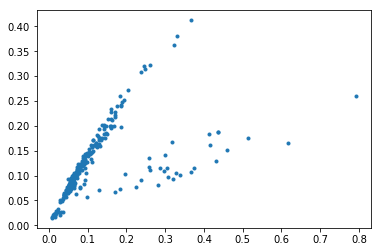

In [100]:
plt.plot(train_losses,D_cl5['train_losses'],'.')

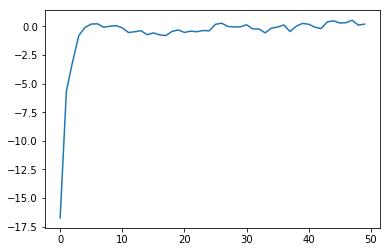

In [77]:
plt.plot(np.squeeze(W.values()).T)

(-0.1, 0.1)

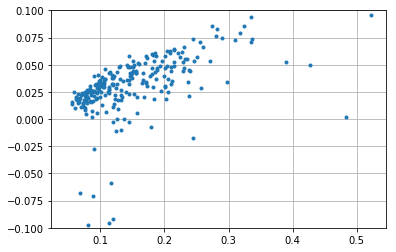

In [45]:
D_cl = np.load('ivscc_clustered_half_tv.npz')
D_cl5 = np.load('ivscc_clustered_half_tv_5cls.npz')
D_cl_rand = np.load('ivscc_clustered_half_tv_random_labels.npz')
D_ind = np.load('ivscc_indiv_half_tv.npz')
D_ind2 = np.load('ivscc_indiv_other_half_tv.npz')

lims=[-0.1,0.1]
x=D_cl['val_losses']
y=D_ind['val_losses']
# plt.plot(D_ind['val_losses'],D_cl['val_losses'],'.')
plt.plot(x,x-y,'.')
plt.grid()
# plt.plot(lims,lims)
# plt.ylabel('clustered')
# plt.xlabel('individual')
# plt.axis('square')
plt.ylim(lims)
# plt.xlim(lims)


(-39.80000000000001, 4909.099999999999, -168.95000000000002, 4779.95)

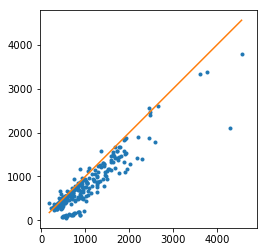

In [75]:
val_sums = np.sum(binned_spikes[:,val_inds],axis=1)
train_sums = np.sum(binned_spikes[:,train_inds],axis=1)
lims = [np.min(val_sums),np.max(val_sums)]
plt.plot(val_sums,train_sums,'.')
plt.plot(lims,lims)
plt.axis('square')

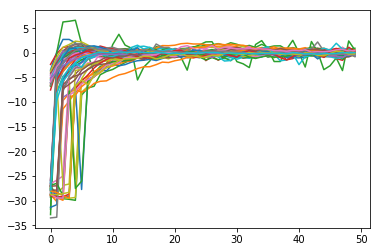

In [32]:
W_imps = D_ind['Ws'][D_ind['val_losses']>D_cl['val_losses'],:]
a=plt.plot(W_imps[:,:].T)
# print F.shape
# a=plt.plot(np.squeeze(D_cl['F']).T)

(array([0.79310345, 0.        , 0.39655172, 0.        , 0.        ,
        0.42241379, 0.        , 0.73275862, 0.        , 0.15517241]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

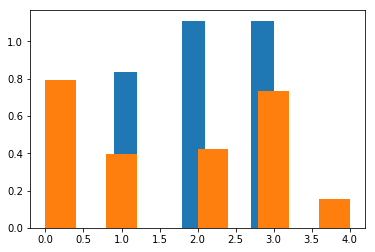

In [42]:
D_cl3 = np.load('ivscc_clustered_half_tv.npz')
D_cl5 = np.load('ivscc_clustered_half_tv_5cls.npz')
D_cl3_rand = np.load('ivscc_clustered_half_tv_random_labels.npz')
D_cl5_rand = np.load('ivscc_clustered_half_tv_5cls_random_labels.npz')
D_ind = np.load('ivscc_indiv_half_tv.npz')
D_ind2 = np.load('ivscc_indiv_other_half_tv.npz')
plt.hist(cell_types[D_cl5['val_losses']>0.025+D_cl5_rand['val_losses']],density=True)
plt.hist(cell_types,density=True)